https://www.kaggle.com/competitions/ieee-fraud-detection

Este notebook engloba os seguinte passos:

* Feature Engineering
    * Tratando Colunas com Valores Faltantes (deletar colunas com 75% de valores faltantes)
    * Tratando Colunas com valores únicos (deletar)
    * Tratando Linhas com Valores Faltantes (deletar linhas com 75% de valores faltantes)
    * Substituindo NaNs remanescentes por média e moda
    * Codificação de variáveis categóricas
* Redução de dimensionalidade
    * Seleção de atributos com teste do Qui-Quadrado (top 50 e top 100)
* Separação entre base de treino e de teste, a partir da base de treino
* Balanceamento de classes
    * Oversample
        * SMOTE
        * Borderline SMOTE
        * AdaSyn
* Treinamento dos algoritmos e análise de desempenho, com validação cruzada (10 folds)
    * Algoritmos utilizados
        * Extra Trees
        * Decision Tree
        * CatBoost
        * Gradient Boost Classifier
        * AdaBoost
        * KNN
    * Métricas de desempenho
        * F1-score positivo (iteração por iteração)
        * F1-score negativo (iteração por iteração)
        * curva ROC
        * curva Precision-Recall
        * matriz de confusão
        * avaliação de thresholds
        * avaliação de importância de atributos
        * Wall time

# Sobre os Dados

## Tabela Transação

* `TransactionDT`: timedelta from a given reference datetime (not an actual timestamp)

* `TransactionAMT`: transaction payment amount in USD

* `ProductCD`: product code, the product for each transaction

* `card1 - card6`: payment card information, such as card type, card category, issue bank, country, etc.

* `addr`: address

* `dist`: distance

* `P_ and (R__) emaildomain`: purchaser and recipient email domain

* `C1-C14`: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.

* `D1-D15`: timedelta, such as days between previous transaction, etc.

* `M1-M9`: match, such as names on card and address, etc.

* `Vxxx`: Vesta engineered rich features, including ranking, counting, and other entity relations.

### Categorical Features

* `ProductCD`

* `card1 - card6`

* `addr1, addr2`

* `P_emaildomain`

* `R_emaildomain`

* `M1 - M9`

## Tabela Identidade

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.

They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

### Categorical Features

* `DeviceType`

* `DeviceInfo`

* `id_12 - id_38`

# Importando Bibliotecas

In [1]:
# inicializando cronômetro
import time
t0 = time.time()

In [2]:
!pip install lightgbm
!pip install xgboost
!pip install catboost

!pip install scikit-learn==1.2.2
!pip install numpy==1.24.0
!pip install pandas==2.0.2
!pip install imbalanced-learn==0.10.1
#!pip install scikit-learn==1.1.1
#!pip install numpy==1.22.4
#!pip install pandas==1.2.4
#!pip install imbalanced-learn==0.10.1

In [3]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, log_loss, roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix
from scipy import stats
pd.options.display.max_rows = 999
pd.options.display.precision = 15

import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, \
KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.style.use("ggplot")
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

In [4]:
# checar utilização de memória
!pip install GPUtil

from GPUtil import showUtilization as gpu_usage
gpu_usage() 

| ID | GPU | MEM |
------------------


In [5]:
#limpando cache do CUDA para melhor desempenho do paralelismo
!pip install torch
import torch
torch.cuda.empty_cache()

# Importando Dados

In [6]:
folder_path = ''
train_identity = pd.read_csv(f'{folder_path}train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}train_transaction.csv')
test_identity = pd.read_csv(f'{folder_path}test_identity.csv')
test_transaction = pd.read_csv(f'{folder_path}test_transaction.csv')
sub = pd.read_csv(f'{folder_path}sample_submission.csv')

# combinando dados de transações e de identidade associada às transações (p.ex., IP e browser utilizado)
train = pd.merge(train_transaction, train_identity, on = 'TransactionID', how = 'left')
test = pd.merge(test_transaction, test_identity, on = 'TransactionID', how = 'left')

In [7]:
print(f'Train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'Test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

Train dataset has 590540 rows and 434 columns.
Test dataset has 506691 rows and 433 columns.


# Análise Exploratória de Dados

## Estatística Básica

In [8]:
# função resumetable traz as estatísticas básicas do conjunto de dados
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = \
        round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [9]:
resumetable(train)[:25]

Dataset Shape: (590540, 434)


Name   dtypes  Missing  Uniques First Value Second Value  \
0    TransactionID    int64        0   590540     2987000      2987001   
1          isFraud    int64        0        2           0            0   
2    TransactionDT    int64        0   573349       86400        86401   
3   TransactionAmt  float64        0    20902        68.5         29.0   
4        ProductCD   object        0        5           W            W   
5            card1    int64        0    13553       13926         2755   
6            card2  float64     8933      500         NaN        404.0   
7            card3  float64     1565      114       150.0        150.0   
8            card4   object     1577        4    discover   mastercard   
9            card5  float64     4259      119       142.0        102.0   
10           card6   object     1571        4      credit       credit   
11           addr1  float64    65706      332       315.0        325.0   
12           addr2  float64    65706       74        87.0         87.0   
13           dist1  float64   352271     2651        19.0          NaN   
14           dist2  float64   552913     1751         NaN          NaN   
15   P_emaildomain   object    94456       59         NaN    gmail.com   
16   R_emaildomain   object   453249       60         NaN          NaN   
17              C1  float64        0     1657         1.0          1.0   
18              C2  float64        0     1216         1.0          1.0   
19              C3  float64        0       27         0.0          0.0   
20              C4  float64        0     1260         0.0          0.0   
21              C5  float64        0      319         0.0          0.0   
22              C6  float64        0     1328         1.0          1.0   
23              C7  float64        0     1103         0.0          0.0   
24              C8  float64        0     1253         0.0          0.0   

    Third Value             Entropy  
0       2987002  19.170000000000002  
1             0   0.220000000000000  
2         86469  19.109999999999999  
3          59.0   8.350000000000000  
4             W   1.280000000000000  
5          4663   9.970000000000001  
6         490.0   6.320000000000000  
7         150.0   0.680000000000000  
8          visa   1.090000000000000  
9         166.0   2.660000000000000  
10        debit   0.820000000000000  
11        330.0   5.060000000000000  
12         87.0   0.080000000000000  
13        287.0   6.340000000000000  
14          NaN   7.420000000000000  
15  outlook.com   2.680000000000000  
16          NaN   2.760000000000000  
17          1.0   2.720000000000000  
18          1.0   2.750000000000000  
19          0.0   0.040000000000000  
20          0.0   1.120000000000000  
21          0.0   2.060000000000000  
22          1.0   2.520000000000000  
23          0.0   0.710000000000000  
24          0.0   1.250000000000000

In [10]:
resumetable(test)[:25]

Dataset Shape: (506691, 433)


Name   dtypes  Missing  Uniques         First Value  \
0    TransactionID    int64        0   506691             3663549   
1    TransactionDT    int64        0   494686            18403224   
2   TransactionAmt  float64        0    14119  31.949999999999999   
3        ProductCD   object        0        5                   W   
4            card1    int64        0    13244               10409   
5            card2  float64     8654      497               111.0   
6            card3  float64     3002      115               150.0   
7            card4   object     3086        4                visa   
8            card5  float64     4547      102               226.0   
9            card6   object     3007        3               debit   
10           addr1  float64    65609      292               170.0   
11           addr2  float64    65609       72                87.0   
12           dist1  float64   291217     1988                 1.0   
13           dist2  float64   470255     1814                 NaN   
14   P_emaildomain   object    69192       60           gmail.com   
15   R_emaildomain   object   370821       60                 NaN   
16              C1  float64        3     1174                 6.0   
17              C2  float64        3     1123                 6.0   
18              C3  float64        3       31                 0.0   
19              C4  float64        3      728                 0.0   
20              C5  float64        3      353                 3.0   
21              C6  float64        3      834                 4.0   
22              C7  float64        3      518                 0.0   
23              C8  float64        3      442                 0.0   
24              C9  float64        3      354                 6.0   

   Second Value  Third Value             Entropy  
0       3663550      3663551  18.949999999999999  
1      18403263     18403310  18.899999999999999  
2          49.0        171.0   8.080000000000000  
3             W            W   1.370000000000000  
4          4272         4476   9.949999999999999  
5         111.0        574.0   6.280000000000000  
6         150.0        150.0   0.810000000000000  
7          visa         visa   1.050000000000000  
8         226.0        226.0   2.630000000000000  
9         debit        debit   0.790000000000000  
10        299.0        472.0   5.100000000000000  
11         87.0         87.0   0.110000000000000  
12          4.0       2635.0   5.990000000000000  
13          NaN          NaN   7.900000000000000  
14      aol.com  hotmail.com   2.670000000000000  
15          NaN          NaN   2.690000000000000  
16          3.0          2.0   2.680000000000000  
17          2.0          2.0   2.760000000000000  
18          0.0          0.0   0.180000000000000  
19          0.0          0.0   1.210000000000000  
20          0.0          0.0   1.930000000000000  
21          1.0          5.0   2.470000000000000  
22          0.0          0.0   0.820000000000000  
23          0.0          0.0   1.360000000000000  
24          2.0          4.0   2.610000000000000

In [11]:
# checando todas as colunas dos conjuntos de dado de treino e teste
for i in list(train):
    print("'" + i + "'" + ", ")

'TransactionID', 
'isFraud', 
'TransactionDT', 
'TransactionAmt', 
'ProductCD', 
'card1', 
'card2', 
'card3', 
'card4', 
'card5', 
'card6', 
'addr1', 
'addr2', 
'dist1', 
'dist2', 
'P_emaildomain', 
'R_emaildomain', 
'C1', 
'C2', 
'C3', 
'C4', 
'C5', 
'C6', 
'C7', 
'C8', 
'C9', 
'C10', 
'C11', 
'C12', 
'C13', 
'C14', 
'D1', 
'D2', 
'D3', 
'D4', 
'D5', 
'D6', 
'D7', 
'D8', 
'D9', 
'D10', 
'D11', 
'D12', 
'D13', 
'D14', 
'D15', 
'M1', 
'M2', 
'M3', 
'M4', 
'M5', 
'M6', 
'M7', 
'M8', 
'M9', 
'V1', 
'V2', 
'V3', 
'V4', 
'V5', 
'V6', 
'V7', 
'V8', 
'V9', 
'V10', 
'V11', 
'V12', 
'V13', 
'V14', 
'V15', 
'V16', 
'V17', 
'V18', 
'V19', 
'V20', 
'V21', 
'V22', 
'V23', 
'V24', 
'V25', 
'V26', 
'V27', 
'V28', 
'V29', 
'V30', 
'V31', 
'V32', 
'V33', 
'V34', 
'V35', 
'V36', 
'V37', 
'V38', 
'V39', 
'V40', 
'V41', 
'V42', 
'V43', 
'V44', 
'V45', 
'V46', 
'V47', 
'V48', 
'V49', 
'V50', 
'V51', 
'V52', 
'V53', 
'V54', 
'V55', 
'V56', 
'V57', 
'V58', 
'V59', 
'V60', 
'V61', 
'V62', 
'V63', 
'V64', 
'V6

In [12]:
for i in list(test):
    print("'" + i + "'" + ", ")

'TransactionID', 
'TransactionDT', 
'TransactionAmt', 
'ProductCD', 
'card1', 
'card2', 
'card3', 
'card4', 
'card5', 
'card6', 
'addr1', 
'addr2', 
'dist1', 
'dist2', 
'P_emaildomain', 
'R_emaildomain', 
'C1', 
'C2', 
'C3', 
'C4', 
'C5', 
'C6', 
'C7', 
'C8', 
'C9', 
'C10', 
'C11', 
'C12', 
'C13', 
'C14', 
'D1', 
'D2', 
'D3', 
'D4', 
'D5', 
'D6', 
'D7', 
'D8', 
'D9', 
'D10', 
'D11', 
'D12', 
'D13', 
'D14', 
'D15', 
'M1', 
'M2', 
'M3', 
'M4', 
'M5', 
'M6', 
'M7', 
'M8', 
'M9', 
'V1', 
'V2', 
'V3', 
'V4', 
'V5', 
'V6', 
'V7', 
'V8', 
'V9', 
'V10', 
'V11', 
'V12', 
'V13', 
'V14', 
'V15', 
'V16', 
'V17', 
'V18', 
'V19', 
'V20', 
'V21', 
'V22', 
'V23', 
'V24', 
'V25', 
'V26', 
'V27', 
'V28', 
'V29', 
'V30', 
'V31', 
'V32', 
'V33', 
'V34', 
'V35', 
'V36', 
'V37', 
'V38', 
'V39', 
'V40', 
'V41', 
'V42', 
'V43', 
'V44', 
'V45', 
'V46', 
'V47', 
'V48', 
'V49', 
'V50', 
'V51', 
'V52', 
'V53', 
'V54', 
'V55', 
'V56', 
'V57', 
'V58', 
'V59', 
'V60', 
'V61', 
'V62', 
'V63', 
'V64', 
'V65', 
'V66', 

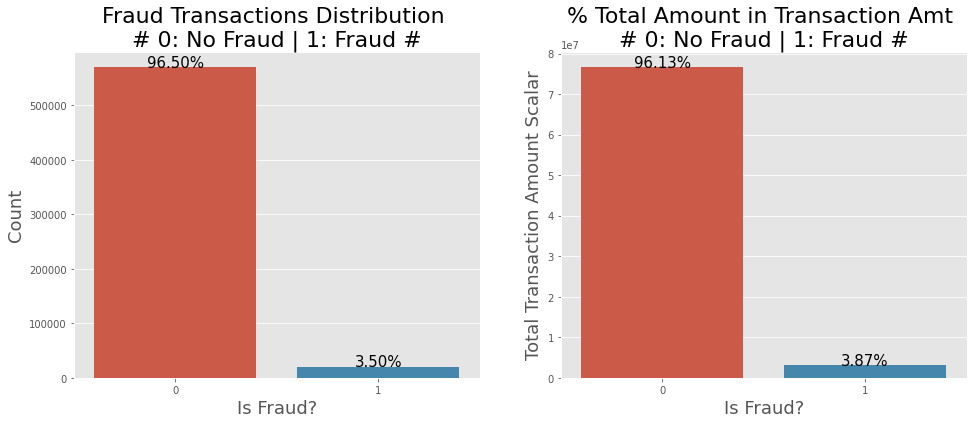

In [13]:
# checando o desbalanceamento dos dados por quantidade de transações e valor das transações
# ("TransactionAmt")
train['TransactionAmt'] = train['TransactionAmt'].astype(float)
total = len(train)
total_amt = train.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize = (16, 6))

plt.subplot(121)
g = sns.countplot(x = 'isFraud', data = train, )
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize = 22)
g.set_xlabel("Is Fraud?", fontsize = 18)
g.set_ylabel('Count', fontsize = 18)

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x() + p.get_width()/2.,
          height + 3,
          '{:1.2f}%'.format(height/total * 100),
          ha = "center", fontsize = 15)

perc_amt = (train.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x = 'isFraud', y = 'TransactionAmt', dodge = True, data = perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize = 22)
g1.set_xlabel("Is Fraud?", fontsize = 18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize = 18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x() + p.get_width()/2.,
           height + 3,
           '{:1.2f}%'.format(height/total_amt * 100),
           ha = "center", fontsize = 15)

# Feature Engineering

## Convertendo "TransactionDT" em data, dias, horários e dias da semana

In [14]:
# a primeira data é 01/12/2017 e será usada o timedelta para calcular os atributos de 
# datas e horários

import datetime

START_DATE = '2017-12-01'
start_date = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
train["Date"] = train['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta
                                                             (seconds = x)))

train['_Weekdays'] = train['Date'].dt.dayofweek
train['_Hours'] = train['Date'].dt.hour
train['_Days'] = train['Date'].dt.day

In [15]:
# fazendo o mesmo para base teste

START_DATE = '2017-12-01'
start_date = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
test["Date"] = test['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta
                                                             (seconds = x)))

test['_Weekdays'] = test['Date'].dt.dayofweek
test['_Hours'] = test['Date'].dt.hour
test['_Days'] = test['Date'].dt.day

In [16]:
# método do Pandas para mostrar todas as linhas ao pedir para exibir um dataframe
pd.reset_option('display.max_rows')

## Equalizando nomes de colunas entre bases de treino e teste

In [17]:
# importante para seguir com ajustes na base de forma otimizada
train.columns.difference(test.columns)

Index(['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08',
       'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24',
       'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'isFraud'],
      dtype='object')

In [18]:
# ajustar colunas de teste
test.columns = test.columns.str.replace('-', '_')

In [19]:
# checando resultado final das diferenças
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Tratando Colunas com Valores Faltantes

In [20]:
# função para checar valores NaN
def NaN_percent(df, column_name):
    #me dá a posição 0 do resultado de df.shape
    row_count = df[column_name].shape[0]
    #df.count() conta os valores não vazios
    empty_values = row_count - df[column_name].count()
    return (100.0 * empty_values)/row_count

In [21]:
# lista completa de colunas com percentuais de NaNs
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

TransactionID: 0.0%
isFraud: 0.0%
TransactionDT: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 1.5126833068039423%
card3: 0.26501168422122123%
card4: 0.267043722694483%
card5: 0.7212043214684865%
card6: 0.26602770345785215%
addr1: 11.12642666034477%
addr2: 11.12642666034477%
dist1: 59.6523520845328%
dist2: 93.62837403054831%
P_emaildomain: 15.99485216920107%
R_emaildomain: 76.75161716395164%
C1: 0.0%
C2: 0.0%
C3: 0.0%
C4: 0.0%
C5: 0.0%
C6: 0.0%
C7: 0.0%
C8: 0.0%
C9: 0.0%
C10: 0.0%
C11: 0.0%
C12: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.21488806854743117%
D2: 47.54919226470688%
D3: 44.514850814508755%
D4: 28.604666915026925%
D5: 52.46740271615809%
D6: 87.60676668811597%
D7: 93.40992989467267%
D8: 87.31229044603245%
D9: 87.31229044603245%
D10: 12.873302401192129%
D11: 47.29349409015477%
D12: 89.04104717715988%
D13: 89.50926270870728%
D14: 89.46946862193924%
D15: 15.090087038981272%
M1: 45.90713584177194%
M2: 45.90713584177194%
M3: 45.90713584177194%
M4: 47.658753005723575%
M5: 59.34

V328: 86.05496664070174%
V329: 86.05496664070174%
V330: 86.05496664070174%
V331: 86.05496664070174%
V332: 86.05496664070174%
V333: 86.05496664070174%
V334: 86.05496664070174%
V335: 86.05496664070174%
V336: 86.05496664070174%
V337: 86.05496664070174%
V338: 86.05496664070174%
V339: 86.05496664070174%
id_01: 75.5760829071697%
id_02: 76.14522301622245%
id_03: 88.76892335828225%
id_04: 88.76892335828225%
id_05: 76.82375452975243%
id_06: 76.82375452975243%
id_07: 99.12707013919463%
id_08: 99.12707013919463%
id_09: 87.31229044603245%
id_10: 87.31229044603245%
id_11: 76.12727334304196%
id_12: 75.5760829071697%
id_13: 78.44007179869273%
id_14: 86.4456260371863%
id_15: 76.12608798726589%
id_16: 78.09801198902699%
id_17: 76.39973583499848%
id_18: 92.36072069631184%
id_19: 76.40837199850984%
id_20: 76.41802418125783%
id_21: 99.12639279303689%
id_22: 99.1246994276425%
id_23: 99.1246994276425%
id_24: 99.19615944728554%
id_25: 99.13096487960172%
id_26: 99.12571544687913%
id_27: 99.1246994276425%
id_2

In [22]:
# identificando colunas com mais de 75% dos valores como NaN
many_null_cols_train = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.75]
many_null_cols_test = [col for col in test.columns if test[col].isnull().sum() / test.shape[0] > 0.75]

## Tratando Colunas com Valores Únicos

In [23]:
# checando se existem colunas apenas com um valor
one_value_cols_train = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

print(f'There are {len(one_value_cols_train)} columns in train dataset with one unique value.')
print(f'There are {len(one_value_cols_test)} columns in test dataset with one unique value.')

There are 0 columns in train dataset with one unique value.
There are 1 columns in test dataset with one unique value.


In [24]:
# identificando colunas com valor único
one_value_cols_train = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

In [25]:
# checando colunas com mais de 75% de valores únicos
big_top_value_cols_train = [col for col in train.columns if \
                            train[col].value_counts(dropna=False, normalize=True).values[0] > 0.75]
big_top_value_cols_test = [col for col in test.columns if test[col].value_counts(dropna=False,\
                                                                                 normalize=True).values[0] > 0.75]

## Concatenando as Colunas Desnecessárias e Removendo-as

In [26]:
cols_to_drop = list(set(many_null_cols_train + big_top_value_cols_train + \
                        one_value_cols_train + many_null_cols_test + big_top_value_cols_test + one_value_cols_test))

# excluir a coluna 'isFraud' da remoção
cols_to_drop.remove('isFraud')
len(cols_to_drop)

346

In [27]:
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [28]:
# checando novamente a diferença entre colunas das bases treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Identificando Linhas com Valores Faltantes e Removendo-as

In [29]:
# checando e excluindo linhas com mais de 75% de valores faltantes
perc = 75.0 
min_count =  int(((100 - perc) / 100) * train.shape[1] + 1)
train = train.dropna(axis = 0, thresh = min_count)

min_count =  int(((100 - perc) / 100) * test.shape[1] + 1)
test = test.dropna(axis = 0, thresh = min_count)

In [30]:
train.shape

(590540, 92)

In [31]:
test.shape

(506691, 91)

## Remover colunas datetime e ID para balanceamento e redução de dimensionalidade

In [32]:
# remover TransactionID e datetime para balanceamento e redução de dimensionalidade
train = train.drop(['TransactionID', 'TransactionDT', 'Date'], axis = 1)
test = test.drop(['TransactionID', 'TransactionDT', 'Date'], axis = 1)

In [33]:
# checando por diferenças de colunas entre as bases de treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Substituindo NaNs remanescentes por média (variáveis numéricas) e moda (variáveis categóricas) para pacotes de balanceamento e redução de dimensionalidade

In [34]:
# lista completa de colunas remanescentes com percentuais de NaNs
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

isFraud: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 1.5126833068039423%
card4: 0.267043722694483%
card5: 0.7212043214684865%
addr1: 11.12642666034477%
dist1: 59.6523520845328%
P_emaildomain: 15.99485216920107%
C1: 0.0%
C2: 0.0%
C5: 0.0%
C6: 0.0%
C9: 0.0%
C11: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.21488806854743117%
D2: 47.54919226470688%
D3: 44.514850814508755%
D4: 28.604666915026925%
D5: 52.46740271615809%
D10: 12.873302401192129%
D11: 47.29349409015477%
D15: 15.090087038981272%
M1: 45.90713584177194%
M2: 45.90713584177194%
M3: 45.90713584177194%
M4: 47.658753005723575%
M5: 59.34940901547736%
M6: 28.678836319300977%
M7: 58.63531682866529%
M8: 58.633115453652586%
M9: 58.633115453652586%
V1: 47.29349409015477%
V2: 47.29349409015477%
V3: 47.29349409015477%
V4: 47.29349409015477%
V5: 47.29349409015477%
V6: 47.29349409015477%
V7: 47.29349409015477%
V8: 47.29349409015477%
V9: 47.29349409015477%
V10: 47.29349409015477%
V11: 47.29349409015477%
V12: 12.881938564703491%
V13: 12.88193

In [35]:
# das colunas com NaNs remanescentes, entender quais são de variáveis numéricas ou categóricas
pd.options.display.max_rows = 999
resumetable(train)

Dataset Shape: (590540, 89)


Name   dtypes  Missing  Uniques First Value Second Value  \
0          isFraud    int64        0        2           0            0   
1   TransactionAmt  float64        0    20902        68.5         29.0   
2        ProductCD   object        0        5           W            W   
3            card1    int64        0    13553       13926         2755   
4            card2  float64     8933      500         NaN        404.0   
5            card4   object     1577        4    discover   mastercard   
6            card5  float64     4259      119       142.0        102.0   
7            addr1  float64    65706      332       315.0        325.0   
8            dist1  float64   352271     2651        19.0          NaN   
9    P_emaildomain   object    94456       59         NaN    gmail.com   
10              C1  float64        0     1657         1.0          1.0   
11              C2  float64        0     1216         1.0          1.0   
12              C5  float64        0      319         0.0          0.0   
13              C6  float64        0     1328         1.0          1.0   
14              C9  float64        0      205         1.0          0.0   
15             C11  float64        0     1476         2.0          1.0   
16             C13  float64        0     1597         1.0          1.0   
17             C14  float64        0     1108         1.0          1.0   
18              D1  float64     1269      641        14.0          0.0   
19              D2  float64   280797      641         NaN          NaN   
20              D3  float64   262878      649        13.0          NaN   
21              D4  float64   168922      808         NaN          0.0   
22              D5  float64   309841      688         NaN          NaN   
23             D10  float64    76022      818        13.0          0.0   
24             D11  float64   279287      676        13.0          NaN   
25             D15  float64    89113      859         0.0          0.0   
26              M1   object   271100        2           T          NaN   
27              M2   object   271100        2           T          NaN   
28              M3   object   271100        2           T          NaN   
29              M4   object   281444        3          M2           M0   
30              M5   object   350482        2           F            T   
31              M6   object   169360        2           T            T   
32              M7   object   346265        2         NaN          NaN   
33              M8   object   346252        2         NaN          NaN   
34              M9   object   346252        2         NaN          NaN   
35              V1  float64   279287        2         1.0          NaN   
36              V2  float64   279287        9         1.0          NaN   
37              V3  float64   279287       10         1.0          NaN   
38              V4  float64   279287        7         1.0          NaN   
39              V5  float64   279287        7         1.0          NaN   
40              V6  float64   279287       10         1.0          NaN   
41              V7  float64   279287       10         1.0          NaN   
42              V8  float64   279287        9         1.0          NaN   
43              V9  float64   279287        9         1.0          NaN   
44             V10  float64   279287        5         0.0          NaN   
45             V11  float64   279287        6         0.0          NaN   
46             V12  float64    76073        4         1.0          0.0   
47             V13  float64    76073        7         1.0          0.0   
48             V29  float64    76073        6         0.0          0.0   
49             V30  float64    76073        8         0.0          0.0   
50             V35  float64   168969        4         NaN          0.0   
51             V36  float64   168969        6         NaN          0.0   
52             V39  float64   168969       16         NaN          0.0   
53             V40

In [36]:
# função para substituir os valores faltantes, usando média para variáveis numéricas e moda para variáveis categóricas
def replace_missing_values(df, numeric_strategy='mean', categorical_strategy='mode'):
    """
    Substitui valores ausentes em um DataFrame.
    
    Parâmetros:
    - df: O DataFrame contendo os dados.
    - numeric_strategy: A estratégia de substituição para colunas numéricas ('mean' ou 'median').
    - categorical_strategy: A estratégia de substituição para colunas categóricas ('mode' ou 'random').
    
    Retorna:
    - Um novo DataFrame com os valores ausentes substituídos.
    """
    df_copy = df.copy()
    
    # Lidar com colunas numéricas
    numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if numeric_strategy == 'mean':
            df_copy[col].fillna(df_copy[col].mean(), inplace=True)
        elif numeric_strategy == 'median':
            df_copy[col].fillna(df_copy[col].median(), inplace=True)
    
    # Lidar com colunas categóricas
    categorical_cols = df_copy.select_dtypes(exclude=[np.number]).columns
    for col in categorical_cols:
        if categorical_strategy == 'mode':
            df_copy[col].fillna(df_copy[col].mode()[0], inplace=True)
        elif categorical_strategy == 'random':
            df_copy[col].fillna(df_copy[col].sample(1).iloc[0], inplace=True)
    
    return df_copy

In [37]:
train = replace_missing_values(train)

In [38]:
# checando mais uma vez as colunas remanescentes com percentuais de NaNs
for i in list(train):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(train,i))+'%')

isFraud: 0.0%
TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 0.0%
card4: 0.0%
card5: 0.0%
addr1: 0.0%
dist1: 0.0%
P_emaildomain: 0.0%
C1: 0.0%
C2: 0.0%
C5: 0.0%
C6: 0.0%
C9: 0.0%
C11: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.0%
D2: 0.0%
D3: 0.0%
D4: 0.0%
D5: 0.0%
D10: 0.0%
D11: 0.0%
D15: 0.0%
M1: 0.0%
M2: 0.0%
M3: 0.0%
M4: 0.0%
M5: 0.0%
M6: 0.0%
M7: 0.0%
M8: 0.0%
M9: 0.0%
V1: 0.0%
V2: 0.0%
V3: 0.0%
V4: 0.0%
V5: 0.0%
V6: 0.0%
V7: 0.0%
V8: 0.0%
V9: 0.0%
V10: 0.0%
V11: 0.0%
V12: 0.0%
V13: 0.0%
V29: 0.0%
V30: 0.0%
V35: 0.0%
V36: 0.0%
V39: 0.0%
V40: 0.0%
V42: 0.0%
V43: 0.0%
V48: 0.0%
V49: 0.0%
V50: 0.0%
V51: 0.0%
V52: 0.0%
V53: 0.0%
V54: 0.0%
V69: 0.0%
V70: 0.0%
V75: 0.0%
V76: 0.0%
V80: 0.0%
V81: 0.0%
V84: 0.0%
V85: 0.0%
V90: 0.0%
V91: 0.0%
V92: 0.0%
V93: 0.0%
V96: 0.0%
V99: 0.0%
V127: 0.0%
V130: 0.0%
V280: 0.0%
V282: 0.0%
V283: 0.0%
V285: 0.0%
V307: 0.0%
V308: 0.0%
V310: 0.0%
_Weekdays: 0.0%
_Hours: 0.0%
_Days: 0.0%


In [39]:
test = replace_missing_values(test)

In [40]:
# checando mais uma vez as colunas remanescentes com percentuais de NaNs
for i in list(test):
    #str() converte número em string
    print(i + ': ' + str(NaN_percent(test,i))+'%')

TransactionAmt: 0.0%
ProductCD: 0.0%
card1: 0.0%
card2: 0.0%
card4: 0.0%
card5: 0.0%
addr1: 0.0%
dist1: 0.0%
P_emaildomain: 0.0%
C1: 0.0%
C2: 0.0%
C5: 0.0%
C6: 0.0%
C9: 0.0%
C11: 0.0%
C13: 0.0%
C14: 0.0%
D1: 0.0%
D2: 0.0%
D3: 0.0%
D4: 0.0%
D5: 0.0%
D10: 0.0%
D11: 0.0%
D15: 0.0%
M1: 0.0%
M2: 0.0%
M3: 0.0%
M4: 0.0%
M5: 0.0%
M6: 0.0%
M7: 0.0%
M8: 0.0%
M9: 0.0%
V1: 0.0%
V2: 0.0%
V3: 0.0%
V4: 0.0%
V5: 0.0%
V6: 0.0%
V7: 0.0%
V8: 0.0%
V9: 0.0%
V10: 0.0%
V11: 0.0%
V12: 0.0%
V13: 0.0%
V29: 0.0%
V30: 0.0%
V35: 0.0%
V36: 0.0%
V39: 0.0%
V40: 0.0%
V42: 0.0%
V43: 0.0%
V48: 0.0%
V49: 0.0%
V50: 0.0%
V51: 0.0%
V52: 0.0%
V53: 0.0%
V54: 0.0%
V69: 0.0%
V70: 0.0%
V75: 0.0%
V76: 0.0%
V80: 0.0%
V81: 0.0%
V84: 0.0%
V85: 0.0%
V90: 0.0%
V91: 0.0%
V92: 0.0%
V93: 0.0%
V96: 0.0%
V99: 0.0%
V127: 0.0%
V130: 0.0%
V280: 0.0%
V282: 0.0%
V283: 0.0%
V285: 0.0%
V307: 0.0%
V308: 0.0%
V310: 0.0%
_Weekdays: 0.0%
_Hours: 0.0%
_Days: 0.0%


## Codificação de variáveis categóricas (para pacotes de redução de dimensionalidade)

In [41]:
# identificando os atributos classificados como "object" para codificação
object_columns = train.select_dtypes(include = "object").columns
print(object_columns)

Index(['ProductCD', 'card4', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5',
       'M6', 'M7', 'M8', 'M9'],
      dtype='object')


In [42]:
# pela documentação do conjunto de dados, nenhuma delas é categórica ordinal
# separando as colunas a serem tratadas
object_columns_treated = ['ProductCD', 'card4', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

In [43]:
# Aplicando One-Hot Encoding em várias colunas
train = pd.get_dummies(train, columns = object_columns_treated)
test = pd.get_dummies(test, columns = object_columns_treated)

In [44]:
# realizando a transformação usando LabelEncoder
#le = LabelEncoder()
#for col in object_columns_treated:
#    if col in train.columns:
#        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
#        train[col] = le.fit_transform(list(train[col].astype(str).values))
#        test[col] = le.fit_transform(list(test[col].astype(str).values))

In [45]:
# checando se ainda existem colunas "object"
checking_remaining_objects_train = resumetable(train)[['Name', 'dtypes']]
checking_remaining_objects_train[checking_remaining_objects_train['dtypes'] == 'object']

Dataset Shape: (590540, 164)


Empty DataFrame
Columns: [Name, dtypes]
Index: []

In [46]:
# checando se ainda existem colunas "object"
checking_remaining_objects_test = resumetable(test)[['Name', 'dtypes']]
checking_remaining_objects_test[checking_remaining_objects_test['dtypes'] == 'object']

Dataset Shape: (506691, 164)


Empty DataFrame
Columns: [Name, dtypes]
Index: []

In [47]:
# checando se ainda existem colunas categóricas
cols = train.columns
num_cols = train._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

[]

In [48]:
# checando se ainda existem colunas categóricas
cols = test.columns
num_cols = test._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols

[]

In [49]:
# checando por diferenças entre as colunas de treino e teste
train.columns.difference(test.columns)

Index(['isFraud'], dtype='object')

## Checando colunas com valores negativos para métodos de seleção de atributos

In [50]:
columns_negative_values = train.columns[train.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index(['D4', 'D11', 'D15'], dtype='object')


In [51]:
# separando as columas com valores negativos
negative_columns_treated = ['D4', 'D11', 'D15']

In [52]:
# realizando a transformação
le = LabelEncoder()
for col in negative_columns_treated:
    if col in train.columns:
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.fit_transform(list(train[col].astype(str).values))
        test[col] = le.fit_transform(list(test[col].astype(str).values))

In [53]:
# última checagem de valores negativos
columns_negative_values = train.columns[train.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index([], dtype='object')


In [54]:
# última checagem de valores negativos
columns_negative_values = test.columns[test.lt(0).any()]
print("Columns with negative values:", columns_negative_values)

Columns with negative values: Index([], dtype='object')


# Separação da base de treino entre treino e teste para balanceamento e avaliação de desempenho dos algoritmos de ML

In [55]:
# Separar entre treinamento e teste com estratificação (80% para treinamento, 20% para teste)
train_split, test_split = train_test_split(train, test_size=0.2, random_state=42, stratify = train.isFraud)

In [56]:
# Separar entre treinamento e teste com estratificação (80% para treinamento, 20% para teste)
X_train = train_split.drop('isFraud',axis = 1)
y_train = train_split['isFraud'].astype('uint8')

X_test = test_split.drop('isFraud', axis = 1)
y_test = test_split['isFraud'].astype('uint8')

In [57]:
# Exibir a distribuição das classes nos conjuntos de treinamento e teste
print("Distribuição das classes no conjunto de treinamento:")
print(y_train.value_counts())

print("\nDistribuição das classes no conjunto de teste:")
print(y_test.value_counts())

Distribuição das classes no conjunto de treinamento:
isFraud
0    455902
1     16530
Name: count, dtype: int64

Distribuição das classes no conjunto de teste:
isFraud
0    113975
1      4133
Name: count, dtype: int64


In [58]:
# combinando as classes minoritária com a majoritária subamostrada
test_split = pd.concat([X_test, y_test], \
                                       axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
test_split.isFraud.value_counts()

isFraud
0    113975
1      4133
Name: count, dtype: int64

# Balanceamento de Classes

### Oversampling com SMOTE

In [59]:
from imblearn.over_sampling import SMOTE

In [60]:
smote = SMOTE(random_state=42)

In [61]:
%%time
X_train_oversample_with_smote, y_train_oversample_with_smote = smote.fit_resample(X_train, y_train)

CPU times: user 6.58 s, sys: 1.02 s, total: 7.6 s
Wall time: 2.68 s


In [62]:
# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_smote = pd.concat([X_train_oversample_with_smote, y_train_oversample_with_smote], \
                                        axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_oversample_with_smote.isFraud.value_counts()

isFraud
0    455902
1    455902
Name: count, dtype: int64

### Oversampling com Borderline-SMOTE

In [63]:
from imblearn.over_sampling import BorderlineSMOTE

In [64]:
smote = BorderlineSMOTE(random_state=42)

In [65]:
%%time
X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote = smote.fit_resample(X_train, y_train)

CPU times: user 2min 5s, sys: 580 ms, total: 2min 6s
Wall time: 13.3 s


In [66]:
# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_borderline_smote = pd.concat([X_train_oversample_with_borderline_smote, \
                                                    y_train_oversample_with_borderline_smote], \
                                        axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_oversample_with_borderline_smote.isFraud.value_counts()

isFraud
0    455902
1    455902
Name: count, dtype: int64

### Oversampling com AdaSyn

In [67]:
from imblearn.over_sampling import ADASYN

In [68]:
adasyn = ADASYN(random_state=42)

In [69]:
%%time
X_train_oversample_with_adasyn, y_train_oversample_with_adasyn = adasyn.fit_resample(X_train, y_train)

CPU times: user 2min 7s, sys: 455 ms, total: 2min 8s
Wall time: 13.4 s


In [70]:
# combinando as classes majoritária com a minoritária sobreamostrada 
train_oversample_with_adasyn = pd.concat([X_train_oversample_with_adasyn, \
                                                    y_train_oversample_with_adasyn], \
                                        axis = 1, ignore_index=False)

# contando as classes minoritária e majoritária
train_oversample_with_adasyn.isFraud.value_counts()

isFraud
1    456567
0    455902
Name: count, dtype: int64

In [71]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 1.1e+02 s


# Redução de Dimensionalidade

## Seleção de Atributos com Teste do Qui-Quadrado

In [72]:
# importando as bibliotecas necessárias
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

### Oversampling com SMOTE

In [73]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_50_chi2 = SelectKBest(chi2, k = 50)
new_50_chi2 = model_50_chi2.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)
X_train_oversample_with_smote_50_chi2 = new_50_chi2.transform(X_train_oversample_with_smote)

# transformando os atributos selecionados em dataframe 
cols = new_50_chi2.get_support(indices = True)
features_df_new_50_chi2 = X_train_oversample_with_smote.iloc[:, cols]

In [74]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 100)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)
X_train_oversample_with_smote_100_chi2 = new_100_chi2.transform(X_train_oversample_with_smote)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_smote.iloc[:, cols]

In [75]:
oversample_with_smote_cols_50_chi2 = features_df_new_50_chi2.columns
oversample_with_smote_cols_100_chi2 = features_df_new_100_chi2.columns

In [76]:
oversample_with_smote_cols_50_chi2

Index(['card1', 'card5', 'dist1', 'C1', 'C2', 'C5', 'C6', 'C9', 'C11', 'C13',
       'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15', 'V29', 'V30',
       'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51', 'V52', 'V69',
       'V70', 'V80', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92', 'V93', 'V96',
       'V127', 'V130', 'V282', 'V283', 'V307', 'V308', 'V310', 'ProductCD_C',
       'M4_M2'],
      dtype='object')

In [77]:
oversample_with_smote_cols_100_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'addr1', 'dist1', 'C1',
       'C2', 'C5', 'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D10', 'D11', 'D15', 'V10', 'V11', 'V12', 'V13', 'V29', 'V30',
       'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51',
       'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V81', 'V84',
       'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V127', 'V130', 'V282',
       'V283', 'V285', 'V307', 'V308', 'V310', '_Weekdays', '_Hours', '_Days',
       'ProductCD_C', 'ProductCD_H', 'ProductCD_R', 'ProductCD_S',
       'ProductCD_W', 'card4_discover', 'card4_mastercard', 'card4_visa',
       'P_emaildomain_aim.com', 'P_emaildomain_att.net',
       'P_emaildomain_comcast.net', 'P_emaildomain_gmail.com',
       'P_emaildomain_hotmail.com', 'P_emaildomain_icloud.com',
       'P_emaildomain_live.com.mx', 'P_emaildomain_mail.com',
       'P_emaildomain_outlook.com', 'P_emaildomain_outlook.es',
       '

### Oversampling com Borderline-SMOTE

In [78]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_50_chi2 = SelectKBest(chi2, k = 50)
new_50_chi2 = model_50_chi2.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)
X_train_oversample_with_borderline_smote_50_chi2 = new_50_chi2.transform(X_train_oversample_with_borderline_smote)

# transformando os atributos selecionados em dataframe 
cols = new_50_chi2.get_support(indices = True)
features_df_new_50_chi2 = X_train_oversample_with_borderline_smote.iloc[:, cols]

In [79]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 100)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)
X_train_oversample_with_borderline_smote_100_chi2 = new_100_chi2.transform(X_train_oversample_with_borderline_smote)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_borderline_smote.iloc[:, cols]

In [80]:
oversample_with_borderline_smote_cols_50_chi2 = features_df_new_50_chi2.columns
oversample_with_borderline_smote_cols_100_chi2 = features_df_new_100_chi2.columns

In [81]:
oversample_with_borderline_smote_cols_50_chi2

Index(['TransactionAmt', 'card1', 'card5', 'dist1', 'C1', 'C2', 'C5', 'C6',
       'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11',
       'D15', 'V29', 'V30', 'V39', 'V40', 'V42', 'V43', 'V48', 'V50', 'V51',
       'V52', 'V69', 'V70', 'V80', 'V81', 'V84', 'V85', 'V90', 'V91', 'V92',
       'V93', 'V96', 'V127', 'V130', 'V282', 'V283', 'V307', 'V308', 'V310',
       'ProductCD_C', 'M4_M2'],
      dtype='object')

In [82]:
oversample_with_borderline_smote_cols_100_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'addr1', 'dist1', 'C1',
       'C2', 'C5', 'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D10', 'D11', 'D15', 'V10', 'V11', 'V12', 'V13', 'V29', 'V30',
       'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51',
       'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V81', 'V84',
       'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V127', 'V130', 'V280',
       'V282', 'V283', 'V285', 'V307', 'V308', 'V310', '_Weekdays', '_Hours',
       '_Days', 'ProductCD_C', 'ProductCD_H', 'ProductCD_R', 'ProductCD_S',
       'ProductCD_W', 'card4_discover', 'card4_mastercard', 'card4_visa',
       'P_emaildomain_aim.com', 'P_emaildomain_aol.com',
       'P_emaildomain_att.net', 'P_emaildomain_comcast.net',
       'P_emaildomain_gmail.com', 'P_emaildomain_hotmail.com',
       'P_emaildomain_hotmail.es', 'P_emaildomain_icloud.com',
       'P_emaildomain_live.com.mx', 'P_emaildomain_mail.com',
    

### Oversampling com AdaSyn

In [83]:
# selecionando os 50 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_50_chi2 = SelectKBest(chi2, k = 50)
new_50_chi2 = model_50_chi2.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)
X_train_oversample_with_adasyn_50_chi2 = new_50_chi2.transform(X_train_oversample_with_adasyn)

# transformando os atributos selecionados em dataframe 
cols = new_50_chi2.get_support(indices = True)
features_df_new_50_chi2 = X_train_oversample_with_adasyn.iloc[:, cols]

In [84]:
# selecionando os 100 melhores atributos para explicar o comportamento da variágel target ('y_train') 
model_100_chi2 = SelectKBest(chi2, k = 100)
new_100_chi2 = model_100_chi2.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)
X_train_oversample_with_adasyn_100_chi2 = new_100_chi2.transform(X_train_oversample_with_adasyn)

# transformando os atributos selecionados em dataframe 
cols = new_100_chi2.get_support(indices = True)
features_df_new_100_chi2 = X_train_oversample_with_adasyn.iloc[:, cols]

In [85]:
oversample_with_adasyn_cols_50_chi2 = features_df_new_50_chi2.columns
oversample_with_adasyn_cols_100_chi2 = features_df_new_100_chi2.columns

In [86]:
oversample_with_adasyn_cols_50_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'dist1', 'C1', 'C2', 'C5',
       'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10',
       'D11', 'D15', 'V29', 'V30', 'V39', 'V40', 'V42', 'V43', 'V50', 'V51',
       'V52', 'V80', 'V81', 'V84', 'V85', 'V91', 'V92', 'V93', 'V96', 'V99',
       'V127', 'V130', 'V280', 'V282', 'V283', 'V285', 'V307', 'V308', 'V310',
       'ProductCD_C', 'M4_M2'],
      dtype='object')

In [87]:
oversample_with_adasyn_cols_100_chi2

Index(['TransactionAmt', 'card1', 'card2', 'card5', 'addr1', 'dist1', 'C1',
       'C2', 'C5', 'C6', 'C9', 'C11', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4',
       'D5', 'D10', 'D11', 'D15', 'V10', 'V11', 'V12', 'V13', 'V29', 'V30',
       'V35', 'V36', 'V39', 'V40', 'V42', 'V43', 'V48', 'V49', 'V50', 'V51',
       'V52', 'V53', 'V54', 'V69', 'V70', 'V75', 'V76', 'V80', 'V81', 'V84',
       'V85', 'V90', 'V91', 'V92', 'V93', 'V96', 'V99', 'V127', 'V130', 'V280',
       'V282', 'V283', 'V285', 'V307', 'V308', 'V310', '_Weekdays', '_Hours',
       '_Days', 'ProductCD_C', 'ProductCD_H', 'ProductCD_R', 'ProductCD_S',
       'ProductCD_W', 'card4_american express', 'card4_discover',
       'card4_mastercard', 'card4_visa', 'P_emaildomain_aim.com',
       'P_emaildomain_att.net', 'P_emaildomain_comcast.net',
       'P_emaildomain_gmail.com', 'P_emaildomain_hotmail.com',
       'P_emaildomain_icloud.com', 'P_emaildomain_live.com.mx',
       'P_emaildomain_mail.com', 'P_emaildomain_outlook.com',
  

# Seleção do Modelo de Classificação

## Inicializando os classificadores

In [88]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import cross_validate

In [89]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

In [90]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

In [91]:
clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)

## Validação Cruzada para Oversampling com SMOTE

### 50 Chi-Square

F1-Score Positivo (Teste): 0.597547974413646
F1-Score Negativo (Teste): 0.9867956206932735
F1-Score Positivo Médio (Validação Cruzada): 0.5021700887870186
F1-Score Positivo Fold 1: 0.5228758169934641
F1-Score Positivo Fold 2: 0.4891846921797005
F1-Score Positivo Fold 3: 0.5129870129870129
F1-Score Positivo Fold 4: 0.5071315372424723
F1-Score Positivo Fold 5: 0.5472312703583062
F1-Score Positivo Fold 6: 0.504950495049505
F1-Score Positivo Fold 7: 0.47000000000000003
F1-Score Positivo Fold 8: 0.4771573604060914
F1-Score Positivo Fold 9: 0.4909983633387889
F1-Score Positivo Fold 10: 0.49918433931484507
F1-Score Negativo Médio (Validação Cruzada): 0.9868200152830191
F1-Score Negativo Fold 1: 0.987309865275967
F1-Score Negativo Fold 2: 0.9866643499413579
F1-Score Negativo Fold 3: 0.9869599234982178
F1-Score Negativo Fold 4: 0.9864729676830064
F1-Score Negativo Fold 5: 0.9879172461752433
F1-Score Negativo Fold 6: 0.9869655891553704
F1-Score Negativo Fold 7: 0.9861871253583527
F1-Score Negati

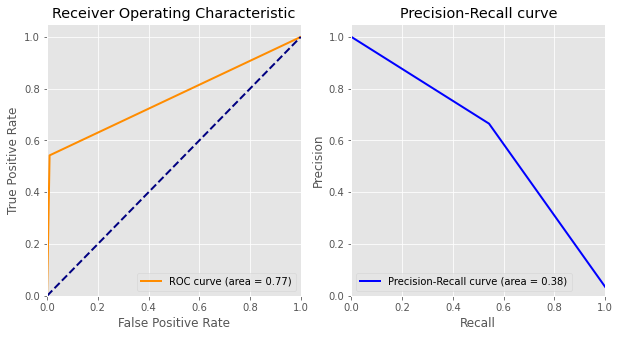

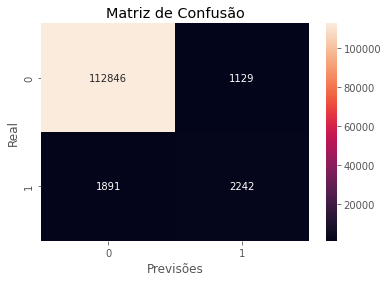

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    113975
           1       0.67      0.54      0.60      4133

    accuracy                           0.97    118108
   macro avg       0.82      0.77      0.79    118108
weighted avg       0.97      0.97      0.97    118108

CPU times: user 5min 50s, sys: 447 ms, total: 5min 51s
Wall time: 5min 50s


In [92]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [93]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_et.predict_proba(X_test[oversample_with_smote_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 57.2 s, sys: 3.94 ms, total: 57.2 s
Wall time: 57.2 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.597547974413646  0.986795620693274
Threshold: 0.05    0.2152190622598   0.87468763961098
Threshold: 0.1   0.311483907450167  0.932040280006512
Threshold: 0.15  0.404337722695585  0.958192131349559
Threshold: 0.2   0.476281439032155  0.970579292829932
Threshold: 0.25  0.518599363346976   0.97649863911447
Threshold: 0.3    0.54156722354813  0.979616200919703
Threshold: 0.35  0.577038269550749  0.983217503444087
Threshold: 0.4   0.590968353680218  0.984849349588856
Threshold: 0.45  0.594251586412841  0.985708588432766
Threshold: 0.5   0.596141225882662  0.986539630878795
Threshold: 0.55  0.596680497925311  0.987265597023399
Threshold: 0.6   0.589573732718894  0.987569349942427
Threshold: 0.65  0.575293592983499  0.987550601553887
Threshold: 0.7   0.561787365177196  0.987620034301733
Threshold: 0.75  0.536248191609066  0.987456249048892

In [94]:
feature_importances = clf_et.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_smote_cols_50_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
49        M4_M2  0.052056705339717
10          C14  0.045087405768663
48  ProductCD_C  0.043763936091835
0         card1  0.042337881360532
3            C1  0.037371683147186
4            C2  0.035910243919618
1         card5  0.031144970101036
43         V282  0.029464710807160
9           C13  0.029047436442144
12           D2  0.028152387074719
44         V283  0.026616219845450
8           C11  0.025961360159619
36          V90  0.025546746450449
30          V69  0.025302568708029
25          V48  0.024693515295374
6            C6  0.022366074005786
11           D1  0.022247570190445
40          V96  0.021373115760612
19          V29  0.018898808931664
46         V308  0.018645491734489
37          V91  0.018177398398384
16          D10  0.017667399454645
18          D15  0.017174273611343
28          V51  0.016841570736003
31          V70  0.016667380950810
15           D5  0.015791338126191
13           D3  0.015734447414007
27          V50  0.015440606926263
45         V307  0.015282256960798
23          V42  0.015174493074735
24          V43  0.015093423055227
34          V84  0.015046689259747
7            C9  0.014820353541808
17          D11  0.014545700675478
29          V52  0.014255744860830
26          V49  0.013988214650313
41         V127  0.013737848844414
14           D4  0.013710069823089
47         V310  0.013624846317312
21          V39  0.011847388579871
2         dist1  0.011486762812274
22          V40  0.011391444717856
20          V30  0.011051055891022
38          V92  0.010329366482504
35          V85  0.009469465316825
42         V130  0.009088230372217
33          V81  0.008440845662334
32          V80  0.007367446146181
39          V93  0.006630506387673
5            C5  0.004134599815318

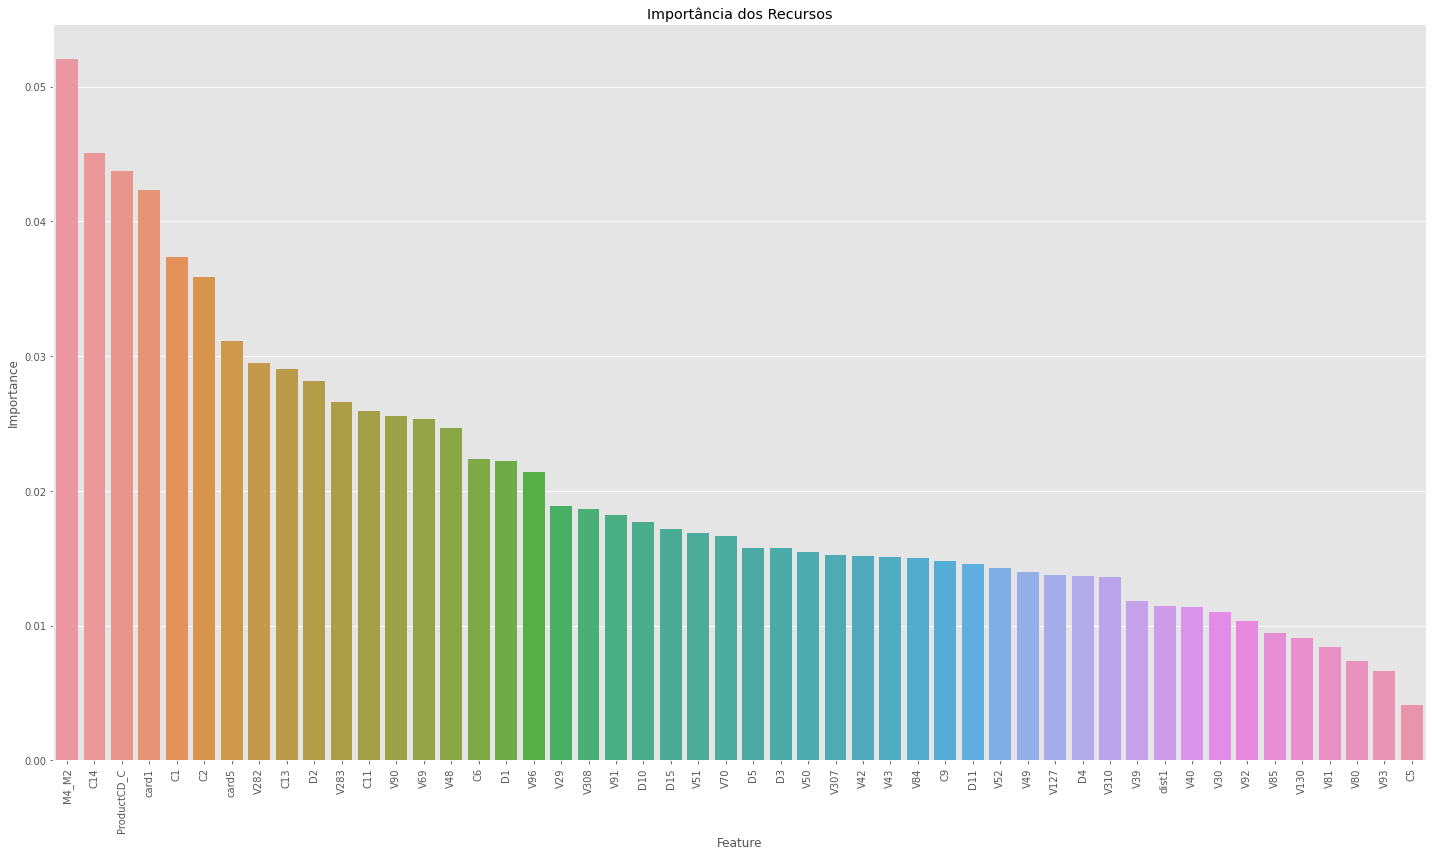

In [95]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.4734174485064164
F1-Score Negativo (Teste): 0.9784835839836434
F1-Score Positivo Médio (Validação Cruzada): 0.42804033709555506
F1-Score Positivo Fold 1: 0.47664670658682634
F1-Score Positivo Fold 2: 0.4265402843601896
F1-Score Positivo Fold 3: 0.41232227488151657
F1-Score Positivo Fold 4: 0.43146603098927294
F1-Score Positivo Fold 5: 0.4463414634146341
F1-Score Positivo Fold 6: 0.44311377245508987
F1-Score Positivo Fold 7: 0.4183796856106409
F1-Score Positivo Fold 8: 0.40199750312109866
F1-Score Positivo Fold 9: 0.4221954161640531
F1-Score Positivo Fold 10: 0.40140023337222874
F1-Score Negativo Médio (Validação Cruzada): 0.9790900659852163
F1-Score Negativo Fold 1: 0.9808223987361214
F1-Score Negativo Fold 2: 0.9787514268153481
F1-Score Negativo Fold 3: 0.9782246026868031
F1-Score Negativo Fold 4: 0.9790633366984155
F1-Score Negativo Fold 5: 0.9800894658363302
F1-Score Negativo Fold 6: 0.9795936279457585
F1-Score Negativo Fold 7: 0.9788988813336258
F1-Scor

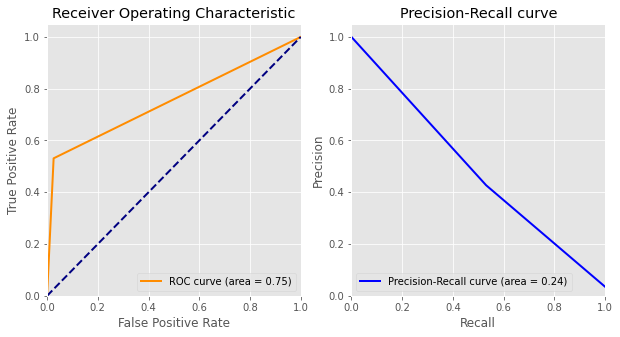

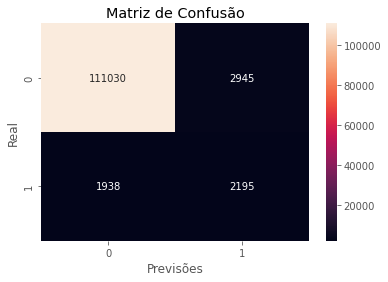

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    113975
           1       0.43      0.53      0.47      4133

    accuracy                           0.96    118108
   macro avg       0.70      0.75      0.73    118108
weighted avg       0.96      0.96      0.96    118108

CPU times: user 51.7 s, sys: 320 ms, total: 52 s
Wall time: 51.6 s


In [96]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [97]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_dt.predict_proba(X_test[oversample_with_smote_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 1.1 s, sys: 61 µs, total: 1.1 s
Wall time: 1.1 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.473417448506416  0.978483583983643
Threshold: 0.05  0.333239038189533  0.957546065310975
Threshold: 0.1   0.354468828308907  0.961886956560725
Threshold: 0.15  0.400417645523362  0.969335582027652
Threshold: 0.2   0.420577949567458  0.972061238074107
Threshold: 0.25  0.432912844036697  0.973714518586768
Threshold: 0.3   0.438297457874744  0.974476541166369
Threshold: 0.35  0.456768648316791  0.976554806286792
Threshold: 0.4   0.463635417750494  0.977251163919596
Threshold: 0.45  0.465495608531995  0.977445599421139
Threshold: 0.5   0.471264367816092  0.978097169561767
Threshold: 0.55  0.477970919427135  0.978971149738626
Threshold: 0.6   0.480635551142006  0.979278283799906
Threshold: 0.65  0.481727574750831  0.979400139093078
Threshold: 0.7   0.484577559231113   0.97970677790098
Threshold: 0.75  0.485669149176258  0.979951969175823

In [98]:
feature_importances = clf_dt.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_smote_cols_50_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
33          V81  0.190701498700628
3            C1  0.144763241166938
46         V308  0.103554368045113
10          C14  0.087212038061258
44         V283  0.046962838781482
0         card1  0.044619931415539
36          V90  0.035450365053343
13           D3  0.028779916323880
6            C6  0.027301617996429
9           C13  0.026352791720837
31          V70  0.026210603100001
1         card5  0.019761793435492
7            C9  0.018062427990332
40          V96  0.015591298146751
4            C2  0.012548234057762
11           D1  0.012406469693952
8           C11  0.012151748013353
47         V310  0.012150667212297
49        M4_M2  0.011851344394320
2         dist1  0.011325667295086
43         V282  0.009765176140716
28          V51  0.008554712569247
18          D15  0.007964873059441
12           D2  0.007377918891104
16          D10  0.006494734687555
27          V50  0.006221166384404
45         V307  0.006022284564717
14           D4  0.005565529553668
17          D11  0.005114535449912
32          V80  0.004996072107289
41         V127  0.004880339176797
15           D5  0.004390957664229
23          V42  0.003839019156989
42         V130  0.003608570196457
5            C5  0.003373630976846
21          V39  0.003247584514657
34          V84  0.003116104140016
25          V48  0.002358118743294
19          V29  0.002313186075794
29          V52  0.002229940476681
37          V91  0.002225322228383
39          V93  0.001737924044771
30          V69  0.001413225671459
20          V30  0.001119053074174
26          V49  0.001021005286803
22          V40  0.000809055066683
38          V92  0.000807908883973
24          V43  0.000682742198370
35          V85  0.000595960031751
48  ProductCD_C  0.000394488379029

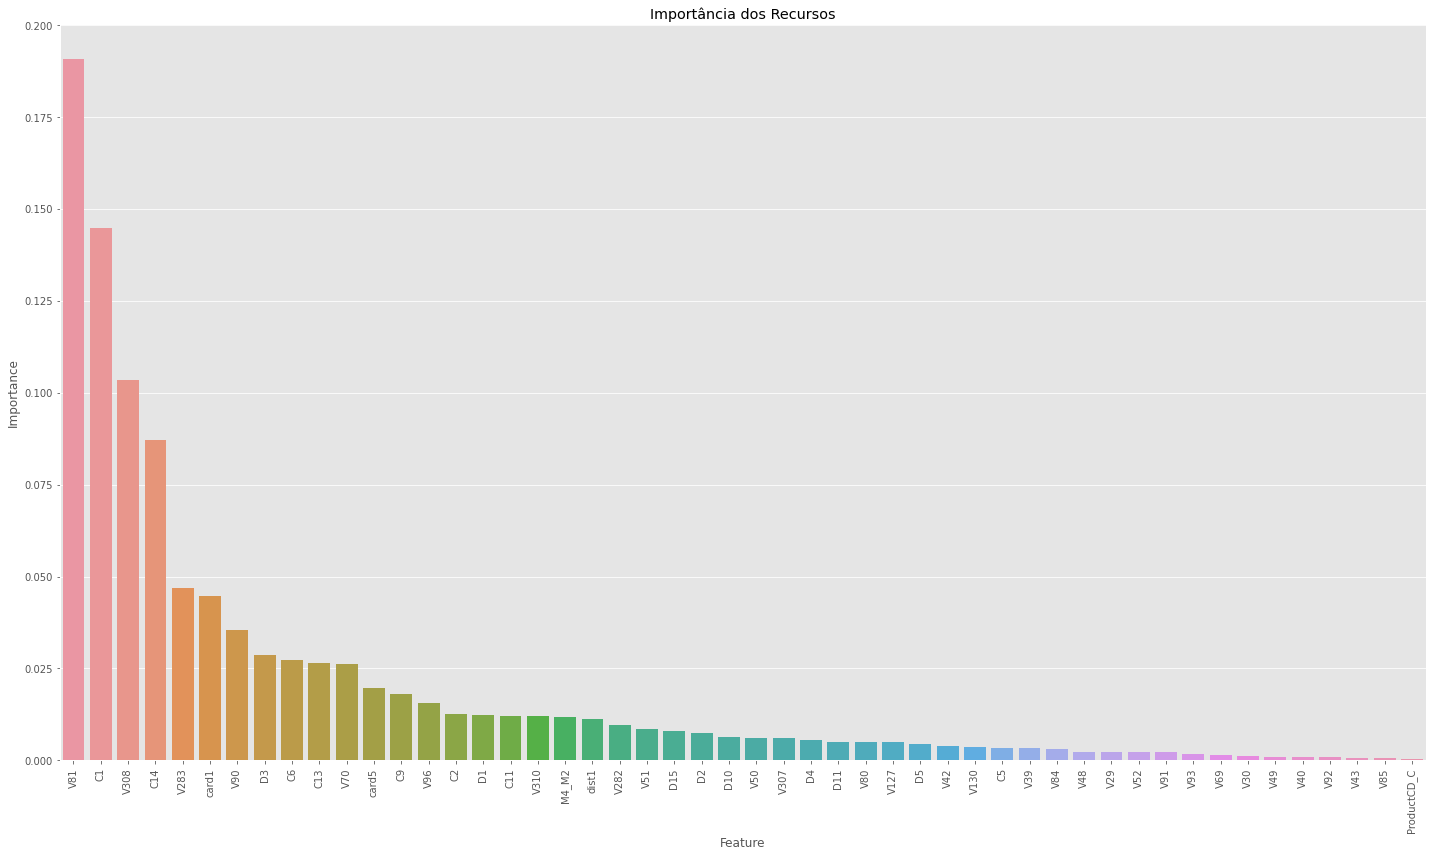

In [99]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

0:	learn: 0.6041906	total: 128ms	remaining: 514ms
1:	learn: 0.5498908	total: 204ms	remaining: 306ms
2:	learn: 0.5099933	total: 262ms	remaining: 175ms
3:	learn: 0.4684057	total: 327ms	remaining: 81.8ms
4:	learn: 0.4409434	total: 385ms	remaining: 0us
0:	learn: 0.5418533	total: 7.23ms	remaining: 28.9ms
1:	learn: 0.4234363	total: 14.4ms	remaining: 21.7ms
2:	learn: 0.3472970	total: 20.8ms	remaining: 13.9ms
3:	learn: 0.2931230	total: 26.9ms	remaining: 6.72ms
4:	learn: 0.2432306	total: 34ms	remaining: 0us
0:	learn: 0.5412085	total: 13.3ms	remaining: 53.3ms
1:	learn: 0.4225214	total: 22.8ms	remaining: 34.1ms
2:	learn: 0.3462526	total: 29.8ms	remaining: 19.8ms
3:	learn: 0.2922745	total: 36ms	remaining: 9ms
4:	learn: 0.2425982	total: 43.2ms	remaining: 0us
0:	learn: 0.5415613	total: 12.7ms	remaining: 50.7ms
1:	learn: 0.4227770	total: 22.1ms	remaining: 33.2ms
2:	learn: 0.3465860	total: 29.1ms	remaining: 19.4ms
3:	learn: 0.2924947	total: 35.3ms	remaining: 8.83ms
4:	learn: 0.2431587	total: 42.3ms	re

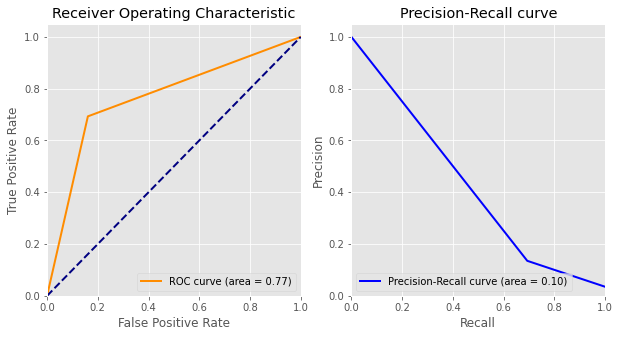

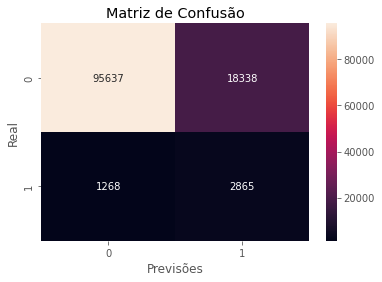

              precision    recall  f1-score   support

           0       0.99      0.84      0.91    113975
           1       0.14      0.69      0.23      4133

    accuracy                           0.83    118108
   macro avg       0.56      0.77      0.57    118108
weighted avg       0.96      0.83      0.88    118108

CPU times: user 23.1 s, sys: 861 ms, total: 24 s
Wall time: 9.89 s


In [100]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [101]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_cb.predict_proba(X_test[oversample_with_smote_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2.11 s, sys: 20.5 ms, total: 2.13 s
Wall time: 1.68 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.226160404167982  0.907027693474962
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.078739232576351  0.297935191263353
Threshold: 0.3   0.095112998858349  0.523679364156247
Threshold: 0.35  0.131665520510009  0.743883385504323
Threshold: 0.4    0.16152388357063  0.823078263900994
Threshold: 0.45  0.177323720179272  0.852451159051989
Threshold: 0.5   0.226160404167982  0.907027693474962
Threshold: 0.55  0.287692112282484  0.949126865333152
Threshold: 0.6   0.345887937261377  0.972016333737998
Threshold: 0.65  0.356671411932186  0.978244029253049
Threshold: 0.7   0.349152542372881  0.983327254728286
Threshold: 0.75  0.205980066445183  0.983474503025065

In [102]:
feature_importances = clf_cb.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_smote_cols_50_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature          Importance
25          V48  28.851097311145534
8           C11  26.328218418204287
19          V29  12.564776228331146
10          C14  10.026895835739575
3            C1   4.737016316084533
46         V308   4.684346062860373
32          V80   2.622470840430420
29          V52   2.046046793302147
33          V81   2.002713673625868
44         V283   1.260060528429158
31          V70   1.025642341152963
6            C6   0.868151934673537
35          V85   0.813587315439384
15           D5   0.780274633533786
47         V310   0.734734780463025
4            C2   0.653966986584245
34          V84   0.000000000000000
36          V90   0.000000000000000
37          V91   0.000000000000000
41         V127   0.000000000000000
38          V92   0.000000000000000
39          V93   0.000000000000000
40          V96   0.000000000000000
42         V130   0.000000000000000
43         V282   0.000000000000000
45         V307   0.000000000000000
48  ProductCD_C   0.000000000000000
30          V69   0.000000000000000
0         card1   0.000000000000000
28          V51   0.000000000000000
16          D10   0.000000000000000
2         dist1   0.000000000000000
5            C5   0.000000000000000
7            C9   0.000000000000000
9           C13   0.000000000000000
11           D1   0.000000000000000
12           D2   0.000000000000000
13           D3   0.000000000000000
14           D4   0.000000000000000
17          D11   0.000000000000000
27          V50   0.000000000000000
18          D15   0.000000000000000
20          V30   0.000000000000000
21          V39   0.000000000000000
22          V40   0.000000000000000
23          V42   0.000000000000000
24          V43   0.000000000000000
1         card5   0.000000000000000
26          V49   0.000000000000000
49        M4_M2   0.000000000000000

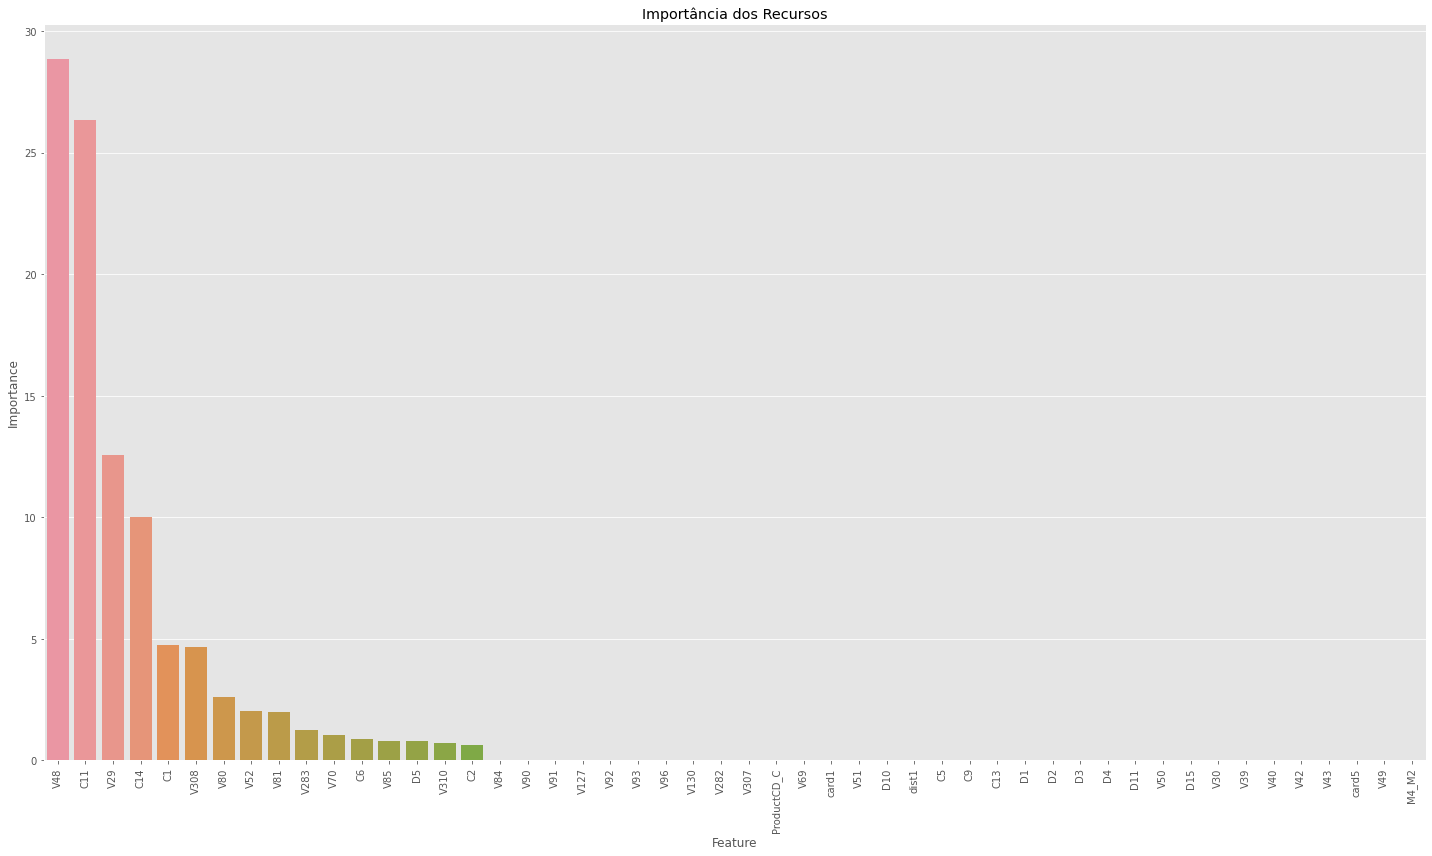

In [103]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.319568345323741
F1-Score Negativo (Teste): 0.9574569531657641
F1-Score Positivo Médio (Validação Cruzada): 0.3102739171305597
F1-Score Positivo Fold 1: 0.4290909090909091
F1-Score Positivo Fold 2: 0.36567164179104483
F1-Score Positivo Fold 3: 0.38202247191011235
F1-Score Positivo Fold 4: 0.36158192090395486
F1-Score Positivo Fold 5: 0.39015151515151514
F1-Score Positivo Fold 6: 0.35793357933579334
F1-Score Positivo Fold 7: 0.09746588693957114
F1-Score Positivo Fold 8: 0.29239766081871343
F1-Score Positivo Fold 9: 0.32046332046332043
F1-Score Positivo Fold 10: 0.10596026490066224
F1-Score Negativo Médio (Validação Cruzada): 0.9845205511949106
F1-Score Negativo Fold 1: 0.9863904299583912
F1-Score Negativo Fold 2: 0.9852724594992636
F1-Score Negativo Fold 3: 0.9857068607068608
F1-Score Negativo Fold 4: 0.9853189554371833
F1-Score Negativo Fold 5: 0.9860569844981381
F1-Score Negativo Fold 6: 0.9849220103986135
F1-Score Negativo Fold 7: 0.9799645159894415
F1-Sco

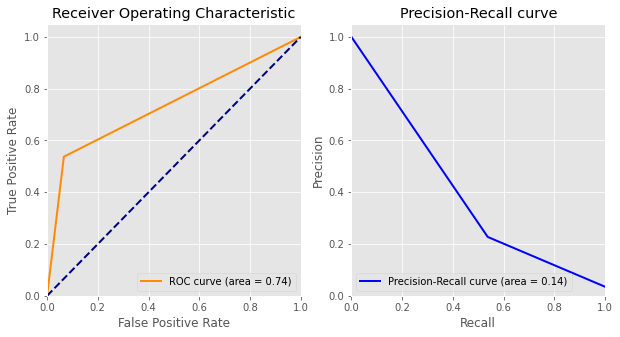

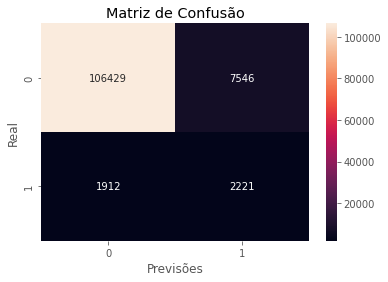

              precision    recall  f1-score   support

           0       0.98      0.93      0.96    113975
           1       0.23      0.54      0.32      4133

    accuracy                           0.92    118108
   macro avg       0.60      0.74      0.64    118108
weighted avg       0.96      0.92      0.94    118108

CPU times: user 5min 3s, sys: 275 ms, total: 5min 3s
Wall time: 5min 3s


In [104]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [105]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_gbc.predict_proba(X_test[oversample_with_smote_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2.46 s, sys: 55 µs, total: 2.46 s
Wall time: 2.46 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.319568345323741  0.957456953165764
Threshold: 0.05  0.087441593301594    0.4329418547983
Threshold: 0.1   0.105331617865373  0.617619510898137
Threshold: 0.15  0.137029061382539  0.764648516425196
Threshold: 0.2   0.166051753131039  0.830796494426423
Threshold: 0.25  0.185437896913307  0.863723741234724
Threshold: 0.3   0.211391451028245  0.894539555465964
Threshold: 0.35  0.242658836091831  0.920361186488257
Threshold: 0.4   0.275004128364617  0.939596145820435
Threshold: 0.45  0.297912593807151   0.94947789743101
Threshold: 0.5   0.319568345323741  0.957456953165764
Threshold: 0.55  0.335682892445476  0.964261655892968
Threshold: 0.6   0.359219586840092  0.970322466335932
Threshold: 0.65  0.373500605260262   0.97493494886166
Threshold: 0.7   0.374825529755107  0.978422055313465
Threshold: 0.75   0.37573836622965  0.981101297568422

In [106]:
feature_importances = clf_gbc.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_smote_cols_50_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
33          V81  0.267849746572564
10          C14  0.134047922770282
46         V308  0.129862557824223
8           C11  0.092789655950419
26          V49  0.083213295049714
40          V96  0.050704862775057
6            C6  0.037643777311653
3            C1  0.036161884301057
13           D3  0.027835911589960
43         V282  0.023177662134680
17          D11  0.017243482962601
9           C13  0.013537849692205
19          V29  0.012170776717601
2         dist1  0.009065750622290
41         V127  0.009039051573642
44         V283  0.007099494007332
29          V52  0.006266939169545
16          D10  0.005036578962629
4            C2  0.005028754843116
7            C9  0.004931424326480
24          V43  0.003531508939787
30          V69  0.003142658603389
38          V92  0.002574861393470
42         V130  0.002572112401799
28          V51  0.002542761586995
0         card1  0.002444357236739
18          D15  0.002014488316356
25          V48  0.001591936669949
12           D2  0.001565527836458
34          V84  0.001397386806660
49        M4_M2  0.001278927755958
5            C5  0.001165666042982
47         V310  0.000814908177734
36          V90  0.000655519074672
20          V30  0.000000000000000
48  ProductCD_C  0.000000000000000
45         V307  0.000000000000000
11           D1  0.000000000000000
14           D4  0.000000000000000
15           D5  0.000000000000000
27          V50  0.000000000000000
1         card5  0.000000000000000
21          V39  0.000000000000000
37          V91  0.000000000000000
35          V85  0.000000000000000
22          V40  0.000000000000000
32          V80  0.000000000000000
31          V70  0.000000000000000
23          V42  0.000000000000000
39          V93  0.000000000000000

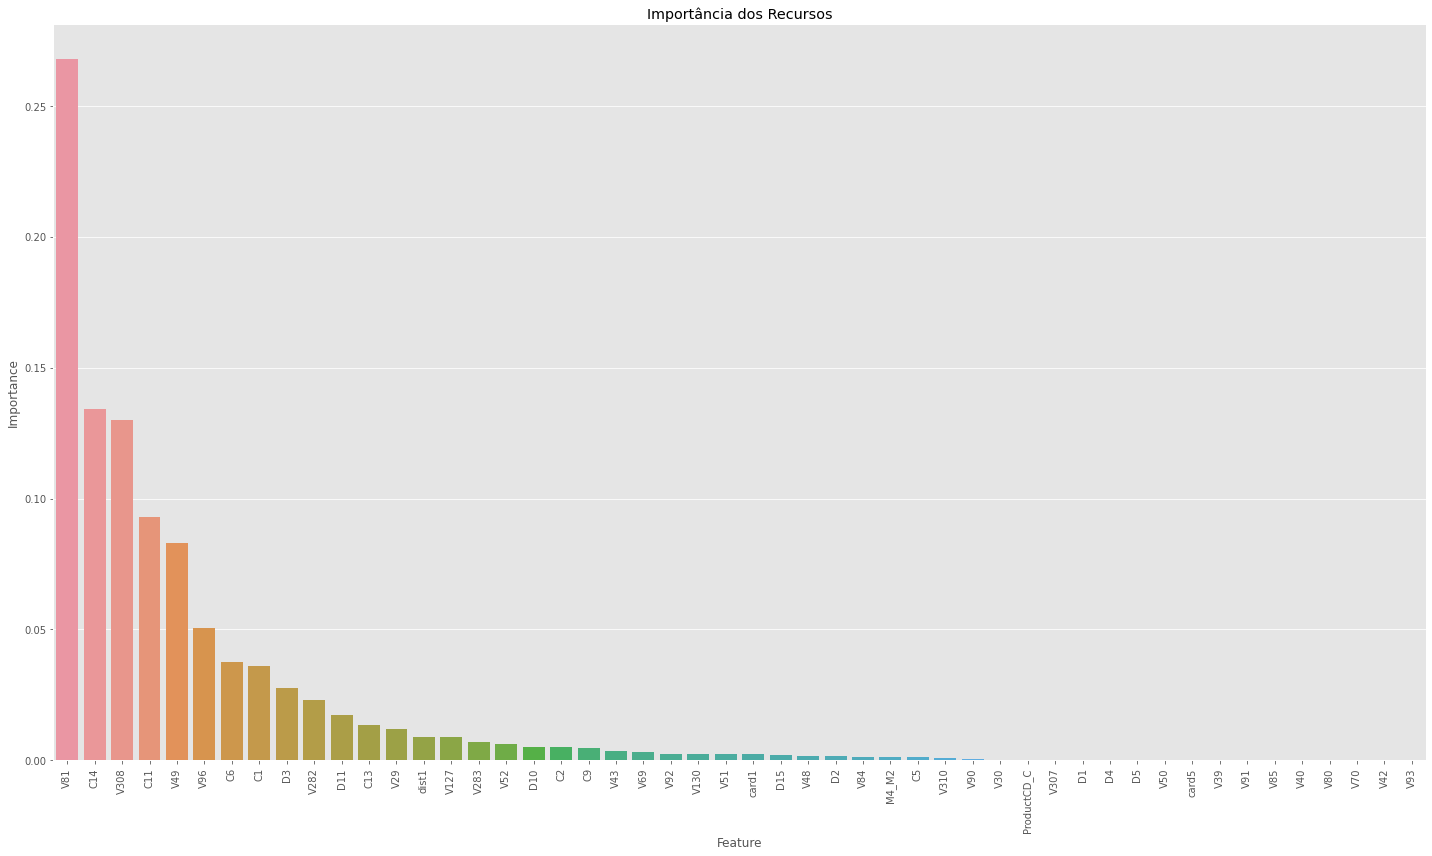

In [107]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.3053953172718018
F1-Score Negativo (Teste): 0.9537883610783768
F1-Score Positivo Médio (Validação Cruzada): 0.32589567618197385
F1-Score Positivo Fold 1: 0.36742424242424243
F1-Score Positivo Fold 2: 0.3320463320463321
F1-Score Positivo Fold 3: 0.35249042145593873
F1-Score Positivo Fold 4: 0.3157894736842105
F1-Score Positivo Fold 5: 0.35316698656429946
F1-Score Positivo Fold 6: 0.3395522388059702
F1-Score Positivo Fold 7: 0.306483300589391
F1-Score Positivo Fold 8: 0.2982791586998088
F1-Score Positivo Fold 9: 0.29469548133595286
F1-Score Positivo Fold 10: 0.2990291262135923
F1-Score Negativo Médio (Validação Cruzada): 0.984849962729748
F1-Score Negativo Fold 1: 0.9855373690135967
F1-Score Negativo Fold 2: 0.9850242382271469
F1-Score Negativo Fold 3: 0.9853679653679653
F1-Score Negativo Fold 4: 0.9848111125535506
F1-Score Negativo Fold 5: 0.9854118869313018
F1-Score Negativo Fold 6: 0.984666031360998
F1-Score Negativo Fold 7: 0.9847272097953532
F1-Score Neg

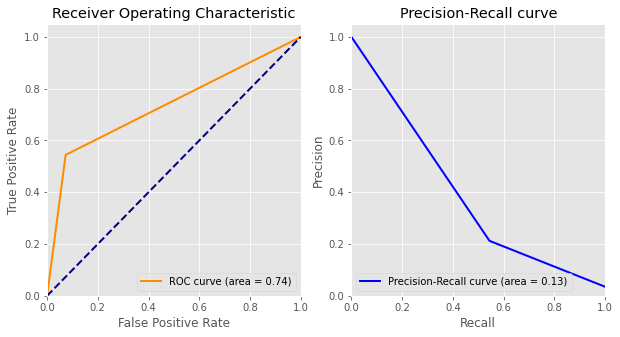

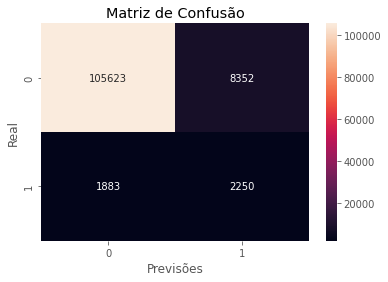

              precision    recall  f1-score   support

           0       0.98      0.93      0.95    113975
           1       0.21      0.54      0.31      4133

    accuracy                           0.91    118108
   macro avg       0.60      0.74      0.63    118108
weighted avg       0.96      0.91      0.93    118108

CPU times: user 6min 5s, sys: 3.34 s, total: 6min 9s
Wall time: 6min 8s


In [108]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [109]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_ada.predict_proba(X_test[oversample_with_smote_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 17.1 s, sys: 3.93 ms, total: 17.1 s
Wall time: 17.1 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.305395317271802  0.953788361078377
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.067620520120091                0.0
Threshold: 0.3   0.067620520120091                0.0
Threshold: 0.35  0.067620520120091                0.0
Threshold: 0.4   0.067620520120091                0.0
Threshold: 0.45  0.067620520120091                0.0
Threshold: 0.5   0.305395317271802  0.953788361078377
Threshold: 0.55                0.0  0.982191715894745
Threshold: 0.6                 0.0  0.982191715894745
Threshold: 0.65                0.0  0.982191715894745
Threshold: 0.7                 0.0  0.982191715894745
Threshold: 0.75                0.0  0.982191715894745

In [110]:
feature_importances = clf_ada.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_smote_cols_50_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature  Importance
40          V96        0.14
10          C14        0.10
3            C1        0.07
6            C6        0.06
13           D3        0.06
17          D11        0.04
8           C11        0.04
29          V52        0.04
44         V283        0.03
2         dist1        0.03
4            C2        0.03
7            C9        0.03
26          V49        0.03
33          V81        0.02
0         card1        0.02
41         V127        0.02
19          V29        0.02
46         V308        0.02
1         card5        0.02
49        M4_M2        0.02
15           D5        0.02
16          D10        0.02
9           C13        0.02
38          V92        0.01
34          V84        0.01
14           D4        0.01
42         V130        0.01
43         V282        0.01
30          V69        0.01
25          V48        0.01
28          V51        0.01
5            C5        0.01
47         V310        0.01
45         V307        0.00
48  ProductCD_C        0.00
11           D1        0.00
12           D2        0.00
39          V93        0.00
20          V30        0.00
37          V91        0.00
36          V90        0.00
21          V39        0.00
32          V80        0.00
31          V70        0.00
27          V50        0.00
18          D15        0.00
24          V43        0.00
23          V42        0.00
22          V40        0.00
35          V85        0.00

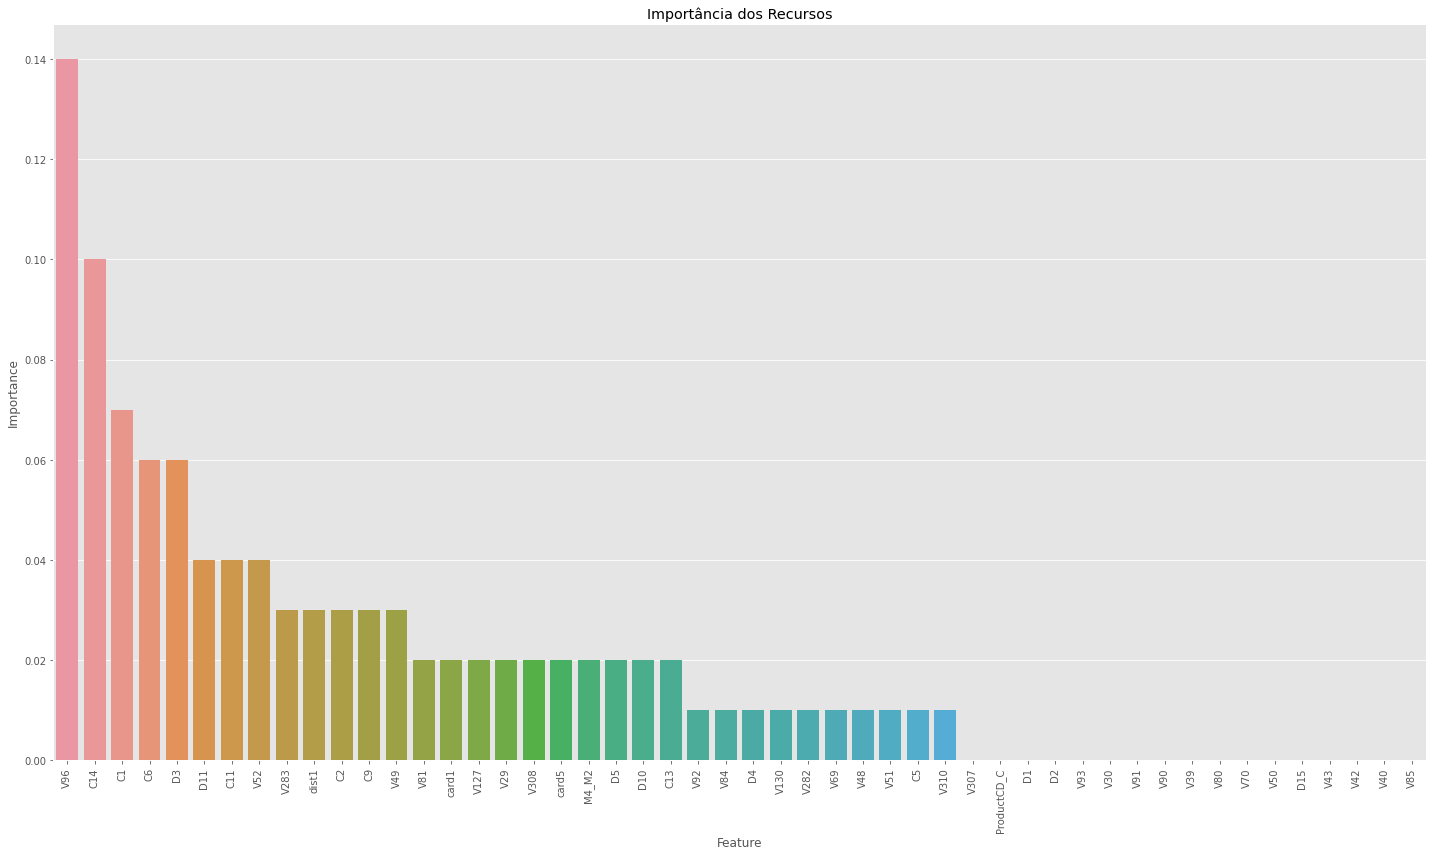

In [111]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.3345185606599345
F1-Score Negativo (Teste): 0.9578760679528616
F1-Score Positivo Médio (Validação Cruzada): 0.2660582785028741
F1-Score Positivo Fold 1: 0.28169014084507044
F1-Score Positivo Fold 2: 0.23859649122807017
F1-Score Positivo Fold 3: 0.25828970331588136
F1-Score Positivo Fold 4: 0.23571428571428574
F1-Score Positivo Fold 5: 0.3005181347150259
F1-Score Positivo Fold 6: 0.27739726027397266
F1-Score Positivo Fold 7: 0.27835051546391754
F1-Score Positivo Fold 8: 0.24338624338624337
F1-Score Positivo Fold 9: 0.2652329749103943
F1-Score Positivo Fold 10: 0.28140703517587945
F1-Score Negativo Médio (Validação Cruzada): 0.9817335828496354
F1-Score Negativo Fold 1: 0.9823024204042683
F1-Score Negativo Fold 2: 0.9811730001735207
F1-Score Negativo Fold 3: 0.9815610221701593
F1-Score Negativo Fold 4: 0.9814413320613997
F1-Score Negativo Fold 5: 0.982424163520375
F1-Score Negativo Fold 6: 0.9816824377116069
F1-Score Negativo Fold 7: 0.9817708333333334
F1-Scor

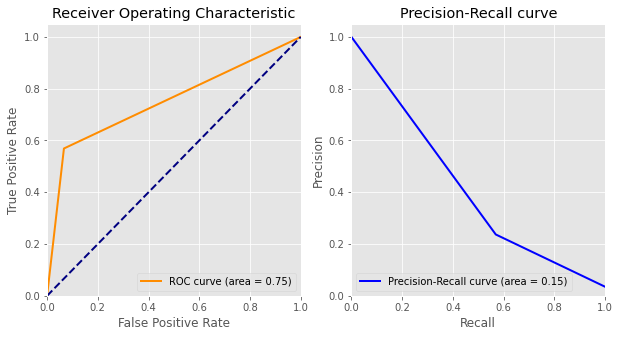

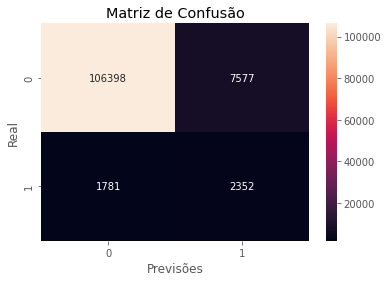

              precision    recall  f1-score   support

           0       0.98      0.93      0.96    113975
           1       0.24      0.57      0.33      4133

    accuracy                           0.92    118108
   macro avg       0.61      0.75      0.65    118108
weighted avg       0.96      0.92      0.94    118108

CPU times: user 17min 40s, sys: 625 ms, total: 17min 41s
Wall time: 1min 35s


In [112]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_smote[oversample_with_smote_cols_50_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [113]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_knn.predict_proba(X_test[oversample_with_smote_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 3h 44min 12s, sys: 1.18 s, total: 3h 44min 13s
Wall time: 18min 54s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.334518560659935  0.957876067952862
Threshold: 0.05  0.267460317460317  0.931647350686859
Threshold: 0.1   0.267460317460317  0.931647350686859
Threshold: 0.15  0.267460317460317  0.931647350686859
Threshold: 0.2   0.267460317460317  0.931647350686859
Threshold: 0.25  0.267460317460317  0.931647350686859
Threshold: 0.3   0.267460317460317  0.931647350686859
Threshold: 0.35  0.334518560659935  0.957876067952862
Threshold: 0.4   0.334518560659935  0.957876067952862
Threshold: 0.45  0.334518560659935  0.957876067952862
Threshold: 0.5   0.334518560659935  0.957876067952862
Threshold: 0.55  0.334518560659935  0.957876067952862
Threshold: 0.6   0.334518560659935  0.957876067952862
Threshold: 0.65  0.334518560659935  0.957876067952862
Threshold: 0.7   0.411019168325128  0.975192902426004
Threshold: 0.75  0.411019168325128  0.975192902426004

### 100 Chi-Square

In [114]:
#reinicializando os classificadores

clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)

F1-Score Positivo (Teste): 0.6837885985748218
F1-Score Negativo (Teste): 0.9907181453721458
F1-Score Positivo Médio (Validação Cruzada): 0.5061978711620426
F1-Score Positivo Fold 1: 0.5454545454545454
F1-Score Positivo Fold 2: 0.4601449275362319
F1-Score Positivo Fold 3: 0.5181347150259068
F1-Score Positivo Fold 4: 0.5183887915936952
F1-Score Positivo Fold 5: 0.5435897435897435
F1-Score Positivo Fold 6: 0.5136054421768708
F1-Score Positivo Fold 7: 0.4991273996509598
F1-Score Positivo Fold 8: 0.4830053667262969
F1-Score Positivo Fold 9: 0.48936170212765956
F1-Score Positivo Fold 10: 0.49116607773851584
F1-Score Negativo Médio (Validação Cruzada): 0.9877569849415485
F1-Score Negativo Fold 1: 0.9884977646599244
F1-Score Negativo Fold 2: 0.9870827915041179
F1-Score Negativo Fold 3: 0.9878922015362583
F1-Score Negativo Fold 4: 0.9880699318901566
F1-Score Negativo Fold 5: 0.9884099492121369
F1-Score Negativo Fold 6: 0.9875835721107927
F1-Score Negativo Fold 7: 0.9875482667360839
F1-Score Neg

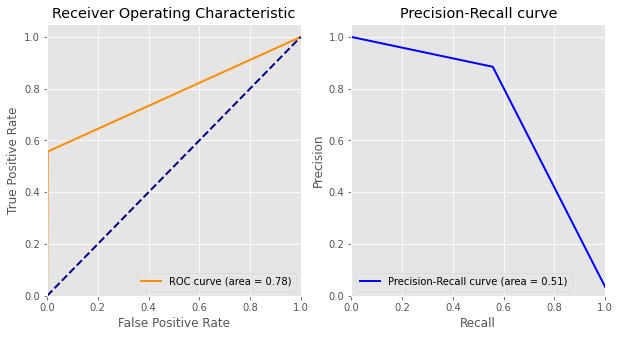

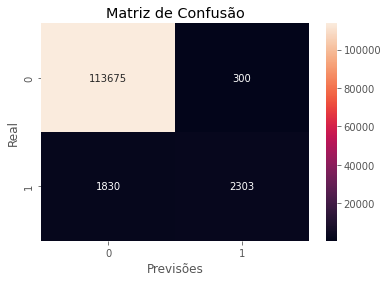

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.88      0.56      0.68      4133

    accuracy                           0.98    118108
   macro avg       0.93      0.78      0.84    118108
weighted avg       0.98      0.98      0.98    118108

CPU times: user 7min 14s, sys: 328 ms, total: 7min 14s
Wall time: 7min 14s


In [115]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [116]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_et.predict_proba(X_test[oversample_with_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 49.8 s, sys: 8 µs, total: 49.8 s
Wall time: 49.8 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.683788598574822  0.990718145372146
Threshold: 0.05  0.264448648841609   0.90103408692478
Threshold: 0.1   0.431695010278453   0.95856251958776
Threshold: 0.15  0.551596638655462   0.97621212931757
Threshold: 0.2   0.630646946372875  0.983776521696858
Threshold: 0.25  0.673556504156369  0.987215921588639
Threshold: 0.3   0.697054869852132   0.98912876645047
Threshold: 0.35  0.706156837329877  0.990078818035807
Threshold: 0.4   0.707177814029364  0.990588132482741
Threshold: 0.45  0.697047132311187  0.990688216710593
Threshold: 0.5   0.686826965629149  0.990746915275217
Threshold: 0.55  0.665035927228253  0.990460433220856
Threshold: 0.6   0.638924050632911   0.99007377248843
Threshold: 0.65  0.609180327868852  0.989640007648316
Threshold: 0.7   0.576851381121844  0.989158326639602
Threshold: 0.75    0.5363971233117   0.98853436869618

In [117]:
feature_importances = clf_et.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_smote_cols_100_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
77       P_emaildomain_gmail.com  0.045232567530826
90                         M4_M2  0.033778186036134
66                   ProductCD_C  0.033668928921951
93                          M6_F  0.027942527460104
94                          M6_T  0.024757108410514
92                          M5_T  0.024112113778218
91                          M5_F  0.019979069257191
2                          card2  0.017271043154635
0                 TransactionAmt  0.016344359115305
70                   ProductCD_W  0.016227278215245
1                          card1  0.015835028302791
96                          M8_F  0.015775195542362
13                           C14  0.015507047066551
67                   ProductCD_H  0.015434772412610
6                             C1  0.014687304519386
97                          M8_T  0.014644059798435
58                          V283  0.014143249632309
63                     _Weekdays  0.014108683848817
72              card4_mastercard  0.014061564322149
88                          M3_T  0.013718932213065
15                            D2  0.013694113297403
26                           V29  0.013626261527285
57                          V282  0.013543862789039
64                        _Hours  0.013501026073329
7                             C2  0.013416117762216
68                   ProductCD_R  0.013323919374007
89                         M4_M0  0.012837197301367
41                           V69  0.012595956235300
3                          card5  0.012296111402612
42                           V70  0.011999093629064
12                           C13  0.011907854419097
73                    card4_visa  0.011849738198597
87                          M3_F  0.011832241526249
78     P_emaildomain_hotmail.com  0.011766800814359
65                         _Days  0.011594077313422
11                           C11  0.011491116473584
14                            D1  0.011103281116436
53                           V96  0.010310183650401
47                           V84  0.009981739293318
4                          addr1  0.009846407401406
9                             C6  0.009726751904221
39                           V53  0.009693463496892
33                           V43  0.009538560835527
37                           V51  0.009339756989582
40                           V54  0.009289965950843
28                           V35  0.009151075719822
61                          V308  0.008961109518132
34                           V48  0.008719207711895
24                           V12  0.008648057715991
38                           V52  0.008593838195674
59                          V285  0.008558780557274
52                           V93  0.008492172448915
25                           V13  0.008490244778610
49                           V90  0.008285692251731
50                           V91  0.008082347813153
60                          V307  0.007965758746277
30                           V39  0.007761258023369
22                           V10  0.007686293331983
27                           V30  0.007525377644849
29                           V36  0.007362622647631
43                           V75  0.007330740708845
51                           V92  0.007329410809738
35                           V49  0.007297350741706
36                           V50  0.007162028070105
55                          V127  0.007039409795195
21                           D15  0.006974072767202
19                           D10  0.006916649327004
18                            D5  0.006876032464709
31                           V40  0.006656443271558
32                           V42  0.006539531757330
62                          V310  0.006495709658903
23                           V11  0.006302862554856
54                           V99  0.005934433658203
44                           V76  0.005925920901717
48                           V85  0.005823427132438
17                            D4  0.005809553910299
71                car

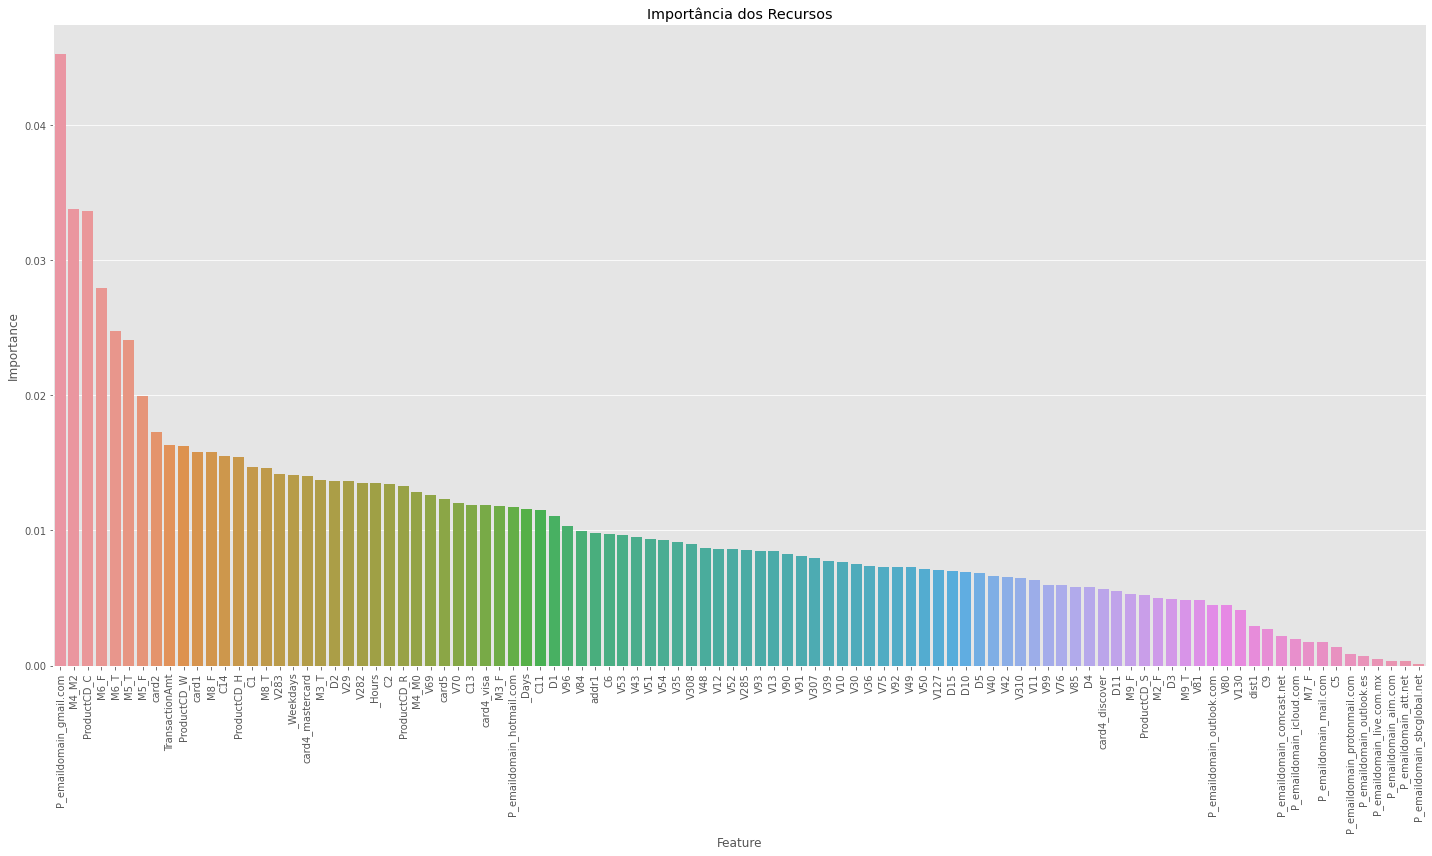

In [118]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.5003282994090611
F1-Score Negativo (Teste): 0.9798923717841446
F1-Score Positivo Médio (Validação Cruzada): 0.42734215994807495
F1-Score Positivo Fold 1: 0.4249726177437021
F1-Score Positivo Fold 2: 0.44394618834080724
F1-Score Positivo Fold 3: 0.45847176079734214
F1-Score Positivo Fold 4: 0.4333333333333333
F1-Score Positivo Fold 5: 0.44470046082949305
F1-Score Positivo Fold 6: 0.4021857923497268
F1-Score Positivo Fold 7: 0.4380069524913094
F1-Score Positivo Fold 8: 0.38768529076396807
F1-Score Positivo Fold 9: 0.42033898305084744
F1-Score Positivo Fold 10: 0.4197802197802198
F1-Score Negativo Médio (Validação Cruzada): 0.9775084579455517
F1-Score Negativo Fold 1: 0.9768814126557752
F1-Score Negativo Fold 2: 0.9781786185657722
F1-Score Negativo Fold 3: 0.978476165324178
F1-Score Negativo Fold 4: 0.9775547927119091
F1-Score Negativo Fold 5: 0.9788169113122968
F1-Score Negativo Fold 6: 0.9759105121768618
F1-Score Negativo Fold 7: 0.9786897491102421
F1-Score 

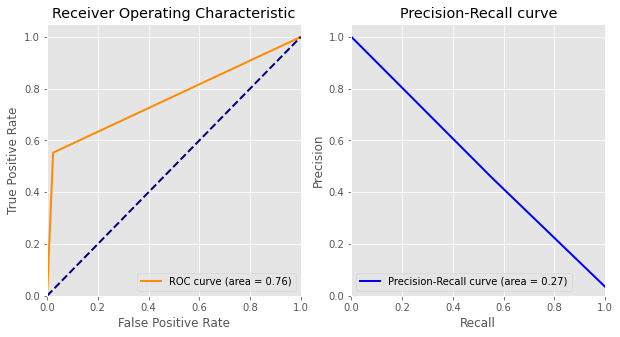

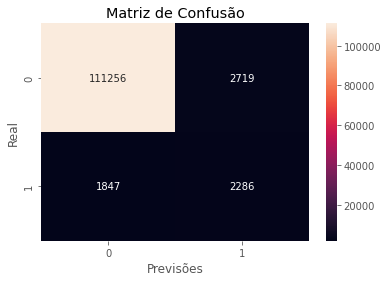

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    113975
           1       0.46      0.55      0.50      4133

    accuracy                           0.96    118108
   macro avg       0.72      0.76      0.74    118108
weighted avg       0.97      0.96      0.96    118108

CPU times: user 1min 32s, sys: 360 ms, total: 1min 32s
Wall time: 1min 32s


In [119]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [120]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_dt.predict_proba(X_test[oversample_with_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 1.22 s, sys: 5 µs, total: 1.22 s
Wall time: 1.22 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.500328299409061  0.979892371784145
Threshold: 0.05  0.500328299409061  0.979892371784145
Threshold: 0.1   0.500328299409061  0.979892371784145
Threshold: 0.15  0.500328299409061  0.979892371784145
Threshold: 0.2   0.500328299409061  0.979892371784145
Threshold: 0.25  0.500328299409061  0.979892371784145
Threshold: 0.3   0.500328299409061  0.979892371784145
Threshold: 0.35  0.500328299409061  0.979892371784145
Threshold: 0.4   0.500328299409061  0.979892371784145
Threshold: 0.45  0.500328299409061  0.979892371784145
Threshold: 0.5   0.500328299409061  0.979892371784145
Threshold: 0.55  0.500328299409061  0.979892371784145
Threshold: 0.6   0.500328299409061  0.979892371784145
Threshold: 0.65  0.500328299409061  0.979892371784145
Threshold: 0.7   0.500328299409061  0.979892371784145
Threshold: 0.75  0.500328299409061  0.979892371784145

In [121]:
feature_importances = clf_dt.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_smote_cols_100_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
46                           V81  0.187382412870481
6                             C1  0.135047055099817
61                          V308  0.098849154970096
13                           C14  0.086705357880765
58                          V283  0.040786221440370
49                           V90  0.035116509242249
91                          M5_F  0.032129530359040
16                            D3  0.023349369243095
2                          card2  0.019957493107069
12                           C13  0.019797412521766
1                          card1  0.019260602085022
34                           V48  0.018011072980392
0                 TransactionAmt  0.014475697444799
53                           V96  0.012418860825834
90                         M4_M2  0.011145461796462
4                          addr1  0.010802330058061
77       P_emaildomain_gmail.com  0.010675310568281
7                             C2  0.009820034810692
89                         M4_M0  0.008974173707189
9                             C6  0.008021103607920
92                          M5_T  0.007818089424641
3                          card5  0.006632213621360
65                         _Days  0.006487113821653
62                          V310  0.006042920311812
29                           V36  0.005993153887609
96                          M8_F  0.005944087784583
11                           C11  0.005866566491709
15                            D2  0.005850545403952
60                          V307  0.005703542449940
10                            C9  0.005297055794294
78     P_emaildomain_hotmail.com  0.005190310570740
14                            D1  0.005120337284325
57                          V282  0.004908502094617
64                        _Hours  0.004777721192455
21                           D15  0.004726325250223
5                          dist1  0.004606638745041
17                            D4  0.004482392069285
94                          M6_T  0.004410664780643
19                           D10  0.004259450627931
43                           V75  0.004165871100570
88                          M3_T  0.004110493177008
63                     _Weekdays  0.004090180224433
55                          V127  0.004056137235525
18                            D5  0.003894275575181
40                           V54  0.003779374371208
59                          V285  0.003432344122409
28                           V35  0.003253224331820
99                          M9_T  0.002922837981607
37                           V51  0.002865579719446
45                           V80  0.002658770778492
8                             C5  0.002641167133815
36                           V50  0.002559872874133
23                           V11  0.002559215430528
68                   ProductCD_R  0.002325274335494
50                           V91  0.002220050467753
54                           V99  0.002142942890738
93                          M6_F  0.002089578663424
67                   ProductCD_H  0.001854393419473
56                          V130  0.001785968450414
39                           V53  0.001731089587382
72              card4_mastercard  0.001647626476304
20                           D11  0.001627235622077
71                card4_discover  0.001534035369000
73                    card4_visa  0.001437818074370
42                           V70  0.001425293989251
47                           V84  0.001349811586955
82     P_emaildomain_outlook.com  0.001337617221854
26                           V29  0.001328873296324
86                          M2_F  0.001320842083584
44                           V76  0.001304921639184
38                           V52  0.001241542079291
48                           V85  0.001240607606140
25                           V13  0.001171747162588
97                          M8_T  0.001127723863259
81        P_emaildomain_mail.com  0.001026531270929
87                          M3_F  0.000929941432608
22                   

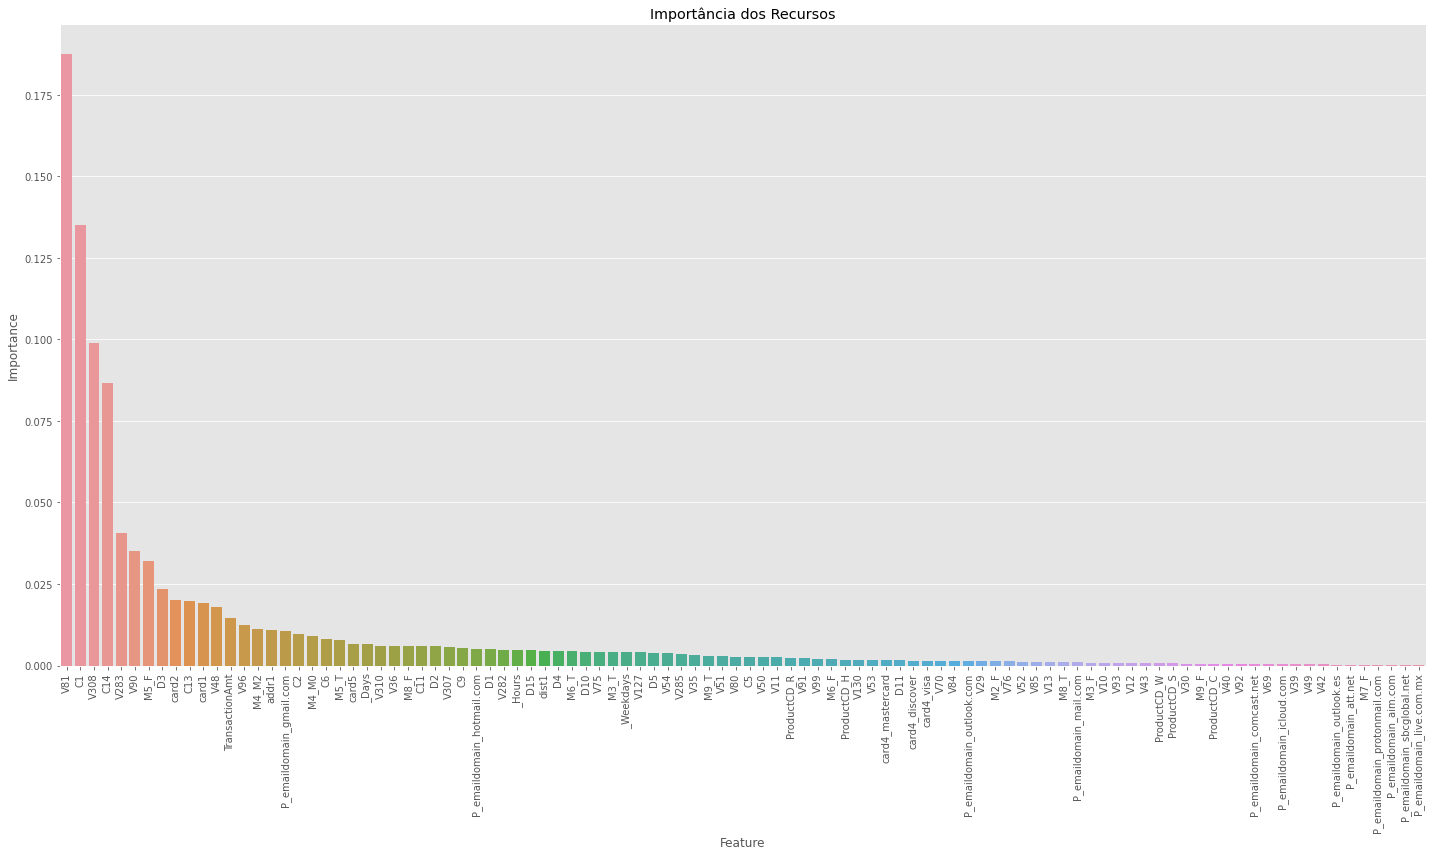

In [122]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

0:	learn: 0.6196224	total: 73.4ms	remaining: 294ms
1:	learn: 0.5483330	total: 143ms	remaining: 215ms
2:	learn: 0.4992814	total: 212ms	remaining: 141ms
3:	learn: 0.4665184	total: 279ms	remaining: 69.8ms
4:	learn: 0.4394360	total: 346ms	remaining: 0us
0:	learn: 0.5489121	total: 7.95ms	remaining: 31.8ms
1:	learn: 0.4282033	total: 16.3ms	remaining: 24.5ms
2:	learn: 0.3481399	total: 23.8ms	remaining: 15.9ms
3:	learn: 0.2892116	total: 31.4ms	remaining: 7.85ms
4:	learn: 0.2428837	total: 39.6ms	remaining: 0us
0:	learn: 0.5488396	total: 16.4ms	remaining: 65.7ms
1:	learn: 0.4281673	total: 27.5ms	remaining: 41.3ms
2:	learn: 0.3483177	total: 35.7ms	remaining: 23.8ms
3:	learn: 0.2880872	total: 43.7ms	remaining: 10.9ms
4:	learn: 0.2419084	total: 51.8ms	remaining: 0us
0:	learn: 0.5486576	total: 7.08ms	remaining: 28.3ms
1:	learn: 0.4280185	total: 15ms	remaining: 22.5ms
2:	learn: 0.3481685	total: 22.5ms	remaining: 15ms
3:	learn: 0.2892096	total: 30.2ms	remaining: 7.55ms
4:	learn: 0.2427371	total: 38.2m

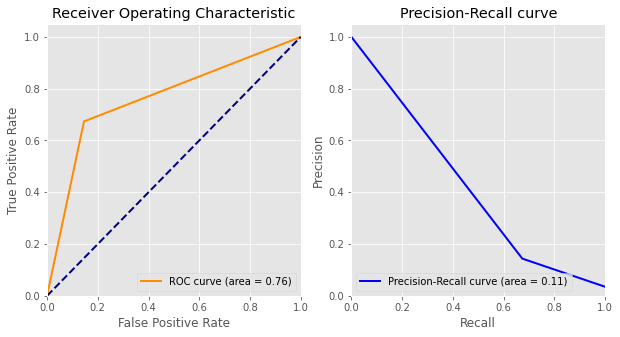

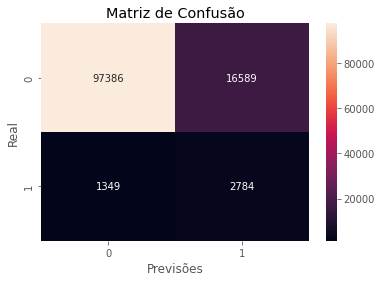

              precision    recall  f1-score   support

           0       0.99      0.85      0.92    113975
           1       0.14      0.67      0.24      4133

    accuracy                           0.85    118108
   macro avg       0.57      0.76      0.58    118108
weighted avg       0.96      0.85      0.89    118108

CPU times: user 56 s, sys: 824 ms, total: 56.8 s
Wall time: 37.7 s


In [123]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [124]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_cb.predict_proba(X_test[oversample_with_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 16.3 s, sys: 28 ms, total: 16.3 s
Wall time: 15.9 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.236875691312856  0.915669221005124
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067700224520231  0.003520818371315
Threshold: 0.25  0.076639953069856  0.252346257862358
Threshold: 0.3   0.101030765599182  0.571460721921456
Threshold: 0.35  0.134941044250148  0.752812719424774
Threshold: 0.4    0.15947967789584  0.818370898157968
Threshold: 0.45  0.189061075660893  0.868729894838322
Threshold: 0.5   0.236875691312856  0.915669221005124
Threshold: 0.55  0.300667998071758  0.954193824849455
Threshold: 0.6   0.347895471773389  0.971095097042309
Threshold: 0.65  0.362910270809934  0.977629566657757
Threshold: 0.7   0.263450834879406  0.982800897645846
Threshold: 0.75  0.210766992309291  0.983591538644368

In [125]:
feature_importances = clf_cb.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_smote_cols_100_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature          Importance
6                             C1  28.909618976476931
35                           V49  15.795484487860717
34                           V48  14.063861297457789
13                           C14   9.625996018416588
61                          V308   7.035156410142808
45                           V80   4.552464307762763
11                           C11   4.195788542959159
26                           V29   3.886304881885690
66                   ProductCD_C   2.580873566972568
48                           V85   2.453474153311553
40                           V54   1.738611085717698
49                           V90   1.571227279483736
42                           V70   1.091480553130093
16                            D3   1.087340035919270
57                          V282   0.713120312670315
58                          V283   0.699198089832339
68                   ProductCD_R   0.000000000000000
71                card4_discover   0.000000000000000
72              card4_mastercard   0.000000000000000
70                   ProductCD_W   0.000000000000000
69                   ProductCD_S   0.000000000000000
65                         _Days   0.000000000000000
67                   ProductCD_H   0.000000000000000
74         P_emaildomain_aim.com   0.000000000000000
64                        _Hours   0.000000000000000
63                     _Weekdays   0.000000000000000
62                          V310   0.000000000000000
60                          V307   0.000000000000000
59                          V285   0.000000000000000
73                    card4_visa   0.000000000000000
0                 TransactionAmt   0.000000000000000
75         P_emaildomain_att.net   0.000000000000000
88                          M3_T   0.000000000000000
98                          M9_F   0.000000000000000
97                          M8_T   0.000000000000000
96                          M8_F   0.000000000000000
95                          M7_F   0.000000000000000
94                          M6_T   0.000000000000000
93                          M6_F   0.000000000000000
92                          M5_T   0.000000000000000
91                          M5_F   0.000000000000000
90                         M4_M2   0.000000000000000
89                         M4_M0   0.000000000000000
87                          M3_F   0.000000000000000
76     P_emaildomain_comcast.net   0.000000000000000
86                          M2_F   0.000000000000000
85   P_emaildomain_sbcglobal.net   0.000000000000000
84  P_emaildomain_protonmail.com   0.000000000000000
83      P_emaildomain_outlook.es   0.000000000000000
82     P_emaildomain_outlook.com   0.000000000000000
81        P_emaildomain_mail.com   0.000000000000000
80     P_emaildomain_live.com.mx   0.000000000000000
79      P_emaildomain_icloud.com   0.000000000000000
78     P_emaildomain_hotmail.com   0.000000000000000
56                          V130   0.000000000000000
77       P_emaildomain_gmail.com   0.000000000000000
50                           V91   0.000000000000000
55                          V127   0.000000000000000
14                            D1   0.000000000000000
23                           V11   0.000000000000000
22                           V10   0.000000000000000
21                           D15   0.000000000000000
20                           D11   0.000000000000000
19                           D10   0.000000000000000
18                            D5   0.000000000000000
17                            D4   0.000000000000000
15                            D2   0.000000000000000
12                           C13   0.000000000000000
25                           V13   0.000000000000000
10                            C9   0.000000000000000
9                             C6   0.000000000000000
8                             C5   0.000000000000000
7                             C2   0.000000000000000
5                          dist1   0.000000000000000
4                          addr1   0.0000000000000

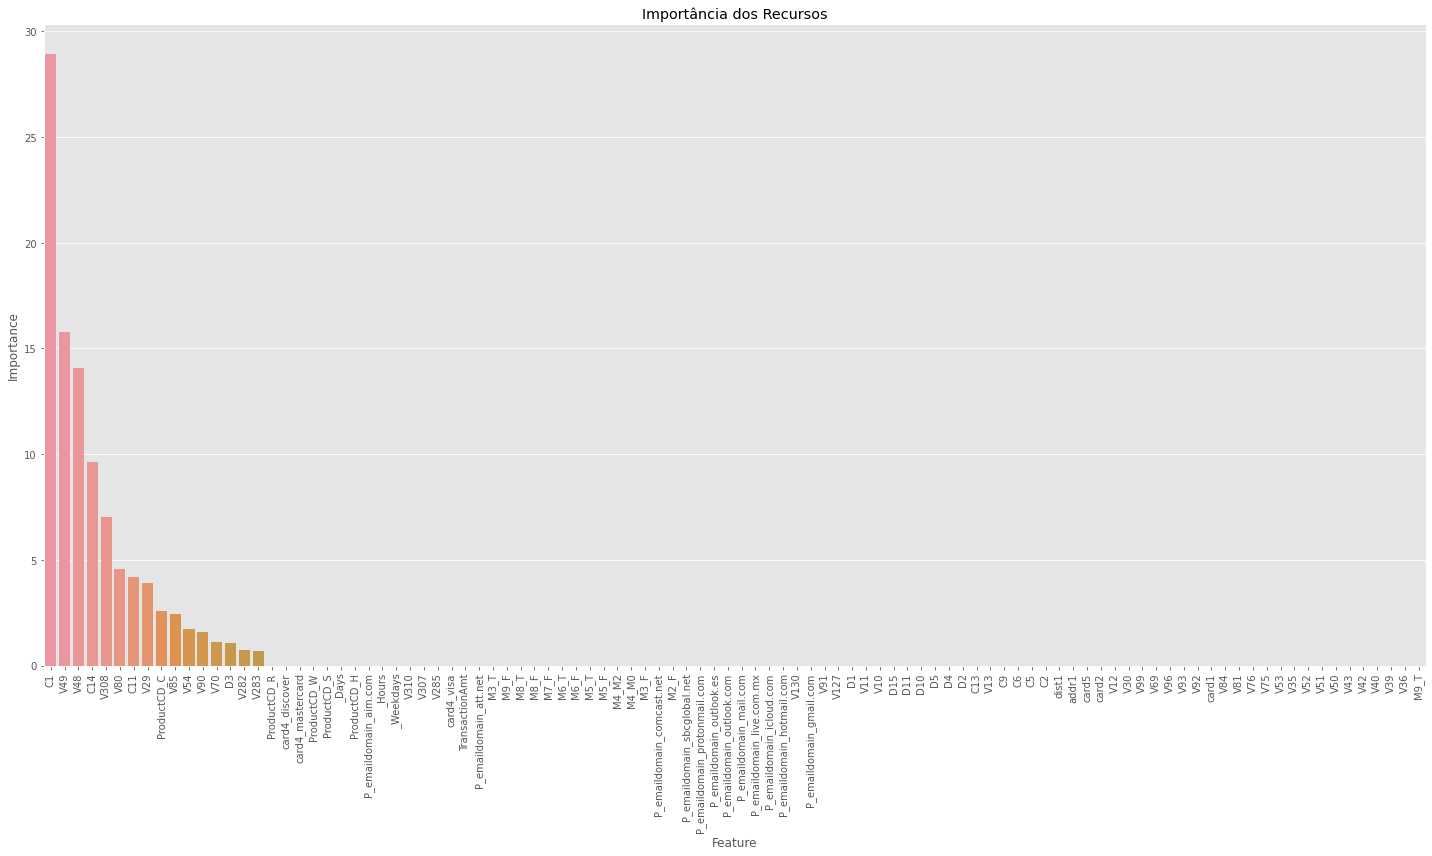

In [126]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.31920499887073706
F1-Score Negativo (Teste): 0.9594362431762009
F1-Score Positivo Médio (Validação Cruzada): 0.2857093267224791
F1-Score Positivo Fold 1: 0.3660377358490566
F1-Score Positivo Fold 2: 0.3230769230769231
F1-Score Positivo Fold 3: 0.4037037037037037
F1-Score Positivo Fold 4: 0.3897058823529412
F1-Score Positivo Fold 5: 0.3365200764818356
F1-Score Positivo Fold 6: 0.34651600753295664
F1-Score Positivo Fold 7: 0.09746588693957114
F1-Score Positivo Fold 8: 0.2613861386138614
F1-Score Positivo Fold 9: 0.22672064777327935
F1-Score Positivo Fold 10: 0.10596026490066224
F1-Score Negativo Médio (Validação Cruzada): 0.9841655912304764
F1-Score Negativo Fold 1: 0.985449506322536
F1-Score Negativo Fold 2: 0.9847632239632932
F1-Score Negativo Fold 3: 0.9860497357248073
F1-Score Negativo Fold 4: 0.9856140046797816
F1-Score Negativo Fold 5: 0.9849777046625394
F1-Score Negativo Fold 6: 0.9849725001082673
F1-Score Negativo Fold 7: 0.9799645159894415
F1-Score N

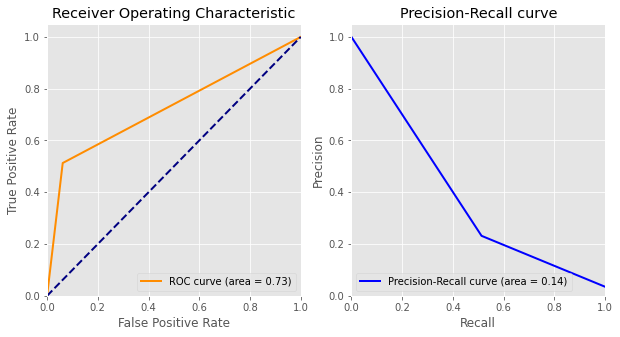

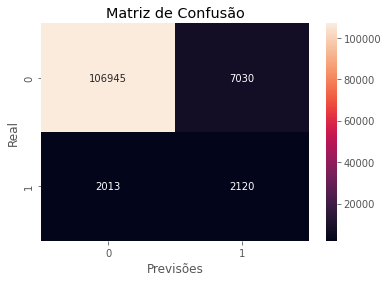

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    113975
           1       0.23      0.51      0.32      4133

    accuracy                           0.92    118108
   macro avg       0.61      0.73      0.64    118108
weighted avg       0.96      0.92      0.94    118108

CPU times: user 7min 29s, sys: 352 ms, total: 7min 30s
Wall time: 7min 29s


In [127]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [128]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_gbc.predict_proba(X_test[oversample_with_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2.72 s, sys: 3 µs, total: 2.72 s
Wall time: 2.72 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.319204998870737  0.959436243176201
Threshold: 0.05  0.098995190991907  0.566510957143305
Threshold: 0.1    0.12889599059636  0.739069918412931
Threshold: 0.15  0.153908157701335  0.816069265854099
Threshold: 0.2   0.180759749324304  0.863819261702222
Threshold: 0.25  0.206746147135795  0.895430849432689
Threshold: 0.3   0.228469205213391  0.914853011685736
Threshold: 0.35  0.255061952251436  0.931642340152152
Threshold: 0.4   0.275195582144501  0.942421583680632
Threshold: 0.45  0.296860511326003  0.951989435505024
Threshold: 0.5   0.319204998870737  0.959436243176201
Threshold: 0.55  0.337199385979874  0.965379304200633
Threshold: 0.6   0.351359139371818  0.970093664887846
Threshold: 0.65  0.360129310344828  0.973834032502556
Threshold: 0.7   0.364455264759586  0.977100977627291
Threshold: 0.75  0.357750342935528  0.979547976201917

In [129]:
feature_importances = clf_gbc.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_smote_cols_100_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
46                           V81  0.258973734139700
61                          V308  0.119528681136566
13                           C14  0.117274620142265
11                           C11  0.085610984157586
35                           V49  0.073140149794031
77       P_emaildomain_gmail.com  0.043269306296529
6                             C1  0.026038214521339
53                           V96  0.025576238621090
92                          M5_T  0.022688733995899
23                           V11  0.021357757662272
57                          V282  0.019583835061265
16                            D3  0.019295057320054
64                        _Hours  0.013316908869144
63                     _Weekdays  0.012928430341614
40                           V54  0.011695872868970
0                 TransactionAmt  0.011455165379570
9                             C6  0.009676566957057
38                           V52  0.009095061118411
91                          M5_F  0.008392524976555
12                           C13  0.007502217677300
88                          M3_T  0.006473841709480
87                          M3_F  0.005775951384594
22                           V10  0.004676579986779
73                    card4_visa  0.004552297867893
10                            C9  0.004124483600781
39                           V53  0.003604012962168
55                          V127  0.003560729137766
58                          V283  0.003390557744616
98                          M9_F  0.003262854454124
93                          M6_F  0.003211651901757
94                          M6_T  0.003180232832799
28                           V35  0.003066878297129
90                         M4_M2  0.003042811449410
71                card4_discover  0.002956391586835
78     P_emaildomain_hotmail.com  0.002757692878200
24                           V12  0.002242246118063
99                          M9_T  0.002146759655375
33                           V43  0.002129300483470
19                           D10  0.002085516769110
56                          V130  0.001998728398669
89                         M4_M0  0.001767172220899
72              card4_mastercard  0.001695402836144
1                          card1  0.001574497026933
59                          V285  0.001572256957875
97                          M8_T  0.001382351656066
36                           V50  0.001328288946640
2                          card2  0.001283288545898
65                         _Days  0.001220485016454
54                           V99  0.001207717527257
82     P_emaildomain_outlook.com  0.000884108106240
7                             C2  0.000756703079540
96                          M8_F  0.000688147823818
81        P_emaildomain_mail.com  0.000000000000000
74         P_emaildomain_aim.com  0.000000000000000
75         P_emaildomain_att.net  0.000000000000000
76     P_emaildomain_comcast.net  0.000000000000000
18                            D5  0.000000000000000
95                          M7_F  0.000000000000000
17                            D4  0.000000000000000
79      P_emaildomain_icloud.com  0.000000000000000
80     P_emaildomain_live.com.mx  0.000000000000000
8                             C5  0.000000000000000
3                          card5  0.000000000000000
83      P_emaildomain_outlook.es  0.000000000000000
84  P_emaildomain_protonmail.com  0.000000000000000
4                          addr1  0.000000000000000
85   P_emaildomain_sbcglobal.net  0.000000000000000
5                          dist1  0.000000000000000
86                          M2_F  0.000000000000000
15                            D2  0.000000000000000
14                            D1  0.000000000000000
37                           V51  0.000000000000000
68                   ProductCD_R  0.000000000000000
20                           D11  0.000000000000000
52                           V93  0.000000000000000
34                           V48  0.000000000000000
41                   

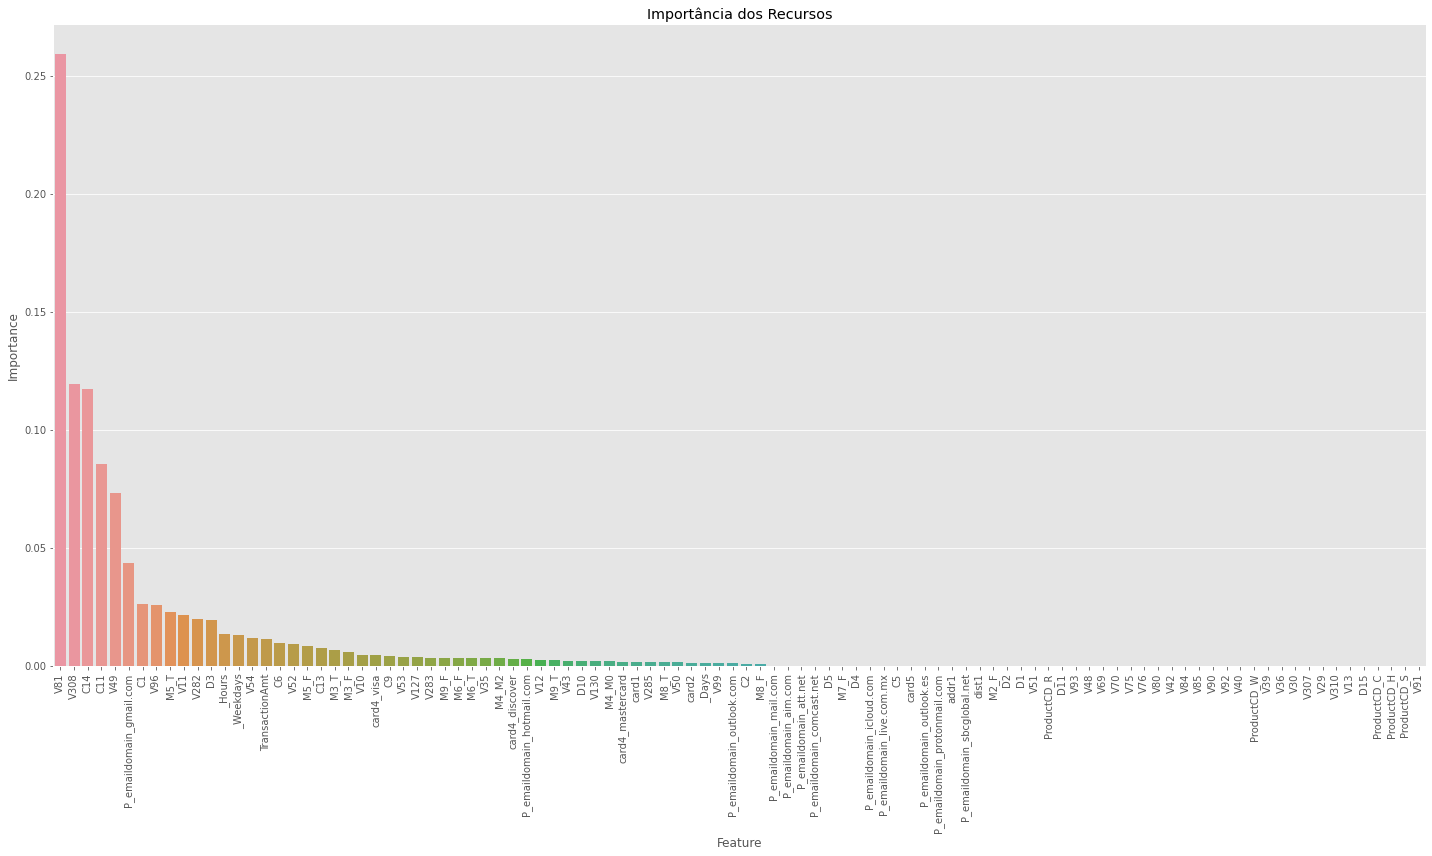

In [130]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.30492834673191194
F1-Score Negativo (Teste): 0.9551937488452578
F1-Score Positivo Médio (Validação Cruzada): 0.33560274126687817
F1-Score Positivo Fold 1: 0.39325842696629215
F1-Score Positivo Fold 2: 0.3522727272727273
F1-Score Positivo Fold 3: 0.3403441682600382
F1-Score Positivo Fold 4: 0.32
F1-Score Positivo Fold 5: 0.3474903474903475
F1-Score Positivo Fold 6: 0.3733826247689464
F1-Score Positivo Fold 7: 0.34615384615384615
F1-Score Positivo Fold 8: 0.26719056974459726
F1-Score Positivo Fold 9: 0.29457364341085274
F1-Score Positivo Fold 10: 0.3213610586011342
F1-Score Negativo Médio (Validação Cruzada): 0.9849291048627661
F1-Score Negativo Fold 1: 0.9859667359667359
F1-Score Negativo Fold 2: 0.9851909586905689
F1-Score Negativo Fold 3: 0.9850642884973376
F1-Score Negativo Fold 4: 0.9845434472009351
F1-Score Negativo Fold 5: 0.9853704986149584
F1-Score Negativo Fold 6: 0.9853125947749231
F1-Score Negativo Fold 7: 0.985282659509999
F1-Score Negativo Fold 

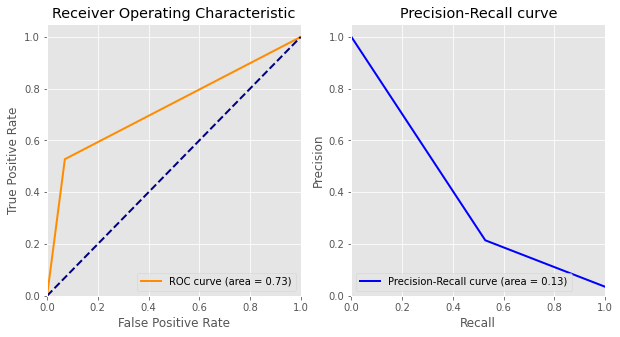

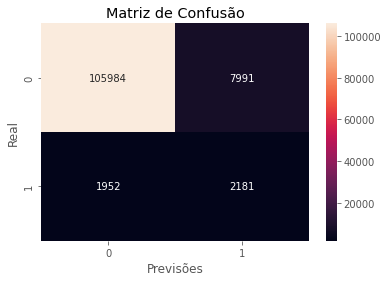

              precision    recall  f1-score   support

           0       0.98      0.93      0.96    113975
           1       0.21      0.53      0.30      4133

    accuracy                           0.92    118108
   macro avg       0.60      0.73      0.63    118108
weighted avg       0.96      0.92      0.93    118108

CPU times: user 8min 56s, sys: 5.11 s, total: 9min 1s
Wall time: 9min


In [131]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [132]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_ada.predict_proba(X_test[oversample_with_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 24.7 s, sys: 108 ms, total: 24.8 s
Wall time: 24.8 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.304928346731912  0.955193748845258
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.067620520120091                0.0
Threshold: 0.3   0.067620520120091                0.0
Threshold: 0.35  0.067620520120091                0.0
Threshold: 0.4   0.067620520120091                0.0
Threshold: 0.45  0.067620520120091                0.0
Threshold: 0.5   0.304928346731912  0.955193748845258
Threshold: 0.55                0.0  0.982191715894745
Threshold: 0.6                 0.0  0.982191715894745
Threshold: 0.65                0.0  0.982191715894745
Threshold: 0.7                 0.0  0.982191715894745
Threshold: 0.75                0.0  0.982191715894745

In [133]:
feature_importances = clf_ada.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_smote_cols_100_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature  Importance
6                             C1        0.06
53                           V96        0.06
16                            D3        0.05
13                           C14        0.05
0                 TransactionAmt        0.03
64                        _Hours        0.03
97                          M8_T        0.03
96                          M8_F        0.03
58                          V283        0.03
94                          M6_T        0.03
93                          M6_F        0.03
11                           C11        0.03
55                          V127        0.03
35                           V49        0.02
72              card4_mastercard        0.02
23                           V11        0.02
73                    card4_visa        0.02
87                          M3_F        0.02
90                         M4_M2        0.02
38                           V52        0.02
91                          M5_F        0.02
12                           C13        0.02
92                          M5_T        0.02
9                             C6        0.02
5                          dist1        0.02
1                          card1        0.02
59                          V285        0.02
61                          V308        0.01
56                          V130        0.01
57                          V282        0.01
82     P_emaildomain_outlook.com        0.01
63                     _Weekdays        0.01
65                         _Days        0.01
71                card4_discover        0.01
77       P_emaildomain_gmail.com        0.01
78     P_emaildomain_hotmail.com        0.01
46                           V81        0.01
88                          M3_T        0.01
89                         M4_M0        0.01
98                          M9_F        0.01
47                           V84        0.01
99                          M9_T        0.01
26                           V29        0.01
10                            C9        0.01
28                           V35        0.01
19                           D10        0.01
24                           V12        0.01
34                           V48        0.01
33                           V43        0.01
40                           V54        0.01
7                             C2        0.00
83      P_emaildomain_outlook.es        0.00
75         P_emaildomain_att.net        0.00
76     P_emaildomain_comcast.net        0.00
22                           V10        0.00
21                           D15        0.00
79      P_emaildomain_icloud.com        0.00
80     P_emaildomain_live.com.mx        0.00
81        P_emaildomain_mail.com        0.00
2                          card2        0.00
20                           D11        0.00
84  P_emaildomain_protonmail.com        0.00
8                             C5        0.00
85   P_emaildomain_sbcglobal.net        0.00
86                          M2_F        0.00
3                          card5        0.00
4                          addr1        0.00
18                            D5        0.00
17                            D4        0.00
15                            D2        0.00
14                            D1        0.00
95                          M7_F        0.00
74         P_emaildomain_aim.com        0.00
42                           V70        0.00
25                           V13        0.00
43                           V75        0.00
44                           V76        0.00
45                           V80        0.00
41                           V69        0.00
48                           V85        0.00
49                           V90        0.00
39                           V53        0.00
51                           V92        0.00
52                           V93        0.00
37                           V51        0.00
54                           V99        0.00
36                           V50        0.00
32                           V42        0.00
31                  

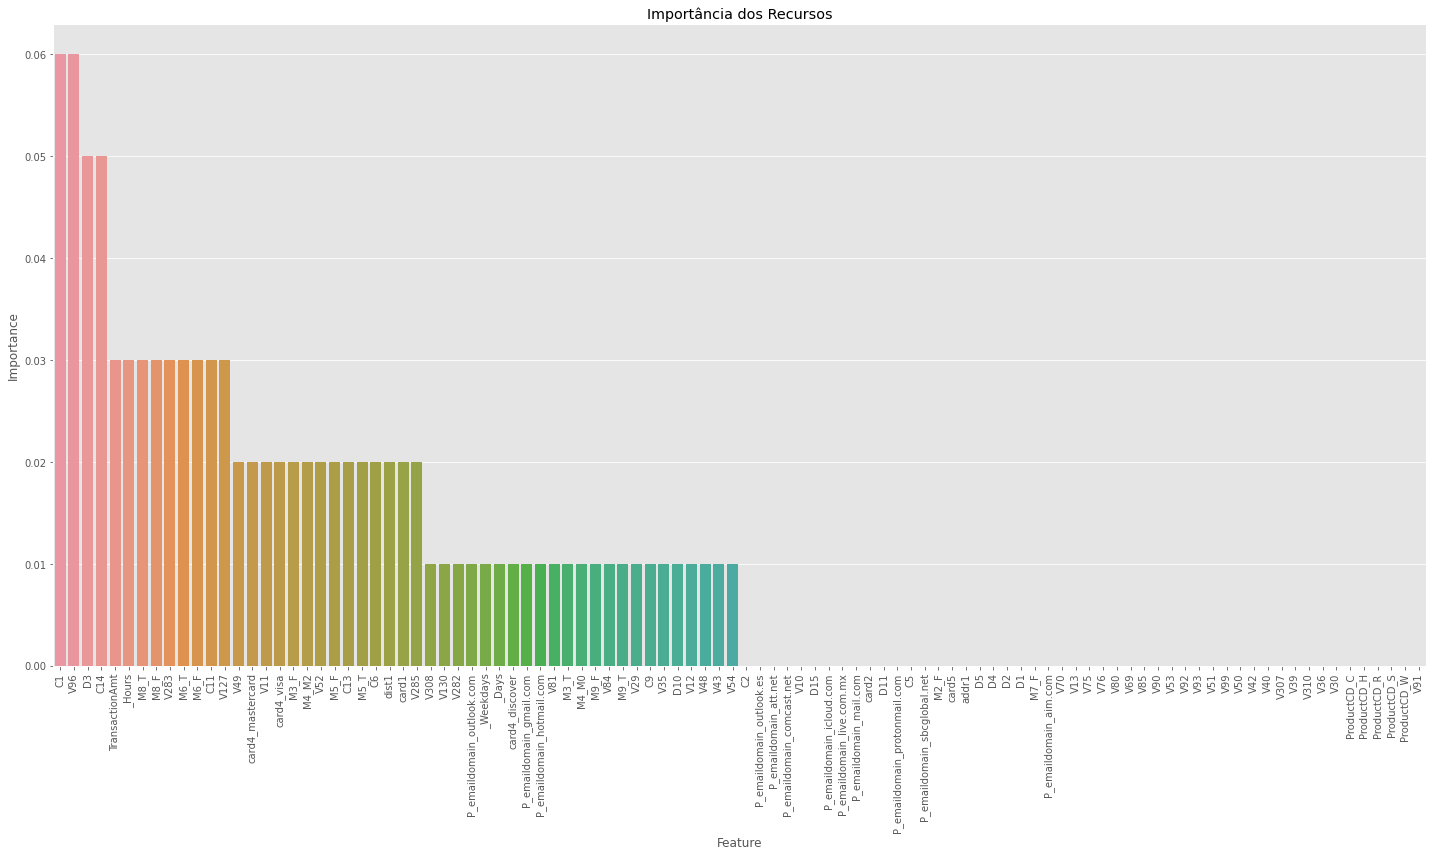

In [134]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.3246813288422165
F1-Score Negativo (Teste): 0.9537487278073052
F1-Score Positivo Médio (Validação Cruzada): 0.26579247404413464
F1-Score Positivo Fold 1: 0.2636203866432338
F1-Score Positivo Fold 2: 0.2491349480968858
F1-Score Positivo Fold 3: 0.2539130434782609
F1-Score Positivo Fold 4: 0.23633156966490299
F1-Score Positivo Fold 5: 0.2901554404145078
F1-Score Positivo Fold 6: 0.24834437086092717
F1-Score Positivo Fold 7: 0.2694300518134715
F1-Score Positivo Fold 8: 0.25874125874125875
F1-Score Positivo Fold 9: 0.2852233676975945
F1-Score Positivo Fold 10: 0.30303030303030304
F1-Score Negativo Médio (Validação Cruzada): 0.9815247153164739
F1-Score Negativo Fold 1: 0.9818244913894071
F1-Score Negativo Fold 2: 0.9811664641555284
F1-Score Negativo Fold 3: 0.981385863669892
F1-Score Negativo Fold 4: 0.9812188245499891
F1-Score Negativo Fold 5: 0.9821637807577138
F1-Score Negativo Fold 6: 0.9802763055000434
F1-Score Negativo Fold 7: 0.9816430152323916
F1-Score N

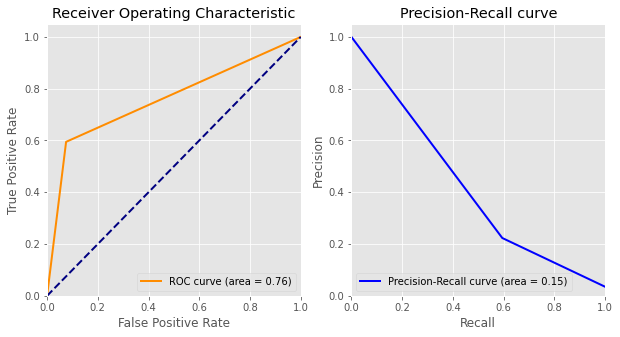

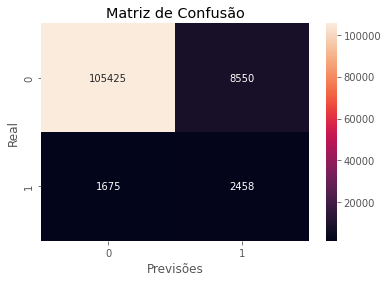

              precision    recall  f1-score   support

           0       0.98      0.92      0.95    113975
           1       0.22      0.59      0.32      4133

    accuracy                           0.91    118108
   macro avg       0.60      0.76      0.64    118108
weighted avg       0.96      0.91      0.93    118108

CPU times: user 27min 5s, sys: 924 ms, total: 27min 6s
Wall time: 2min 26s


In [135]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_smote[oversample_with_smote_cols_100_chi2], y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [136]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_knn.predict_proba(X_test[oversample_with_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 5h 37min 47s, sys: 1.15 s, total: 5h 37min 48s
Wall time: 28min 28s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.324681328842217  0.953748727807305
Threshold: 0.05  0.268039215686275  0.930811431960559
Threshold: 0.1   0.268039215686275  0.930811431960559
Threshold: 0.15  0.268039215686275  0.930811431960559
Threshold: 0.2   0.268039215686275  0.930811431960559
Threshold: 0.25  0.268039215686275  0.930811431960559
Threshold: 0.3   0.268039215686275  0.930811431960559
Threshold: 0.35  0.324681328842217  0.953748727807305
Threshold: 0.4   0.324681328842217  0.953748727807305
Threshold: 0.45  0.324681328842217  0.953748727807305
Threshold: 0.5   0.324681328842217  0.953748727807305
Threshold: 0.55  0.324681328842217  0.953748727807305
Threshold: 0.6   0.324681328842217  0.953748727807305
Threshold: 0.65  0.324681328842217  0.953748727807305
Threshold: 0.7   0.402910234981811  0.973133668074941
Threshold: 0.75  0.402910234981811  0.973133668074941

### Todas as colunas

In [137]:
#reinicializando os classificadores

clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)

F1-Score Positivo (Teste): 0.6750037667620913
F1-Score Negativo (Teste): 0.9906045413561345
F1-Score Positivo Médio (Validação Cruzada): 0.4930525441182958
F1-Score Positivo Fold 1: 0.5147826086956522
F1-Score Positivo Fold 2: 0.4676258992805755
F1-Score Positivo Fold 3: 0.493006993006993
F1-Score Positivo Fold 4: 0.5165794066317627
F1-Score Positivo Fold 5: 0.5395189003436427
F1-Score Positivo Fold 6: 0.49391304347826087
F1-Score Positivo Fold 7: 0.48865619546247824
F1-Score Positivo Fold 8: 0.4593128390596745
F1-Score Positivo Fold 9: 0.4767025089605734
F1-Score Positivo Fold 10: 0.48042704626334526
F1-Score Negativo Médio (Validação Cruzada): 0.9875205622016846
F1-Score Negativo Fold 1: 0.9878943029461535
F1-Score Negativo Fold 2: 0.9871672591693402
F1-Score Negativo Fold 3: 0.9874186550976138
F1-Score Negativo Fold 4: 0.9879821250379627
F1-Score Negativo Fold 5: 0.9883680555555555
F1-Score Negativo Fold 6: 0.9873736278040526
F1-Score Negativo Fold 7: 0.987287951754957
F1-Score Nega

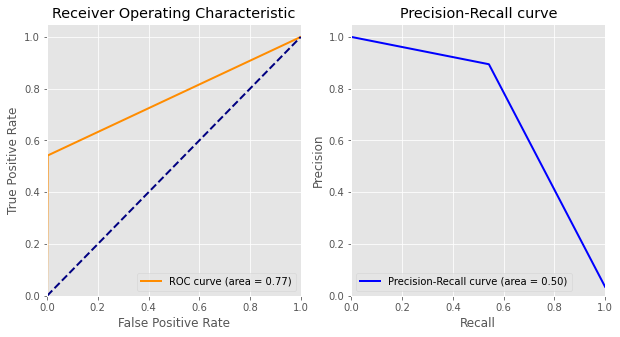

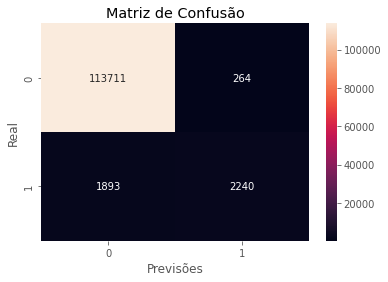

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.89      0.54      0.68      4133

    accuracy                           0.98    118108
   macro avg       0.94      0.77      0.83    118108
weighted avg       0.98      0.98      0.98    118108

CPU times: user 8min 36s, sys: 352 ms, total: 8min 36s
Wall time: 8min 36s


In [138]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [139]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_et.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 53.1 s, sys: 9 µs, total: 53.1 s
Wall time: 53.1 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.675003766762091  0.990604541356135
Threshold: 0.05  0.271667773106144  0.905558053007623
Threshold: 0.1   0.442991732359162  0.960605222720329
Threshold: 0.15  0.565966241818808  0.977560506491425
Threshold: 0.2    0.64401894173358  0.984733026639941
Threshold: 0.25  0.683997689196996  0.987981244589363
Threshold: 0.3   0.708504544888557  0.989740780507045
Threshold: 0.35   0.71462388216728  0.990507934841566
Threshold: 0.4   0.707976814794369  0.990758614665677
Threshold: 0.45  0.697017720789512  0.990827608766765
Threshold: 0.5    0.67941440095608  0.990650133756241
Threshold: 0.55  0.659133126934984  0.990415919497206
Threshold: 0.6   0.632134292565947  0.989993955496802
Threshold: 0.65   0.59973492379059   0.98950386653923
Threshold: 0.7   0.559807791316286  0.988866655960137
Threshold: 0.75  0.522324592487597  0.988307340006592

In [140]:
feature_importances = clf_et.feature_importances_

df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
101         P_emaildomain_gmail.com  0.047850098816486
152                           M4_M2  0.030930370213672
155                            M6_F  0.028689090800970
76                      ProductCD_C  0.027734409165166
156                            M6_T  0.022642930448220
154                            M5_T  0.022241503266376
80                      ProductCD_W  0.017043099041214
138         P_emaildomain_yahoo.com  0.016619039817943
153                            M5_F  0.016174366469425
2                             card2  0.014665757622277
6                                C1  0.014267631674927
0                    TransactionAmt  0.013839602313863
13                              C14  0.013769663986621
77                      ProductCD_H  0.013517683059351
68                             V283  0.013505547231746
159                            M8_F  0.013485065094913
1                             card1  0.013483620669755
150                           M4_M0  0.012675725832661
45                              V50  0.012662511494651
104       P_emaildomain_hotmail.com  0.012546609060189
15                               D2  0.012324116575368
83                 card4_mastercard  0.012302562458096
7                                C2  0.012247814339430
78                      ProductCD_R  0.012053840326024
46                              V51  0.011633972093166
74                           _Hours  0.011540623031827
84                       card4_visa  0.011367388171397
73                        _Weekdays  0.011134479699164
50                              V69  0.011115116838556
67                             V282  0.011049592078888
12                              C13  0.010927780089497
51                              V70  0.010872629980188
58                              V90  0.010574252946746
66                             V280  0.010539237776673
11                              C11  0.010499143050742
3                             card5  0.010477557412124
149                            M3_T  0.010415892542082
75                            _Days  0.010206062667896
160                            M8_T  0.010158127568603
148                            M3_F  0.009698462643829
35                              V29  0.009602908098125
48                              V53  0.009566526303396
14                               D1  0.009069325358819
9                                C6  0.008853781096100
62                              V96  0.008849682388522
47                              V52  0.008812666883661
4                             addr1  0.008807852665637
59                              V91  0.008335274343730
44                              V49  0.008249858271812
52                              V75  0.008161805223816
33                              V12  0.008047607327482
86      P_emaildomain_anonymous.com  0.007993016280241
34                              V13  0.007965112903094
43                              V48  0.007895946037602
151                           M4_M1  0.007712793198402
61                              V93  0.007667770966125
41                              V42  0.007646734288150
53                              V76  0.007614622093601
49                              V54  0.007535619827734
71                             V308  0.007163233993361
69                             V285  0.007125423124996
70                             V307  0.007094002802662
37                              V35  0.007034496290634
31                              V10  0.006789525961801
39                              V39  0.006731225857240
64                             V127  0.006728155593058
22                               V1  0.006426113452049
42                              V43  0.006400008092551
19                              D10  0.006251383499767
18                               D5  0.006204125017769
38                              V36  0.006021320494049
56                              V84  0.005876480336809
40           

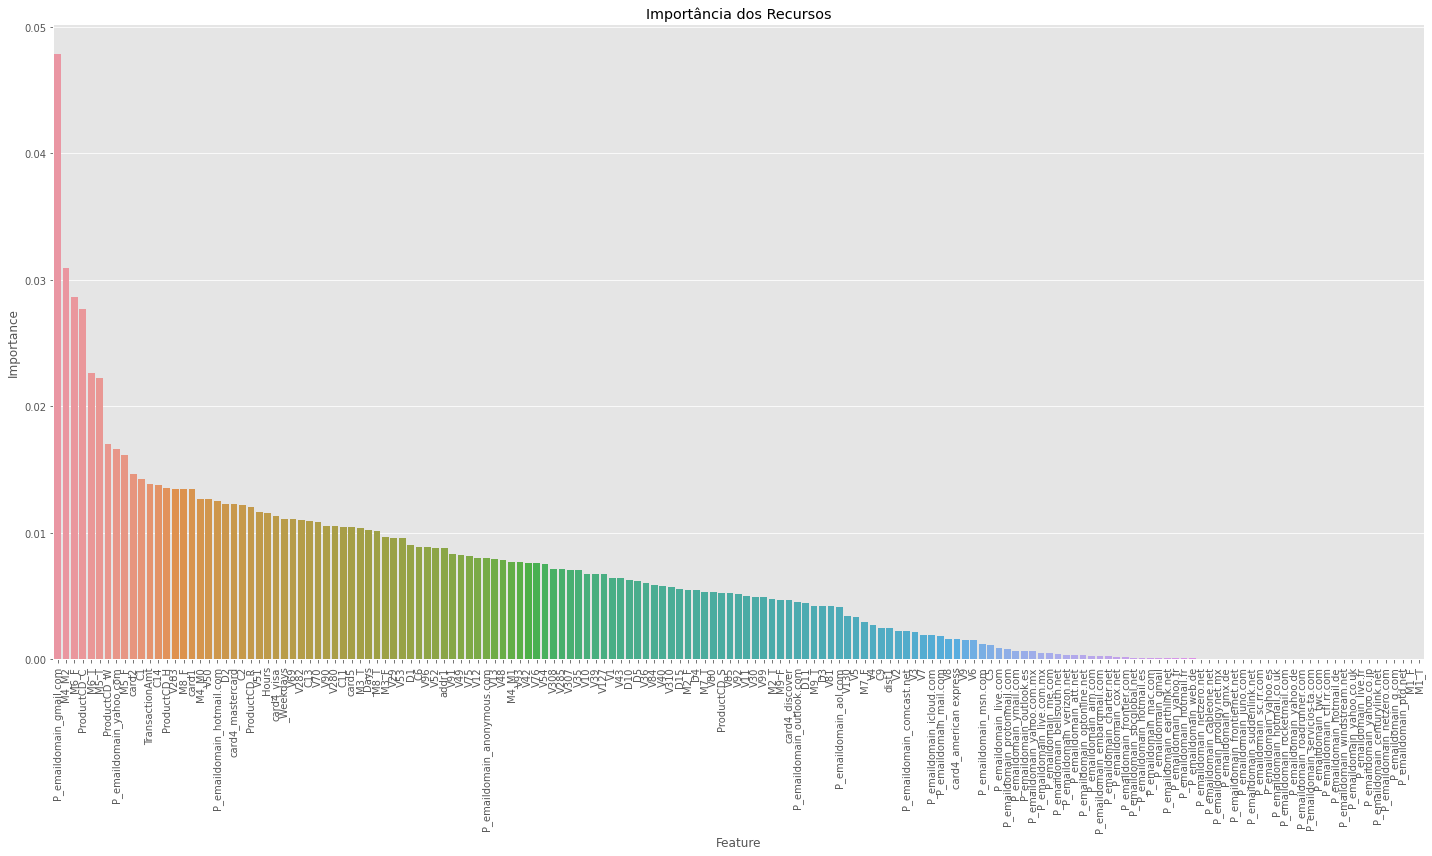

In [141]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.4812869336835194
F1-Score Negativo (Teste): 0.9791261152555509
F1-Score Positivo Médio (Validação Cruzada): 0.42615237466461686
F1-Score Positivo Fold 1: 0.4409799554565702
F1-Score Positivo Fold 2: 0.4363636363636364
F1-Score Positivo Fold 3: 0.4668192219679634
F1-Score Positivo Fold 4: 0.43001119820828665
F1-Score Positivo Fold 5: 0.45339470655926356
F1-Score Positivo Fold 6: 0.39823008849557523
F1-Score Positivo Fold 7: 0.41291810841983856
F1-Score Positivo Fold 8: 0.3735498839907193
F1-Score Positivo Fold 9: 0.4097452934662237
F1-Score Positivo Fold 10: 0.43951165371809103
F1-Score Negativo Médio (Validação Cruzada): 0.9776611957320274
F1-Score Negativo Fold 1: 0.9779088188699173
F1-Score Negativo Fold 2: 0.9781901327939496
F1-Score Negativo Fold 3: 0.9795146826094601
F1-Score Negativo Fold 4: 0.9776057019666505
F1-Score Negativo Fold 5: 0.979123632048521
F1-Score Negativo Fold 6: 0.9760542301258913
F1-Score Negativo Fold 7: 0.9776312898264118
F1-Score 

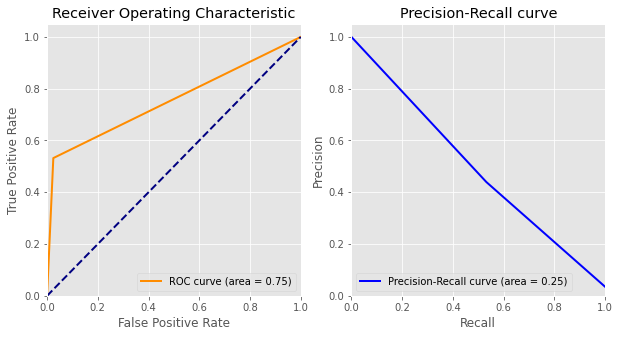

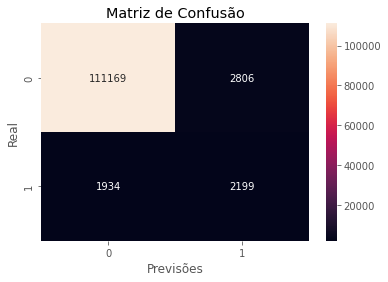

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    113975
           1       0.44      0.53      0.48      4133

    accuracy                           0.96    118108
   macro avg       0.71      0.75      0.73    118108
weighted avg       0.96      0.96      0.96    118108

CPU times: user 1min 54s, sys: 384 ms, total: 1min 54s
Wall time: 1min 54s


In [142]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [143]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_dt.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 1.22 s, sys: 0 ns, total: 1.22 s
Wall time: 1.22 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.481286933683519  0.979126115255551
Threshold: 0.05  0.481234270707955  0.979121619538747
Threshold: 0.1   0.481234270707955  0.979121619538747
Threshold: 0.15  0.481234270707955  0.979121619538747
Threshold: 0.2   0.481234270707955  0.979121619538747
Threshold: 0.25  0.481234270707955  0.979121619538747
Threshold: 0.3   0.481234270707955  0.979121619538747
Threshold: 0.35  0.481234270707955  0.979121619538747
Threshold: 0.4   0.481234270707955  0.979121619538747
Threshold: 0.45  0.481234270707955  0.979121619538747
Threshold: 0.5   0.481234270707955  0.979121619538747
Threshold: 0.55  0.481286933683519  0.979126115255551
Threshold: 0.6   0.481286933683519  0.979126115255551
Threshold: 0.65  0.481286933683519  0.979126115255551
Threshold: 0.7   0.481286933683519  0.979126115255551
Threshold: 0.75  0.481286933683519  0.979126115255551

In [144]:
feature_importances = clf_dt.feature_importances_

df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
66                             V280  0.208198604944897
55                              V81  0.185117347358276
6                                C1  0.131671978201993
13                              C14  0.078444949023061
58                              V90  0.052892001355413
12                              C13  0.020738491109903
71                             V308  0.017123024151449
153                            M5_F  0.015357663646515
2                             card2  0.013115476083717
101         P_emaildomain_gmail.com  0.011916699208126
0                    TransactionAmt  0.011849291269278
150                           M4_M0  0.011571783370837
1                             card1  0.011362159294202
152                           M4_M2  0.011199525730038
68                             V283  0.010446563612269
67                             V282  0.009212345604611
62                              V96  0.008042720291277
69                             V285  0.007415668378566
4                             addr1  0.006887898546261
7                                C2  0.006314209006563
3                             card5  0.005817076528772
104       P_emaildomain_hotmail.com  0.005686881739781
156                            M6_T  0.005587349909007
75                            _Days  0.005585199015516
16                               D3  0.005087703274241
54                              V80  0.004704655207980
74                           _Hours  0.004575553896435
11                              C11  0.004381530538412
43                              V48  0.004370350212046
9                                C6  0.003876649935316
72                             V310  0.003827250133241
64                             V127  0.003522457125256
14                               D1  0.003436274848548
138         P_emaildomain_yahoo.com  0.003358807982225
21                              D15  0.003340925368771
70                             V307  0.003327914494774
15                               D2  0.003242119220599
46                              V51  0.003172317070004
19                              D10  0.003126408837577
17                               D4  0.003106996642566
73                        _Weekdays  0.003061042993206
86      P_emaildomain_anonymous.com  0.002909400760667
149                            M3_T  0.002895830274075
5                             dist1  0.002838469207835
10                               C9  0.002632666579298
155                            M6_F  0.002628512335412
82                   card4_discover  0.002341852838579
154                            M5_T  0.002327929615698
18                               D5  0.002319396510100
59                              V91  0.002174182708043
78                      ProductCD_R  0.002087881611569
57                              V85  0.001994341160646
48                              V53  0.001947909644035
38                              V36  0.001920574607838
26                               V5  0.001886184220543
53                              V76  0.001857598077776
84                       card4_visa  0.001830874313174
35                              V29  0.001795529575165
162                            M9_T  0.001759382316377
47                              V52  0.001604465586711
77                      ProductCD_H  0.001589957847354
52                              V75  0.001569443801364
120       P_emaildomain_outlook.com  0.001556694669075
33                              V12  0.001547932430889
63                              V99  0.001498326257177
34                              V13  0.001438615644475
65                             V130  0.001378374156193
37                              V35  0.001263327740354
83                 card4_mastercard  0.001246481329986
20                              D11  0.001222380053129
39                              V39  0.001215651146946
25                               V4  0.001202208308953
8            

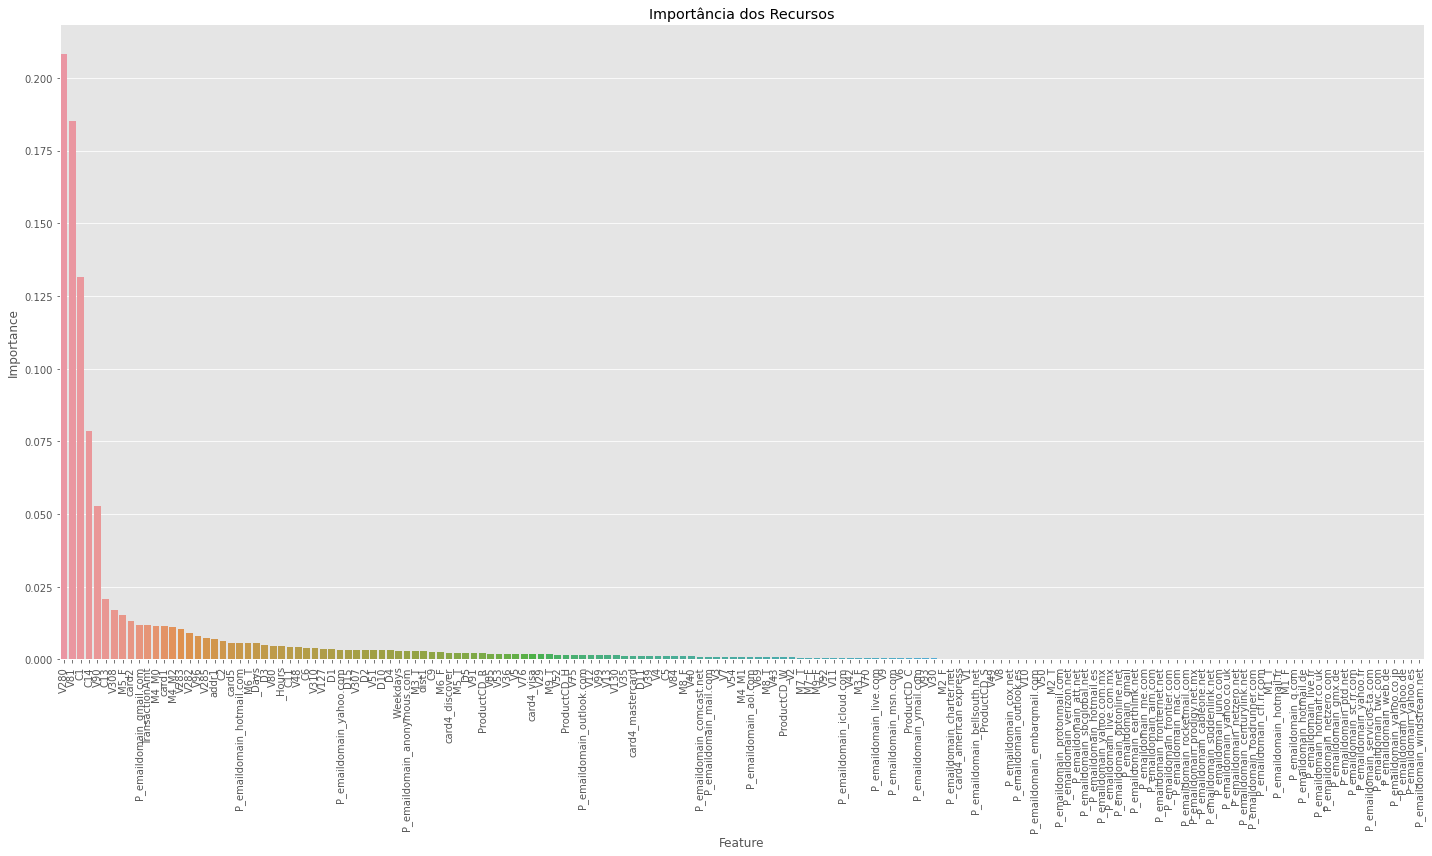

In [145]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

0:	learn: 0.6057922	total: 76.8ms	remaining: 307ms
1:	learn: 0.5400358	total: 152ms	remaining: 228ms
2:	learn: 0.4834998	total: 225ms	remaining: 150ms
3:	learn: 0.4519096	total: 298ms	remaining: 74.5ms
4:	learn: 0.4196478	total: 372ms	remaining: 0us
0:	learn: 0.5336608	total: 12.8ms	remaining: 51.1ms
1:	learn: 0.4271318	total: 22.8ms	remaining: 34.1ms
2:	learn: 0.3416706	total: 31.3ms	remaining: 20.9ms
3:	learn: 0.2888256	total: 39.5ms	remaining: 9.87ms
4:	learn: 0.2438958	total: 48.2ms	remaining: 0us
0:	learn: 0.5331992	total: 8.34ms	remaining: 33.4ms
1:	learn: 0.4266171	total: 16.7ms	remaining: 25.1ms
2:	learn: 0.3413103	total: 25.1ms	remaining: 16.7ms
3:	learn: 0.2883925	total: 33.1ms	remaining: 8.27ms
4:	learn: 0.2434156	total: 41.6ms	remaining: 0us
0:	learn: 0.5334749	total: 7.95ms	remaining: 31.8ms
1:	learn: 0.4268605	total: 16.4ms	remaining: 24.6ms
2:	learn: 0.3408881	total: 24.7ms	remaining: 16.5ms
3:	learn: 0.2880311	total: 32.6ms	remaining: 8.14ms
4:	learn: 0.2431527	total: 4

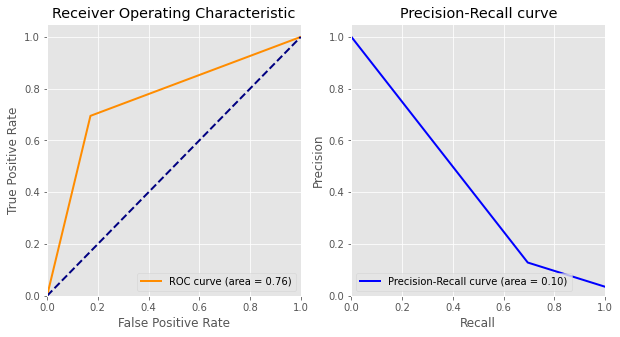

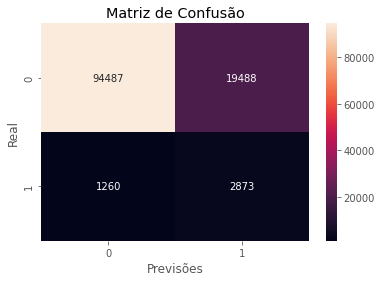

              precision    recall  f1-score   support

           0       0.99      0.83      0.90    113975
           1       0.13      0.70      0.22      4133

    accuracy                           0.82    118108
   macro avg       0.56      0.76      0.56    118108
weighted avg       0.96      0.82      0.88    118108

CPU times: user 1min 46s, sys: 884 ms, total: 1min 47s
Wall time: 1min 23s


In [146]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [147]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_cb.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 39.3 s, sys: 52.1 ms, total: 39.3 s
Wall time: 38.9 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.216879293424926  0.901069034245334
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.073116393926651   0.16757065143151
Threshold: 0.3   0.090246314482188  0.469937154113123
Threshold: 0.35  0.149614721355133   0.79539928048108
Threshold: 0.4   0.184414814814815  0.864046309009908
Threshold: 0.45  0.197506496924241  0.881472375945622
Threshold: 0.5   0.216879293424926  0.901069034245334
Threshold: 0.55  0.289447109315829  0.948913655092298
Threshold: 0.6    0.34407908875994  0.973099466748931
Threshold: 0.65  0.331574740207834  0.981818656206922
Threshold: 0.7   0.219689526429554  0.982818969657374
Threshold: 0.75  0.193589202867988  0.983479786066686

In [148]:
feature_importances = clf_cb.feature_importances_

df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature          Importance
13                              C14  22.464625283874742
66                             V280  18.867186197340700
6                                C1  17.415390672437603
44                              V49  10.546679357165191
43                              V48   9.370930743297997
152                           M4_M2   8.068349941340877
150                           M4_M0   5.166838606092198
57                              V85   2.388736413276762
11                              C11   1.697020995465045
55                              V81   1.337908028331158
51                              V70   0.983038753184622
35                              V29   0.844333828507700
101         P_emaildomain_gmail.com   0.441178249764267
68                             V283   0.407782929921138
116           P_emaildomain_msn.com   0.000000000000000
115            P_emaildomain_me.com   0.000000000000000
108        P_emaildomain_icloud.com   0.000000000000000
119     P_emaildomain_optonline.net   0.000000000000000
117       P_emaildomain_netzero.com   0.000000000000000
118       P_emaildomain_netzero.net   0.000000000000000
114          P_emaildomain_mail.com   0.000000000000000
113           P_emaildomain_mac.com   0.000000000000000
112           P_emaildomain_live.fr   0.000000000000000
111       P_emaildomain_live.com.mx   0.000000000000000
110          P_emaildomain_live.com   0.000000000000000
109          P_emaildomain_juno.com   0.000000000000000
120       P_emaildomain_outlook.com   0.000000000000000
105        P_emaildomain_hotmail.de   0.000000000000000
107        P_emaildomain_hotmail.fr   0.000000000000000
96      P_emaildomain_earthlink.net   0.000000000000000
89      P_emaildomain_bellsouth.net   0.000000000000000
90       P_emaildomain_cableone.net   0.000000000000000
91    P_emaildomain_centurylink.net   0.000000000000000
92         P_emaildomain_cfl.rr.com   0.000000000000000
93        P_emaildomain_charter.net   0.000000000000000
94        P_emaildomain_comcast.net   0.000000000000000
95            P_emaildomain_cox.net   0.000000000000000
97     P_emaildomain_embarqmail.com   0.000000000000000
106        P_emaildomain_hotmail.es   0.000000000000000
98       P_emaildomain_frontier.com   0.000000000000000
99    P_emaildomain_frontiernet.net   0.000000000000000
100             P_emaildomain_gmail   0.000000000000000
102            P_emaildomain_gmx.de   0.000000000000000
103     P_emaildomain_hotmail.co.uk   0.000000000000000
104       P_emaildomain_hotmail.com   0.000000000000000
122    P_emaildomain_prodigy.net.mx   0.000000000000000
121        P_emaildomain_outlook.es   0.000000000000000
0                    TransactionAmt   0.000000000000000
123    P_emaildomain_protonmail.com   0.000000000000000
153                            M5_F   0.000000000000000
144                            M1_F   0.000000000000000
145                            M1_T   0.000000000000000
146                            M2_F   0.000000000000000
147                            M2_T   0.000000000000000
148                            M3_F   0.000000000000000
149                            M3_T   0.000000000000000
151                           M4_M1   0.000000000000000
154                            M5_T   0.000000000000000
142          P_emaildomain_yahoo.fr   0.000000000000000
155                            M6_F   0.000000000000000
156                            M6_T   0.000000000000000
157                            M7_F   0.000000000000000
158                            M7_T   0.000000000000000
159                            M8_F   0.000000000000000
160                            M8_T   0.000000000000000
161                            M9_F   0.000000000000000
143         P_emaildomain_ymail.com   0.000000000000000
141          P_emaildomain_yahoo.es   0.000000000000000
124           P_emaildomain_ptd.net   0.000000000000000
131    P_emaildomain_suddenlink.net   0.000000000000000
87            P_emaildomain_aol.com   0.000000000000

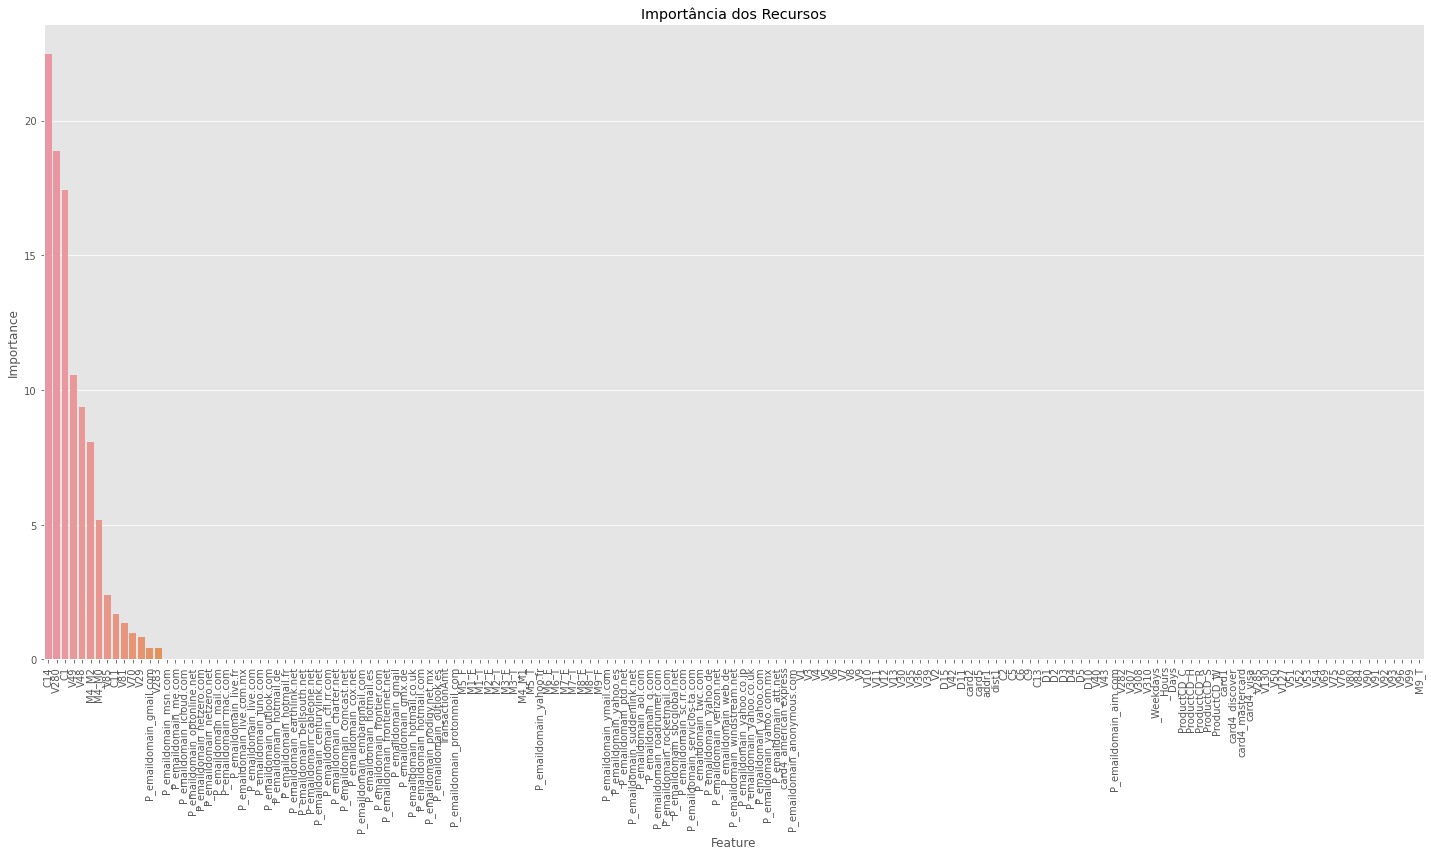

In [149]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.3295090923281043
F1-Score Negativo (Teste): 0.9615448315376247
F1-Score Positivo Médio (Validação Cruzada): 0.2673423877441872
F1-Score Positivo Fold 1: 0.400735294117647
F1-Score Positivo Fold 2: 0.3230769230769231
F1-Score Positivo Fold 3: 0.3843283582089552
F1-Score Positivo Fold 4: 0.26799999999999996
F1-Score Positivo Fold 5: 0.3365200764818356
F1-Score Positivo Fold 6: 0.34651600753295664
F1-Score Positivo Fold 7: 0.09746588693957114
F1-Score Positivo Fold 8: 0.18410041841004185
F1-Score Positivo Fold 9: 0.22672064777327935
F1-Score Positivo Fold 10: 0.10596026490066224
F1-Score Negativo Médio (Validação Cruzada): 0.9839577492023116
F1-Score Negativo Fold 1: 0.9858739925470146
F1-Score Negativo Fold 2: 0.9847632239632932
F1-Score Negativo Fold 3: 0.9857056224551676
F1-Score Negativo Fold 4: 0.984170919470634
F1-Score Negativo Fold 5: 0.9849777046625394
F1-Score Negativo Fold 6: 0.9849725001082673
F1-Score Negativo Fold 7: 0.9799645159894415
F1-Score N

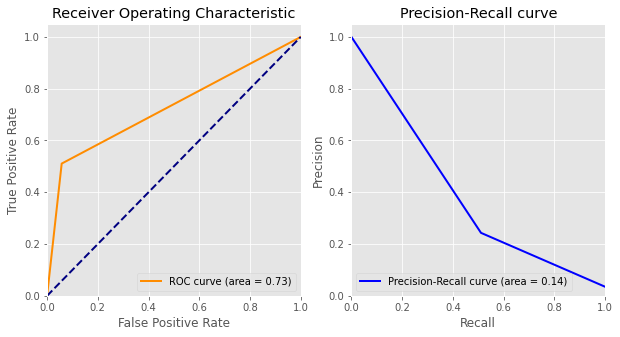

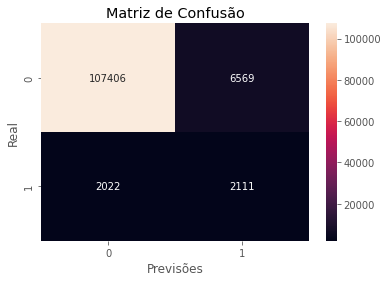

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    113975
           1       0.24      0.51      0.33      4133

    accuracy                           0.93    118108
   macro avg       0.61      0.73      0.65    118108
weighted avg       0.96      0.93      0.94    118108

CPU times: user 8min 40s, sys: 344 ms, total: 8min 41s
Wall time: 8min 40s


In [150]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [151]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_gbc.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2.79 s, sys: 4 ms, total: 2.79 s
Wall time: 2.79 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.329509092328104  0.961544831537625
Threshold: 0.05  0.101978875804298  0.589265993349087
Threshold: 0.1   0.135356754235971  0.759147397592448
Threshold: 0.15  0.165249150767502  0.834149485190015
Threshold: 0.2    0.19301494062061  0.876627686781329
Threshold: 0.25  0.221078298564075  0.904339311433175
Threshold: 0.3   0.245376023153801  0.922060877241328
Threshold: 0.35  0.269615587151132   0.93614944804029
Threshold: 0.4   0.290394459500151   0.94634603913283
Threshold: 0.45  0.311019567456231  0.954726123500458
Threshold: 0.5   0.329509092328104  0.961544831537625
Threshold: 0.55  0.342626687708224  0.966647391130288
Threshold: 0.6     0.3524557956778   0.97083650391973
Threshold: 0.65  0.357784103350121  0.974167921719907
Threshold: 0.7   0.361552680221811  0.977286377525745
Threshold: 0.75  0.353623188405797  0.979547628302274

In [152]:
feature_importances = clf_gbc.feature_importances_

df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
55                              V81  0.255192156037216
71                             V308  0.116386802137201
13                              C14  0.113734467138426
11                              C11  0.084151862802664
44                              V49  0.071374508968945
101         P_emaildomain_gmail.com  0.044299900994525
66                             V280  0.030574942999793
6                                C1  0.027113784285385
154                            M5_T  0.021277174906376
67                             V282  0.019297868601863
62                              V96  0.017382893729091
32                              V11  0.015259197970741
16                               D3  0.014544811043682
73                        _Weekdays  0.012739647223350
47                              V52  0.012572704704407
138         P_emaildomain_yahoo.com  0.012155363335544
74                           _Hours  0.011753662063350
0                    TransactionAmt  0.011587256173072
49                              V54  0.009293041512449
153                            M5_F  0.007726663336790
9                                C6  0.007256887449541
12                              C13  0.005845387194043
29                               V8  0.004829702115616
159                            M8_F  0.004612005026599
24                               V3  0.004491903900255
160                            M8_T  0.003965570199225
149                            M3_T  0.003946912904007
10                               C9  0.003915429675968
155                            M6_F  0.003855608916673
84                       card4_visa  0.003840809061493
148                            M3_F  0.003576434274401
156                            M6_T  0.003401420209156
104       P_emaildomain_hotmail.com  0.003309128693254
64                             V127  0.003045827388937
86      P_emaildomain_anonymous.com  0.002789086690812
161                            M9_F  0.002670869777095
87            P_emaildomain_aol.com  0.001929032568599
68                             V283  0.001857654223498
82                   card4_discover  0.001814511492385
83                 card4_mastercard  0.001659442843628
72                             V310  0.001611884209088
7                                C2  0.001568394762198
1                             card1  0.001518840524028
28                               V7  0.001430134939201
120       P_emaildomain_outlook.com  0.001426188975017
162                            M9_T  0.001313428548613
56                              V84  0.001253285879078
75                            _Days  0.001154977628889
2                             card2  0.001120853827561
65                             V130  0.001012096583082
69                             V285  0.000932275821692
5                             dist1  0.000925141655111
94        P_emaildomain_comcast.net  0.000816450610665
110          P_emaildomain_live.com  0.000766497309858
152                           M4_M2  0.000761105704379
114          P_emaildomain_mail.com  0.000743291942969
116           P_emaildomain_msn.com  0.000612816508517
129         P_emaildomain_sc.rr.com  0.000000000000000
130  P_emaildomain_servicios-ta.com  0.000000000000000
122    P_emaildomain_prodigy.net.mx  0.000000000000000
128     P_emaildomain_sbcglobal.net  0.000000000000000
127    P_emaildomain_rocketmail.com  0.000000000000000
126    P_emaildomain_roadrunner.com  0.000000000000000
125             P_emaildomain_q.com  0.000000000000000
124           P_emaildomain_ptd.net  0.000000000000000
131    P_emaildomain_suddenlink.net  0.000000000000000
123    P_emaildomain_protonmail.com  0.000000000000000
46                              V51  0.000000000000000
121        P_emaildomain_outlook.es  0.000000000000000
20                              D11  0.000000000000000
133       P_emaildomain_verizon.net  0.000000000000000
119     P_emaildomain_optonline.net  0.000000000000000
118       P_e

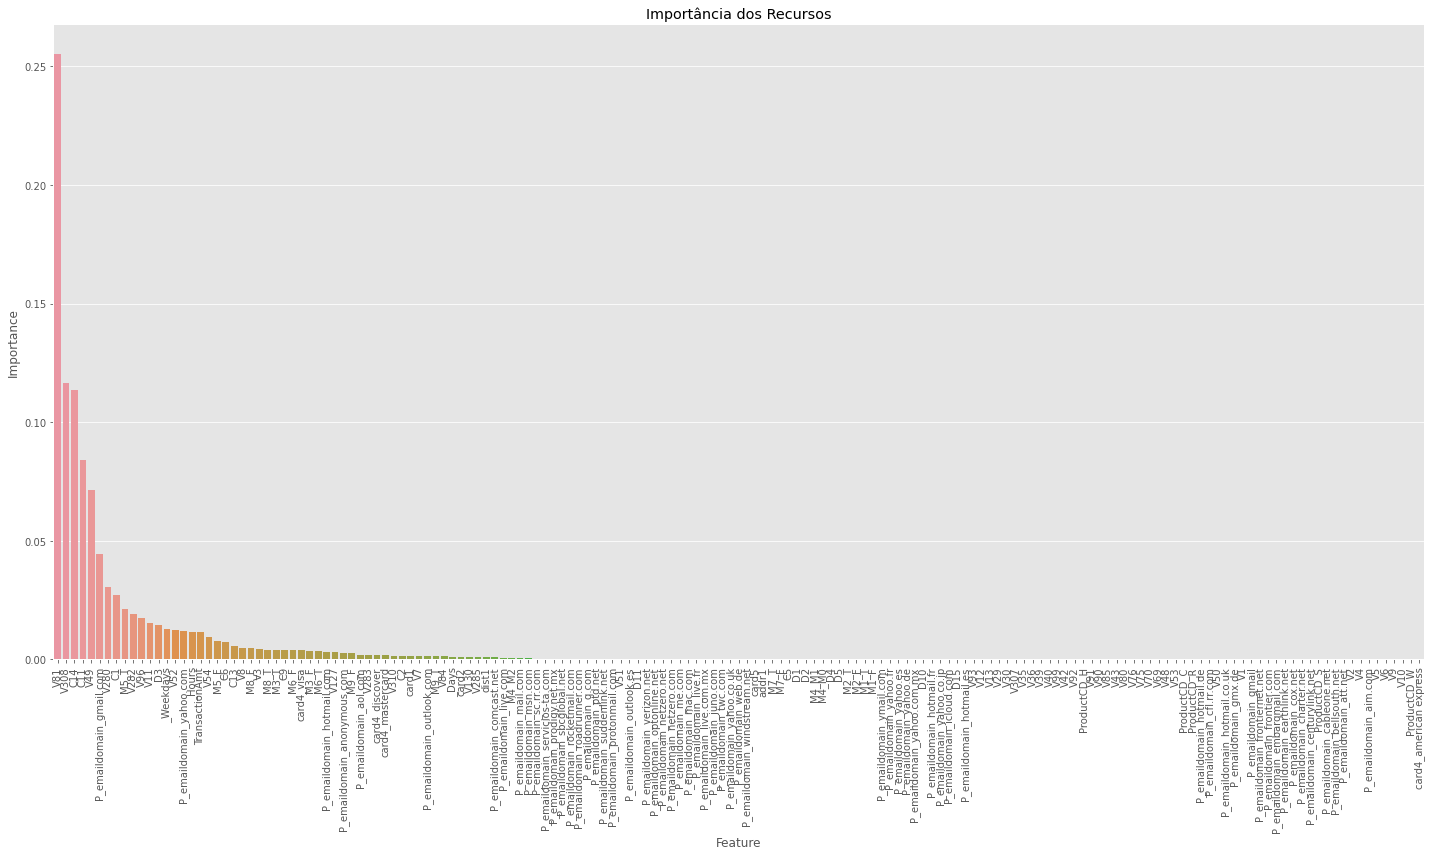

In [153]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.3212565755353042
F1-Score Negativo (Teste): 0.9588674518114754
F1-Score Positivo Médio (Validação Cruzada): 0.335181738224934
F1-Score Positivo Fold 1: 0.38817005545286504
F1-Score Positivo Fold 2: 0.35361216730038025
F1-Score Positivo Fold 3: 0.3320610687022901
F1-Score Positivo Fold 4: 0.3161904761904762
F1-Score Positivo Fold 5: 0.3709369024856597
F1-Score Positivo Fold 6: 0.33270321361058597
F1-Score Positivo Fold 7: 0.367112810707457
F1-Score Positivo Fold 8: 0.2795275590551181
F1-Score Positivo Fold 9: 0.30115830115830117
F1-Score Positivo Fold 10: 0.31034482758620685
F1-Score Negativo Médio (Validação Cruzada): 0.9849293419127733
F1-Score Negativo Fold 1: 0.9856592002079633
F1-Score Negativo Fold 2: 0.985278836162106
F1-Score Negativo Fold 3: 0.9848471729154039
F1-Score Negativo Fold 4: 0.9844568558687276
F1-Score Negativo Fold 5: 0.9857569591757219
F1-Score Negativo Fold 6: 0.9847139825921274
F1-Score Negativo Fold 7: 0.9856703753409237
F1-Score Neg

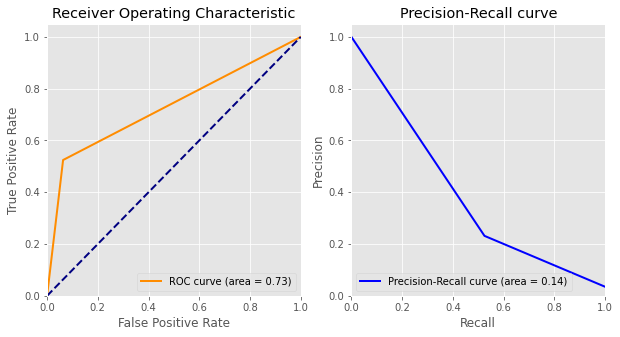

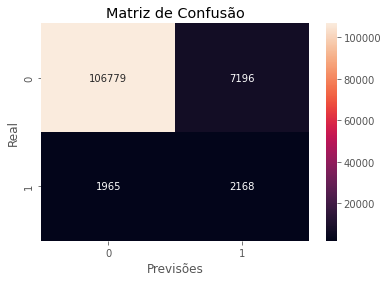

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    113975
           1       0.23      0.52      0.32      4133

    accuracy                           0.92    118108
   macro avg       0.61      0.73      0.64    118108
weighted avg       0.96      0.92      0.94    118108

CPU times: user 10min 55s, sys: 7.97 s, total: 11min 3s
Wall time: 11min 2s


In [154]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [155]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_ada.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 34.4 s, sys: 164 ms, total: 34.6 s
Wall time: 34.6 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.321256575535304  0.958867451811475
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.067620520120091                0.0
Threshold: 0.3   0.067620520120091                0.0
Threshold: 0.35  0.067620520120091                0.0
Threshold: 0.4   0.067620520120091                0.0
Threshold: 0.45  0.067620520120091                0.0
Threshold: 0.5   0.321256575535304  0.958867451811475
Threshold: 0.55                0.0  0.982191715894745
Threshold: 0.6                 0.0  0.982191715894745
Threshold: 0.65                0.0  0.982191715894745
Threshold: 0.7                 0.0  0.982191715894745
Threshold: 0.75                0.0  0.982191715894745

In [156]:
feature_importances = clf_ada.feature_importances_

df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature  Importance
62                              V96        0.07
66                             V280        0.07
6                                C1        0.06
13                              C14        0.06
0                    TransactionAmt        0.03
148                            M3_F        0.03
74                           _Hours        0.03
11                              C11        0.03
155                            M6_F        0.02
101         P_emaildomain_gmail.com        0.02
31                              V10        0.02
67                             V282        0.02
149                            M3_T        0.02
152                           M4_M2        0.02
16                               D3        0.02
44                              V49        0.02
156                            M6_T        0.02
159                            M8_F        0.02
2                             card2        0.02
84                       card4_visa        0.02
9                                C6        0.02
47                              V52        0.01
48                              V53        0.01
55                              V81        0.01
56                              V84        0.01
104       P_emaildomain_hotmail.com        0.01
63                              V99        0.01
110          P_emaildomain_live.com        0.01
64                             V127        0.01
87            P_emaildomain_aol.com        0.01
83                 card4_mastercard        0.01
69                             V285        0.01
86      P_emaildomain_anonymous.com        0.01
120       P_emaildomain_outlook.com        0.01
73                        _Weekdays        0.01
114          P_emaildomain_mail.com        0.01
138         P_emaildomain_yahoo.com        0.01
1                             card1        0.01
82                   card4_discover        0.01
75                            _Days        0.01
50                              V69        0.01
150                           M4_M0        0.01
33                              V12        0.01
18                               D5        0.01
154                            M5_T        0.01
12                              C13        0.01
151                           M4_M1        0.01
8                                C5        0.01
158                            M7_T        0.01
32                              V11        0.01
160                            M8_T        0.01
29                               V8        0.01
37                              V35        0.01
27                               V6        0.01
153                            M5_F        0.01
24                               V3        0.01
19                              D10        0.01
116           P_emaildomain_msn.com        0.00
115            P_emaildomain_me.com        0.00
117       P_emaildomain_netzero.com        0.00
118       P_emaildomain_netzero.net        0.00
119     P_emaildomain_optonline.net        0.00
139      P_emaildomain_yahoo.com.mx        0.00
113           P_emaildomain_mac.com        0.00
112           P_emaildomain_live.fr        0.00
111       P_emaildomain_live.com.mx        0.00
109          P_emaildomain_juno.com        0.00
108        P_emaildomain_icloud.com        0.00
107        P_emaildomain_hotmail.fr        0.00
106        P_emaildomain_hotmail.es        0.00
105        P_emaildomain_hotmail.de        0.00
161                            M9_F        0.00
103     P_emaildomain_hotmail.co.uk        0.00
157                            M7_F        0.00
122    P_emaildomain_prodigy.net.mx        0.00
121        P_emaildomain_outlook.es        0.00
130  P_emaildomain_servicios-ta.com        0.00
137       P_emaildomain_yahoo.co.uk        0.00
141          P_emaildomain_yahoo.es        0.00
136       P_emaildomain_yahoo.co.jp        0.00
135    P_emaildomain_windstream.net        0.00
142          P_emaildomain_yahoo.fr        0.00
134            P_emaildomain_web.de        0

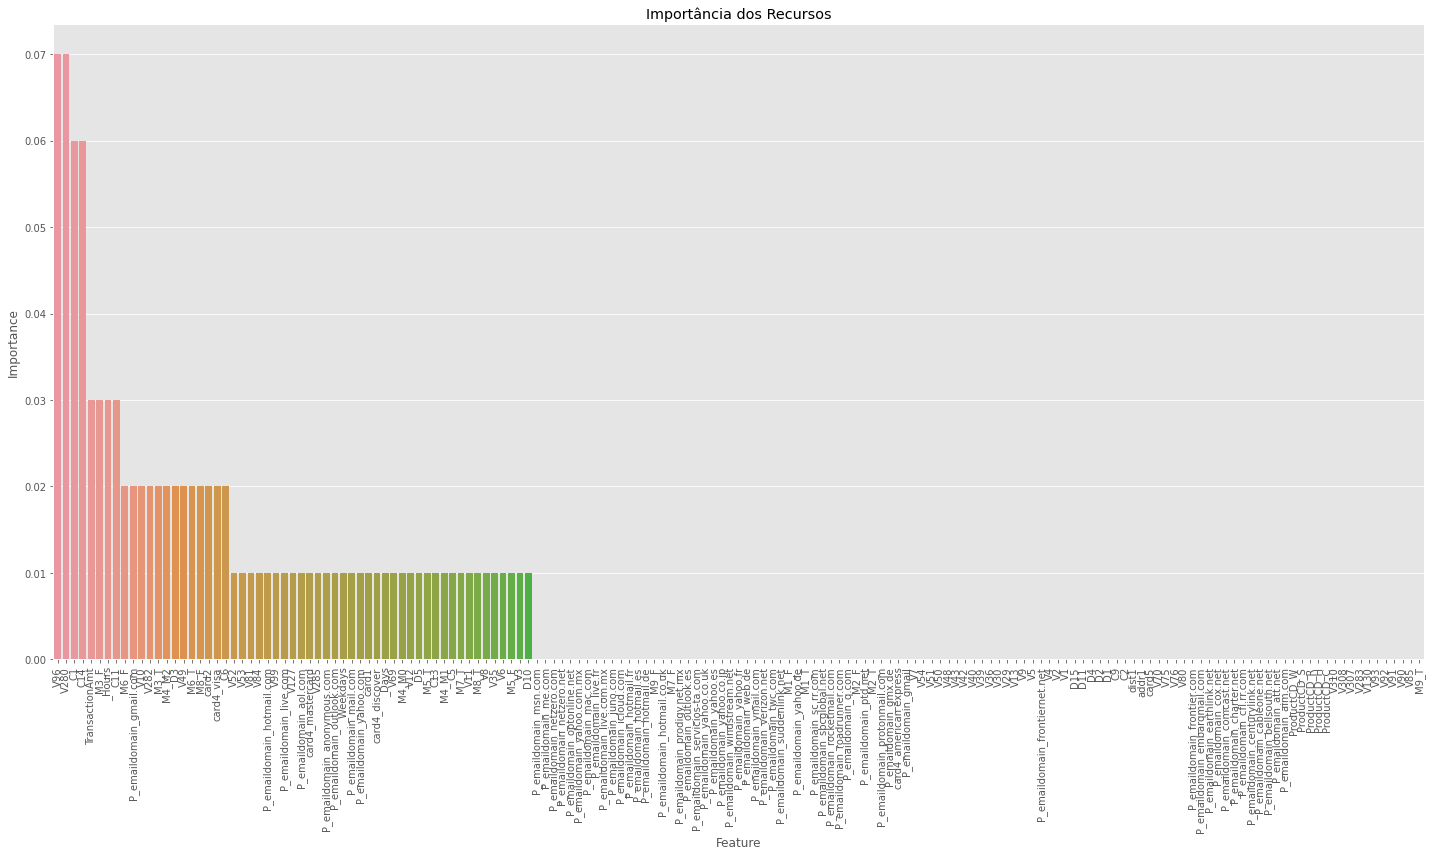

In [157]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.3245492371705964
F1-Score Negativo (Teste): 0.9537396811036978
F1-Score Positivo Médio (Validação Cruzada): 0.2657473185015969
F1-Score Positivo Fold 1: 0.2636203866432338
F1-Score Positivo Fold 2: 0.2491349480968858
F1-Score Positivo Fold 3: 0.2539130434782609
F1-Score Positivo Fold 4: 0.23633156966490299
F1-Score Positivo Fold 5: 0.2901554404145078
F1-Score Positivo Fold 6: 0.24834437086092717
F1-Score Positivo Fold 7: 0.2694300518134715
F1-Score Positivo Fold 8: 0.2582897033158813
F1-Score Positivo Fold 9: 0.2852233676975945
F1-Score Positivo Fold 10: 0.30303030303030304
F1-Score Negativo Médio (Validação Cruzada): 0.9815202969261145
F1-Score Negativo Fold 1: 0.9818244913894071
F1-Score Negativo Fold 2: 0.9811664641555284
F1-Score Negativo Fold 3: 0.981385863669892
F1-Score Negativo Fold 4: 0.9812188245499891
F1-Score Negativo Fold 5: 0.9821637807577138
F1-Score Negativo Fold 6: 0.9802763055000434
F1-Score Negativo Fold 7: 0.9816430152323916
F1-Score Neg

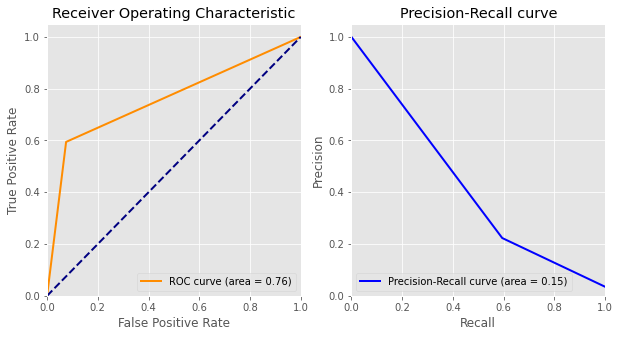

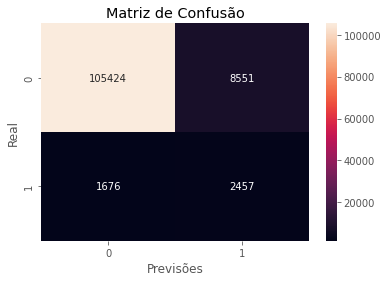

              precision    recall  f1-score   support

           0       0.98      0.92      0.95    113975
           1       0.22      0.59      0.32      4133

    accuracy                           0.91    118108
   macro avg       0.60      0.76      0.64    118108
weighted avg       0.96      0.91      0.93    118108

CPU times: user 39min 29s, sys: 940 ms, total: 39min 29s
Wall time: 3min 26s


In [158]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_smote, y_train_oversample_with_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [159]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_knn.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 8h 6min 56s, sys: 2.14 s, total: 8h 6min 58s
Wall time: 41min 2s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.324549237170596  0.953739681103698
Threshold: 0.05  0.268078639015542  0.930826294255835
Threshold: 0.1   0.268078639015542  0.930826294255835
Threshold: 0.15  0.268078639015542  0.930826294255835
Threshold: 0.2   0.268078639015542  0.930826294255835
Threshold: 0.25  0.268078639015542  0.930826294255835
Threshold: 0.3   0.268078639015542  0.930826294255835
Threshold: 0.35  0.324549237170596  0.953739681103698
Threshold: 0.4   0.324549237170596  0.953739681103698
Threshold: 0.45  0.324549237170596  0.953739681103698
Threshold: 0.5   0.324549237170596  0.953739681103698
Threshold: 0.55  0.324549237170596  0.953739681103698
Threshold: 0.6   0.324549237170596  0.953739681103698
Threshold: 0.65  0.324549237170596  0.953739681103698
Threshold: 0.7    0.40290737648561  0.973105934921583
Threshold: 0.75   0.40290737648561  0.973105934921583

In [160]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 1.1e+04 s


## Validação Cruzada para Oversample com Borderline SMOTE

### 50 Chi-Square

In [161]:
#reinicializando os classificadores

clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)

F1-Score Positivo (Teste): 0.6117548513192796
F1-Score Negativo (Teste): 0.9878587051905018
F1-Score Positivo Médio (Validação Cruzada): 0.497380187760667
F1-Score Positivo Fold 1: 0.5024793388429752
F1-Score Positivo Fold 2: 0.5032894736842105
F1-Score Positivo Fold 3: 0.5199362041467306
F1-Score Positivo Fold 4: 0.5016393442622951
F1-Score Positivo Fold 5: 0.5377049180327869
F1-Score Positivo Fold 6: 0.5056726094003242
F1-Score Positivo Fold 7: 0.4694214876033059
F1-Score Positivo Fold 8: 0.46700507614213194
F1-Score Positivo Fold 9: 0.4747967479674798
F1-Score Positivo Fold 10: 0.4918566775244299
F1-Score Negativo Médio (Validação Cruzada): 0.986676196088756
F1-Score Negativo Fold 1: 0.9869227093018204
F1-Score Negativo Fold 2: 0.9868775527939515
F1-Score Negativo Fold 3: 0.9869101978691021
F1-Score Negativo Fold 4: 0.9867895011298453
F1-Score Negativo Fold 5: 0.987745524074396
F1-Score Negativo Fold 6: 0.9867420126059552
F1-Score Negativo Fold 7: 0.9860537863318418
F1-Score Negativ

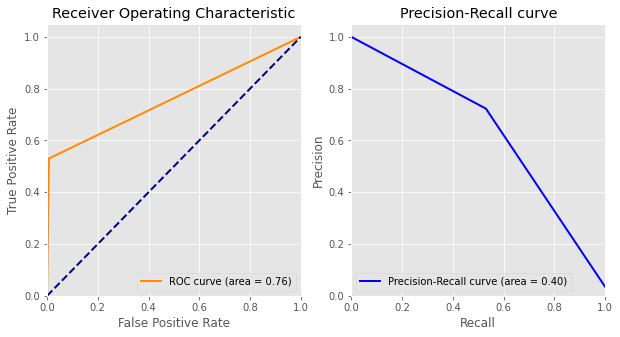

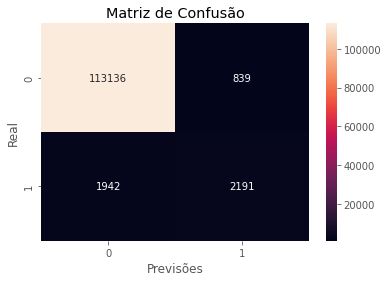

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    113975
           1       0.72      0.53      0.61      4133

    accuracy                           0.98    118108
   macro avg       0.85      0.76      0.80    118108
weighted avg       0.97      0.98      0.97    118108

CPU times: user 5min 46s, sys: 328 ms, total: 5min 47s
Wall time: 5min 46s


In [162]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], \
           y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_borderline_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [163]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_et.predict_proba(X_test[oversample_with_borderline_smote_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 53.6 s, sys: 6 µs, total: 53.6 s
Wall time: 53.6 s


Metrics          F1_score Positivo  F1_score Negativo
Original          0.61175485131928  0.987858705190502
Threshold: 0.05  0.247943384703811  0.899534022142346
Threshold: 0.1   0.366551077255415  0.949031446540881
Threshold: 0.15  0.460004498088312  0.967681725794945
Threshold: 0.2   0.528139305268827  0.976643341108519
Threshold: 0.25  0.568237205523964  0.981216426350014
Threshold: 0.3   0.595039483928373  0.983976235009352
Threshold: 0.35   0.61091864771234    0.9857051943207
Threshold: 0.4    0.62131748640789  0.986881698765259
Threshold: 0.45  0.619407938404354  0.987462994625748
Threshold: 0.5   0.610628019323672  0.987679662490009
Threshold: 0.55  0.599971251976427  0.987860890957389
Threshold: 0.6   0.592976737294414  0.988028779737391
Threshold: 0.65  0.576375057453654  0.987961983377524
Threshold: 0.7   0.551013941698352  0.987673115735263
Threshold: 0.75  0.519697964543664  0.987285115850585

In [164]:
feature_importances = clf_et.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_borderline_smote_cols_50_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
49           M4_M2  0.049222425385362
0   TransactionAmt  0.045128278725914
13              D2  0.042957543050572
1            card1  0.038935598713696
48     ProductCD_C  0.037621930188369
43            V282  0.036094037150128
11             C14  0.035561909570703
4               C1  0.033390224767758
5               C2  0.030118100329492
44            V283  0.030035953581181
10             C13  0.026204244032791
2            card5  0.025597032807944
30             V69  0.024230589822701
12              D1  0.023209861020170
9              C11  0.023082157708527
46            V308  0.021042231758723
7               C6  0.020308660162964
36             V90  0.019658203040435
28             V51  0.019203554890433
40             V96  0.019078555781239
14              D3  0.018853565563522
16              D5  0.018660826913248
20             V29  0.018577521686730
26             V48  0.018319995844242
24             V42  0.017383796263482
25             V43  0.017279340366055
31             V70  0.017113392055435
19             D15  0.017057467525698
29             V52  0.016617970945210
17             D10  0.016510133696523
45            V307  0.015904373966008
22             V39  0.015250156546141
18             D11  0.014544925719983
47            V310  0.014329991736695
41            V127  0.014229364077766
15              D4  0.013805471853816
27             V50  0.013169106074201
34             V84  0.012720894289678
37             V91  0.012705067921985
8               C9  0.011744892695171
38             V92  0.011570156874887
21             V30  0.011125371323817
23             V40  0.010889516003682
42            V130  0.010163322334152
3            dist1  0.008160281313460
35             V85  0.008028665114697
33             V81  0.007255484789939
32             V80  0.006330314811534
39             V93  0.006218526085078
6               C5  0.004799013118061

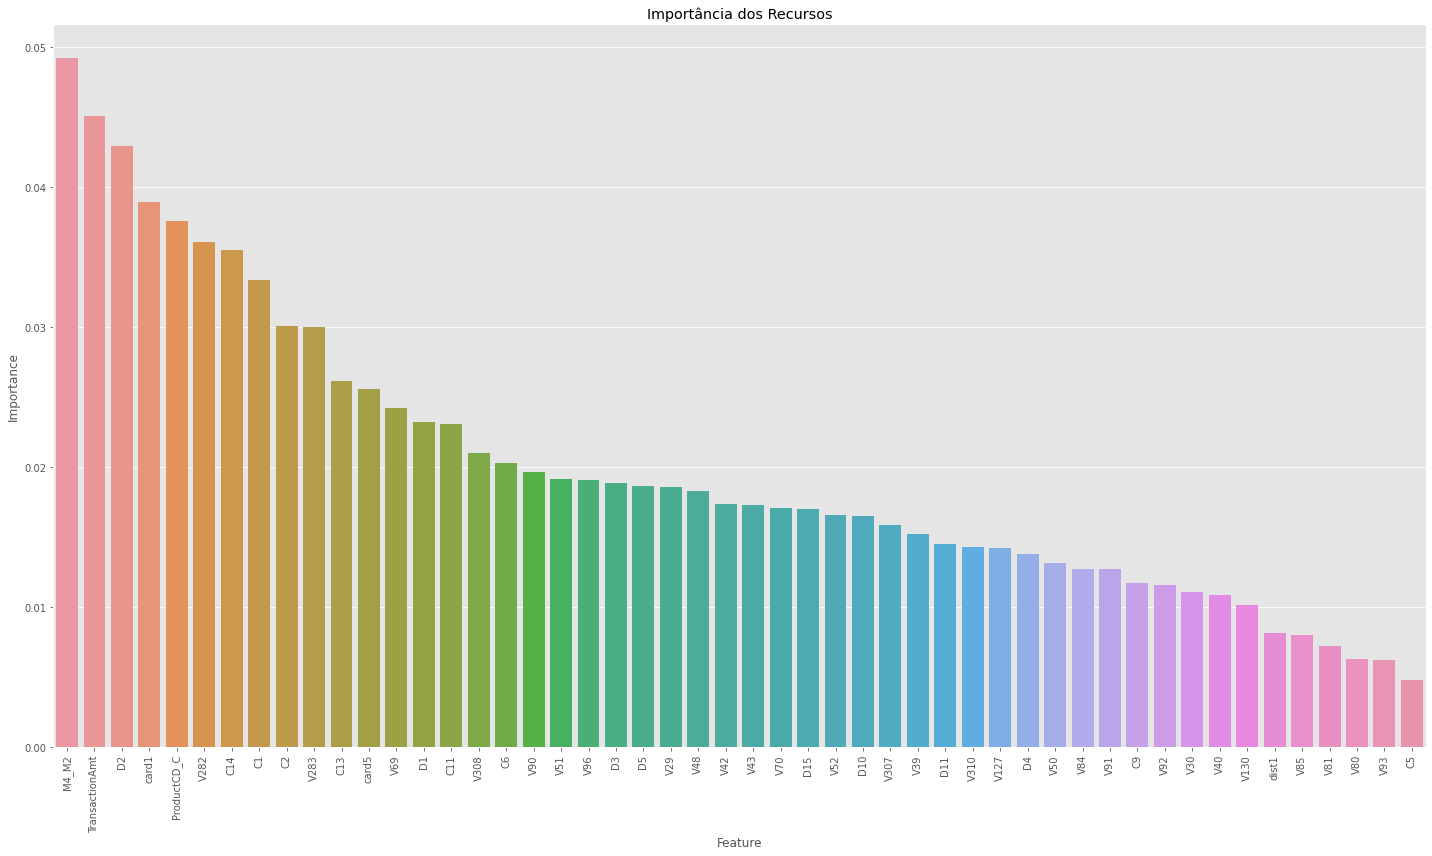

In [165]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.4721369021500659
F1-Score Negativo (Teste): 0.9788110964332892
F1-Score Positivo Médio (Validação Cruzada): 0.419820126647124
F1-Score Positivo Fold 1: 0.45622119815668205
F1-Score Positivo Fold 2: 0.39687848383500557
F1-Score Positivo Fold 3: 0.4444444444444445
F1-Score Positivo Fold 4: 0.4342723004694836
F1-Score Positivo Fold 5: 0.400895856662934
F1-Score Positivo Fold 6: 0.4429378531073446
F1-Score Positivo Fold 7: 0.40373395565927656
F1-Score Positivo Fold 8: 0.38039673278879815
F1-Score Positivo Fold 9: 0.4250871080139373
F1-Score Positivo Fold 10: 0.41333333333333333
F1-Score Negativo Médio (Validação Cruzada): 0.9776980168153344
F1-Score Negativo Fold 1: 0.9792563944800914
F1-Score Negativo Fold 2: 0.9761936193619362
F1-Score Negativo Fold 3: 0.9786803815552333
F1-Score Negativo Fold 4: 0.9788317962231005
F1-Score Negativo Fold 5: 0.9764617889040432
F1-Score Negativo Fold 6: 0.9783172802040727
F1-Score Negativo Fold 7: 0.9775532615857676
F1-Score Ne

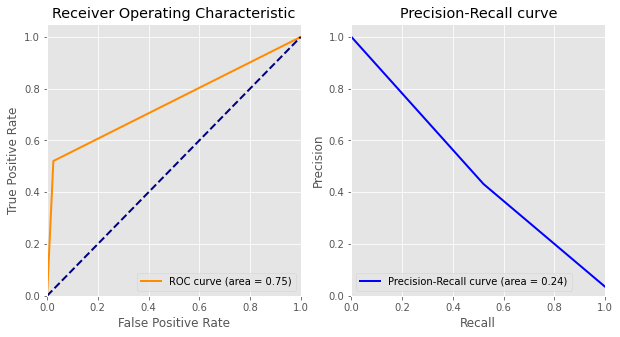

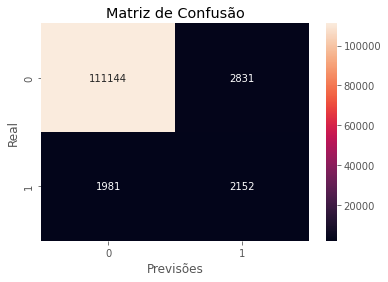

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    113975
           1       0.43      0.52      0.47      4133

    accuracy                           0.96    118108
   macro avg       0.71      0.75      0.73    118108
weighted avg       0.96      0.96      0.96    118108

CPU times: user 53.8 s, sys: 292 ms, total: 54.1 s
Wall time: 53.7 s


In [166]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], \
           y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_borderline_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [167]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_dt.predict_proba(X_test[oversample_with_borderline_smote_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 1.17 s, sys: 1e+03 ns, total: 1.17 s
Wall time: 1.17 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.472136902150066  0.978811096433289
Threshold: 0.05  0.451586149699357  0.976651807388445
Threshold: 0.1   0.457587876236582  0.977266511993084
Threshold: 0.15  0.463097269624573  0.977808146711338
Threshold: 0.2   0.464304827143316  0.977939199464017
Threshold: 0.25  0.466121746612175  0.978124256339294
Threshold: 0.3   0.467781975175391  0.978272843036603
Threshold: 0.35  0.469184027777778  0.978449339207048
Threshold: 0.4   0.469184027777778  0.978449339207048
Threshold: 0.45  0.469591659426586   0.97848533972371
Threshold: 0.5   0.469591659426586   0.97848533972371
Threshold: 0.55  0.472396004829327  0.978833579181436
Threshold: 0.6   0.472396004829327  0.978833579181436
Threshold: 0.65  0.472655392049198  0.978856060939633
Threshold: 0.7   0.473007146783947   0.97889671144456
Threshold: 0.75  0.473007146783947   0.97889671144456

In [168]:
feature_importances = clf_dt.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_borderline_smote_cols_50_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
29             V52  0.174849178444026
4               C1  0.134446639419862
46            V308  0.109940065119487
11             C14  0.065398896516206
20             V29  0.059984077511701
27             V50  0.044919766333978
44            V283  0.039402978105837
1            card1  0.035852114815559
16              D5  0.030007375423145
43            V282  0.029739657312558
0   TransactionAmt  0.028042150741208
14              D3  0.027299912748443
10             C13  0.024951899140959
40             V96  0.015652068634771
5               C2  0.013280584030206
2            card5  0.012390081681475
13              D2  0.012155590441630
17             D10  0.012001517072691
7               C6  0.011509245360932
9              C11  0.010218459950077
12              D1  0.009671913739565
8               C9  0.009307493891629
45            V307  0.008797518462037
3            dist1  0.008631665295557
21             V30  0.008273943968560
19             D15  0.007189246472070
15              D4  0.005838564011730
49           M4_M2  0.005832805184116
47            V310  0.005754458696246
36             V90  0.004751364527457
18             D11  0.004520309469032
41            V127  0.004207873594406
42            V130  0.003948826298436
6               C5  0.002510440488560
33             V81  0.002232552699761
30             V69  0.002190037391529
26             V48  0.001906656507298
37             V91  0.001645310045098
32             V80  0.001591318369806
39             V93  0.001412516401378
25             V43  0.001373722090964
34             V84  0.001361466888597
31             V70  0.000958479927795
35             V85  0.000901331462352
22             V39  0.000721700922488
28             V51  0.000711659661633
23             V40  0.000632901766087
24             V42  0.000576392027453
38             V92  0.000318596191978
48     ProductCD_C  0.000186674741632

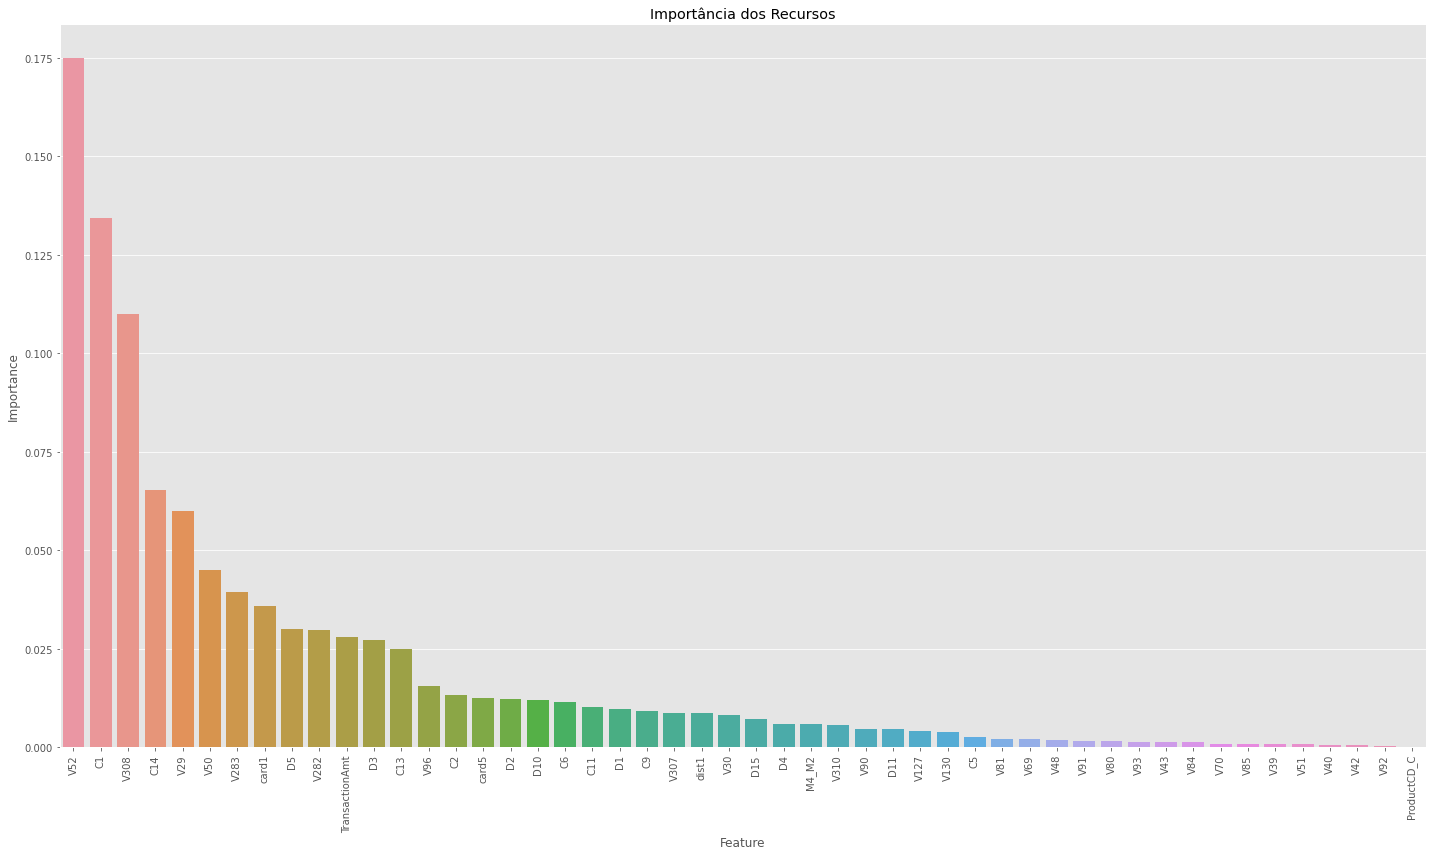

In [169]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

0:	learn: 0.6119678	total: 65.1ms	remaining: 260ms
1:	learn: 0.5528722	total: 126ms	remaining: 189ms
2:	learn: 0.5073385	total: 187ms	remaining: 125ms
3:	learn: 0.4603233	total: 248ms	remaining: 61.9ms
4:	learn: 0.4273282	total: 310ms	remaining: 0us
0:	learn: 0.5424156	total: 6.54ms	remaining: 26.2ms
1:	learn: 0.4303730	total: 13.7ms	remaining: 20.6ms
2:	learn: 0.3508018	total: 20.3ms	remaining: 13.6ms
3:	learn: 0.2955985	total: 26.5ms	remaining: 6.63ms
4:	learn: 0.2489750	total: 33.6ms	remaining: 0us
0:	learn: 0.5417738	total: 6.58ms	remaining: 26.3ms
1:	learn: 0.4297572	total: 13.7ms	remaining: 20.5ms
2:	learn: 0.3500694	total: 20.1ms	remaining: 13.4ms
3:	learn: 0.2950243	total: 26.3ms	remaining: 6.58ms
4:	learn: 0.2485529	total: 33.2ms	remaining: 0us
0:	learn: 0.5421319	total: 6.47ms	remaining: 25.9ms
1:	learn: 0.4300109	total: 13.5ms	remaining: 20.2ms
2:	learn: 0.3502733	total: 20ms	remaining: 13.3ms
3:	learn: 0.2951503	total: 26.2ms	remaining: 6.54ms
4:	learn: 0.2486259	total: 33.

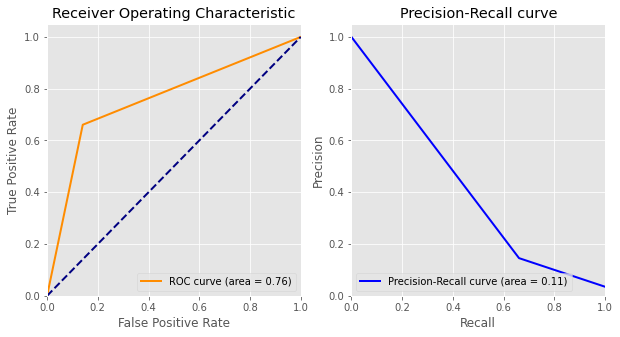

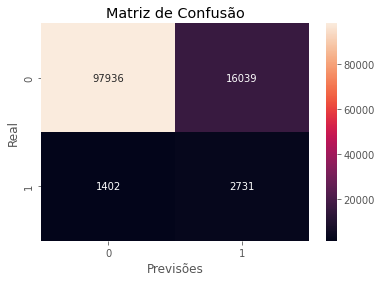

              precision    recall  f1-score   support

           0       0.99      0.86      0.92    113975
           1       0.15      0.66      0.24      4133

    accuracy                           0.85    118108
   macro avg       0.57      0.76      0.58    118108
weighted avg       0.96      0.85      0.89    118108

CPU times: user 23.1 s, sys: 804 ms, total: 23.9 s
Wall time: 10.1 s


In [170]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], \
           y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_borderline_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [171]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_cb.predict_proba(X_test[oversample_with_borderline_smote_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2.09 s, sys: 36 ms, total: 2.12 s
Wall time: 1.67 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.238484041391957  0.918237519513579
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.071086559358576  0.111329241321041
Threshold: 0.25  0.080499082274355  0.328437584698893
Threshold: 0.3   0.113217377978699  0.661519293874041
Threshold: 0.35  0.143287051449681  0.780469385692937
Threshold: 0.4   0.163034585347713  0.827655566389798
Threshold: 0.45  0.198614167022429  0.881403542876582
Threshold: 0.5   0.238484041391957  0.918237519513579
Threshold: 0.55  0.270821902776254  0.939033900637644
Threshold: 0.6   0.327298294955177    0.9659577117747
Threshold: 0.65  0.343323483889123  0.979629783203628
Threshold: 0.7   0.250323534849325  0.982431208758833
Threshold: 0.75  0.182883448420172  0.983127157714626

In [172]:
feature_importances = clf_cb.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_borderline_smote_cols_50_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature          Importance
40             V96  28.793500455263658
5               C2  20.638441396691892
11             C14  11.770908844832556
29             V52   5.801981531787821
46            V308   5.157757430375647
9              C11   5.013808927387037
44            V283   3.496050586511562
16              D5   3.120658478309634
4               C1   3.082704625617126
32             V80   3.033194090980071
7               C6   2.732234802263021
30             V69   2.090043200921762
14              D3   1.761335585407813
20             V29   1.292353586650989
21             V30   1.251168682222455
26             V48   0.963857774776935
34             V84   0.000000000000000
35             V85   0.000000000000000
33             V81   0.000000000000000
36             V90   0.000000000000000
37             V91   0.000000000000000
0   TransactionAmt   0.000000000000000
38             V92   0.000000000000000
39             V93   0.000000000000000
31             V70   0.000000000000000
42            V130   0.000000000000000
43            V282   0.000000000000000
45            V307   0.000000000000000
47            V310   0.000000000000000
48     ProductCD_C   0.000000000000000
41            V127   0.000000000000000
25             V43   0.000000000000000
28             V51   0.000000000000000
27             V50   0.000000000000000
2            card5   0.000000000000000
3            dist1   0.000000000000000
6               C5   0.000000000000000
8               C9   0.000000000000000
10             C13   0.000000000000000
12              D1   0.000000000000000
13              D2   0.000000000000000
15              D4   0.000000000000000
17             D10   0.000000000000000
18             D11   0.000000000000000
19             D15   0.000000000000000
22             V39   0.000000000000000
23             V40   0.000000000000000
24             V42   0.000000000000000
1            card1   0.000000000000000
49           M4_M2   0.000000000000000

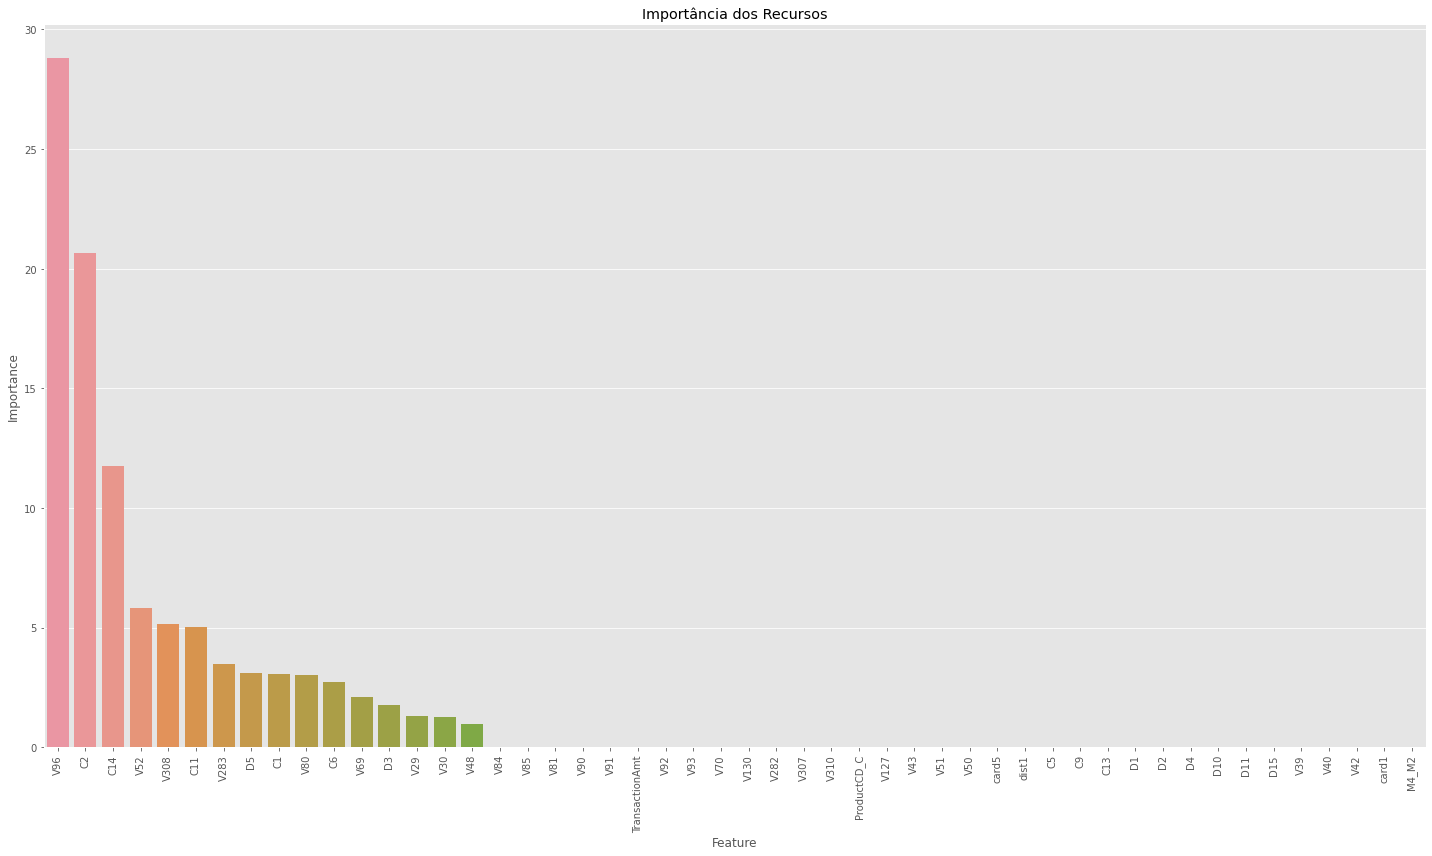

In [173]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.3121370707577604
F1-Score Negativo (Teste): 0.9568311985134995
F1-Score Positivo Médio (Validação Cruzada): 0.31873721061362964
F1-Score Positivo Fold 1: 0.43351548269581053
F1-Score Positivo Fold 2: 0.3763837638376384
F1-Score Positivo Fold 3: 0.40074211502782936
F1-Score Positivo Fold 4: 0.3574144486692015
F1-Score Positivo Fold 5: 0.3864915572232645
F1-Score Positivo Fold 6: 0.3868613138686131
F1-Score Positivo Fold 7: 0.09746588693957114
F1-Score Positivo Fold 8: 0.3085714285714286
F1-Score Positivo Fold 9: 0.33396584440227706
F1-Score Positivo Fold 10: 0.10596026490066224
F1-Score Negativo Médio (Validação Cruzada): 0.9846091359786404
F1-Score Negativo Fold 1: 0.9865210419104581
F1-Score Negativo Fold 2: 0.9853552859618718
F1-Score Negativo Fold 3: 0.9860070181518867
F1-Score Negativo Fold 4: 0.9853654312435053
F1-Score Negativo Fold 5: 0.9858374117545152
F1-Score Negativo Fold 6: 0.9854381554996966
F1-Score Negativo Fold 7: 0.9799645159894415
F1-Score

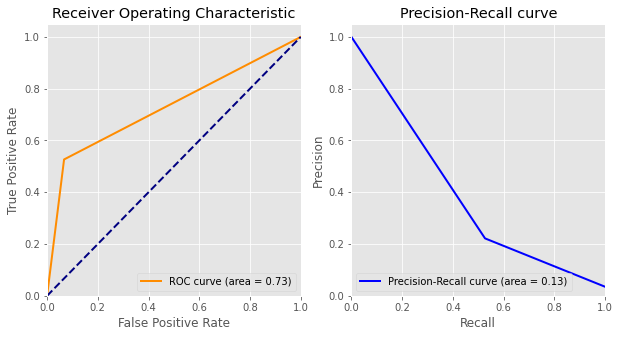

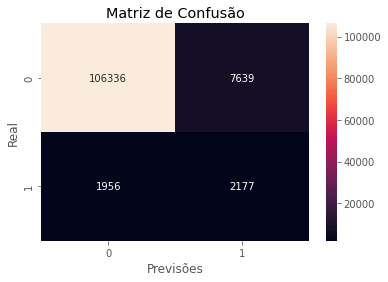

              precision    recall  f1-score   support

           0       0.98      0.93      0.96    113975
           1       0.22      0.53      0.31      4133

    accuracy                           0.92    118108
   macro avg       0.60      0.73      0.63    118108
weighted avg       0.96      0.92      0.93    118108

CPU times: user 5min 18s, sys: 328 ms, total: 5min 19s
Wall time: 5min 18s


In [174]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], \
            y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_borderline_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [175]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_gbc.predict_proba(X_test[oversample_with_borderline_smote_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2.3 s, sys: 4 ms, total: 2.3 s
Wall time: 2.3 s


Metrics          F1_score Positivo  F1_score Negativo
Original          0.31213707075776    0.9568311985135
Threshold: 0.05   0.09153066242068  0.485444490126126
Threshold: 0.1    0.12091368719224  0.695837488247528
Threshold: 0.15  0.152016591651222   0.79866102298682
Threshold: 0.2   0.174381112265835  0.844062831862861
Threshold: 0.25   0.20269638924114            0.88416
Threshold: 0.3   0.229028388644542  0.908705245116142
Threshold: 0.35  0.247010119595216  0.923674443760607
Threshold: 0.4   0.271456649923564  0.938760899495181
Threshold: 0.45  0.292538814507512  0.948912199793924
Threshold: 0.5    0.31213707075776    0.9568311985135
Threshold: 0.55  0.331367924528302  0.964616838426702
Threshold: 0.6   0.350944115964143  0.969848934567846
Threshold: 0.65  0.360268989086099  0.974452442272557
Threshold: 0.7   0.369422001243008  0.977766674993755
Threshold: 0.75  0.368361899409947   0.98037521060856

In [176]:
feature_importances = clf_gbc.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_borderline_smote_cols_50_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
29             V52  0.253345266782616
16              D5  0.176394359579108
11             C14  0.138819427368554
46            V308  0.079709322720287
9              C11  0.066792203585053
20             V29  0.051132314215583
43            V282  0.040136535967920
40             V96  0.039376305771916
4               C1  0.025446162751852
7               C6  0.021698898354479
14              D3  0.021161701696733
0   TransactionAmt  0.016792481286944
44            V283  0.012249915995669
3            dist1  0.011146199315485
10             C13  0.010395164042525
15              D4  0.005741178583397
8               C9  0.004179562312916
18             D11  0.003983179621310
42            V130  0.003953001320318
41            V127  0.003728521428780
26             V48  0.003510848564929
49           M4_M2  0.003001561620956
30             V69  0.002941168834662
1            card1  0.001786439542713
5               C2  0.001594014866053
13              D2  0.000984263869242
22             V39  0.000000000000000
37             V91  0.000000000000000
48     ProductCD_C  0.000000000000000
47            V310  0.000000000000000
2            card5  0.000000000000000
45            V307  0.000000000000000
6               C5  0.000000000000000
12              D1  0.000000000000000
17             D10  0.000000000000000
39             V93  0.000000000000000
38             V92  0.000000000000000
36             V90  0.000000000000000
23             V40  0.000000000000000
35             V85  0.000000000000000
34             V84  0.000000000000000
33             V81  0.000000000000000
32             V80  0.000000000000000
31             V70  0.000000000000000
19             D15  0.000000000000000
28             V51  0.000000000000000
27             V50  0.000000000000000
21             V30  0.000000000000000
24             V42  0.000000000000000
25             V43  0.000000000000000

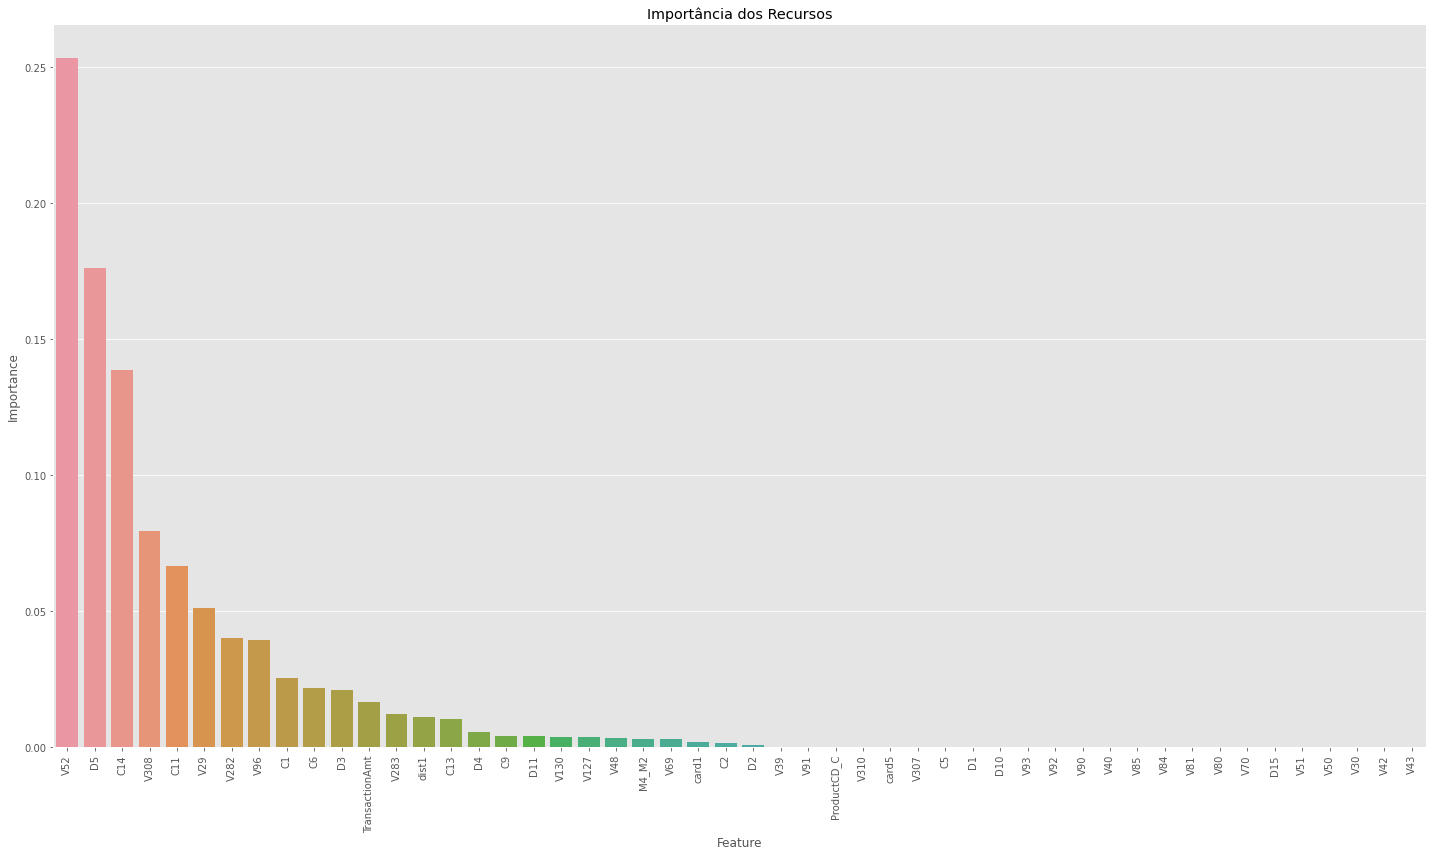

In [177]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.2985328792245219
F1-Score Negativo (Teste): 0.9515270561399062
F1-Score Positivo Médio (Validação Cruzada): 0.3330686728785571
F1-Score Positivo Fold 1: 0.3726235741444867
F1-Score Positivo Fold 2: 0.35160680529300564
F1-Score Positivo Fold 3: 0.3619402985074627
F1-Score Positivo Fold 4: 0.32504780114722753
F1-Score Positivo Fold 5: 0.3864915572232645
F1-Score Positivo Fold 6: 0.3383458646616541
F1-Score Positivo Fold 7: 0.3110236220472441
F1-Score Positivo Fold 8: 0.2862595419847328
F1-Score Positivo Fold 9: 0.2890625
F1-Score Positivo Fold 10: 0.30828516377649323
F1-Score Negativo Médio (Validação Cruzada): 0.9848728533629896
F1-Score Negativo Fold 1: 0.9857118115691029
F1-Score Negativo Fold 2: 0.9851470142467414
F1-Score Negativo Fold 3: 0.9851858269080828
F1-Score Negativo Fold 4: 0.9847179531581454
F1-Score Negativo Fold 5: 0.9858374117545152
F1-Score Negativo Fold 6: 0.9847553053269813
F1-Score Negativo Fold 7: 0.9848576620230164
F1-Score Negativo Fo

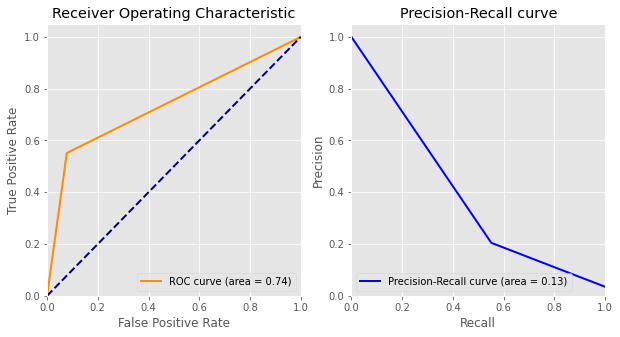

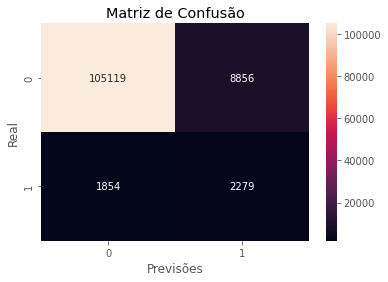

              precision    recall  f1-score   support

           0       0.98      0.92      0.95    113975
           1       0.20      0.55      0.30      4133

    accuracy                           0.91    118108
   macro avg       0.59      0.74      0.63    118108
weighted avg       0.96      0.91      0.93    118108

CPU times: user 6min 19s, sys: 2.99 s, total: 6min 22s
Wall time: 6min 21s


In [178]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], \
            y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_borderline_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [179]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_ada.predict_proba(X_test[oversample_with_borderline_smote_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 17.1 s, sys: 48 ms, total: 17.1 s
Wall time: 17.1 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.298532879224522  0.951527056139906
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.067620520120091                0.0
Threshold: 0.3   0.067620520120091                0.0
Threshold: 0.35  0.067620520120091                0.0
Threshold: 0.4   0.067620520120091                0.0
Threshold: 0.45  0.067620520120091                0.0
Threshold: 0.5   0.298532879224522  0.951527056139906
Threshold: 0.55                0.0  0.982191715894745
Threshold: 0.6                 0.0  0.982191715894745
Threshold: 0.65                0.0  0.982191715894745
Threshold: 0.7                 0.0  0.982191715894745
Threshold: 0.75                0.0  0.982191715894745

In [180]:
feature_importances = clf_ada.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_borderline_smote_cols_50_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature  Importance
40             V96        0.13
4               C1        0.11
11             C14        0.08
29             V52        0.05
43            V282        0.05
7               C6        0.05
0   TransactionAmt        0.04
14              D3        0.04
30             V69        0.04
3            dist1        0.04
44            V283        0.04
16              D5        0.04
9              C11        0.03
10             C13        0.03
18             D11        0.02
26             V48        0.02
1            card1        0.02
25             V43        0.02
17             D10        0.02
28             V51        0.01
47            V310        0.01
46            V308        0.01
5               C2        0.01
41            V127        0.01
6               C5        0.01
19             D15        0.01
8               C9        0.01
12              D1        0.01
49           M4_M2        0.01
15              D4        0.01
13              D2        0.01
24             V42        0.01
27             V50        0.00
23             V40        0.00
48     ProductCD_C        0.00
20             V29        0.00
21             V30        0.00
45            V307        0.00
2            card5        0.00
22             V39        0.00
42            V130        0.00
39             V93        0.00
38             V92        0.00
37             V91        0.00
36             V90        0.00
35             V85        0.00
33             V81        0.00
32             V80        0.00
31             V70        0.00
34             V84        0.00

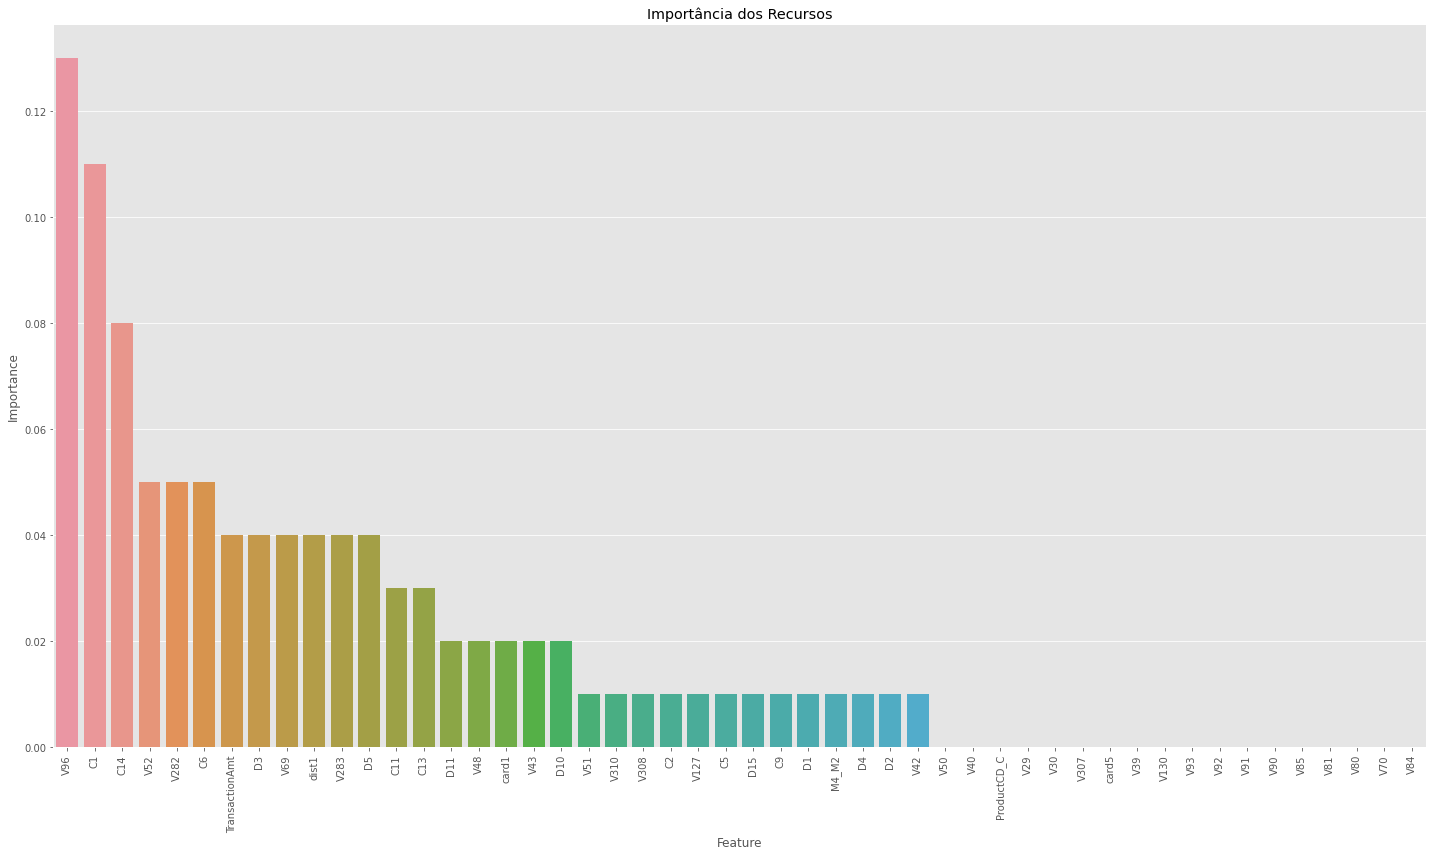

In [181]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.35136413814855705
F1-Score Negativo (Teste): 0.9632002290479301
F1-Score Positivo Médio (Validação Cruzada): 0.25627271844116345
F1-Score Positivo Fold 1: 0.2764811490125673
F1-Score Positivo Fold 2: 0.22222222222222224
F1-Score Positivo Fold 3: 0.2486865148861646
F1-Score Positivo Fold 4: 0.23674911660777387
F1-Score Positivo Fold 5: 0.288695652173913
F1-Score Positivo Fold 6: 0.2504347826086956
F1-Score Positivo Fold 7: 0.25473321858864023
F1-Score Positivo Fold 8: 0.24372759856630827
F1-Score Positivo Fold 9: 0.26548672566371684
F1-Score Positivo Fold 10: 0.2755102040816326
F1-Score Negativo Médio (Validação Cruzada): 0.9816018373747978
F1-Score Negativo Fold 1: 0.9825276392802949
F1-Score Negativo Fold 2: 0.9808718282368251
F1-Score Negativo Fold 3: 0.9813890937486444
F1-Score Negativo Fold 4: 0.981263011797363
F1-Score Negativo Fold 5: 0.9822536555733935
F1-Score Negativo Fold 6: 0.9812990844795418
F1-Score Negativo Fold 7: 0.9812074128727052
F1-Score 

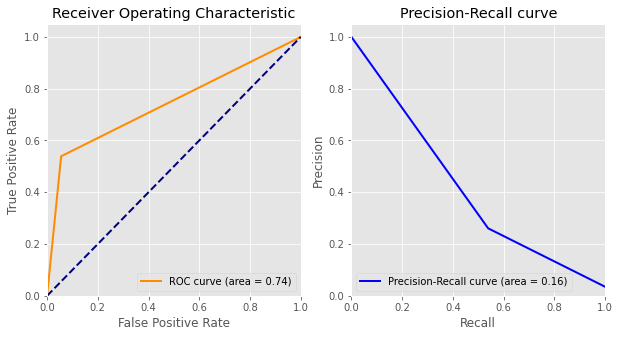

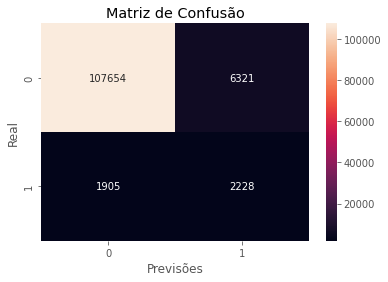

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    113975
           1       0.26      0.54      0.35      4133

    accuracy                           0.93    118108
   macro avg       0.62      0.74      0.66    118108
weighted avg       0.96      0.93      0.94    118108

CPU times: user 17min 41s, sys: 840 ms, total: 17min 42s
Wall time: 1min 35s


In [182]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_50_chi2], \
            y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_borderline_smote_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_borderline_smote_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [183]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_knn.predict_proba(X_test[oversample_with_borderline_smote_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 3h 44min 33s, sys: 1.75 s, total: 3h 44min 35s
Wall time: 18min 55s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.351364138148557   0.96320022904793
Threshold: 0.05  0.297115218517879  0.944221815041421
Threshold: 0.1   0.297115218517879  0.944221815041421
Threshold: 0.15  0.297115218517879  0.944221815041421
Threshold: 0.2   0.297115218517879  0.944221815041421
Threshold: 0.25  0.297115218517879  0.944221815041421
Threshold: 0.3   0.297115218517879  0.944221815041421
Threshold: 0.35  0.351364138148557   0.96320022904793
Threshold: 0.4   0.351364138148557   0.96320022904793
Threshold: 0.45  0.351364138148557   0.96320022904793
Threshold: 0.5   0.351364138148557   0.96320022904793
Threshold: 0.55  0.351364138148557   0.96320022904793
Threshold: 0.6   0.351364138148557   0.96320022904793
Threshold: 0.65  0.351364138148557   0.96320022904793
Threshold: 0.7   0.404215610934241  0.976103774872637
Threshold: 0.75  0.404215610934241  0.976103774872637

### 100 Chi-Square

In [184]:
#reinicializando os classificadores

clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)

F1-Score Positivo (Teste): 0.665955501371533
F1-Score Negativo (Teste): 0.9904552065280815
F1-Score Positivo Médio (Validação Cruzada): 0.4929123433233201
F1-Score Positivo Fold 1: 0.5301204819277109
F1-Score Positivo Fold 2: 0.4676258992805755
F1-Score Positivo Fold 3: 0.4973913043478261
F1-Score Positivo Fold 4: 0.5157894736842106
F1-Score Positivo Fold 5: 0.5214408233276159
F1-Score Positivo Fold 6: 0.5077186963979416
F1-Score Positivo Fold 7: 0.4751773049645391
F1-Score Positivo Fold 8: 0.4667863554757631
F1-Score Positivo Fold 9: 0.4802867383512545
F1-Score Positivo Fold 10: 0.466786355475763
F1-Score Negativo Médio (Validação Cruzada): 0.9875072838760955
F1-Score Negativo Fold 1: 0.9881515559220521
F1-Score Negativo Fold 2: 0.9871672591693402
F1-Score Negativo Fold 3: 0.9874604069944027
F1-Score Negativo Fold 4: 0.9880270692347736
F1-Score Negativo Fold 5: 0.9878900993966752
F1-Score Negativo Fold 6: 0.9875428621033898
F1-Score Negativo Fold 7: 0.987162806834938
F1-Score Negativo

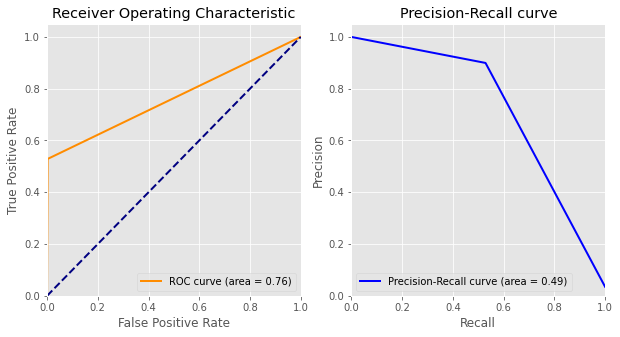

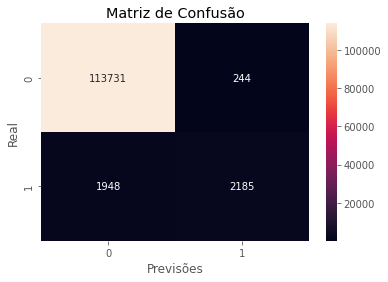

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.90      0.53      0.67      4133

    accuracy                           0.98    118108
   macro avg       0.94      0.76      0.83    118108
weighted avg       0.98      0.98      0.98    118108

CPU times: user 7min 15s, sys: 332 ms, total: 7min 15s
Wall time: 7min 15s


In [185]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], \
           y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_borderline_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [186]:
feature_importances = clf_et.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_borderline_smote_cols_100_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
79       P_emaildomain_gmail.com  0.051761773817192
67                   ProductCD_C  0.028667971076919
93                         M4_M2  0.027649714180941
96                          M6_F  0.023533929330243
97                          M6_T  0.022163876686568
95                          M5_T  0.021087980138947
15                            D2  0.020748086708600
0                 TransactionAmt  0.018251414208936
71                   ProductCD_W  0.017966627670976
94                          M5_F  0.017439942462635
59                          V283  0.017299475409262
2                          card2  0.016977433802780
58                          V282  0.016679880404835
1                          card1  0.015508860300517
6                             C1  0.014847364750146
57                          V280  0.014625620835382
37                           V51  0.014090933847919
13                           C14  0.013795354146189
64                     _Weekdays  0.013643070114066
69                   ProductCD_R  0.013056832690402
26                           V29  0.012889499334521
7                             C2  0.012663971094311
92                         M4_M0  0.012625549997576
80     P_emaildomain_hotmail.com  0.012622528915011
68                   ProductCD_H  0.012540940634559
41                           V69  0.012488523732294
98                          M8_F  0.012346127299252
65                        _Hours  0.012276454342422
50                           V91  0.012004320937204
91                          M3_T  0.011994122513085
99                          M8_T  0.011910388320705
74                    card4_visa  0.011661826959128
3                          card5  0.011580683714929
33                           V43  0.011544695524248
14                            D1  0.011482075165261
66                         _Days  0.011455197568709
73              card4_mastercard  0.011422035081398
90                          M3_F  0.011416555214732
42                           V70  0.011341790043688
12                           C13  0.011177074310253
49                           V90  0.011121813330346
11                           C11  0.011005191537543
38                           V52  0.010452924117530
4                          addr1  0.010069618244758
62                          V308  0.009842887640685
36                           V50  0.009813222780333
53                           V96  0.009599280013288
9                             C6  0.009248983344343
24                           V12  0.008794451114539
52                           V93  0.008702423208530
39                           V53  0.008687093669513
22                           V10  0.008659789799607
18                            D5  0.008659405067041
47                           V84  0.008587250141607
40                           V54  0.008579702638962
55                          V127  0.008550679949783
32                           V42  0.007981729782366
60                          V285  0.007759555669996
61                          V307  0.007677657440090
48                           V85  0.007664150851627
28                           V35  0.007440504269486
34                           V48  0.007367392448839
21                           D15  0.007289227081293
23                           V11  0.007208267917861
16                            D3  0.007112418070255
43                           V75  0.007077487631969
63                          V310  0.006995293597719
72                card4_discover  0.006899341114374
30                           V39  0.006861126779683
17                            D4  0.006743872269897
29                           V36  0.006722871808989
31                           V40  0.006596319967643
20                           D11  0.006441708708449
25                           V13  0.006377176518642
19                           D10  0.006320063569444
44                           V76  0.006309289751142
27                   

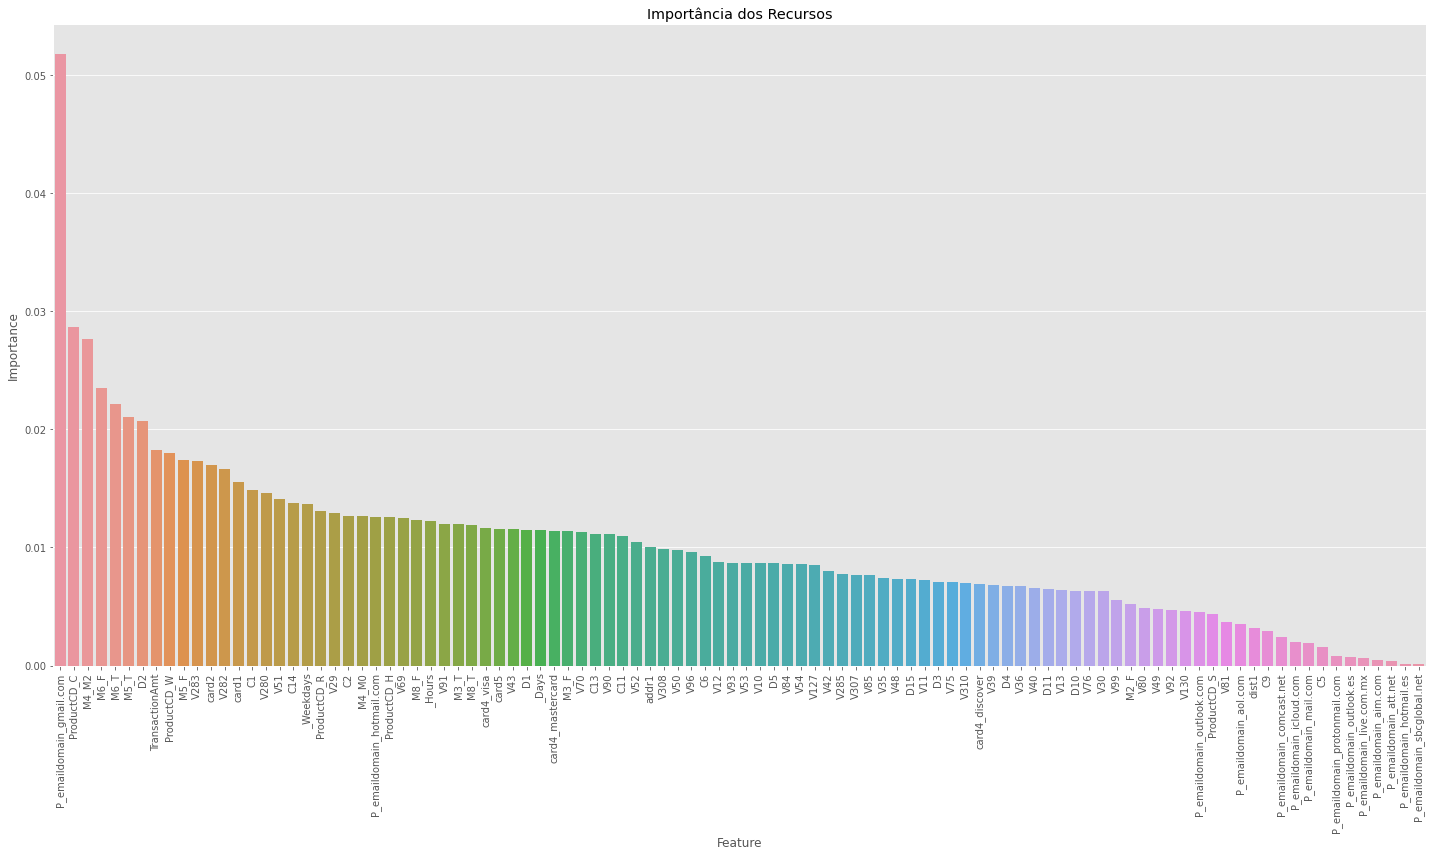

In [187]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [188]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_et.predict_proba(X_test[oversample_with_borderline_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 48.4 s, sys: 36 ms, total: 48.5 s
Wall time: 48.5 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.665955501371533  0.990455206528081
Threshold: 0.05  0.276082381238725   0.90810465249418
Threshold: 0.1   0.446528591897877  0.961523485253235
Threshold: 0.15  0.569728783902012  0.978121413255274
Threshold: 0.2   0.639699749791493  0.984750070601525
Threshold: 0.25  0.684609111033438  0.988108051117369
Threshold: 0.3   0.705971277399849  0.989775624457898
Threshold: 0.35  0.707745541655576  0.990397985150983
Threshold: 0.4   0.704799107142857    0.9907617617268
Threshold: 0.45  0.691056910569106  0.990720714435219
Threshold: 0.5   0.670492298399275  0.990496267324059
Threshold: 0.55  0.648107600875821  0.990209814552132
Threshold: 0.6   0.621525533290239  0.989818630775384
Threshold: 0.65  0.588844355377422  0.989306252931876
Threshold: 0.7   0.550604490500864  0.988707871507556
Threshold: 0.75  0.502246989034694  0.987994953458225

F1-Score Positivo (Teste): 0.46173941438989874
F1-Score Negativo (Teste): 0.9782186416713283
F1-Score Positivo Médio (Validação Cruzada): 0.4267209652930908
F1-Score Positivo Fold 1: 0.43546576879910215
F1-Score Positivo Fold 2: 0.4601571268237935
F1-Score Positivo Fold 3: 0.44071588366890374
F1-Score Positivo Fold 4: 0.4257206208425721
F1-Score Positivo Fold 5: 0.4316877152698049
F1-Score Positivo Fold 6: 0.39436619718309857
F1-Score Positivo Fold 7: 0.4447058823529412
F1-Score Positivo Fold 8: 0.3895809739524349
F1-Score Positivo Fold 9: 0.40934371523915464
F1-Score Positivo Fold 10: 0.43546576879910215
F1-Score Negativo Médio (Validação Cruzada): 0.9775596840605534
F1-Score Negativo Fold 1: 0.9778716290528352
F1-Score Negativo Fold 2: 0.9788394703268664
F1-Score Negativo Fold 3: 0.9780007039774727
F1-Score Negativo Fold 4: 0.9772007042253522
F1-Score Negativo Fold 5: 0.9782427146059514
F1-Score Negativo Fold 6: 0.9753733644653949
F1-Score Negativo Fold 7: 0.9792727911470226
F1-Score

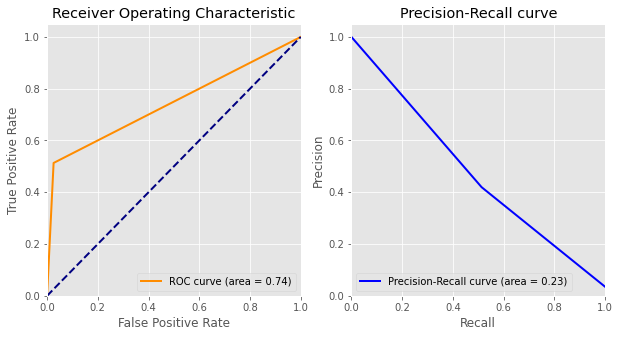

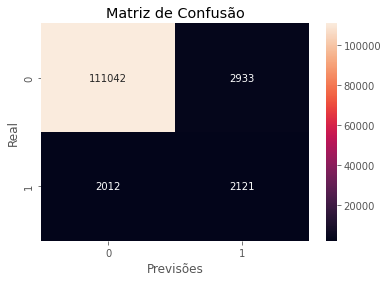

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    113975
           1       0.42      0.51      0.46      4133

    accuracy                           0.96    118108
   macro avg       0.70      0.74      0.72    118108
weighted avg       0.96      0.96      0.96    118108

CPU times: user 1min 29s, sys: 368 ms, total: 1min 29s
Wall time: 1min 29s


In [189]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], \
           y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_borderline_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [190]:
feature_importances = clf_dt.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_borderline_smote_cols_100_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
57                          V280  0.214223190016333
38                           V52  0.172294961461190
6                             C1  0.130315958448706
13                           C14  0.055954081861480
26                           V29  0.050132168151828
36                           V50  0.043616087586584
58                          V282  0.033031439349961
62                          V308  0.028161233003128
12                           C13  0.022652391219064
1                          card1  0.015199817932447
0                 TransactionAmt  0.013754213230572
2                          card2  0.011211296154459
18                            D5  0.010282367472796
4                          addr1  0.009672551352170
7                             C2  0.008167625726138
79       P_emaildomain_gmail.com  0.008134880977922
9                             C6  0.008049356366683
15                            D2  0.007064202298430
39                           V53  0.007008630920173
53                           V96  0.006305157056253
94                          M5_F  0.006160244018092
66                         _Days  0.005965949019883
11                           C11  0.005862367238803
93                         M4_M2  0.005562241610565
3                          card5  0.005036039625057
19                           D10  0.004749258611755
80     P_emaildomain_hotmail.com  0.004692127742485
65                        _Hours  0.004316281524745
5                          dist1  0.004256175053558
10                            C9  0.004216357213321
17                            D4  0.004117843968713
21                           D15  0.003598430862632
60                          V285  0.003502877691169
64                     _Weekdays  0.003366362602427
16                            D3  0.003343323018616
59                          V283  0.003314609828619
63                          V310  0.003243990386204
61                          V307  0.003227363193918
29                           V36  0.002883325400139
27                           V30  0.002780764392362
98                          M8_F  0.002657897552857
49                           V90  0.002507155837710
72                card4_discover  0.002501911209121
14                            D1  0.002327076201782
20                           D11  0.002216541438259
68                   ProductCD_H  0.002155652749758
69                   ProductCD_R  0.002075424338390
55                          V127  0.001967761577762
91                          M3_T  0.001798139074272
95                          M5_T  0.001679474017249
40                           V54  0.001660479803492
92                         M4_M0  0.001560873856115
54                           V99  0.001547392291543
74                    card4_visa  0.001518189582079
37                           V51  0.001448936712095
44                           V76  0.001386655900077
85     P_emaildomain_outlook.com  0.001341851349877
99                          M8_T  0.001303446033789
43                           V75  0.001231840421793
23                           V11  0.001211523899222
8                             C5  0.001196670318665
56                          V130  0.001177037854407
50                           V91  0.001174938186452
73              card4_mastercard  0.001098057769361
48                           V85  0.001060666071455
32                           V42  0.001024023875797
24                           V12  0.001020286376055
78     P_emaildomain_comcast.net  0.000956942883727
96                          M6_F  0.000953590332924
46                           V81  0.000945809554261
84        P_emaildomain_mail.com  0.000820619044081
70                   ProductCD_S  0.000811983626401
33                           V43  0.000701619518179
90                          M3_F  0.000698061489635
76         P_emaildomain_aol.com  0.000697806218526
45                           V80  0.000671055596372
34                   

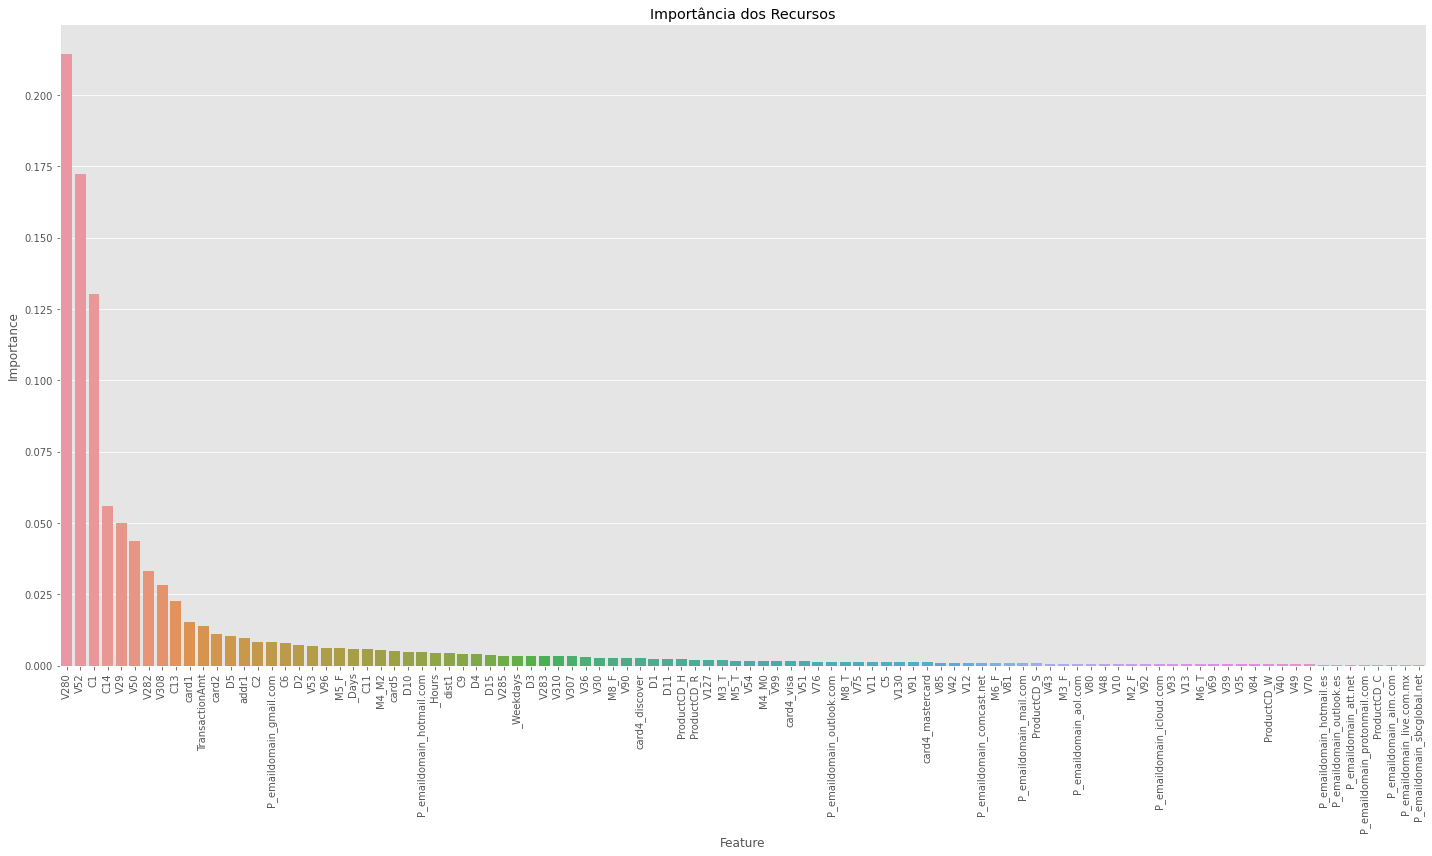

In [191]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [192]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_dt.predict_proba(X_test[oversample_with_borderline_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 1.23 s, sys: 52 ms, total: 1.28 s
Wall time: 1.28 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.461739414389899  0.978218641671328
Threshold: 0.05  0.461689159773618  0.978214140987015
Threshold: 0.1   0.461689159773618  0.978214140987015
Threshold: 0.15  0.461689159773618  0.978214140987015
Threshold: 0.2   0.461689159773618  0.978214140987015
Threshold: 0.25  0.461689159773618  0.978214140987015
Threshold: 0.3   0.461689159773618  0.978214140987015
Threshold: 0.35  0.461689159773618  0.978214140987015
Threshold: 0.4   0.461689159773618  0.978214140987015
Threshold: 0.45  0.461689159773618  0.978214140987015
Threshold: 0.5   0.461689159773618  0.978214140987015
Threshold: 0.55  0.461739414389899  0.978218641671328
Threshold: 0.6   0.461739414389899  0.978218641671328
Threshold: 0.65  0.461739414389899  0.978218641671328
Threshold: 0.7   0.461739414389899  0.978218641671328
Threshold: 0.75  0.461739414389899  0.978218641671328

0:	learn: 0.6132321	total: 74.7ms	remaining: 299ms
1:	learn: 0.5470238	total: 142ms	remaining: 212ms
2:	learn: 0.5037906	total: 206ms	remaining: 137ms
3:	learn: 0.4669084	total: 277ms	remaining: 69.1ms
4:	learn: 0.4279325	total: 344ms	remaining: 0us
0:	learn: 0.5489121	total: 7.17ms	remaining: 28.7ms
1:	learn: 0.4308472	total: 14.3ms	remaining: 21.4ms
2:	learn: 0.3491787	total: 22ms	remaining: 14.7ms
3:	learn: 0.2883795	total: 29.6ms	remaining: 7.41ms
4:	learn: 0.2435547	total: 37.7ms	remaining: 0us
0:	learn: 0.5488396	total: 7.25ms	remaining: 29ms
1:	learn: 0.4309777	total: 14.3ms	remaining: 21.4ms
2:	learn: 0.3493538	total: 22ms	remaining: 14.7ms
3:	learn: 0.2883847	total: 30ms	remaining: 7.49ms
4:	learn: 0.2447842	total: 37.5ms	remaining: 0us
0:	learn: 0.5486576	total: 12.7ms	remaining: 50.6ms
1:	learn: 0.4308392	total: 21.7ms	remaining: 32.5ms
2:	learn: 0.3491236	total: 29.9ms	remaining: 19.9ms
3:	learn: 0.2882263	total: 37.6ms	remaining: 9.41ms
4:	learn: 0.2446844	total: 45.1ms	re

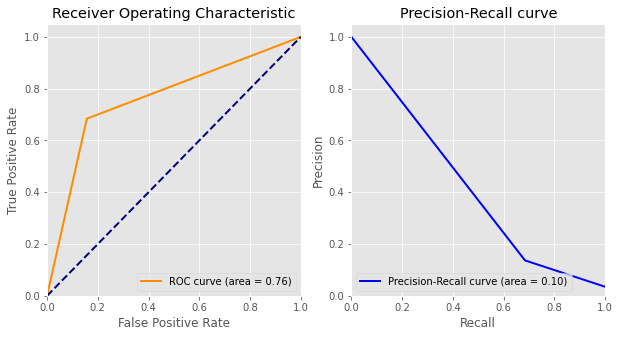

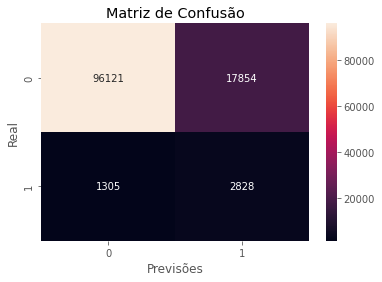

              precision    recall  f1-score   support

           0       0.99      0.84      0.91    113975
           1       0.14      0.68      0.23      4133

    accuracy                           0.84    118108
   macro avg       0.56      0.76      0.57    118108
weighted avg       0.96      0.84      0.89    118108

CPU times: user 55.5 s, sys: 740 ms, total: 56.2 s
Wall time: 36.7 s


In [193]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], \
           y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_borderline_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [194]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_cb.predict_proba(X_test[oversample_with_borderline_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 15.8 s, sys: 8.07 ms, total: 15.8 s
Wall time: 15.3 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.227926657263752  0.909371289634391
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.070241717665561  0.087585975507465
Threshold: 0.25  0.078470726930834  0.291932115077969
Threshold: 0.3   0.101209327186477  0.583216115899641
Threshold: 0.35  0.148799650807508  0.795153259522259
Threshold: 0.4   0.171037748257267   0.84100483852251
Threshold: 0.45  0.201771686444927  0.884251651712789
Threshold: 0.5   0.227926657263752  0.909371289634391
Threshold: 0.55   0.27909975383894  0.943875083274775
Threshold: 0.6    0.32854893971664  0.967832949600075
Threshold: 0.65  0.345340875260494  0.980836434304438
Threshold: 0.7   0.298387096774194  0.983411336453458
Threshold: 0.75  0.146760687527545  0.983287148542373

In [195]:
feature_importances = clf_cb.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_borderline_smote_cols_100_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature          Importance
57                          V280  35.399859971836023
13                           C14  19.606803677040904
12                           C13   7.361084242665993
6                             C1   6.125998308302847
38                           V52   5.587590441121065
11                           C11   3.488585004809050
26                           V29   3.327803273332760
18                            D5   3.152638770246537
9                             C6   2.733233388266210
48                           V85   2.584565480190193
59                          V283   2.180772711416222
62                          V308   2.020467330869366
41                           V69   1.870819512511636
7                             C2   1.463704442024618
36                           V50   1.302099513125238
79       P_emaildomain_gmail.com   0.914744022850179
58                          V282   0.879229909391141
72                card4_discover   0.000000000000000
73              card4_mastercard   0.000000000000000
71                   ProductCD_W   0.000000000000000
70                   ProductCD_S   0.000000000000000
65                        _Hours   0.000000000000000
69                   ProductCD_R   0.000000000000000
68                   ProductCD_H   0.000000000000000
67                   ProductCD_C   0.000000000000000
66                         _Days   0.000000000000000
75         P_emaildomain_aim.com   0.000000000000000
64                     _Weekdays   0.000000000000000
63                          V310   0.000000000000000
61                          V307   0.000000000000000
60                          V285   0.000000000000000
74                    card4_visa   0.000000000000000
0                 TransactionAmt   0.000000000000000
76         P_emaildomain_aol.com   0.000000000000000
89                          M2_F   0.000000000000000
98                          M8_F   0.000000000000000
97                          M6_T   0.000000000000000
96                          M6_F   0.000000000000000
95                          M5_T   0.000000000000000
94                          M5_F   0.000000000000000
93                         M4_M2   0.000000000000000
92                         M4_M0   0.000000000000000
91                          M3_T   0.000000000000000
90                          M3_F   0.000000000000000
88   P_emaildomain_sbcglobal.net   0.000000000000000
77         P_emaildomain_att.net   0.000000000000000
87  P_emaildomain_protonmail.com   0.000000000000000
86      P_emaildomain_outlook.es   0.000000000000000
85     P_emaildomain_outlook.com   0.000000000000000
84        P_emaildomain_mail.com   0.000000000000000
83     P_emaildomain_live.com.mx   0.000000000000000
82      P_emaildomain_icloud.com   0.000000000000000
81      P_emaildomain_hotmail.es   0.000000000000000
56                          V130   0.000000000000000
78     P_emaildomain_comcast.net   0.000000000000000
80     P_emaildomain_hotmail.com   0.000000000000000
50                           V91   0.000000000000000
55                          V127   0.000000000000000
17                            D4   0.000000000000000
27                           V30   0.000000000000000
25                           V13   0.000000000000000
24                           V12   0.000000000000000
23                           V11   0.000000000000000
22                           V10   0.000000000000000
21                           D15   0.000000000000000
20                           D11   0.000000000000000
19                           D10   0.000000000000000
16                            D3   0.000000000000000
29                           V36   0.000000000000000
15                            D2   0.000000000000000
14                            D1   0.000000000000000
10                            C9   0.000000000000000
8                             C5   0.000000000000000
5                          dist1   0.000000000000000
4                          addr1   0.0000000000000

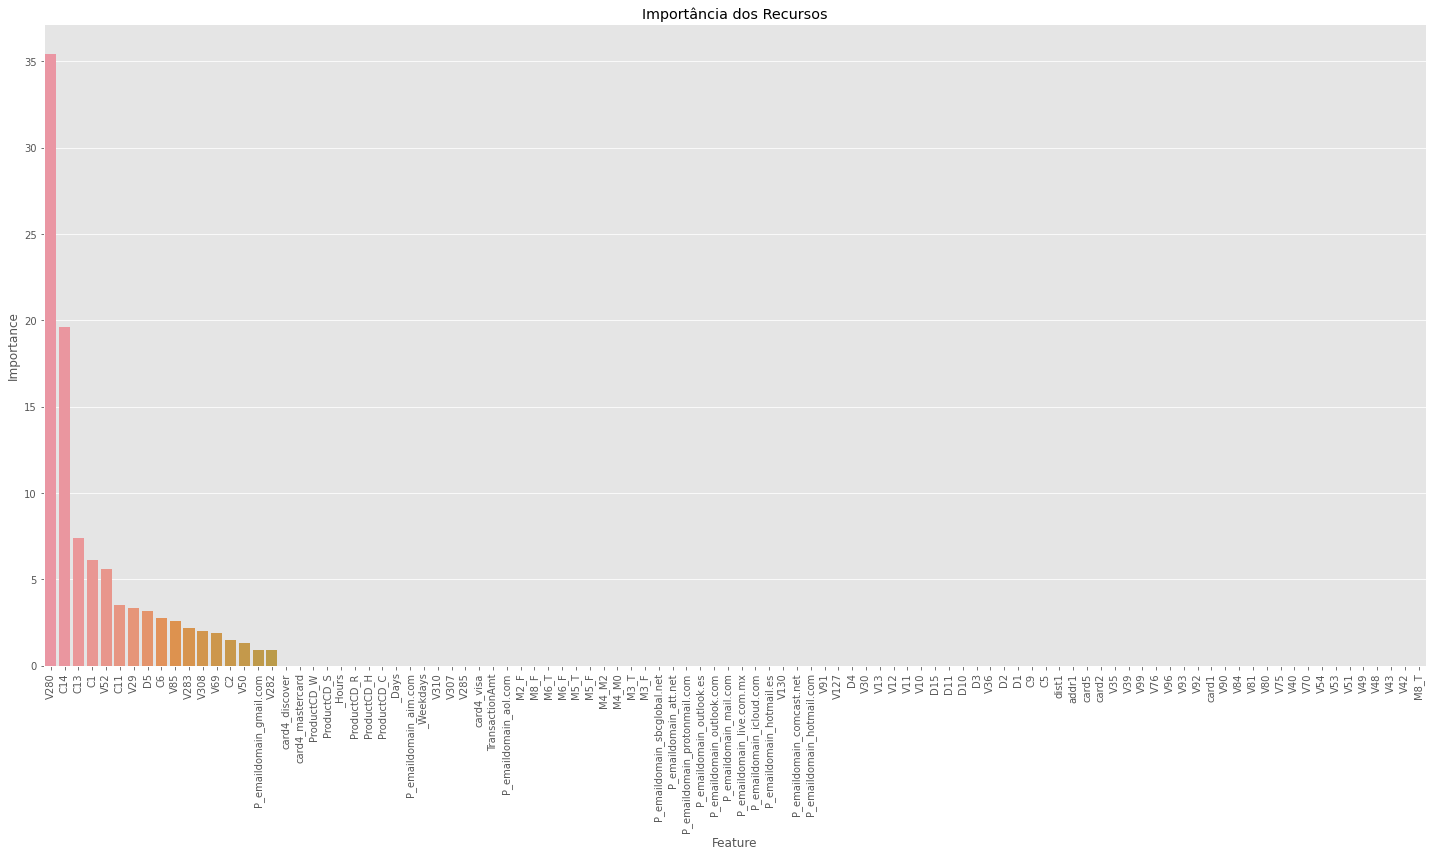

In [196]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.3261994900718535
F1-Score Negativo (Teste): 0.9609401942912936
F1-Score Positivo Médio (Validação Cruzada): 0.2849038761018639
F1-Score Positivo Fold 1: 0.3660377358490566
F1-Score Positivo Fold 2: 0.3230769230769231
F1-Score Positivo Fold 3: 0.4037037037037037
F1-Score Positivo Fold 4: 0.381651376146789
F1-Score Positivo Fold 5: 0.3365200764818356
F1-Score Positivo Fold 6: 0.34651600753295664
F1-Score Positivo Fold 7: 0.09746588693957114
F1-Score Positivo Fold 8: 0.2613861386138614
F1-Score Positivo Fold 9: 0.22672064777327935
F1-Score Positivo Fold 10: 0.10596026490066224
F1-Score Negativo Médio (Validação Cruzada): 0.9841438622969265
F1-Score Negativo Fold 1: 0.985449506322536
F1-Score Negativo Fold 2: 0.9847632239632932
F1-Score Negativo Fold 3: 0.9860497357248073
F1-Score Negativo Fold 4: 0.9853967153442821
F1-Score Negativo Fold 5: 0.9849777046625394
F1-Score Negativo Fold 6: 0.9849725001082673
F1-Score Negativo Fold 7: 0.9799645159894415
F1-Score Neg

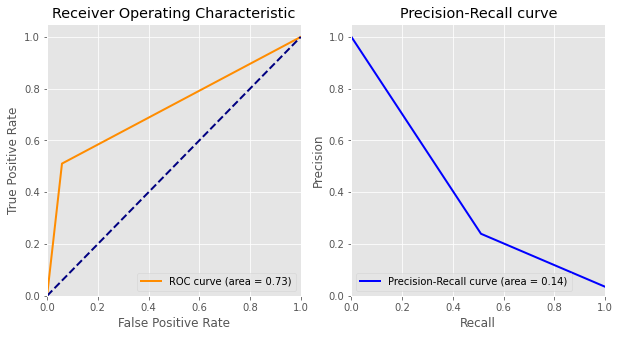

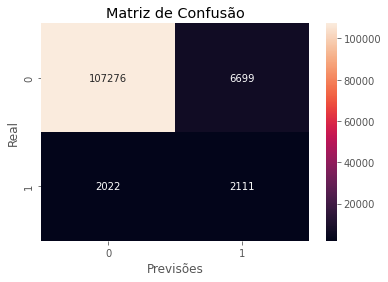

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    113975
           1       0.24      0.51      0.33      4133

    accuracy                           0.93    118108
   macro avg       0.61      0.73      0.64    118108
weighted avg       0.96      0.93      0.94    118108

CPU times: user 7min 34s, sys: 368 ms, total: 7min 35s
Wall time: 7min 34s


In [197]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], \
            y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_borderline_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [198]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_gbc.predict_proba(X_test[oversample_with_borderline_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2.7 s, sys: 92 ms, total: 2.79 s
Wall time: 2.79 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.326199490071854  0.960940194291294
Threshold: 0.05  0.104031568200006   0.60340299747157
Threshold: 0.1   0.135469089627352  0.761548806636817
Threshold: 0.15  0.165727373324069   0.83573422782065
Threshold: 0.2   0.195636553661245  0.880212842537379
Threshold: 0.25  0.222389299988129  0.906843015952025
Threshold: 0.3    0.24735277726175  0.924512306459727
Threshold: 0.35  0.267028811844278  0.936704087123285
Threshold: 0.4    0.29003645200486  0.946822839876954
Threshold: 0.45  0.307734541211996  0.954490288524442
Threshold: 0.5   0.326199490071854  0.960940194291294
Threshold: 0.55  0.341889296315698  0.966462302346482
Threshold: 0.6   0.353507565337001   0.97088985037914
Threshold: 0.65  0.368380491027194  0.974741671179441
Threshold: 0.7   0.367387276096356  0.977551387202406
Threshold: 0.75  0.359157836796477  0.979659225417014

In [199]:
feature_importances = clf_gbc.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_borderline_smote_cols_100_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
38                           V52  0.243714411366331
18                            D5  0.165108334193798
57                          V280  0.128087959878964
13                           C14  0.125871115492859
41                           V69  0.057073702092885
11                           C11  0.053736068011583
9                             C6  0.023110569621820
79       P_emaildomain_gmail.com  0.023096045551237
58                          V282  0.021555541705097
6                             C1  0.015979055645349
16                            D3  0.014789148496250
0                 TransactionAmt  0.012989898129365
65                        _Hours  0.011295167693672
53                           V96  0.010235567816573
64                     _Weekdays  0.009127302846459
22                           V10  0.008111721693431
62                          V308  0.008047178196795
12                           C13  0.006873890768823
95                          M5_T  0.006199871766526
17                            D4  0.005388396834302
94                          M5_F  0.005251853472167
23                           V11  0.004284129165671
72                card4_discover  0.003900257320749
96                          M6_F  0.003893926390555
91                          M3_T  0.003423492798122
90                          M3_F  0.003023052896868
55                          V127  0.002483859845343
97                          M6_T  0.002445709229648
40                           V54  0.002348727585018
10                            C9  0.002305168170444
74                    card4_visa  0.002301422709074
56                          V130  0.002223261492586
80     P_emaildomain_hotmail.com  0.002157831764461
5                          dist1  0.001542877277095
73              card4_mastercard  0.001434684281761
1                          card1  0.001284357367681
34                           V48  0.001018381490427
85     P_emaildomain_outlook.com  0.000958662594687
60                          V285  0.000925308143206
78     P_emaildomain_comcast.net  0.000887351681052
54                           V99  0.000845275487565
2                          card2  0.000669461033701
84        P_emaildomain_mail.com  0.000000000000000
66                         _Days  0.000000000000000
88   P_emaildomain_sbcglobal.net  0.000000000000000
92                         M4_M0  0.000000000000000
89                          M2_F  0.000000000000000
98                          M8_F  0.000000000000000
67                   ProductCD_C  0.000000000000000
71                   ProductCD_W  0.000000000000000
68                   ProductCD_H  0.000000000000000
69                   ProductCD_R  0.000000000000000
70                   ProductCD_S  0.000000000000000
83     P_emaildomain_live.com.mx  0.000000000000000
87  P_emaildomain_protonmail.com  0.000000000000000
75         P_emaildomain_aim.com  0.000000000000000
86      P_emaildomain_outlook.es  0.000000000000000
93                         M4_M2  0.000000000000000
76         P_emaildomain_aol.com  0.000000000000000
77         P_emaildomain_att.net  0.000000000000000
81      P_emaildomain_hotmail.es  0.000000000000000
63                          V310  0.000000000000000
82      P_emaildomain_icloud.com  0.000000000000000
50                           V91  0.000000000000000
61                          V307  0.000000000000000
59                          V283  0.000000000000000
29                           V36  0.000000000000000
28                           V35  0.000000000000000
27                           V30  0.000000000000000
26                           V29  0.000000000000000
25                           V13  0.000000000000000
24                           V12  0.000000000000000
21                           D15  0.000000000000000
20                           D11  0.000000000000000
19                           D10  0.000000000000000
15                            D2  0.000000000000000
14                   

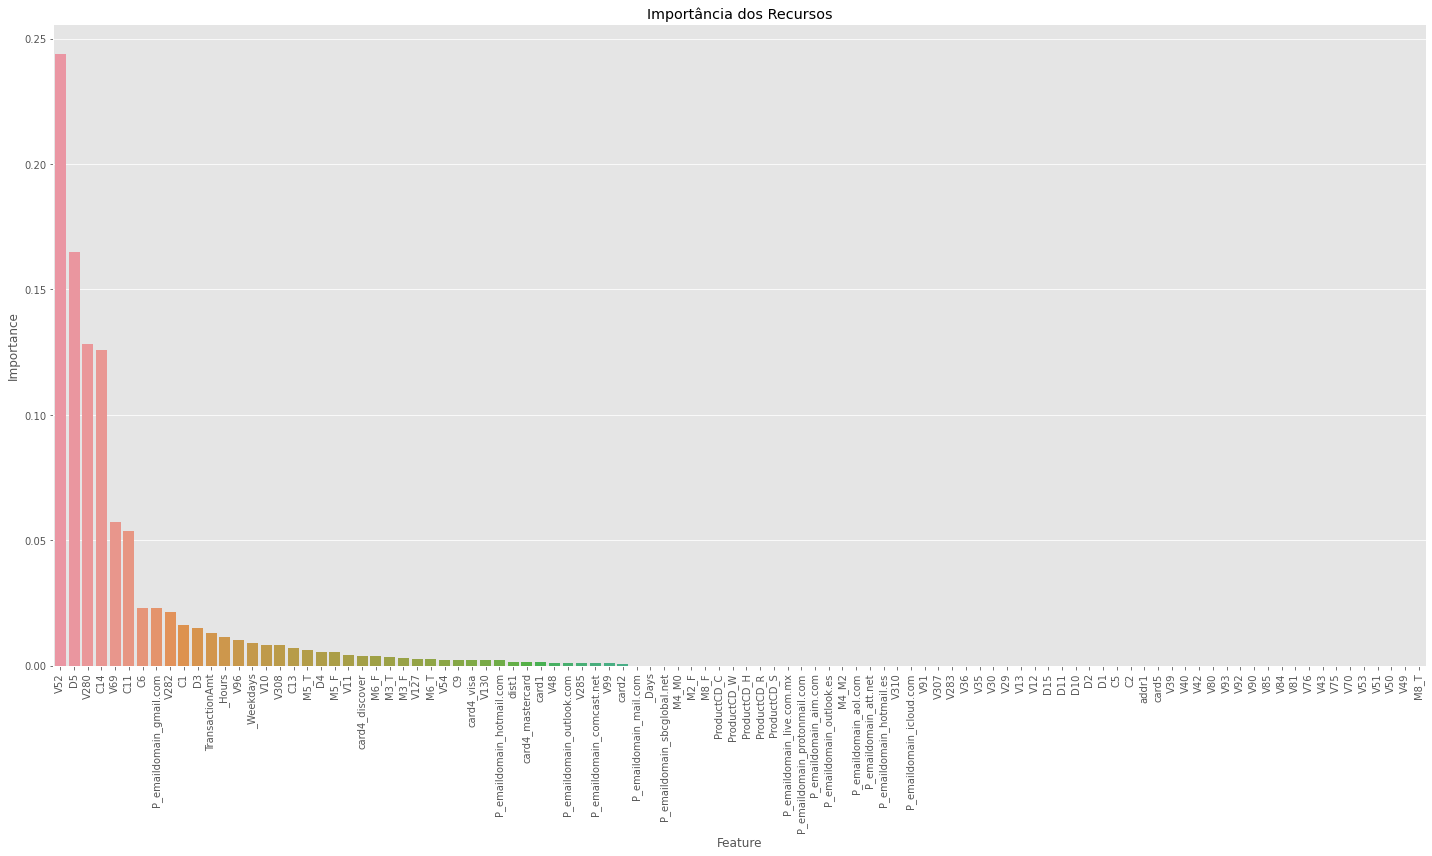

In [200]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.31049636193357827
F1-Score Negativo (Teste): 0.9569523466840579
F1-Score Positivo Médio (Validação Cruzada): 0.3324930647429828
F1-Score Positivo Fold 1: 0.39325842696629215
F1-Score Positivo Fold 2: 0.3522727272727273
F1-Score Positivo Fold 3: 0.3403441682600382
F1-Score Positivo Fold 4: 0.29885057471264365
F1-Score Positivo Fold 5: 0.3474903474903475
F1-Score Positivo Fold 6: 0.3733826247689464
F1-Score Positivo Fold 7: 0.34615384615384615
F1-Score Positivo Fold 8: 0.26719056974459726
F1-Score Positivo Fold 9: 0.2796116504854369
F1-Score Positivo Fold 10: 0.32637571157495254
F1-Score Negativo Médio (Validação Cruzada): 0.9848775721883074
F1-Score Negativo Fold 1: 0.9859667359667359
F1-Score Negativo Fold 2: 0.9851909586905689
F1-Score Negativo Fold 3: 0.9850642884973376
F1-Score Negativo Fold 4: 0.984155844155844
F1-Score Negativo Fold 5: 0.9853704986149584
F1-Score Negativo Fold 6: 0.9853125947749231
F1-Score Negativo Fold 7: 0.985282659509999
F1-Score N

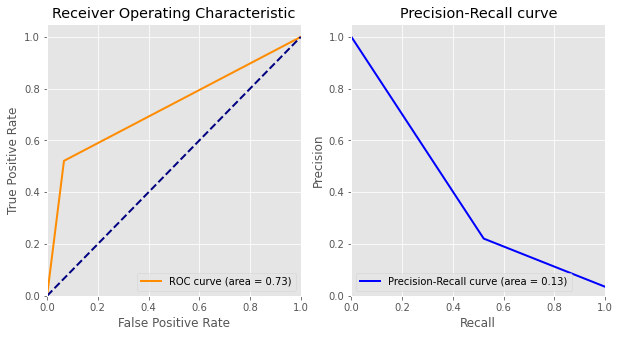

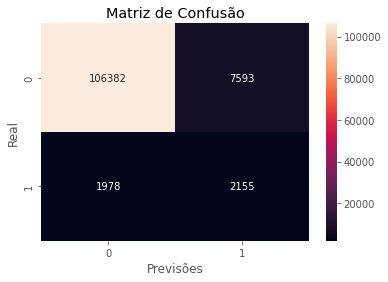

              precision    recall  f1-score   support

           0       0.98      0.93      0.96    113975
           1       0.22      0.52      0.31      4133

    accuracy                           0.92    118108
   macro avg       0.60      0.73      0.63    118108
weighted avg       0.96      0.92      0.93    118108

CPU times: user 9min 15s, sys: 5.45 s, total: 9min 21s
Wall time: 9min 21s


In [201]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], \
            y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_borderline_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [202]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_ada.predict_proba(X_test[oversample_with_borderline_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 24.5 s, sys: 88 ms, total: 24.6 s
Wall time: 24.6 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.310496361933578  0.956952346684058
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.067620520120091                0.0
Threshold: 0.3   0.067620520120091                0.0
Threshold: 0.35  0.067620520120091                0.0
Threshold: 0.4   0.067620520120091                0.0
Threshold: 0.45  0.067620520120091                0.0
Threshold: 0.5   0.310496361933578  0.956952346684058
Threshold: 0.55                0.0  0.982191715894745
Threshold: 0.6                 0.0  0.982191715894745
Threshold: 0.65                0.0  0.982191715894745
Threshold: 0.7                 0.0  0.982191715894745
Threshold: 0.75                0.0  0.982191715894745

In [203]:
feature_importances = clf_ada.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_borderline_smote_cols_100_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature  Importance
57                          V280        0.13
13                           C14        0.05
6                             C1        0.05
53                           V96        0.04
9                             C6        0.04
22                           V10        0.04
65                        _Hours        0.04
18                            D5        0.03
62                          V308        0.03
11                           C11        0.03
0                 TransactionAmt        0.02
41                           V69        0.02
60                          V285        0.02
74                    card4_visa        0.02
90                          M3_F        0.02
93                         M4_M2        0.02
95                          M5_T        0.02
96                          M6_F        0.02
97                          M6_T        0.02
98                          M8_F        0.02
38                           V52        0.02
99                          M8_T        0.02
12                           C13        0.02
10                            C9        0.02
5                          dist1        0.02
16                            D3        0.02
17                            D4        0.01
78     P_emaildomain_comcast.net        0.01
1                          card1        0.01
73              card4_mastercard        0.01
72                card4_discover        0.01
56                          V130        0.01
55                          V127        0.01
40                           V54        0.01
58                          V282        0.01
59                          V283        0.01
23                           V11        0.01
64                     _Weekdays        0.01
80     P_emaildomain_hotmail.com        0.01
79       P_emaildomain_gmail.com        0.01
2                          card2        0.01
85     P_emaildomain_outlook.com        0.01
4                          addr1        0.01
94                          M5_F        0.01
92                         M4_M0        0.01
91                          M3_T        0.01
83     P_emaildomain_live.com.mx        0.00
71                   ProductCD_W        0.00
68                   ProductCD_H        0.00
69                   ProductCD_R        0.00
3                          card5        0.00
70                   ProductCD_S        0.00
7                             C2        0.00
8                             C5        0.00
82      P_emaildomain_icloud.com        0.00
89                          M2_F        0.00
88   P_emaildomain_sbcglobal.net        0.00
87  P_emaildomain_protonmail.com        0.00
86      P_emaildomain_outlook.es        0.00
75         P_emaildomain_aim.com        0.00
76         P_emaildomain_aol.com        0.00
77         P_emaildomain_att.net        0.00
67                   ProductCD_C        0.00
84        P_emaildomain_mail.com        0.00
81      P_emaildomain_hotmail.es        0.00
21                           D15        0.00
61                          V307        0.00
66                         _Days        0.00
20                           D11        0.00
24                           V12        0.00
25                           V13        0.00
26                           V29        0.00
27                           V30        0.00
28                           V35        0.00
29                           V36        0.00
30                           V39        0.00
31                           V40        0.00
32                           V42        0.00
33                           V43        0.00
34                           V48        0.00
35                           V49        0.00
36                           V50        0.00
37                           V51        0.00
39                           V53        0.00
63                          V310        0.00
19                           D10        0.00
42                           V70        0.00
43                           V75        0.00
44                  

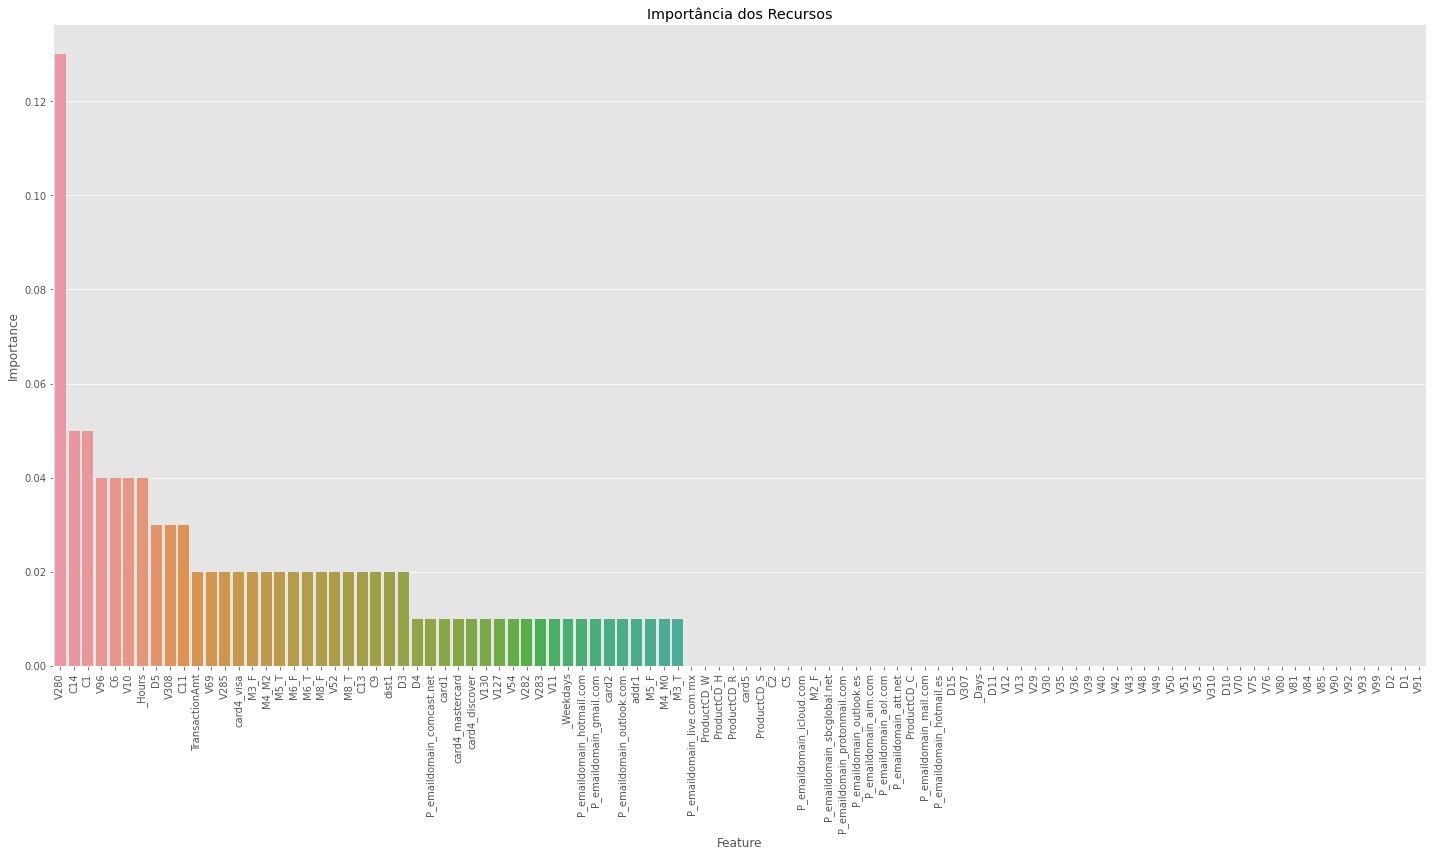

In [204]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.36950527169505276
F1-Score Negativo (Teste): 0.9652769713157588
F1-Score Positivo Médio (Validação Cruzada): 0.26579247404413464
F1-Score Positivo Fold 1: 0.2636203866432338
F1-Score Positivo Fold 2: 0.2491349480968858
F1-Score Positivo Fold 3: 0.2539130434782609
F1-Score Positivo Fold 4: 0.23633156966490299
F1-Score Positivo Fold 5: 0.2901554404145078
F1-Score Positivo Fold 6: 0.24834437086092717
F1-Score Positivo Fold 7: 0.2694300518134715
F1-Score Positivo Fold 8: 0.25874125874125875
F1-Score Positivo Fold 9: 0.2852233676975945
F1-Score Positivo Fold 10: 0.30303030303030304
F1-Score Negativo Médio (Validação Cruzada): 0.9815247153164739
F1-Score Negativo Fold 1: 0.9818244913894071
F1-Score Negativo Fold 2: 0.9811664641555284
F1-Score Negativo Fold 3: 0.981385863669892
F1-Score Negativo Fold 4: 0.9812188245499891
F1-Score Negativo Fold 5: 0.9821637807577138
F1-Score Negativo Fold 6: 0.9802763055000434
F1-Score Negativo Fold 7: 0.9816430152323916
F1-Score 

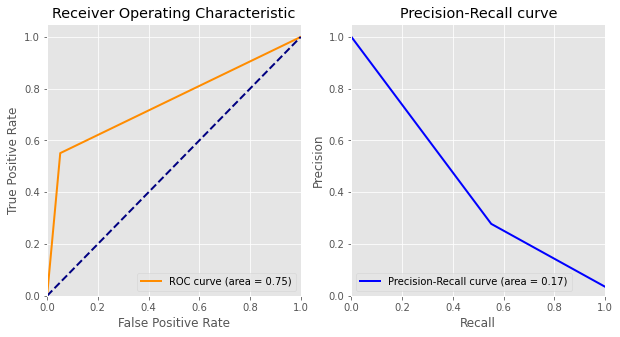

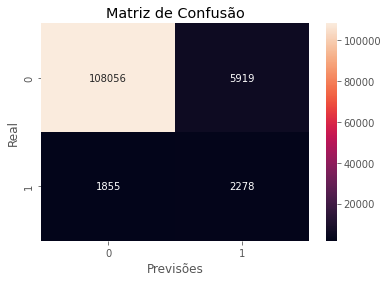

              precision    recall  f1-score   support

           0       0.98      0.95      0.97    113975
           1       0.28      0.55      0.37      4133

    accuracy                           0.93    118108
   macro avg       0.63      0.75      0.67    118108
weighted avg       0.96      0.93      0.94    118108

CPU times: user 27min 12s, sys: 1.05 s, total: 27min 13s
Wall time: 2min 24s


In [205]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_borderline_smote[oversample_with_borderline_smote_cols_100_chi2], \
            y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_borderline_smote_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_borderline_smote_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [206]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_knn.predict_proba(X_test[oversample_with_borderline_smote_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 5h 37min 14s, sys: 1.21 s, total: 5h 37min 16s
Wall time: 28min 26s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.369505271695053  0.965276971315759
Threshold: 0.05  0.309746812496223  0.947998561458936
Threshold: 0.1   0.309746812496223  0.947998561458936
Threshold: 0.15  0.309746812496223  0.947998561458936
Threshold: 0.2   0.309746812496223  0.947998561458936
Threshold: 0.25  0.309746812496223  0.947998561458936
Threshold: 0.3   0.309746812496223  0.947998561458936
Threshold: 0.35  0.369505271695053  0.965276971315759
Threshold: 0.4   0.369505271695053  0.965276971315759
Threshold: 0.45  0.369505271695053  0.965276971315759
Threshold: 0.5   0.369505271695053  0.965276971315759
Threshold: 0.55  0.369505271695053  0.965276971315759
Threshold: 0.6   0.369505271695053  0.965276971315759
Threshold: 0.65  0.369505271695053  0.965276971315759
Threshold: 0.7   0.423200621049129   0.97710817389161
Threshold: 0.75  0.423200621049129   0.97710817389161

### Todas as colunas

In [207]:
#reinicializando os classificadores

clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)

F1-Score Positivo (Teste): 0.663093415007657
F1-Score Negativo (Teste): 0.9904217061553598
F1-Score Positivo Médio (Validação Cruzada): 0.4930525441182958
F1-Score Positivo Fold 1: 0.5147826086956522
F1-Score Positivo Fold 2: 0.4676258992805755
F1-Score Positivo Fold 3: 0.493006993006993
F1-Score Positivo Fold 4: 0.5165794066317627
F1-Score Positivo Fold 5: 0.5395189003436427
F1-Score Positivo Fold 6: 0.49391304347826087
F1-Score Positivo Fold 7: 0.48865619546247824
F1-Score Positivo Fold 8: 0.4593128390596745
F1-Score Positivo Fold 9: 0.4767025089605734
F1-Score Positivo Fold 10: 0.48042704626334526
F1-Score Negativo Médio (Validação Cruzada): 0.9875205622016846
F1-Score Negativo Fold 1: 0.9878943029461535
F1-Score Negativo Fold 2: 0.9871672591693402
F1-Score Negativo Fold 3: 0.9874186550976138
F1-Score Negativo Fold 4: 0.9879821250379627
F1-Score Negativo Fold 5: 0.9883680555555555
F1-Score Negativo Fold 6: 0.9873736278040526
F1-Score Negativo Fold 7: 0.987287951754957
F1-Score Negat

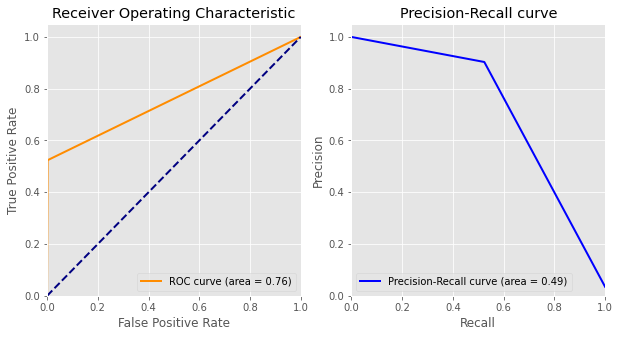

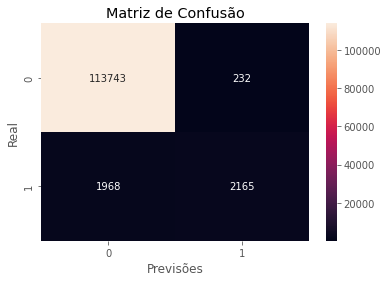

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.90      0.52      0.66      4133

    accuracy                           0.98    118108
   macro avg       0.94      0.76      0.83    118108
weighted avg       0.98      0.98      0.98    118108

CPU times: user 8min 36s, sys: 340 ms, total: 8min 37s
Wall time: 8min 36s


In [208]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [209]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_et.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 52.1 s, sys: 2 µs, total: 52.1 s
Wall time: 52.1 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.663093415007657   0.99042170615536
Threshold: 0.05  0.281888001234997  0.911523739330972
Threshold: 0.1   0.455616967436905  0.963042328401123
Threshold: 0.15  0.579092772480171  0.979008422409387
Threshold: 0.2   0.651985177342509  0.985505201282351
Threshold: 0.25  0.693607467801016  0.988614859079792
Threshold: 0.3   0.710958381061474  0.990055132488757
Threshold: 0.35  0.716161886893594  0.990741145510024
Threshold: 0.4   0.703766160764474  0.990798777826277
Threshold: 0.45  0.693150284796261  0.990840087370133
Threshold: 0.5   0.668896321070234  0.990515507015389
Threshold: 0.55  0.641990864703103  0.990111673271935
Threshold: 0.6   0.615309446254072  0.989733827083225
Threshold: 0.65  0.585546218487395  0.989290646469735
Threshold: 0.7   0.545580830005209  0.988644302407825
Threshold: 0.75  0.498378378378378  0.987930600955494

In [210]:
feature_importances = clf_et.feature_importances_

df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
101         P_emaildomain_gmail.com  0.050761430995628
152                           M4_M2  0.038324227962835
76                      ProductCD_C  0.024760379218867
155                            M6_F  0.023949352800273
154                            M5_T  0.019525219108063
156                            M6_T  0.019376707612568
15                               D2  0.018585252152797
80                      ProductCD_W  0.017595812780659
138         P_emaildomain_yahoo.com  0.016062519883689
68                             V283  0.015263922231222
67                             V282  0.015212807269739
0                    TransactionAmt  0.014975616933843
2                             card2  0.014927452907548
6                                C1  0.013838964348162
1                             card1  0.013789041988151
153                            M5_F  0.013520504189319
104       P_emaildomain_hotmail.com  0.013268485575598
150                           M4_M0  0.012910088074430
78                      ProductCD_R  0.012783465967353
46                              V51  0.012708999295655
13                              C14  0.012555812954292
45                              V50  0.012323402130631
7                                C2  0.012259780899250
66                             V280  0.011947521867027
77                      ProductCD_H  0.011848785385735
73                        _Weekdays  0.011707412343691
159                            M8_F  0.011706784862169
74                           _Hours  0.011339872023055
84                       card4_visa  0.010945514103148
3                             card5  0.010858047566159
160                            M8_T  0.010727536387693
83                 card4_mastercard  0.010668963578999
44                              V49  0.010390930206575
75                            _Days  0.010333048862187
11                              C11  0.010299494737831
12                              C13  0.010274525481085
43                              V48  0.010026246681540
14                               D1  0.009964967431676
148                            M3_F  0.009816132036996
149                            M3_T  0.009798791293605
48                              V53  0.009578642067806
71                             V308  0.009357223617987
62                              V96  0.009235707862239
4                             addr1  0.009231108464204
50                              V69  0.009036913920160
58                              V90  0.009000886304792
51                              V70  0.008814911135390
9                                C6  0.008761222793612
59                              V91  0.008672366540683
49                              V54  0.008497460936151
33                              V12  0.008454401015246
35                              V29  0.008268146732560
70                             V307  0.007946942856903
47                              V52  0.007679522039341
52                              V75  0.007601837413423
18                               D5  0.007394646164101
19                              D10  0.007328510284457
64                             V127  0.007200188761556
36                              V30  0.007073062366953
61                              V93  0.007048420016129
69                             V285  0.006950061322465
72                             V310  0.006702752455274
21                              D15  0.006665000667865
34                              V13  0.006549048554360
16                               D3  0.006488941479630
22                               V1  0.006455564930697
42                              V43  0.006450230397543
151                           M4_M1  0.006441927628272
41                              V42  0.006313436431870
53                              V76  0.006253493274601
86      P_emaildomain_anonymous.com  0.006253100995111
37                              V35  0.006202079284188
40           

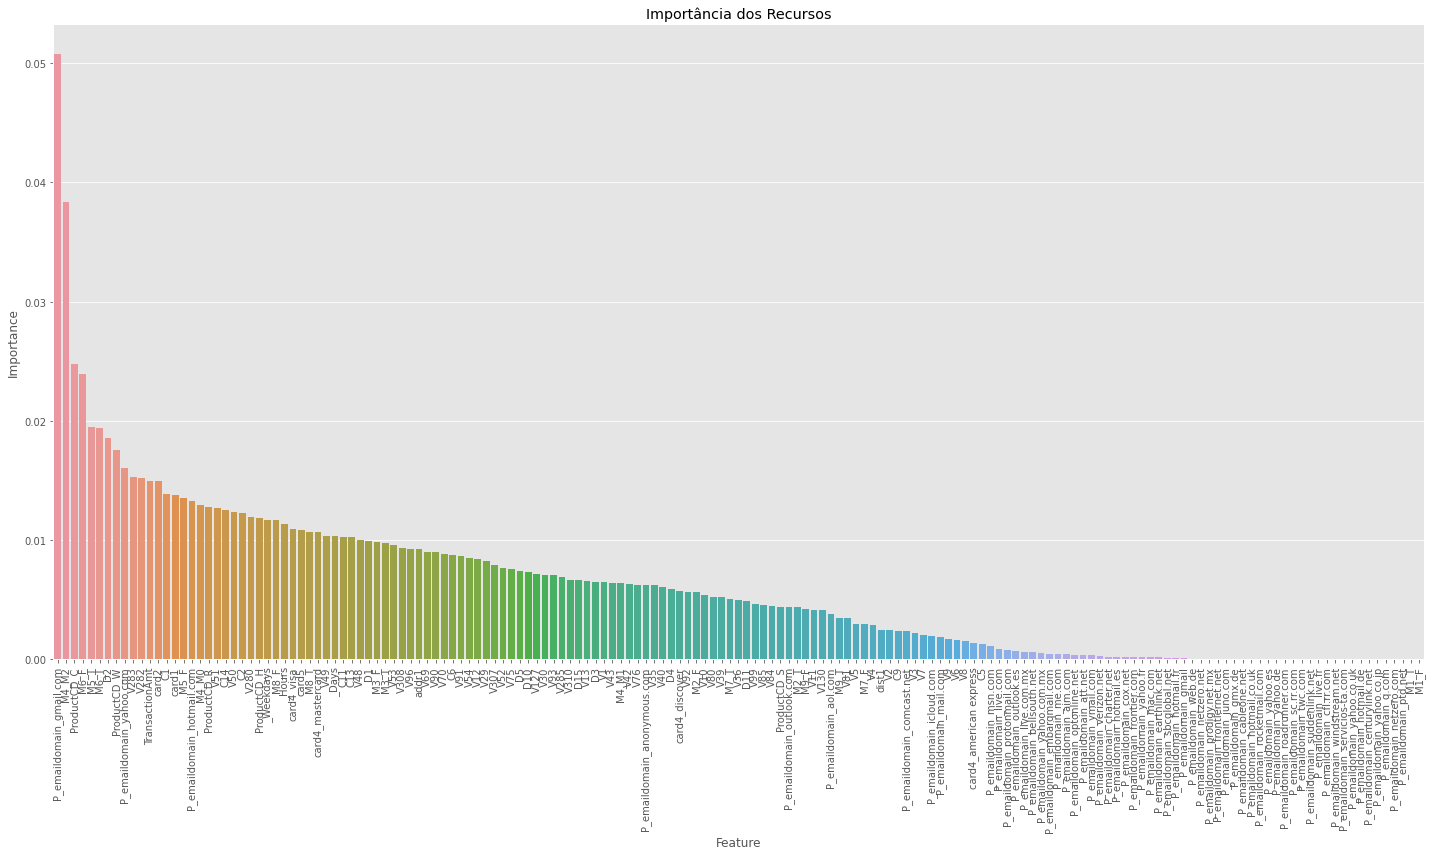

In [211]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.470433062211475
F1-Score Negativo (Teste): 0.9787863577523578
F1-Score Positivo Médio (Validação Cruzada): 0.42615237466461686
F1-Score Positivo Fold 1: 0.4409799554565702
F1-Score Positivo Fold 2: 0.4363636363636364
F1-Score Positivo Fold 3: 0.4668192219679634
F1-Score Positivo Fold 4: 0.43001119820828665
F1-Score Positivo Fold 5: 0.45339470655926356
F1-Score Positivo Fold 6: 0.39823008849557523
F1-Score Positivo Fold 7: 0.41291810841983856
F1-Score Positivo Fold 8: 0.3735498839907193
F1-Score Positivo Fold 9: 0.4097452934662237
F1-Score Positivo Fold 10: 0.43951165371809103
F1-Score Negativo Médio (Validação Cruzada): 0.9776611957320274
F1-Score Negativo Fold 1: 0.9779088188699173
F1-Score Negativo Fold 2: 0.9781901327939496
F1-Score Negativo Fold 3: 0.9795146826094601
F1-Score Negativo Fold 4: 0.9776057019666505
F1-Score Negativo Fold 5: 0.979123632048521
F1-Score Negativo Fold 6: 0.9760542301258913
F1-Score Negativo Fold 7: 0.9776312898264118
F1-Score N

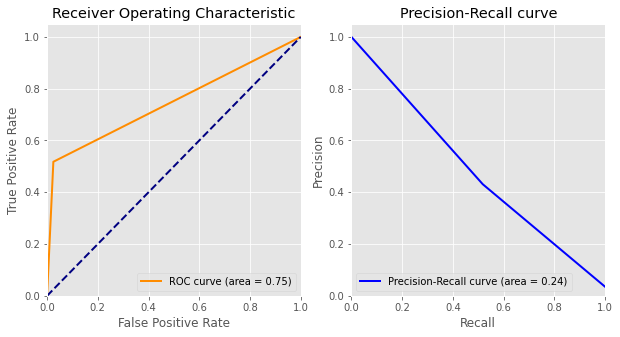

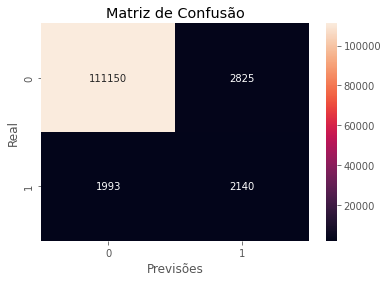

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    113975
           1       0.43      0.52      0.47      4133

    accuracy                           0.96    118108
   macro avg       0.71      0.75      0.72    118108
weighted avg       0.96      0.96      0.96    118108

CPU times: user 1min 52s, sys: 320 ms, total: 1min 53s
Wall time: 1min 52s


In [212]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [213]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_dt.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 1.22 s, sys: 1 µs, total: 1.22 s
Wall time: 1.22 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.470433062211475  0.978786357752358
Threshold: 0.05  0.470433062211475  0.978786357752358
Threshold: 0.1   0.470433062211475  0.978786357752358
Threshold: 0.15  0.470433062211475  0.978786357752358
Threshold: 0.2   0.470433062211475  0.978786357752358
Threshold: 0.25  0.470433062211475  0.978786357752358
Threshold: 0.3   0.470433062211475  0.978786357752358
Threshold: 0.35  0.470433062211475  0.978786357752358
Threshold: 0.4   0.470433062211475  0.978786357752358
Threshold: 0.45  0.470433062211475  0.978786357752358
Threshold: 0.5   0.470433062211475  0.978786357752358
Threshold: 0.55  0.470433062211475  0.978786357752358
Threshold: 0.6   0.470433062211475  0.978786357752358
Threshold: 0.65  0.470433062211475  0.978786357752358
Threshold: 0.7   0.470433062211475  0.978786357752358
Threshold: 0.75  0.470433062211475  0.978786357752358

In [214]:
feature_importances = clf_dt.feature_importances_

df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
66                             V280  0.214865545628497
47                              V52  0.171655105122362
6                                C1  0.129861657939414
13                              C14  0.062623768879648
35                              V29  0.050896398197038
45                              V50  0.044204790246066
67                             V282  0.032853376974826
71                             V308  0.025936343978702
12                              C13  0.015700891422297
1                             card1  0.013858659101766
0                    TransactionAmt  0.012734504087163
2                             card2  0.012445823534857
18                               D5  0.010025651507220
4                             addr1  0.008990669646874
101         P_emaildomain_gmail.com  0.008221858568744
9                                C6  0.007731848231247
7                                C2  0.007139667431481
15                               D2  0.006944287407881
153                            M5_F  0.006104208144507
48                              V53  0.005974921237643
152                           M4_M2  0.005601254212148
75                            _Days  0.005588315014431
11                              C11  0.005384336019567
62                              V96  0.005038672019973
3                             card5  0.004788999394378
104       P_emaildomain_hotmail.com  0.004720808735009
19                              D10  0.004657174588526
10                               C9  0.004235092363000
17                               D4  0.003840151739607
5                             dist1  0.003809306960412
74                           _Hours  0.003765274302698
69                             V285  0.003713977206659
21                              D15  0.003608267404962
68                             V283  0.003507056464511
16                               D3  0.003245000748972
70                             V307  0.003149101876239
73                        _Weekdays  0.002989400280816
72                             V310  0.002914492475126
64                             V127  0.002910313209936
138         P_emaildomain_yahoo.com  0.002903930234484
58                              V90  0.002827048749163
38                              V36  0.002717195624768
82                   card4_discover  0.002470974244740
14                               D1  0.002389015097742
26                               V5  0.002270879901796
36                              V30  0.002140837782007
78                      ProductCD_R  0.002125232358172
77                      ProductCD_H  0.002048943551336
159                            M8_F  0.001905077431206
20                              D11  0.001754857197932
154                            M5_T  0.001692228614555
46                              V51  0.001668584963190
49                              V54  0.001625799991533
53                              V76  0.001533106182432
150                           M4_M0  0.001526516351512
84                       card4_visa  0.001398478570541
120       P_emaildomain_outlook.com  0.001388157154684
86      P_emaildomain_anonymous.com  0.001352036319477
155                            M6_F  0.001335417043062
63                              V99  0.001235120240699
52                              V75  0.001174474218955
25                               V4  0.001123405831855
55                              V81  0.001123398638008
149                            M3_T  0.001060333864251
83                 card4_mastercard  0.001027817442314
65                             V130  0.001022464419274
27                               V6  0.001017001314638
160                            M8_T  0.000999386336231
33                              V12  0.000979565996128
94        P_emaildomain_comcast.net  0.000959877886294
22                               V1  0.000944243708864
156                            M6_T  0.000864236043888
41           

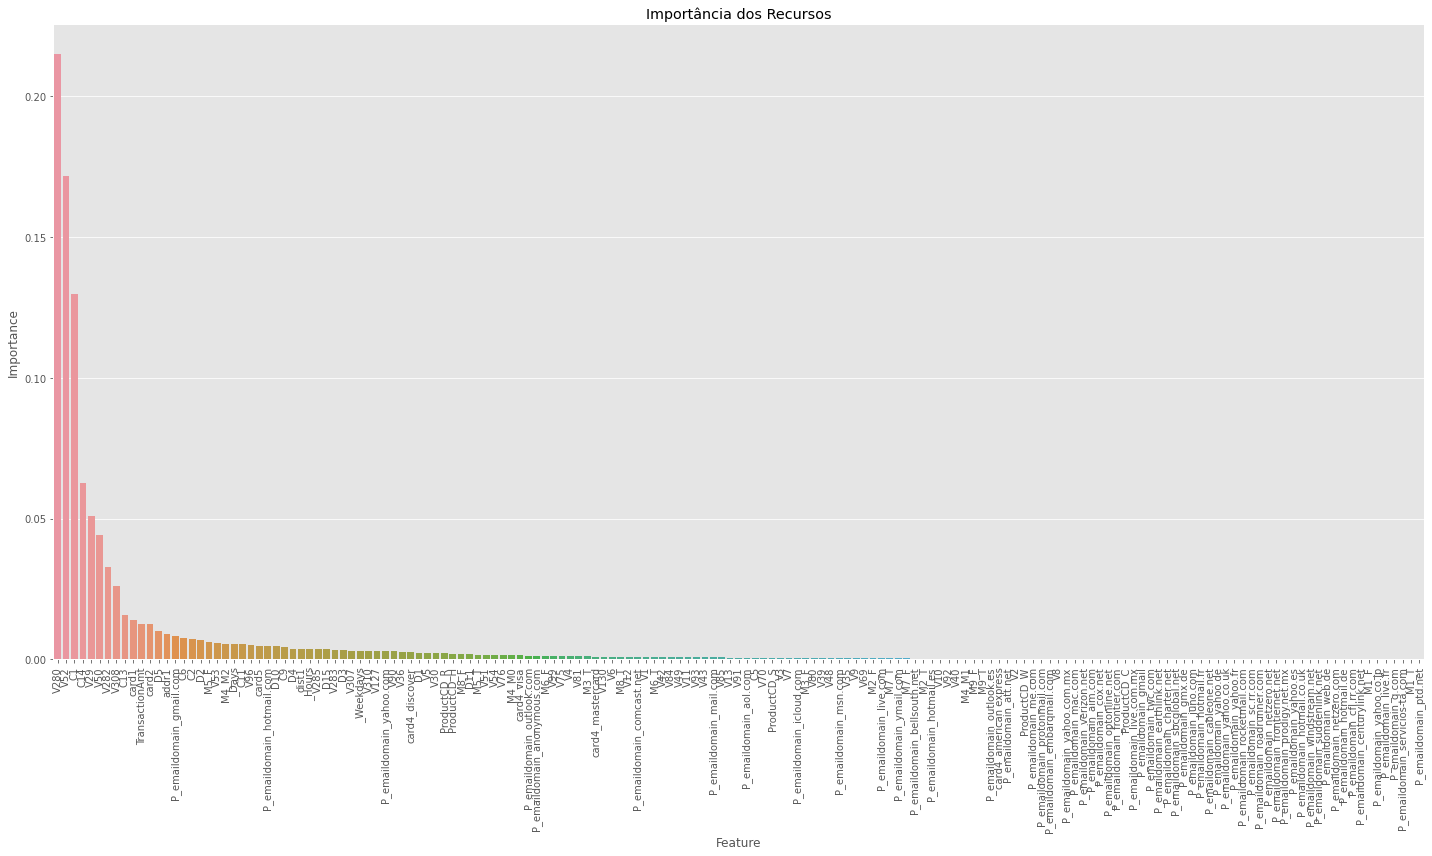

In [215]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

0:	learn: 0.6171329	total: 77.1ms	remaining: 308ms
1:	learn: 0.5462051	total: 150ms	remaining: 226ms
2:	learn: 0.4978456	total: 224ms	remaining: 149ms
3:	learn: 0.4484678	total: 298ms	remaining: 74.6ms
4:	learn: 0.4161525	total: 371ms	remaining: 0us
0:	learn: 0.5336608	total: 12.5ms	remaining: 50ms
1:	learn: 0.4271318	total: 22.5ms	remaining: 33.8ms
2:	learn: 0.3416706	total: 31.1ms	remaining: 20.8ms
3:	learn: 0.2888256	total: 38.9ms	remaining: 9.73ms
4:	learn: 0.2438958	total: 47.5ms	remaining: 0us
0:	learn: 0.5331992	total: 10.1ms	remaining: 40.2ms
1:	learn: 0.4266171	total: 19.7ms	remaining: 29.6ms
2:	learn: 0.3413103	total: 28.2ms	remaining: 18.8ms
3:	learn: 0.2883925	total: 36.1ms	remaining: 9.02ms
4:	learn: 0.2434156	total: 44.6ms	remaining: 0us
0:	learn: 0.5334749	total: 8.13ms	remaining: 32.5ms
1:	learn: 0.4268605	total: 16.8ms	remaining: 25.2ms
2:	learn: 0.3408881	total: 25.6ms	remaining: 17ms
3:	learn: 0.2880311	total: 33.9ms	remaining: 8.47ms
4:	learn: 0.2431527	total: 43.3m

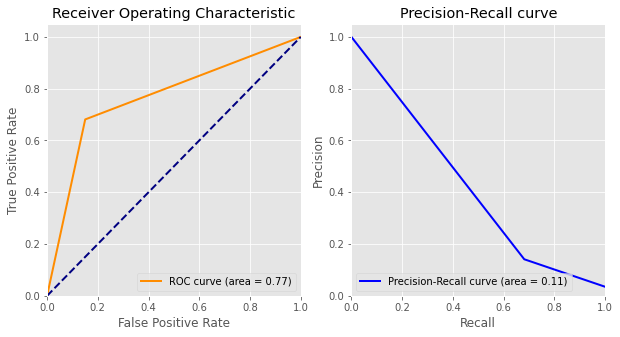

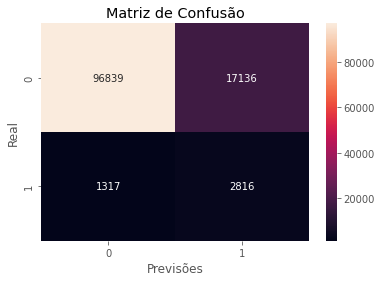

              precision    recall  f1-score   support

           0       0.99      0.85      0.91    113975
           1       0.14      0.68      0.23      4133

    accuracy                           0.84    118108
   macro avg       0.56      0.77      0.57    118108
weighted avg       0.96      0.84      0.89    118108

CPU times: user 1min 45s, sys: 788 ms, total: 1min 46s
Wall time: 1min 22s


In [216]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [217]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_cb.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 39.1 s, sys: 55.9 ms, total: 39.2 s
Wall time: 38.7 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.233838488685904   0.91301129962146
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.068132502784539  0.017946109502569
Threshold: 0.25  0.075451400803109  0.223468473731355
Threshold: 0.3   0.114250500693268  0.664378363863496
Threshold: 0.35   0.15027437737442  0.799968620067467
Threshold: 0.4   0.178932907169092  0.853975836329276
Threshold: 0.45  0.207168581718402   0.88836623024133
Threshold: 0.5   0.233838488685904   0.91301129962146
Threshold: 0.55  0.280751506557958   0.94448447261617
Threshold: 0.6   0.343003899933416  0.969397836980457
Threshold: 0.65  0.349465558194774  0.980904654000349
Threshold: 0.7   0.236005461283402  0.983049820631878
Threshold: 0.75  0.193371332066709  0.983493103046065

In [218]:
feature_importances = clf_cb.feature_importances_

df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature          Importance
66                             V280  27.124065005569381
24                               V3  21.979038082937500
13                              C14  10.733099182846935
138         P_emaildomain_yahoo.com   6.891637485986405
101         P_emaildomain_gmail.com   6.012051417086734
6                                C1   5.084605163901112
47                              V52   4.420182689317677
11                              C11   3.948009387535451
7                                C2   3.184196596433307
58                              V90   1.846264148086088
44                              V49   1.756896134624492
68                             V283   1.573543873213223
18                               D5   1.358029568517351
51                              V70   1.333217888482947
54                              V80   1.036273866456614
10                               C9   0.984610029425918
67                             V282   0.734279479578871
116           P_emaildomain_msn.com   0.000000000000000
112           P_emaildomain_live.fr   0.000000000000000
113           P_emaildomain_mac.com   0.000000000000000
114          P_emaildomain_mail.com   0.000000000000000
115            P_emaildomain_me.com   0.000000000000000
117       P_emaildomain_netzero.com   0.000000000000000
92         P_emaildomain_cfl.rr.com   0.000000000000000
93        P_emaildomain_charter.net   0.000000000000000
118       P_emaildomain_netzero.net   0.000000000000000
119     P_emaildomain_optonline.net   0.000000000000000
120       P_emaildomain_outlook.com   0.000000000000000
121        P_emaildomain_outlook.es   0.000000000000000
91    P_emaildomain_centurylink.net   0.000000000000000
111       P_emaildomain_live.com.mx   0.000000000000000
94        P_emaildomain_comcast.net   0.000000000000000
110          P_emaildomain_live.com   0.000000000000000
103     P_emaildomain_hotmail.co.uk   0.000000000000000
96      P_emaildomain_earthlink.net   0.000000000000000
98       P_emaildomain_frontier.com   0.000000000000000
99    P_emaildomain_frontiernet.net   0.000000000000000
100             P_emaildomain_gmail   0.000000000000000
95            P_emaildomain_cox.net   0.000000000000000
102            P_emaildomain_gmx.de   0.000000000000000
104       P_emaildomain_hotmail.com   0.000000000000000
97     P_emaildomain_embarqmail.com   0.000000000000000
105        P_emaildomain_hotmail.de   0.000000000000000
106        P_emaildomain_hotmail.es   0.000000000000000
123    P_emaildomain_protonmail.com   0.000000000000000
107        P_emaildomain_hotmail.fr   0.000000000000000
108        P_emaildomain_icloud.com   0.000000000000000
109          P_emaildomain_juno.com   0.000000000000000
122    P_emaildomain_prodigy.net.mx   0.000000000000000
0                    TransactionAmt   0.000000000000000
124           P_emaildomain_ptd.net   0.000000000000000
153                            M5_F   0.000000000000000
146                            M2_F   0.000000000000000
147                            M2_T   0.000000000000000
148                            M3_F   0.000000000000000
149                            M3_T   0.000000000000000
150                           M4_M0   0.000000000000000
151                           M4_M1   0.000000000000000
152                           M4_M2   0.000000000000000
154                            M5_T   0.000000000000000
144                            M1_F   0.000000000000000
155                            M6_F   0.000000000000000
156                            M6_T   0.000000000000000
157                            M7_F   0.000000000000000
158                            M7_T   0.000000000000000
159                            M8_F   0.000000000000000
160                            M8_T   0.000000000000000
161                            M9_F   0.000000000000000
145                            M1_T   0.000000000000000
143         P_emaildomain_ymail.com   0.000000000000000
125             P_emaildomain_q.com   0.000000000000

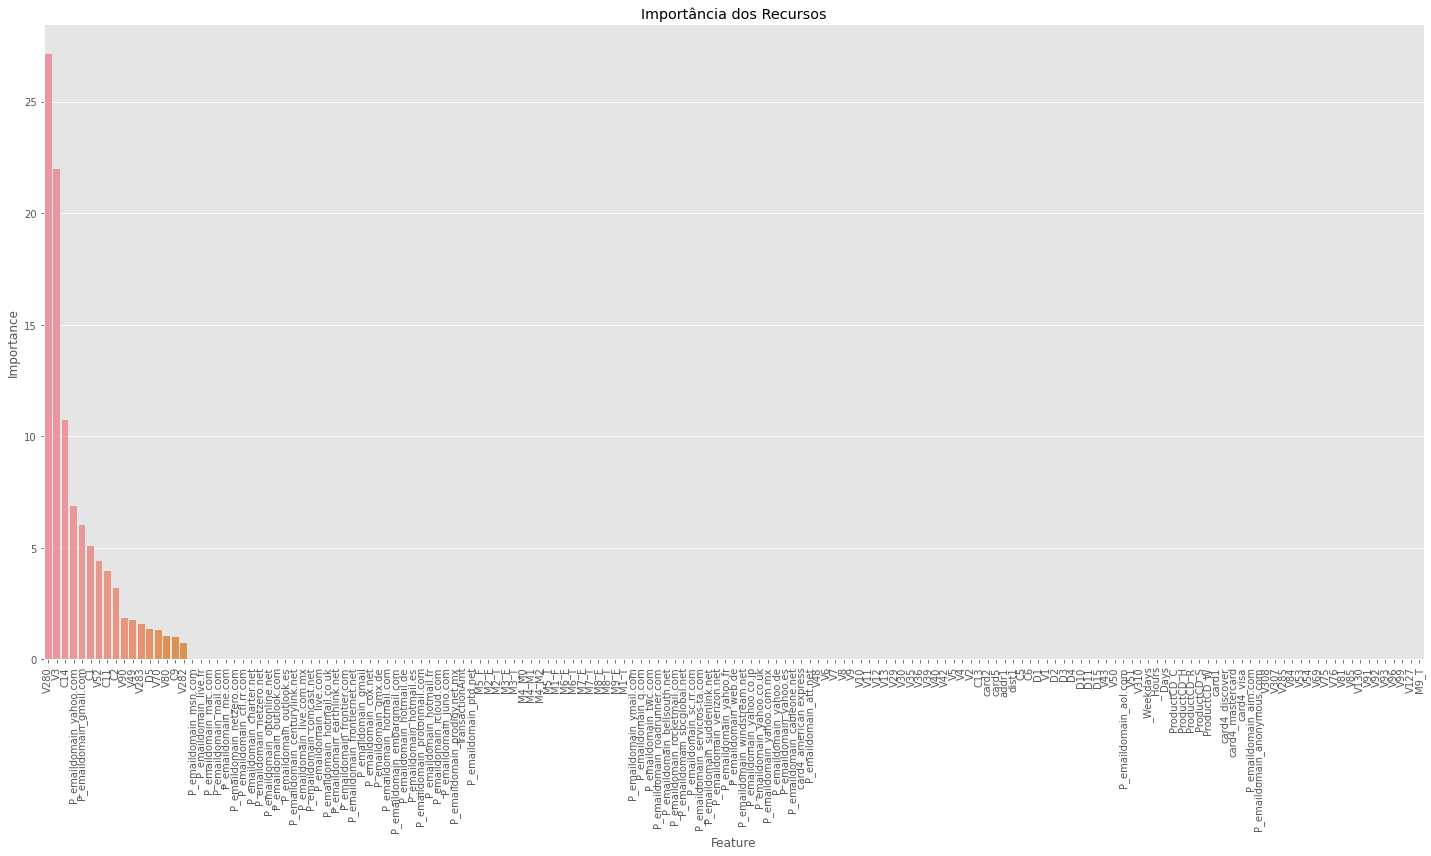

In [219]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.3341184114350687
F1-Score Negativo (Teste): 0.9633814642948061
F1-Score Positivo Médio (Validação Cruzada): 0.2673423877441872
F1-Score Positivo Fold 1: 0.400735294117647
F1-Score Positivo Fold 2: 0.3230769230769231
F1-Score Positivo Fold 3: 0.3843283582089552
F1-Score Positivo Fold 4: 0.26799999999999996
F1-Score Positivo Fold 5: 0.3365200764818356
F1-Score Positivo Fold 6: 0.34651600753295664
F1-Score Positivo Fold 7: 0.09746588693957114
F1-Score Positivo Fold 8: 0.18410041841004185
F1-Score Positivo Fold 9: 0.22672064777327935
F1-Score Positivo Fold 10: 0.10596026490066224
F1-Score Negativo Médio (Validação Cruzada): 0.9839577492023116
F1-Score Negativo Fold 1: 0.9858739925470146
F1-Score Negativo Fold 2: 0.9847632239632932
F1-Score Negativo Fold 3: 0.9857056224551676
F1-Score Negativo Fold 4: 0.984170919470634
F1-Score Negativo Fold 5: 0.9849777046625394
F1-Score Negativo Fold 6: 0.9849725001082673
F1-Score Negativo Fold 7: 0.9799645159894415
F1-Score N

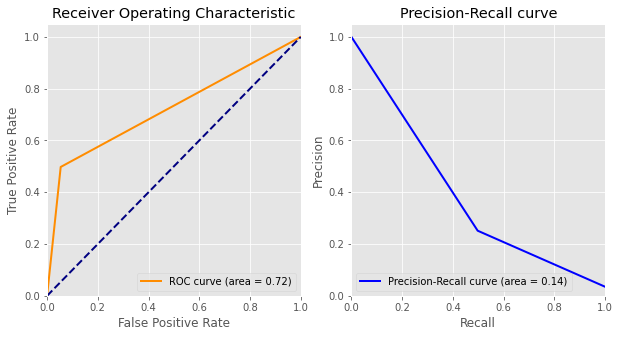

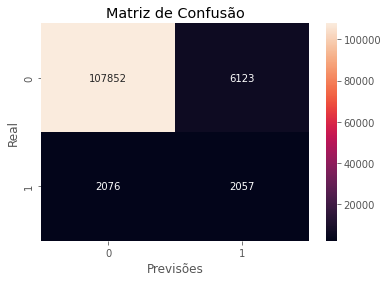

              precision    recall  f1-score   support

           0       0.98      0.95      0.96    113975
           1       0.25      0.50      0.33      4133

    accuracy                           0.93    118108
   macro avg       0.62      0.72      0.65    118108
weighted avg       0.96      0.93      0.94    118108

CPU times: user 8min 56s, sys: 324 ms, total: 8min 56s
Wall time: 8min 56s


In [220]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [221]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_gbc.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2.75 s, sys: 0 ns, total: 2.75 s
Wall time: 2.75 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.334118411435069  0.963381464294806
Threshold: 0.05  0.103403374590512  0.599329899117353
Threshold: 0.1   0.135176291437273  0.760543585197358
Threshold: 0.15  0.167628096369189  0.838867133220485
Threshold: 0.2   0.200477960701009  0.883117891386204
Threshold: 0.25  0.225302318106946  0.908751922394416
Threshold: 0.3   0.249187125960134   0.92589129979767
Threshold: 0.35  0.274617067833698  0.939156449599882
Threshold: 0.4   0.292371288989102  0.948703745743473
Threshold: 0.45  0.312777221347832  0.956776068899108
Threshold: 0.5   0.334118411435069  0.963381464294806
Threshold: 0.55  0.352703199705774  0.968758320759741
Threshold: 0.6   0.367837529789659  0.973071745415223
Threshold: 0.65  0.373172429798097  0.976265169289713
Threshold: 0.7   0.373426754898145  0.978867353145828
Threshold: 0.75  0.363451776649746  0.980860889321083

In [222]:
feature_importances = clf_gbc.feature_importances_

df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
47                              V52  0.242312674020157
18                               D5  0.164748081327512
13                              C14  0.127206595446301
66                             V280  0.122121958559161
50                              V69  0.057259476517966
11                              C11  0.055667063585214
101         P_emaildomain_gmail.com  0.024415758726895
9                                C6  0.022902908209655
67                             V282  0.021431284816865
16                               D3  0.014133432137099
6                                C1  0.014072335821916
0                    TransactionAmt  0.011541596510742
138         P_emaildomain_yahoo.com  0.011274094860435
74                           _Hours  0.009413692743820
73                        _Weekdays  0.009408734549578
64                             V127  0.007383292506070
152                           M4_M2  0.007145596575132
12                              C13  0.006165316087527
62                              V96  0.005863103863372
31                              V10  0.005355092947739
71                             V308  0.004884908835994
69                             V285  0.004579186428000
32                              V11  0.004430224156999
82                   card4_discover  0.004153527131173
154                            M5_T  0.003976101383948
49                              V54  0.003847978290908
153                            M5_F  0.003263914962509
155                            M6_F  0.003145559648268
17                               D4  0.002864077964837
104       P_emaildomain_hotmail.com  0.002846924309476
150                           M4_M0  0.002623419359260
27                               V6  0.002253680905884
156                            M6_T  0.001714975231655
24                               V3  0.001658959384040
148                            M3_F  0.001645361242134
149                            M3_T  0.001637630126559
84                       card4_visa  0.001512604605871
94        P_emaildomain_comcast.net  0.001350830306264
1                             card1  0.001148837026289
120       P_emaildomain_outlook.com  0.001132657500799
44                              V49  0.001095117844743
83                 card4_mastercard  0.000830509999101
25                               V4  0.000673966643763
114          P_emaildomain_mail.com  0.000665816264502
30                               V9  0.000630621728129
87            P_emaildomain_aol.com  0.000557185986445
38                              V36  0.000551800579910
10                               C9  0.000501532339386
105        P_emaildomain_hotmail.de  0.000000000000000
113           P_emaildomain_mac.com  0.000000000000000
117       P_emaildomain_netzero.com  0.000000000000000
161                            M9_F  0.000000000000000
158                            M7_T  0.000000000000000
159                            M8_F  0.000000000000000
116           P_emaildomain_msn.com  0.000000000000000
115            P_emaildomain_me.com  0.000000000000000
102            P_emaildomain_gmx.de  0.000000000000000
112           P_emaildomain_live.fr  0.000000000000000
106        P_emaildomain_hotmail.es  0.000000000000000
111       P_emaildomain_live.com.mx  0.000000000000000
103     P_emaildomain_hotmail.co.uk  0.000000000000000
160                            M8_T  0.000000000000000
147                            M2_T  0.000000000000000
118       P_emaildomain_netzero.net  0.000000000000000
110          P_emaildomain_live.com  0.000000000000000
109          P_emaildomain_juno.com  0.000000000000000
108        P_emaildomain_icloud.com  0.000000000000000
107        P_emaildomain_hotmail.fr  0.000000000000000
157                            M7_F  0.000000000000000
143         P_emaildomain_ymail.com  0.000000000000000
146                            M2_F  0.000000000000000
119     P_emaildomain_optonline.net  0.000000000000000
141          

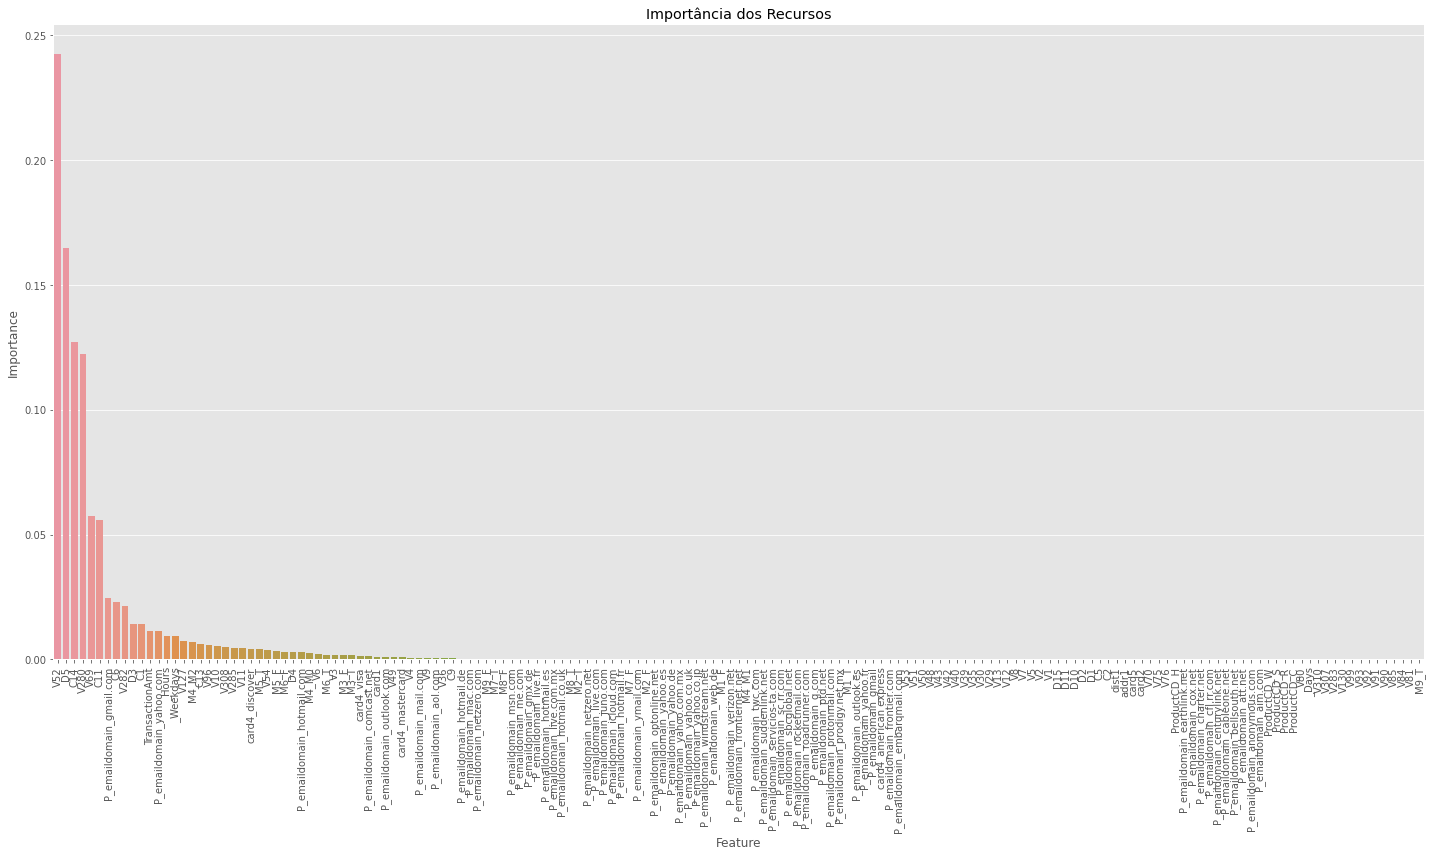

In [223]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.3185745966200199
F1-Score Negativo (Teste): 0.9600652508077925
F1-Score Positivo Médio (Validação Cruzada): 0.335181738224934
F1-Score Positivo Fold 1: 0.38817005545286504
F1-Score Positivo Fold 2: 0.35361216730038025
F1-Score Positivo Fold 3: 0.3320610687022901
F1-Score Positivo Fold 4: 0.3161904761904762
F1-Score Positivo Fold 5: 0.3709369024856597
F1-Score Positivo Fold 6: 0.33270321361058597
F1-Score Positivo Fold 7: 0.367112810707457
F1-Score Positivo Fold 8: 0.2795275590551181
F1-Score Positivo Fold 9: 0.30115830115830117
F1-Score Positivo Fold 10: 0.31034482758620685
F1-Score Negativo Médio (Validação Cruzada): 0.9849293419127733
F1-Score Negativo Fold 1: 0.9856592002079633
F1-Score Negativo Fold 2: 0.985278836162106
F1-Score Negativo Fold 3: 0.9848471729154039
F1-Score Negativo Fold 4: 0.9844568558687276
F1-Score Negativo Fold 5: 0.9857569591757219
F1-Score Negativo Fold 6: 0.9847139825921274
F1-Score Negativo Fold 7: 0.9856703753409237
F1-Score Neg

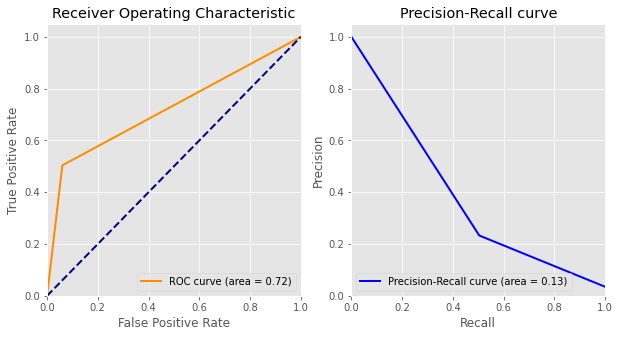

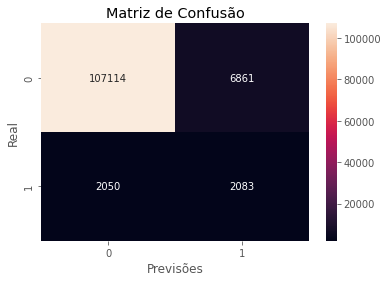

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    113975
           1       0.23      0.50      0.32      4133

    accuracy                           0.92    118108
   macro avg       0.61      0.72      0.64    118108
weighted avg       0.96      0.92      0.94    118108

CPU times: user 10min 53s, sys: 8.01 s, total: 11min 1s
Wall time: 11min 1s


In [224]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [225]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_ada.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 34.1 s, sys: 176 ms, total: 34.3 s
Wall time: 34.3 s


Metrics          F1_score Positivo  F1_score Negativo
Original          0.31857459662002  0.960065250807792
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.067620520120091                0.0
Threshold: 0.3   0.067620520120091                0.0
Threshold: 0.35  0.067620520120091                0.0
Threshold: 0.4   0.067620520120091                0.0
Threshold: 0.45  0.067620520120091                0.0
Threshold: 0.5    0.31857459662002  0.960065250807792
Threshold: 0.55                0.0  0.982191715894745
Threshold: 0.6                 0.0  0.982191715894745
Threshold: 0.65                0.0  0.982191715894745
Threshold: 0.7                 0.0  0.982191715894745
Threshold: 0.75                0.0  0.982191715894745

In [226]:
feature_importances = clf_ada.feature_importances_

df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature  Importance
66                             V280        0.10
62                              V96        0.07
6                                C1        0.07
13                              C14        0.06
18                               D5        0.04
71                             V308        0.04
74                           _Hours        0.04
50                              V69        0.03
9                                C6        0.03
16                               D3        0.02
31                              V10        0.02
148                            M3_F        0.02
69                             V285        0.02
152                           M4_M2        0.02
20                              D11        0.02
138         P_emaildomain_yahoo.com        0.02
0                    TransactionAmt        0.02
156                            M6_T        0.02
12                              C13        0.02
101         P_emaildomain_gmail.com        0.02
11                              C11        0.02
155                            M6_F        0.02
84                       card4_visa        0.02
1                             card1        0.01
87            P_emaildomain_aol.com        0.01
47                              V52        0.01
94        P_emaildomain_comcast.net        0.01
104       P_emaildomain_hotmail.com        0.01
120       P_emaildomain_outlook.com        0.01
68                             V283        0.01
67                             V282        0.01
83                 card4_mastercard        0.01
82                   card4_discover        0.01
73                        _Weekdays        0.01
114          P_emaildomain_mail.com        0.01
43                              V48        0.01
49                              V54        0.01
149                            M3_T        0.01
5                             dist1        0.01
24                               V3        0.01
30                               V9        0.01
32                              V11        0.01
19                              D10        0.01
17                               D4        0.01
151                           M4_M1        0.01
10                               C9        0.01
150                           M4_M0        0.01
103     P_emaildomain_hotmail.co.uk        0.00
118       P_emaildomain_netzero.net        0.00
161                            M9_F        0.00
117       P_emaildomain_netzero.com        0.00
102            P_emaildomain_gmx.de        0.00
153                            M5_F        0.00
160                            M8_T        0.00
154                            M5_T        0.00
116           P_emaildomain_msn.com        0.00
115            P_emaildomain_me.com        0.00
107        P_emaildomain_hotmail.fr        0.00
108        P_emaildomain_icloud.com        0.00
112           P_emaildomain_live.fr        0.00
111       P_emaildomain_live.com.mx        0.00
159                            M8_F        0.00
105        P_emaildomain_hotmail.de        0.00
157                            M7_F        0.00
158                            M7_T        0.00
110          P_emaildomain_live.com        0.00
109          P_emaildomain_juno.com        0.00
106        P_emaildomain_hotmail.es        0.00
113           P_emaildomain_mac.com        0.00
142          P_emaildomain_yahoo.fr        0.00
141          P_emaildomain_yahoo.es        0.00
147                            M2_T        0.00
140          P_emaildomain_yahoo.de        0.00
139      P_emaildomain_yahoo.com.mx        0.00
143         P_emaildomain_ymail.com        0.00
137       P_emaildomain_yahoo.co.uk        0.00
144                            M1_F        0.00
136       P_emaildomain_yahoo.co.jp        0.00
135    P_emaildomain_windstream.net        0.00
134            P_emaildomain_web.de        0.00
145                            M1_T        0.00
133       P_emaildomain_verizon.net        0.00
99    P_emaildomain_frontiernet.net        0

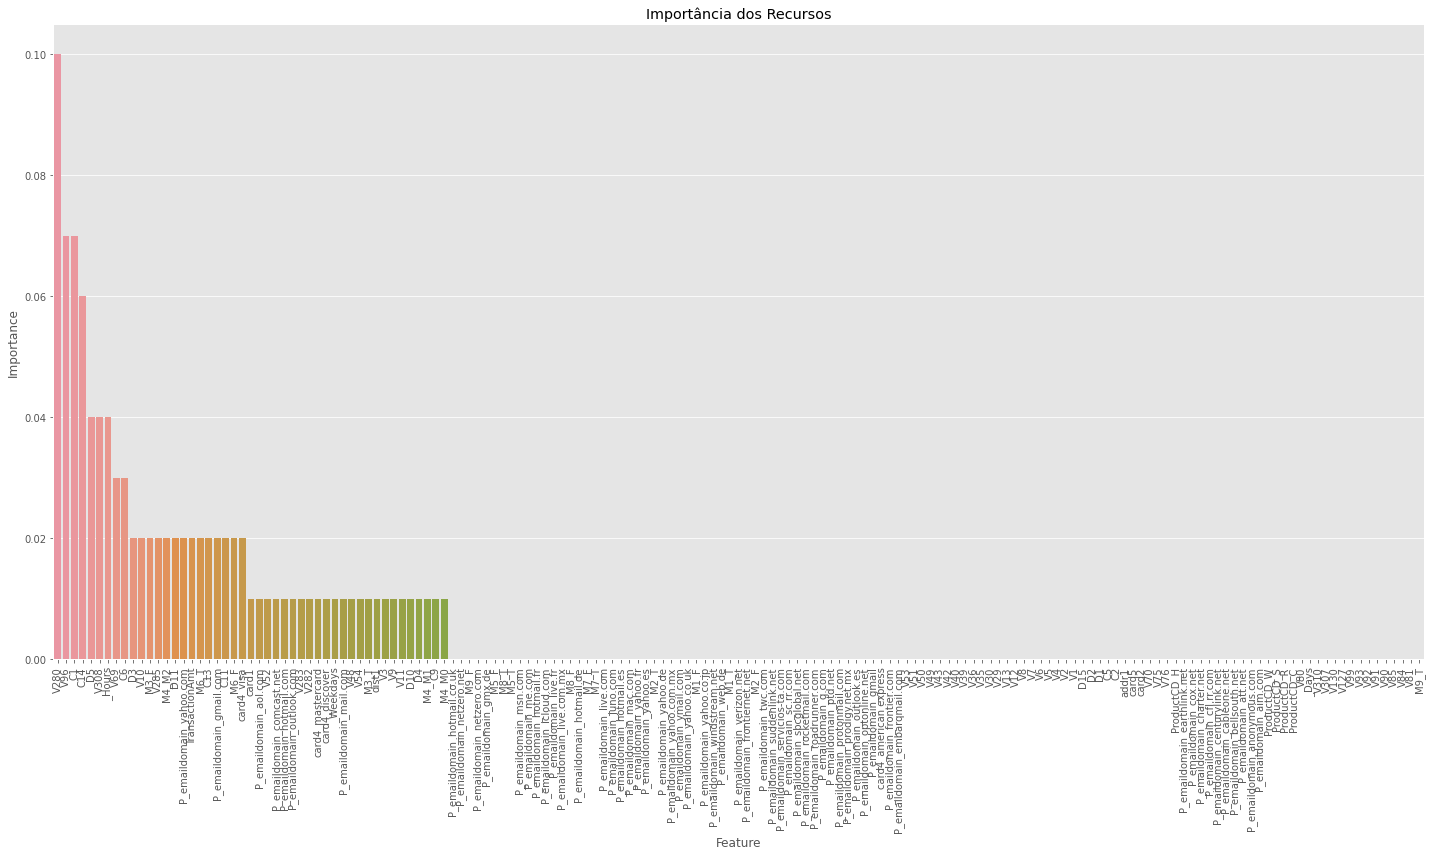

In [227]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.3693854386249392
F1-Score Negativo (Teste): 0.9652584843801646
F1-Score Positivo Médio (Validação Cruzada): 0.2657473185015969
F1-Score Positivo Fold 1: 0.2636203866432338
F1-Score Positivo Fold 2: 0.2491349480968858
F1-Score Positivo Fold 3: 0.2539130434782609
F1-Score Positivo Fold 4: 0.23633156966490299
F1-Score Positivo Fold 5: 0.2901554404145078
F1-Score Positivo Fold 6: 0.24834437086092717
F1-Score Positivo Fold 7: 0.2694300518134715
F1-Score Positivo Fold 8: 0.2582897033158813
F1-Score Positivo Fold 9: 0.2852233676975945
F1-Score Positivo Fold 10: 0.30303030303030304
F1-Score Negativo Médio (Validação Cruzada): 0.9815202969261145
F1-Score Negativo Fold 1: 0.9818244913894071
F1-Score Negativo Fold 2: 0.9811664641555284
F1-Score Negativo Fold 3: 0.981385863669892
F1-Score Negativo Fold 4: 0.9812188245499891
F1-Score Negativo Fold 5: 0.9821637807577138
F1-Score Negativo Fold 6: 0.9802763055000434
F1-Score Negativo Fold 7: 0.9816430152323916
F1-Score Neg

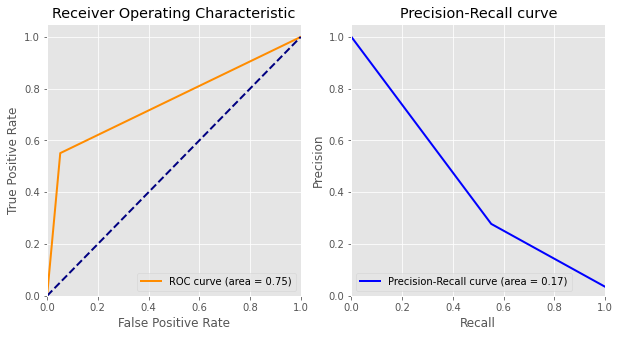

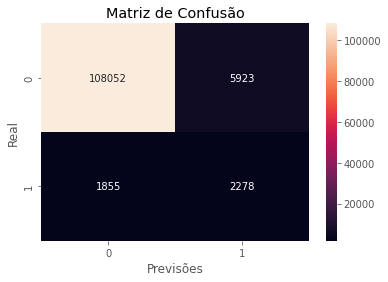

              precision    recall  f1-score   support

           0       0.98      0.95      0.97    113975
           1       0.28      0.55      0.37      4133

    accuracy                           0.93    118108
   macro avg       0.63      0.75      0.67    118108
weighted avg       0.96      0.93      0.94    118108

CPU times: user 39min 32s, sys: 1.18 s, total: 39min 34s
Wall time: 3min 27s


In [228]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_borderline_smote, y_train_oversample_with_borderline_smote)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [229]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_knn.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 8h 9min 14s, sys: 3.24 s, total: 8h 9min 17s
Wall time: 41min 15s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.369385438624939  0.965258484380165
Threshold: 0.05  0.309615849238947  0.947965036875171
Threshold: 0.1   0.309615849238947  0.947965036875171
Threshold: 0.15  0.309615849238947  0.947965036875171
Threshold: 0.2   0.309615849238947  0.947965036875171
Threshold: 0.25  0.309615849238947  0.947965036875171
Threshold: 0.3   0.309615849238947  0.947965036875171
Threshold: 0.35  0.369385438624939  0.965258484380165
Threshold: 0.4   0.369385438624939  0.965258484380165
Threshold: 0.45  0.369385438624939  0.965258484380165
Threshold: 0.5   0.369385438624939  0.965258484380165
Threshold: 0.55  0.369385438624939  0.965258484380165
Threshold: 0.6   0.369385438624939  0.965258484380165
Threshold: 0.65  0.369385438624939  0.965258484380165
Threshold: 0.7   0.423213493120284  0.977121881657013
Threshold: 0.75  0.423213493120284  0.977121881657013

In [230]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 2.1e+04 s


## Validação Cruzada para Oversample com AdaSyn

### 50 Chi-Square

In [231]:
#reinicializando os classificadores

clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)

F1-Score Positivo (Teste): 0.5977072780591842
F1-Score Negativo (Teste): 0.9868044807051602
F1-Score Positivo Médio (Validação Cruzada): 0.49134581681262574
F1-Score Positivo Fold 1: 0.5149501661129567
F1-Score Positivo Fold 2: 0.4768211920529801
F1-Score Positivo Fold 3: 0.5346534653465346
F1-Score Positivo Fold 4: 0.4851485148514852
F1-Score Positivo Fold 5: 0.5237315875613748
F1-Score Positivo Fold 6: 0.5024630541871922
F1-Score Positivo Fold 7: 0.4657534246575343
F1-Score Positivo Fold 8: 0.4641638225255973
F1-Score Positivo Fold 9: 0.4777594728171335
F1-Score Positivo Fold 10: 0.46801346801346805
F1-Score Negativo Médio (Validação Cruzada): 0.9867294140433678
F1-Score Negativo Fold 1: 0.9873153779322327
F1-Score Negativo Fold 2: 0.986271613519854
F1-Score Negativo Fold 3: 0.9877476538060479
F1-Score Negativo Fold 4: 0.986444212721585
F1-Score Negativo Fold 5: 0.987353874234062
F1-Score Negativo Fold 6: 0.9868335288749837
F1-Score Negativo Fold 7: 0.9864571577393871
F1-Score Negati

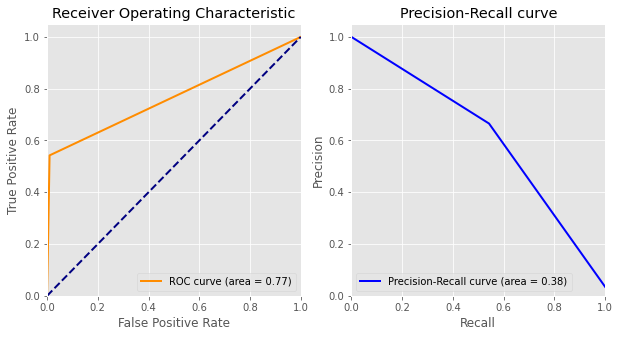

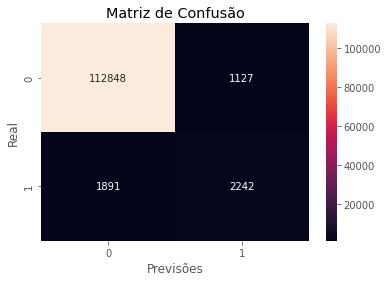

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    113975
           1       0.67      0.54      0.60      4133

    accuracy                           0.97    118108
   macro avg       0.82      0.77      0.79    118108
weighted avg       0.97      0.97      0.97    118108

CPU times: user 5min 24s, sys: 360 ms, total: 5min 24s
Wall time: 5min 24s


In [232]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_adasyn_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [233]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_et.predict_proba(X_test[oversample_with_adasyn_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 53.8 s, sys: 4 µs, total: 53.8 s
Wall time: 53.8 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.597707278059184   0.98680448070516
Threshold: 0.05  0.218656029456889  0.874947207134649
Threshold: 0.1   0.332599559735841  0.938305862330503
Threshold: 0.15  0.427695004382121  0.961654688932755
Threshold: 0.2   0.498307603401304  0.972883004689808
Threshold: 0.25  0.543876203057181  0.978574404524462
Threshold: 0.3    0.57920066959615  0.982255203875442
Threshold: 0.35  0.594527643283414  0.984159940176392
Threshold: 0.4   0.602513464991023  0.985425325088541
Threshold: 0.45  0.603940388987118  0.986263567792972
Threshold: 0.5   0.595357425481403  0.986581173403781
Threshold: 0.55  0.590515463917526  0.986987913916686
Threshold: 0.6   0.578458017451008   0.98714363616534
Threshold: 0.65  0.557498518079431  0.986987292345774
Threshold: 0.7   0.532223250077089  0.986793192008009
Threshold: 0.75  0.502641267808548  0.986489483365149

In [234]:
feature_importances = clf_et.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_adasyn_cols_50_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
0   TransactionAmt  0.051181982487891
49           M4_M2  0.042282840650928
12             C14  0.041243890974616
21             V29  0.039332439896660
48     ProductCD_C  0.035212948744750
2            card2  0.031947972322584
5               C1  0.031500306222523
1            card1  0.031299951893885
42            V282  0.029175020126884
11             C13  0.029108764286368
13              D1  0.028928856337369
3            card5  0.028081237917235
14              D2  0.027881777516806
22             V30  0.027352957241007
6               C2  0.026605602545951
34             V91  0.026331079794701
43            V283  0.024347444938453
25             V42  0.023062778790817
28             V51  0.021153027477446
10             C11  0.020380461463789
27             V50  0.019659374944130
8               C6  0.018841453220637
41            V280  0.018286978492860
18             D10  0.016948798294560
20             D15  0.016848913236752
26             V43  0.016773202485457
29             V52  0.016594732065684
19             D11  0.016380453968660
23             V39  0.014632203489486
24             V40  0.014339521238448
16              D4  0.013978072842634
32             V84  0.013436389807888
17              D5  0.013427662473444
36             V93  0.013355761209423
37             V96  0.013124381292741
46            V308  0.012681287536223
15              D3  0.012417367009456
9               C9  0.012298487873661
44            V285  0.011287966891927
33             V85  0.010615086914092
45            V307  0.010535344291028
35             V92  0.010405584051950
39            V127  0.010290804816940
4            dist1  0.009840194275436
38             V99  0.009477313029845
47            V310  0.009097483006114
30             V80  0.008093538778396
31             V81  0.007821564380860
40            V130  0.006540554077623
7               C5  0.005558182372984

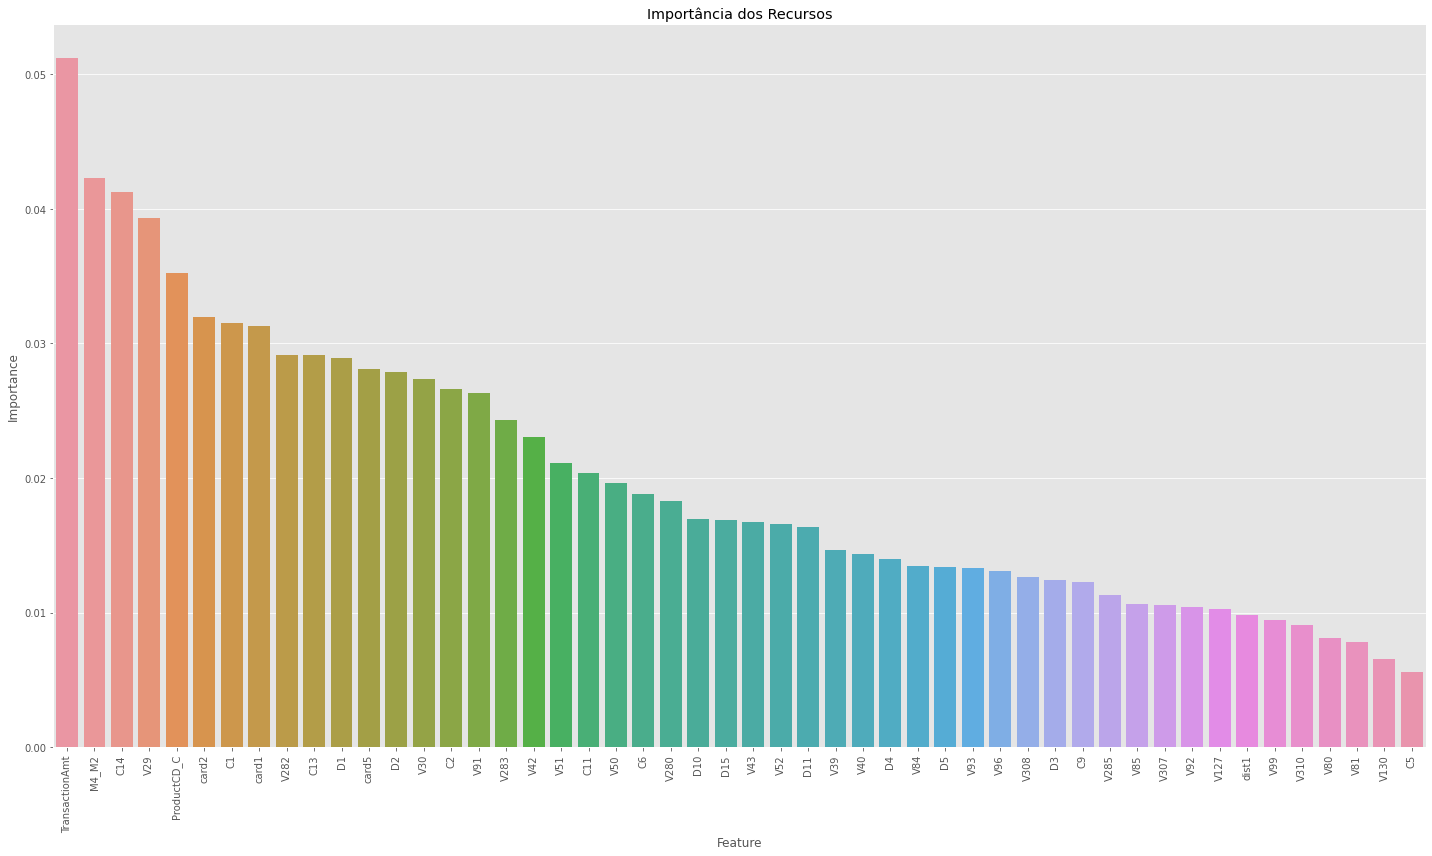

In [235]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.43600799242822585
F1-Score Negativo (Teste): 0.9763439152738999
F1-Score Positivo Médio (Validação Cruzada): 0.420420882244818
F1-Score Positivo Fold 1: 0.44786729857819907
F1-Score Positivo Fold 2: 0.38963963963963966
F1-Score Positivo Fold 3: 0.43497267759562835
F1-Score Positivo Fold 4: 0.40774487471526194
F1-Score Positivo Fold 5: 0.4323699421965318
F1-Score Positivo Fold 6: 0.43340857787810383
F1-Score Positivo Fold 7: 0.4071005917159763
F1-Score Positivo Fold 8: 0.40801001251564456
F1-Score Positivo Fold 9: 0.42757009345794394
F1-Score Positivo Fold 10: 0.41552511415525106
F1-Score Negativo Médio (Validação Cruzada): 0.9779656710145332
F1-Score Negativo Fold 1: 0.9795416630081657
F1-Score Negativo Fold 2: 0.9761590569191518
F1-Score Negativo Fold 3: 0.9772316906680759
F1-Score Negativo Fold 4: 0.9771368272951109
F1-Score Negativo Fold 5: 0.9784242211187767
F1-Score Negativo Fold 6: 0.9779204785362421
F1-Score Negativo Fold 7: 0.9780041269701892
F1-Sco

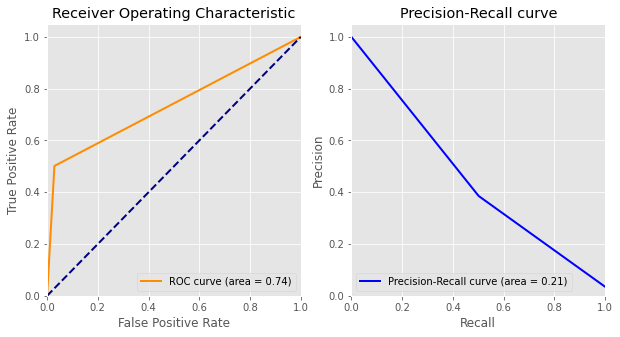

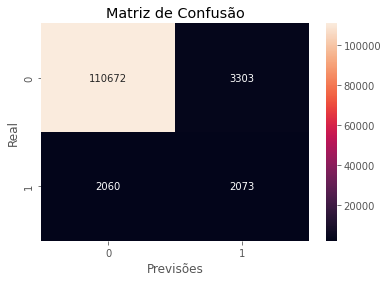

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    113975
           1       0.39      0.50      0.44      4133

    accuracy                           0.95    118108
   macro avg       0.68      0.74      0.71    118108
weighted avg       0.96      0.95      0.96    118108

CPU times: user 52.9 s, sys: 336 ms, total: 53.2 s
Wall time: 52.9 s


In [236]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_adasyn_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [237]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_dt.predict_proba(X_test[oversample_with_adasyn_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 1.08 s, sys: 2 µs, total: 1.08 s
Wall time: 1.08 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.436007992428226    0.9763439152739
Threshold: 0.05  0.411198428290766  0.973482100196429
Threshold: 0.1   0.416334661354582  0.974090973401245
Threshold: 0.15  0.421605249873801   0.97468527822333
Threshold: 0.2   0.427415223850015  0.975319599920514
Threshold: 0.25  0.428674277486373   0.97547385570415
Threshold: 0.3    0.43075651095494  0.975686412995498
Threshold: 0.35  0.432118001454243  0.975872615175494
Threshold: 0.4   0.432477388501923  0.975908771960794
Threshold: 0.45  0.432927463835987  0.975953964352381
Threshold: 0.5   0.433288199145922   0.97599011539395
Threshold: 0.55  0.436283278964538  0.976371006514845
Threshold: 0.6   0.437203416640304  0.976461300295943
Threshold: 0.65  0.437387910117101  0.976479357140652
Threshold: 0.7   0.437473595268272  0.976511369449786
Threshold: 0.75  0.437566025776463    0.9765203969129

In [238]:
feature_importances = clf_dt.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_adasyn_cols_50_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
31             V81  0.195985867573641
5               C1  0.132151056556225
43            V283  0.121493151548990
12             C14  0.094318444634764
41            V280  0.074292623887788
34             V91  0.058582130998683
0   TransactionAmt  0.038294110071725
1            card1  0.025949459066319
21             V29  0.024283402343577
11             C13  0.020545145964827
2            card2  0.018010346831615
30             V80  0.015760449000608
24             V40  0.012778965315696
9               C9  0.009991367579803
3            card5  0.009924478936949
6               C2  0.009780193746198
4            dist1  0.009639160120899
8               C6  0.009116823788452
10             C11  0.008472421329011
16              D4  0.008137384731669
46            V308  0.008054049035229
49           M4_M2  0.007060408791478
17              D5  0.006112549828424
44            V285  0.005571593280119
15              D3  0.005389148918997
20             D15  0.005352195397359
47            V310  0.005048601996586
45            V307  0.004949293823087
19             D11  0.004923455231875
14              D2  0.004635030190457
42            V282  0.004575287157894
37             V96  0.004263228061791
28             V51  0.004176188792555
13              D1  0.004089961111945
18             D10  0.003914723707816
29             V52  0.002903742839429
39            V127  0.002738583629974
38             V99  0.002653550979546
25             V42  0.002309392957269
7               C5  0.002284590446148
23             V39  0.002283455912769
40            V130  0.002088351006842
22             V30  0.001909812399691
35             V92  0.001872138623337
27             V50  0.001241281777732
26             V43  0.000720398355870
33             V85  0.000488110367292
36             V93  0.000337026824842
32             V84  0.000292872447881
48     ProductCD_C  0.000253992078327

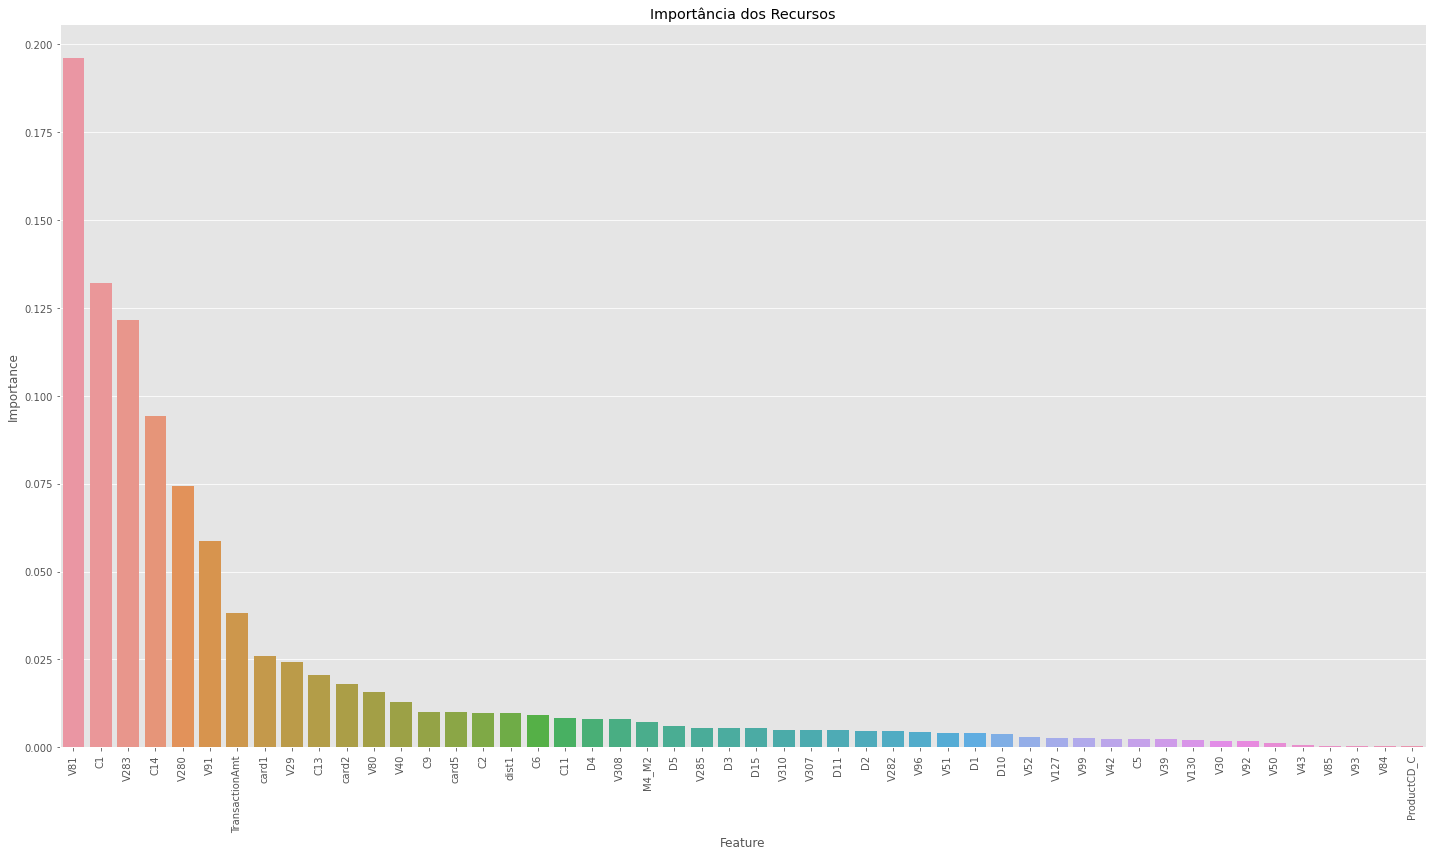

In [239]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

0:	learn: 0.6057285	total: 64ms	remaining: 256ms
1:	learn: 0.5381620	total: 123ms	remaining: 184ms
2:	learn: 0.4848814	total: 184ms	remaining: 122ms
3:	learn: 0.4414786	total: 243ms	remaining: 60.7ms
4:	learn: 0.4184850	total: 303ms	remaining: 0us
0:	learn: 0.5401809	total: 6.78ms	remaining: 27.1ms
1:	learn: 0.4304303	total: 13.7ms	remaining: 20.5ms
2:	learn: 0.3512025	total: 20.4ms	remaining: 13.6ms
3:	learn: 0.2960029	total: 27.1ms	remaining: 6.77ms
4:	learn: 0.2510101	total: 33.5ms	remaining: 0us
0:	learn: 0.5395816	total: 12.3ms	remaining: 49.3ms
1:	learn: 0.4296488	total: 21.2ms	remaining: 31.7ms
2:	learn: 0.3512542	total: 28.2ms	remaining: 18.8ms
3:	learn: 0.2960457	total: 34.9ms	remaining: 8.71ms
4:	learn: 0.2507814	total: 41.3ms	remaining: 0us
0:	learn: 0.5397279	total: 13.8ms	remaining: 55.1ms
1:	learn: 0.4298149	total: 23.2ms	remaining: 34.8ms
2:	learn: 0.3514868	total: 30.5ms	remaining: 20.3ms
3:	learn: 0.2961449	total: 37.3ms	remaining: 9.32ms
4:	learn: 0.2509767	total: 43.

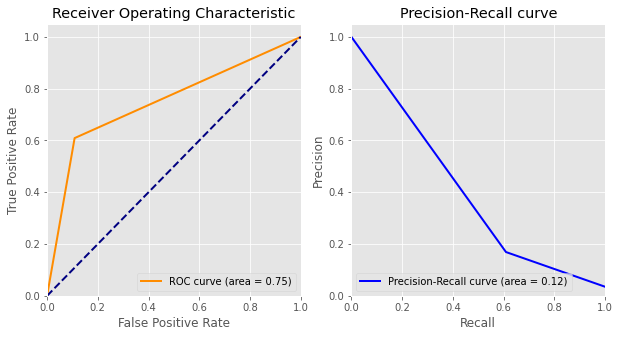

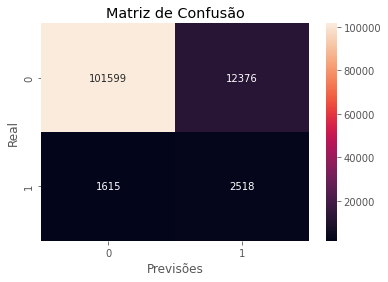

              precision    recall  f1-score   support

           0       0.98      0.89      0.94    113975
           1       0.17      0.61      0.26      4133

    accuracy                           0.88    118108
   macro avg       0.58      0.75      0.60    118108
weighted avg       0.96      0.88      0.91    118108

CPU times: user 22.7 s, sys: 744 ms, total: 23.5 s
Wall time: 9.46 s


In [240]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_adasyn_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [241]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_cb.predict_proba(X_test[oversample_with_adasyn_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2.09 s, sys: 0 ns, total: 2.09 s
Wall time: 1.65 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.264676512324591  0.935581452099324
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067688074746763  0.002138531249726
Threshold: 0.25  0.074420901500672  0.202199188113349
Threshold: 0.3   0.090536783452349   0.47279195896558
Threshold: 0.35  0.133470110976406  0.745570944299319
Threshold: 0.4   0.173591577593828  0.844891822994967
Threshold: 0.45  0.214937306923496  0.896497860575656
Threshold: 0.5   0.264676512324591  0.935581452099324
Threshold: 0.55  0.313511084481726  0.958871778304257
Threshold: 0.6   0.349546922195605  0.972442247865322
Threshold: 0.65  0.362787897034472  0.981561420550326
Threshold: 0.7   0.194671701279631  0.983413192539177
Threshold: 0.75  0.173950670705322  0.983514253391711

In [242]:
feature_importances = clf_cb.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_adasyn_cols_50_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature          Importance
41            V280  26.369132117297386
5               C1  21.249652030180417
29             V52  20.814685578166159
12             C14  14.384999202829103
10             C11   3.256028316495291
11             C13   3.199603013674222
21             V29   2.451504667266455
30             V80   1.887772324204488
8               C6   1.354257035973182
46            V308   1.263278350386922
33             V85   1.180177544438011
43            V283   0.743382761246681
42            V282   0.719803218143400
22             V30   0.638952446468953
9               C9   0.486771393229332
44            V285   0.000000000000000
45            V307   0.000000000000000
40            V130   0.000000000000000
39            V127   0.000000000000000
38             V99   0.000000000000000
37             V96   0.000000000000000
36             V93   0.000000000000000
47            V310   0.000000000000000
35             V92   0.000000000000000
34             V91   0.000000000000000
48     ProductCD_C   0.000000000000000
32             V84   0.000000000000000
31             V81   0.000000000000000
0   TransactionAmt   0.000000000000000
25             V42   0.000000000000000
28             V51   0.000000000000000
27             V50   0.000000000000000
2            card2   0.000000000000000
3            card5   0.000000000000000
4            dist1   0.000000000000000
6               C2   0.000000000000000
7               C5   0.000000000000000
13              D1   0.000000000000000
14              D2   0.000000000000000
15              D3   0.000000000000000
16              D4   0.000000000000000
17              D5   0.000000000000000
18             D10   0.000000000000000
19             D11   0.000000000000000
20             D15   0.000000000000000
23             V39   0.000000000000000
24             V40   0.000000000000000
1            card1   0.000000000000000
26             V43   0.000000000000000
49           M4_M2   0.000000000000000

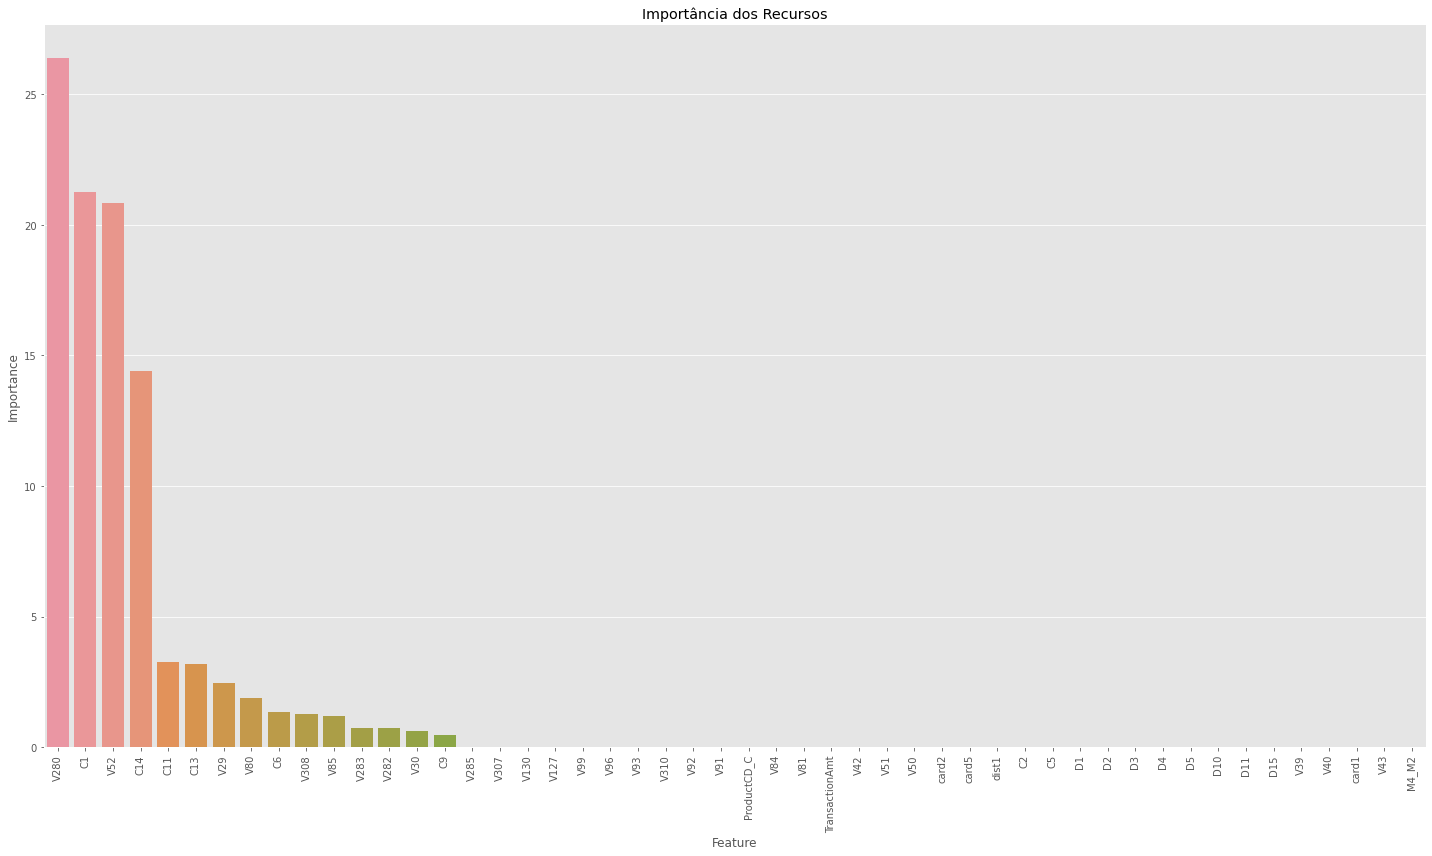

In [243]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.34653714094296967
F1-Score Negativo (Teste): 0.9652078920967562
F1-Score Positivo Médio (Validação Cruzada): 0.31471213365722306
F1-Score Positivo Fold 1: 0.4241316270566728
F1-Score Positivo Fold 2: 0.37064220183486235
F1-Score Positivo Fold 3: 0.3925233644859813
F1-Score Positivo Fold 4: 0.36432637571157495
F1-Score Positivo Fold 5: 0.37051039697542537
F1-Score Positivo Fold 6: 0.38461538461538464
F1-Score Positivo Fold 7: 0.09746588693957114
F1-Score Positivo Fold 8: 0.30740037950664134
F1-Score Positivo Fold 9: 0.3295454545454546
F1-Score Positivo Fold 10: 0.10596026490066224
F1-Score Negativo Médio (Validação Cruzada): 0.9845271033705286
F1-Score Negativo Fold 1: 0.9863488624052004
F1-Score Negativo Fold 2: 0.9851367162109459
F1-Score Negativo Fold 3: 0.9859228137046824
F1-Score Negativo Fold 4: 0.9854946958216065
F1-Score Negativo Fold 5: 0.9855800459013554
F1-Score Negativo Fold 6: 0.9854394175767031
F1-Score Negativo Fold 7: 0.9799645159894415
F1-Sc

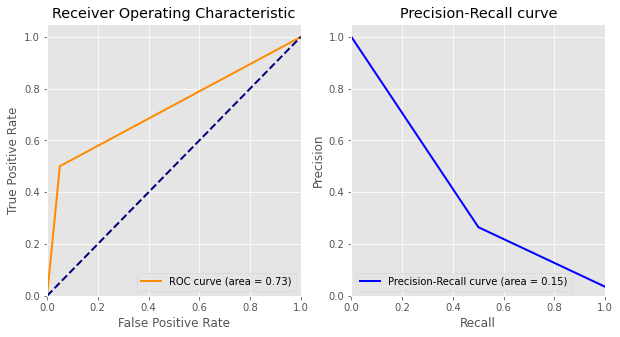

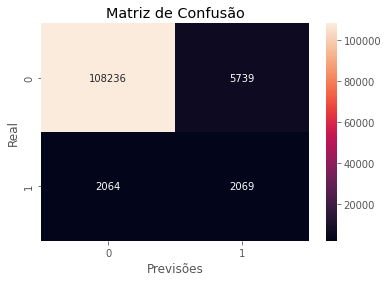

              precision    recall  f1-score   support

           0       0.98      0.95      0.97    113975
           1       0.26      0.50      0.35      4133

    accuracy                           0.93    118108
   macro avg       0.62      0.73      0.66    118108
weighted avg       0.96      0.93      0.94    118108

CPU times: user 5min 15s, sys: 332 ms, total: 5min 16s
Wall time: 5min 15s


In [244]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_adasyn_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [245]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_gbc.predict_proba(X_test[oversample_with_adasyn_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2.46 s, sys: 0 ns, total: 2.46 s
Wall time: 2.46 s


Metrics          F1_score Positivo  F1_score Negativo
Original          0.34653714094297  0.965207892096756
Threshold: 0.05  0.086165827342042  0.417668789897212
Threshold: 0.1   0.110665693039059  0.647117607753396
Threshold: 0.15  0.140727441447621  0.771786010876263
Threshold: 0.2   0.167899446542182  0.837134902556315
Threshold: 0.25  0.207815458770873   0.88893715819299
Threshold: 0.3   0.239871744876294  0.917691437901444
Threshold: 0.35  0.267234741543042  0.934136157058159
Threshold: 0.4   0.293630149416248  0.946846621298678
Threshold: 0.45  0.324796274738067  0.958286885540652
Threshold: 0.5    0.34653714094297  0.965207892096756
Threshold: 0.55  0.372247125316702   0.97148977225453
Threshold: 0.6   0.382670676021829  0.975606965414963
Threshold: 0.65   0.38827745072946  0.979071987110446
Threshold: 0.7    0.38598490243555  0.981190689151159
Threshold: 0.75  0.370547073791349  0.982785915590968

In [246]:
feature_importances = clf_gbc.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_adasyn_cols_50_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
31             V81  0.276878542687019
12             C14  0.131511099980361
46            V308  0.105543407337441
10             C11  0.067948728316040
42            V282  0.058948622397998
34             V91  0.046912900752449
8               C6  0.045108633790482
5               C1  0.044799946899401
41            V280  0.029700991584716
0   TransactionAmt  0.028052266273883
19             D11  0.025523424930503
15              D3  0.024221094010751
37             V96  0.011806717125947
24             V40  0.010883420514092
29             V52  0.010520192629418
4            dist1  0.010472154547481
11             C13  0.009232135394780
39            V127  0.007559525324081
38             V99  0.005603088233947
21             V29  0.005219925402353
18             D10  0.005086980190894
6               C2  0.004494608942424
49           M4_M2  0.004465826761755
22             V30  0.004310518607787
40            V130  0.003558637636726
44            V285  0.003553306842031
9               C9  0.003267580089629
2            card2  0.002869649623938
32             V84  0.002446732964964
14              D2  0.001728976302454
28             V51  0.001695425639799
43            V283  0.001523431958568
16              D4  0.001459762911550
27             V50  0.001322129787982
7               C5  0.001003016802468
1            card1  0.000766596803887
47            V310  0.000000000000000
45            V307  0.000000000000000
48     ProductCD_C  0.000000000000000
3            card5  0.000000000000000
23             V39  0.000000000000000
36             V93  0.000000000000000
13              D1  0.000000000000000
35             V92  0.000000000000000
33             V85  0.000000000000000
17              D5  0.000000000000000
30             V80  0.000000000000000
20             D15  0.000000000000000
26             V43  0.000000000000000
25             V42  0.000000000000000

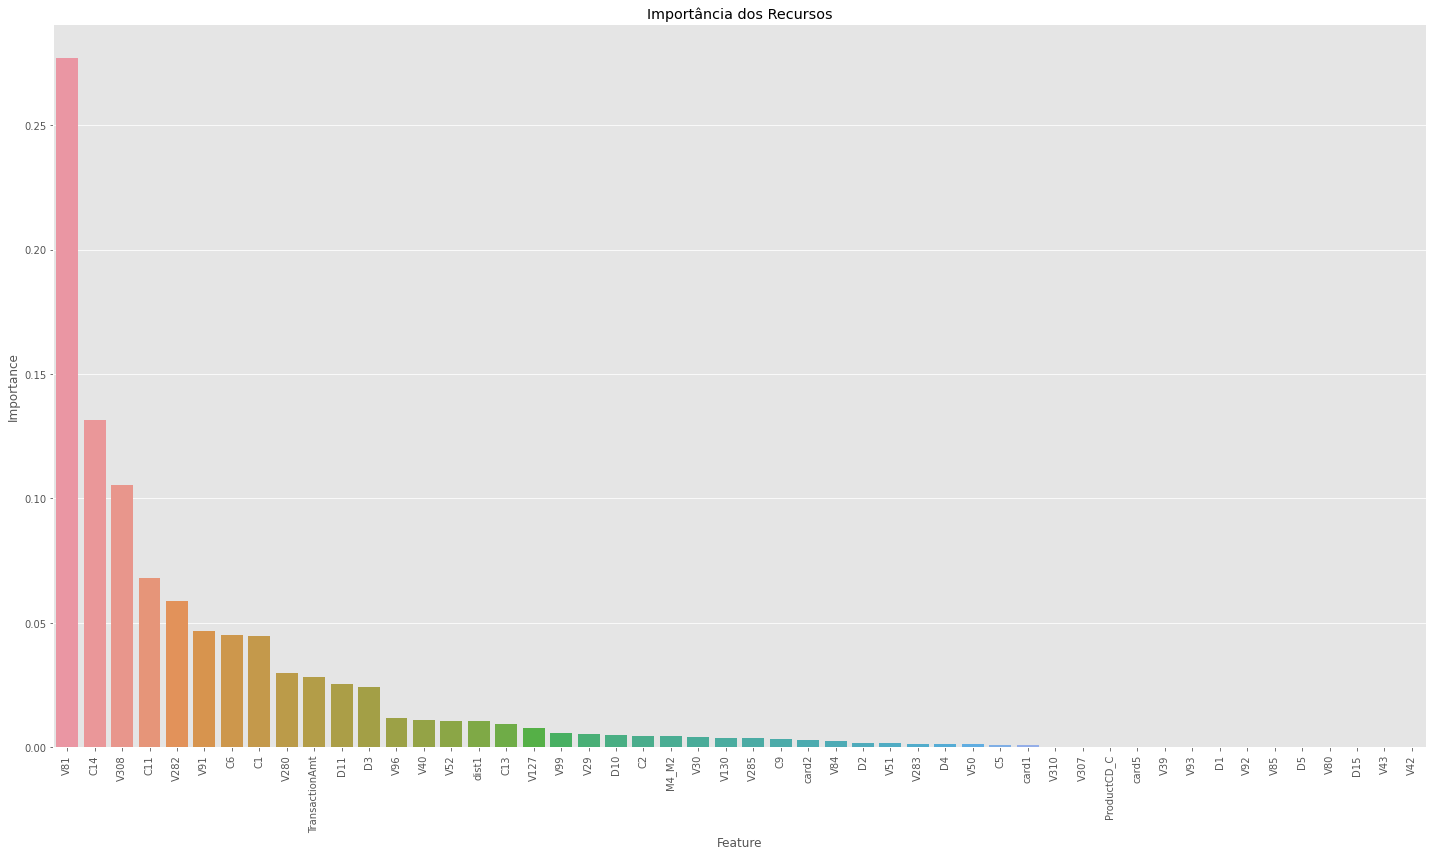

In [247]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


F1-Score Positivo (Teste): 0.3213498517899217
F1-Score Negativo (Teste): 0.9599702320910611
F1-Score Positivo Médio (Validação Cruzada): 0.3254469557635342
F1-Score Positivo Fold 1: 0.36704119850187267
F1-Score Positivo Fold 2: 0.3677298311444653
F1-Score Positivo Fold 3: 0.32945736434108525
F1-Score Positivo Fold 4: 0.30947775628626695
F1-Score Positivo Fold 5: 0.3795066413662239
F1-Score Positivo Fold 6: 0.34701492537313433
F1-Score Positivo Fold 7: 0.3037475345167652
F1-Score Positivo Fold 8: 0.2730769230769231
F1-Score Positivo Fold 9: 0.2685370741482966
F1-Score Positivo Fold 10: 0.3088803088803089
F1-Score Negativo Médio (Validação Cruzada): 0.9848102689885148
F1-Score Negativo Fold 1: 0.9853603603603602
F1-Score Negativo Fold 2: 0.9854043050803413
F1-Score Negativo Fold 3: 0.9850255344932053
F1-Score Negativo Fold 4: 0.9845487989612638
F1-Score Negativo Fold 5: 0.9858410911452695
F1-Score Negativo Fold 6: 0.9848392965433596
F1-Score Negativo Fold 7: 0.9847285312567597
F1-Score N

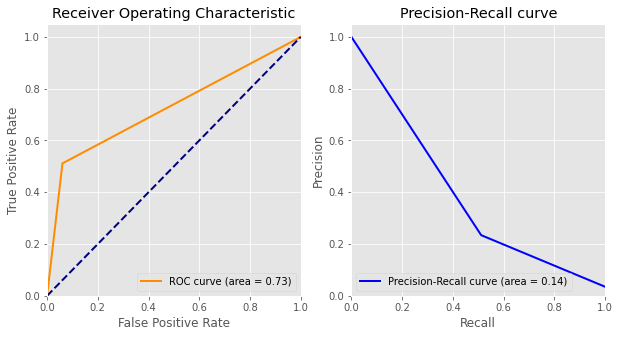

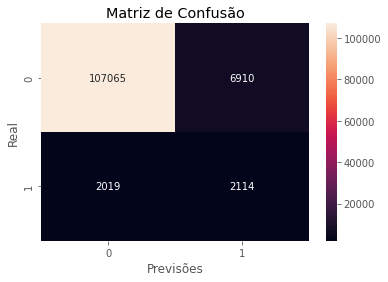

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    113975
           1       0.23      0.51      0.32      4133

    accuracy                           0.92    118108
   macro avg       0.61      0.73      0.64    118108
weighted avg       0.96      0.92      0.94    118108

CPU times: user 6min 15s, sys: 2.84 s, total: 6min 18s
Wall time: 6min 18s


In [248]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_adasyn_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [249]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_ada.predict_proba(X_test[oversample_with_adasyn_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 17.2 s, sys: 2 µs, total: 17.2 s
Wall time: 17.2 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.321349851789922  0.959970232091061
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.067620520120091                0.0
Threshold: 0.3   0.067620520120091                0.0
Threshold: 0.35  0.067620520120091                0.0
Threshold: 0.4   0.067620520120091                0.0
Threshold: 0.45  0.067620520120091                0.0
Threshold: 0.5   0.321349851789922  0.959970232091061
Threshold: 0.55                0.0  0.982191715894745
Threshold: 0.6                 0.0  0.982191715894745
Threshold: 0.65                0.0  0.982191715894745
Threshold: 0.7                 0.0  0.982191715894745
Threshold: 0.75                0.0  0.982191715894745

In [250]:
feature_importances = clf_ada.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_adasyn_cols_50_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature  Importance
41            V280        0.10
12             C14        0.10
5               C1        0.08
8               C6        0.07
6               C2        0.05
37             V96        0.05
46            V308        0.04
4            dist1        0.04
0   TransactionAmt        0.03
43            V283        0.03
29             V52        0.03
11             C13        0.03
38             V99        0.02
22             V30        0.02
21             V29        0.02
39            V127        0.02
34             V91        0.02
19             D11        0.02
42            V282        0.02
17              D5        0.02
15              D3        0.02
10             C11        0.02
9               C9        0.02
2            card2        0.02
27             V50        0.02
44            V285        0.01
32             V84        0.01
31             V81        0.01
49           M4_M2        0.01
28             V51        0.01
16              D4        0.01
3            card5        0.01
14              D2        0.01
18             D10        0.01
24             V40        0.00
35             V92        0.00
36             V93        0.00
23             V39        0.00
20             D15        0.00
30             V80        0.00
40            V130        0.00
33             V85        0.00
1            card1        0.00
13              D1        0.00
7               C5        0.00
45            V307        0.00
26             V43        0.00
47            V310        0.00
48     ProductCD_C        0.00
25             V42        0.00

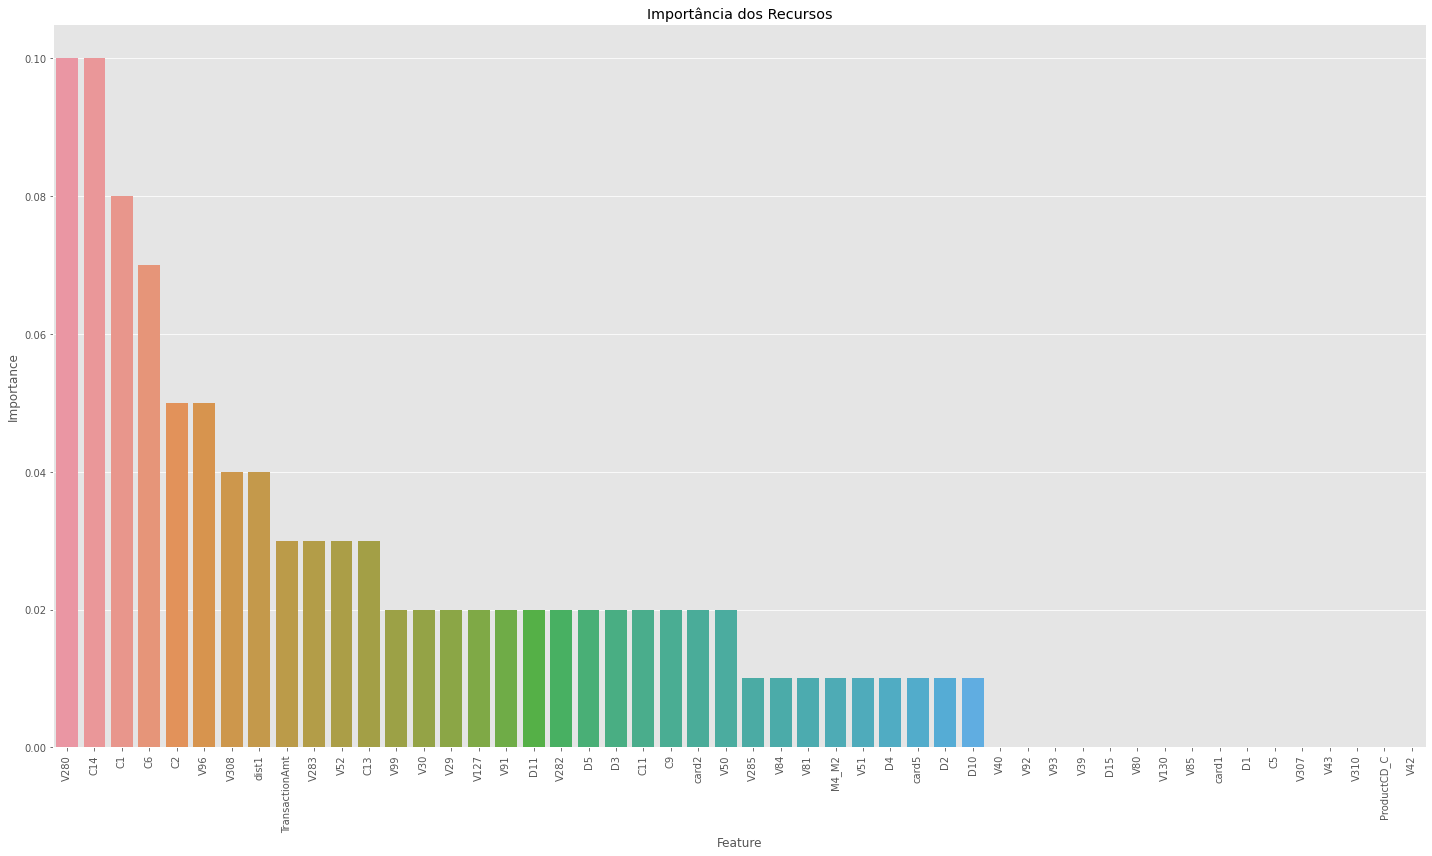

In [251]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.32233766233766237
F1-Score Negativo (Teste): 0.9527389319614521
F1-Score Positivo Médio (Validação Cruzada): 0.26549992339671674
F1-Score Positivo Fold 1: 0.2624113475177305
F1-Score Positivo Fold 2: 0.24956063268892795
F1-Score Positivo Fold 3: 0.27526132404181186
F1-Score Positivo Fold 4: 0.23404255319148934
F1-Score Positivo Fold 5: 0.2876949740034662
F1-Score Positivo Fold 6: 0.25125628140703515
F1-Score Positivo Fold 7: 0.27177700348432055
F1-Score Positivo Fold 8: 0.24242424242424243
F1-Score Positivo Fold 9: 0.27681660899653976
F1-Score Positivo Fold 10: 0.30375426621160406
F1-Score Negativo Médio (Validação Cruzada): 0.9816983821514
F1-Score Negativo Fold 1: 0.9819585393355886
F1-Score Negativo Fold 2: 0.981477464972021
F1-Score Negativo Fold 3: 0.9819507115584866
F1-Score Negativo Fold 4: 0.981264637002342
F1-Score Negativo Fold 5: 0.9821653287047083
F1-Score Negativo Fold 6: 0.980586319218241
F1-Score Negativo Fold 7: 0.9818639361332872
F1-Score N

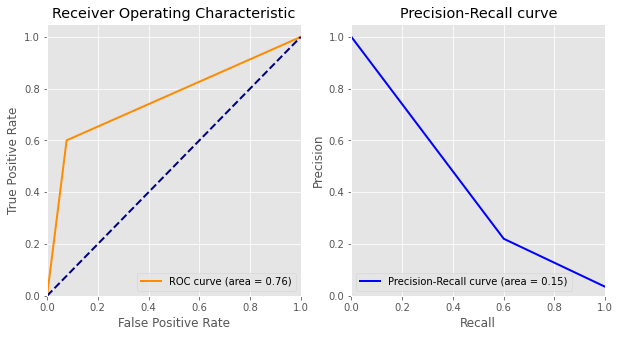

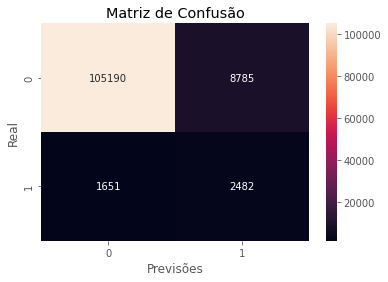

              precision    recall  f1-score   support

           0       0.98      0.92      0.95    113975
           1       0.22      0.60      0.32      4133

    accuracy                           0.91    118108
   macro avg       0.60      0.76      0.64    118108
weighted avg       0.96      0.91      0.93    118108

CPU times: user 17min 43s, sys: 768 ms, total: 17min 44s
Wall time: 1min 35s


In [252]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_50_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_adasyn_cols_50_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_adasyn_cols_50_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [253]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_knn.predict_proba(X_test[oversample_with_adasyn_cols_50_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 3h 44min 50s, sys: 1.52 s, total: 3h 44min 52s
Wall time: 18min 57s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.322337662337662  0.952738931961452
Threshold: 0.05  0.267511642421624  0.929164712819251
Threshold: 0.1   0.267511642421624  0.929164712819251
Threshold: 0.15  0.267511642421624  0.929164712819251
Threshold: 0.2   0.267511642421624  0.929164712819251
Threshold: 0.25  0.267511642421624  0.929164712819251
Threshold: 0.3   0.267511642421624  0.929164712819251
Threshold: 0.35  0.322337662337662  0.952738931961452
Threshold: 0.4   0.322337662337662  0.952738931961452
Threshold: 0.45  0.322337662337662  0.952738931961452
Threshold: 0.5   0.322337662337662  0.952738931961452
Threshold: 0.55  0.322337662337662  0.952738931961452
Threshold: 0.6   0.322337662337662  0.952738931961452
Threshold: 0.65  0.322337662337662  0.952738931961452
Threshold: 0.7   0.397167248738844   0.97249322733148
Threshold: 0.75  0.397167248738844   0.97249322733148

### 100 Chi-Square

In [254]:
#reinicializando os classificadores

clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)

F1-Score Positivo (Teste): 0.6752315506423664
F1-Score Negativo (Teste): 0.9905281410932285
F1-Score Positivo Médio (Validação Cruzada): 0.5004082584961809
F1-Score Positivo Fold 1: 0.5385934819897085
F1-Score Positivo Fold 2: 0.4601449275362319
F1-Score Positivo Fold 3: 0.5154639175257733
F1-Score Positivo Fold 4: 0.5157894736842106
F1-Score Positivo Fold 5: 0.5308219178082192
F1-Score Positivo Fold 6: 0.5212947189097104
F1-Score Positivo Fold 7: 0.4797178130511464
F1-Score Positivo Fold 8: 0.48214285714285715
F1-Score Positivo Fold 9: 0.48324514991181655
F1-Score Positivo Fold 10: 0.47686832740213525
F1-Score Negativo Médio (Validação Cruzada): 0.9876271616696753
F1-Score Negativo Fold 1: 0.9883241460132818
F1-Score Negativo Fold 2: 0.9870827915041179
F1-Score Negativo Fold 3: 0.9877604166666666
F1-Score Negativo Fold 4: 0.9880270692347736
F1-Score Negativo Fold 5: 0.9881066064762566
F1-Score Negativo Fold 6: 0.9878011721293684
F1-Score Negativo Fold 7: 0.9872045109520712
F1-Score Ne

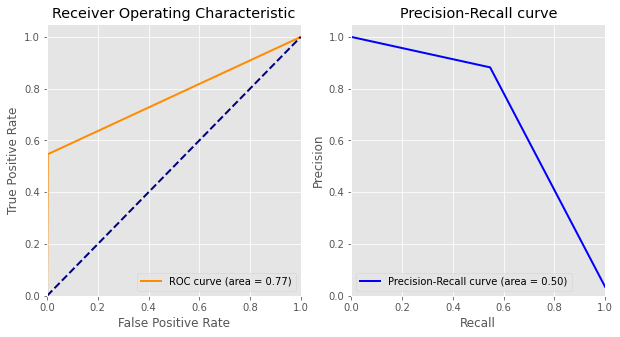

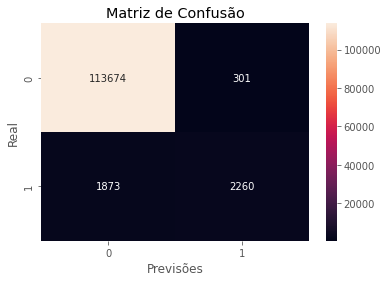

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.88      0.55      0.68      4133

    accuracy                           0.98    118108
   macro avg       0.93      0.77      0.83    118108
weighted avg       0.98      0.98      0.98    118108

CPU times: user 6min 46s, sys: 328 ms, total: 6min 47s
Wall time: 6min 46s


In [255]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [256]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_et.predict_proba(X_test[oversample_with_adasyn_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 48.8 s, sys: 3 µs, total: 48.8 s
Wall time: 48.8 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.675231550642366  0.990528141093229
Threshold: 0.05   0.26364543252102  0.900705267405884
Threshold: 0.1   0.430864580105361  0.958274453496667
Threshold: 0.15  0.548268362054543  0.975921020948712
Threshold: 0.2   0.628065942903096  0.983647709795464
Threshold: 0.25  0.674271515699119  0.987315382517747
Threshold: 0.3   0.695238095238095  0.989053879820722
Threshold: 0.35  0.703353619059951  0.989973434634759
Threshold: 0.4   0.704041366172268  0.990496664001363
Threshold: 0.45  0.695305832147937  0.990653879381812
Threshold: 0.5   0.681191640729213  0.990626184800561
Threshold: 0.55  0.655570966250578    0.9902710608679
Threshold: 0.6    0.62962962962963  0.989910937934873
Threshold: 0.65  0.599603567888999  0.989468287553984
Threshold: 0.7   0.564356435643564  0.988921591609582
Threshold: 0.75  0.523229111464406  0.988293465767387

In [257]:
feature_importances = clf_et.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_adasyn_cols_100_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
79       P_emaildomain_gmail.com  0.056618327106134
92                         M4_M2  0.033981553054882
95                          M6_F  0.031385147673739
96                          M6_T  0.030707880998784
94                          M5_T  0.029043001952603
67                   ProductCD_C  0.026988249896154
93                          M5_F  0.023326769105875
68                   ProductCD_H  0.019235736621027
97                          M8_F  0.018723009098175
74              card4_mastercard  0.018413347002306
98                          M8_T  0.017996080831285
0                 TransactionAmt  0.016894818053653
90                          M3_T  0.016823343528938
71                   ProductCD_W  0.016591265081809
69                   ProductCD_R  0.016198314359119
13                           C14  0.015367918452907
91                         M4_M0  0.014530829762683
64                     _Weekdays  0.014512560577428
14                            D1  0.014457956286858
2                          card2  0.014411827821820
1                          card1  0.014167376259732
6                             C1  0.013832194397873
75                    card4_visa  0.013658330733571
80     P_emaildomain_hotmail.com  0.013424221942347
65                        _Hours  0.013350332729686
89                          M3_F  0.013012680451696
42                           V70  0.012696143005121
12                           C13  0.012529122864174
7                             C2  0.012364534614677
15                            D2  0.012288788963178
66                         _Days  0.012001895563804
26                           V29  0.011981764718947
41                           V69  0.011859355161773
22                           V10  0.011453436862136
59                          V283  0.010852091314978
58                          V282  0.010635476558748
3                          card5  0.010362587589556
11                           C11  0.010223563928382
33                           V43  0.010042619479118
4                          addr1  0.009408713914049
39                           V53  0.008935416977648
9                             C6  0.008774736976680
32                           V42  0.008691475197282
50                           V91  0.008682339904023
52                           V93  0.008507478406711
27                           V30  0.008503980989754
36                           V50  0.008422449334932
57                          V280  0.008325855658183
49                           V90  0.008263752532685
38                           V52  0.007907603481246
35                           V49  0.007633002140497
24                           V12  0.007596123820601
43                           V75  0.007479360846848
30                           V39  0.007427146213459
28                           V35  0.007149790193674
40                           V54  0.007010561466603
34                           V48  0.006608186394282
62                          V308  0.006479190710461
53                           V96  0.006428251029625
31                           V40  0.006183056422554
21                           D15  0.006162883133620
37                           V51  0.006059999385251
25                           V13  0.005929020731520
47                           V84  0.005926665370271
20                           D11  0.005890413864860
73                card4_discover  0.005877761393003
19                           D10  0.005852165335037
23                           V11  0.005728644993092
29                           V36  0.005625117771932
60                          V285  0.005614209524175
18                            D5  0.005565579402240
84     P_emaildomain_outlook.com  0.005498894553551
61                          V307  0.005494207946709
55                          V127  0.005457260186675
17                            D4  0.005258891933717
88                          M2_F  0.005173953016662
51                   

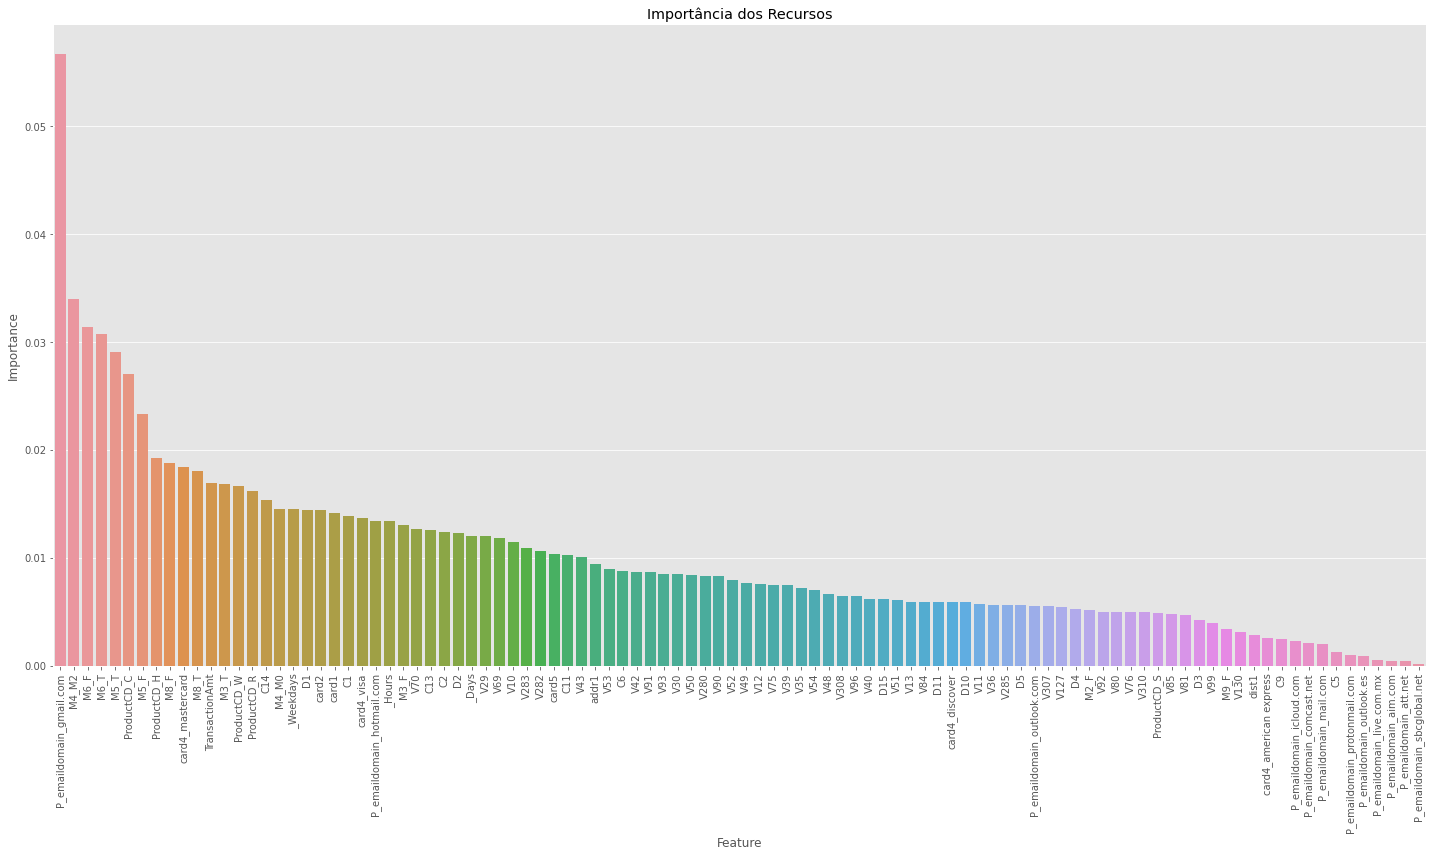

In [258]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.48680978318914886
F1-Score Negativo (Teste): 0.9788188827125935
F1-Score Positivo Médio (Validação Cruzada): 0.4246916488827849
F1-Score Positivo Fold 1: 0.42793791574279383
F1-Score Positivo Fold 2: 0.4444444444444445
F1-Score Positivo Fold 3: 0.4529147982062781
F1-Score Positivo Fold 4: 0.4204671857619577
F1-Score Positivo Fold 5: 0.43800695249130933
F1-Score Positivo Fold 6: 0.40909090909090906
F1-Score Positivo Fold 7: 0.4413793103448275
F1-Score Positivo Fold 8: 0.3670745272525028
F1-Score Positivo Fold 9: 0.42129105322763305
F1-Score Positivo Fold 10: 0.4243093922651934
F1-Score Negativo Médio (Validação Cruzada): 0.9774393912290528
F1-Score Negativo Fold 1: 0.9772887323943663
F1-Score Negativo Fold 2: 0.9786803815552333
F1-Score Negativo Fold 3: 0.9785305763308403
F1-Score Negativo Fold 4: 0.9770716894776218
F1-Score Negativo Fold 5: 0.9786897491102421
F1-Score Negativo Fold 6: 0.9759450171821306
F1-Score Negativo Fold 7: 0.9786392405063291
F1-Score 

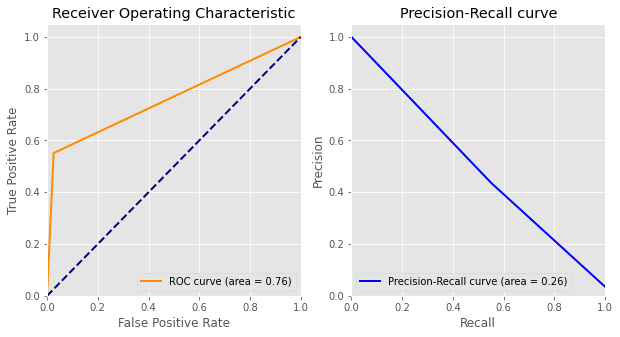

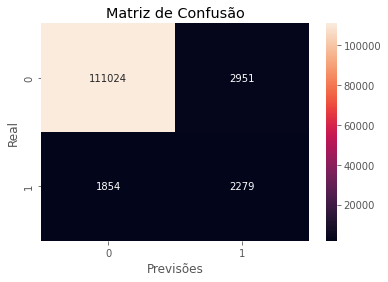

              precision    recall  f1-score   support

           0       0.98      0.97      0.98    113975
           1       0.44      0.55      0.49      4133

    accuracy                           0.96    118108
   macro avg       0.71      0.76      0.73    118108
weighted avg       0.96      0.96      0.96    118108

CPU times: user 1min 26s, sys: 320 ms, total: 1min 27s
Wall time: 1min 26s


In [259]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [260]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_dt.predict_proba(X_test[oversample_with_adasyn_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 1.22 s, sys: 0 ns, total: 1.22 s
Wall time: 1.21 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.486809783189149  0.978818882712594
Threshold: 0.05  0.486757795813755  0.978814381182445
Threshold: 0.1   0.486757795813755  0.978814381182445
Threshold: 0.15  0.486757795813755  0.978814381182445
Threshold: 0.2   0.486757795813755  0.978814381182445
Threshold: 0.25  0.486757795813755  0.978814381182445
Threshold: 0.3   0.486757795813755  0.978814381182445
Threshold: 0.35  0.486757795813755  0.978814381182445
Threshold: 0.4   0.486757795813755  0.978814381182445
Threshold: 0.45  0.486757795813755  0.978814381182445
Threshold: 0.5   0.486757795813755  0.978814381182445
Threshold: 0.55  0.486809783189149  0.978818882712594
Threshold: 0.6   0.486809783189149  0.978818882712594
Threshold: 0.65  0.486809783189149  0.978818882712594
Threshold: 0.7   0.486809783189149  0.978818882712594
Threshold: 0.75  0.486809783189149  0.978818882712594

In [261]:
feature_importances = clf_dt.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_adasyn_cols_100_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
46                           V81  0.195778653375070
6                             C1  0.131293450966670
59                          V283  0.112849218034477
13                           C14  0.077702386139796
93                          M5_F  0.049591123884677
57                          V280  0.044690283851098
41                           V69  0.029438615546869
49                           V90  0.023491759613545
94                          M5_T  0.022671414818292
12                           C13  0.021129638165097
0                 TransactionAmt  0.018311899144132
1                          card1  0.015935315141312
79       P_emaildomain_gmail.com  0.014051952890553
2                          card2  0.011623538332698
4                          addr1  0.011032811216480
91                         M4_M0  0.010273819579945
45                           V80  0.009052913914690
96                          M6_T  0.008017985135357
9                             C6  0.007999799936918
92                         M4_M2  0.007340015877575
66                         _Days  0.007193243802584
3                          card5  0.006326434541820
5                          dist1  0.006187160521640
7                             C2  0.005865552223785
65                        _Hours  0.005843318923846
32                           V42  0.005675221595321
80     P_emaildomain_hotmail.com  0.005360603656988
63                          V310  0.005156942159668
62                          V308  0.004847855900787
16                            D3  0.004843945354106
11                           C11  0.004727581046787
60                          V285  0.004551241030141
58                          V282  0.004166874492777
54                           V99  0.003989695333610
64                     _Weekdays  0.003781755179715
21                           D15  0.003550293891448
15                            D2  0.003430736869652
90                          M3_T  0.003387358467407
97                          M8_F  0.003322680774204
17                            D4  0.003225207937592
18                            D5  0.003025287452506
14                            D1  0.002941469599780
95                          M6_F  0.002880957335523
69                   ProductCD_R  0.002880665726576
22                           V10  0.002813890200978
40                           V54  0.002808184171950
19                           D10  0.002792256365442
61                          V307  0.002738276071589
10                            C9  0.002736324319000
23                           V11  0.002519672882531
73                card4_discover  0.002505748742146
68                   ProductCD_H  0.002503295393124
50                           V91  0.002440632847636
53                           V96  0.002268062412840
37                           V51  0.002117841131227
74              card4_mastercard  0.001903221813920
75                    card4_visa  0.001847890654899
20                           D11  0.001788573304949
30                           V39  0.001727538683388
39                           V53  0.001700269504333
88                          M2_F  0.001680212431275
89                          M3_F  0.001595552949361
84     P_emaildomain_outlook.com  0.001589440407235
56                          V130  0.001583779642662
55                          V127  0.001582589482960
98                          M8_T  0.001568319436057
25                           V13  0.001509398392056
38                           V52  0.001471262970698
24                           V12  0.001448893425671
35                           V49  0.001349616305596
29                           V36  0.001288387897419
28                           V35  0.001175370802089
26                           V29  0.001129493048870
43                           V75  0.001123313560228
44                           V76  0.001112903076227
8                             C5  0.000976405592138
71                   

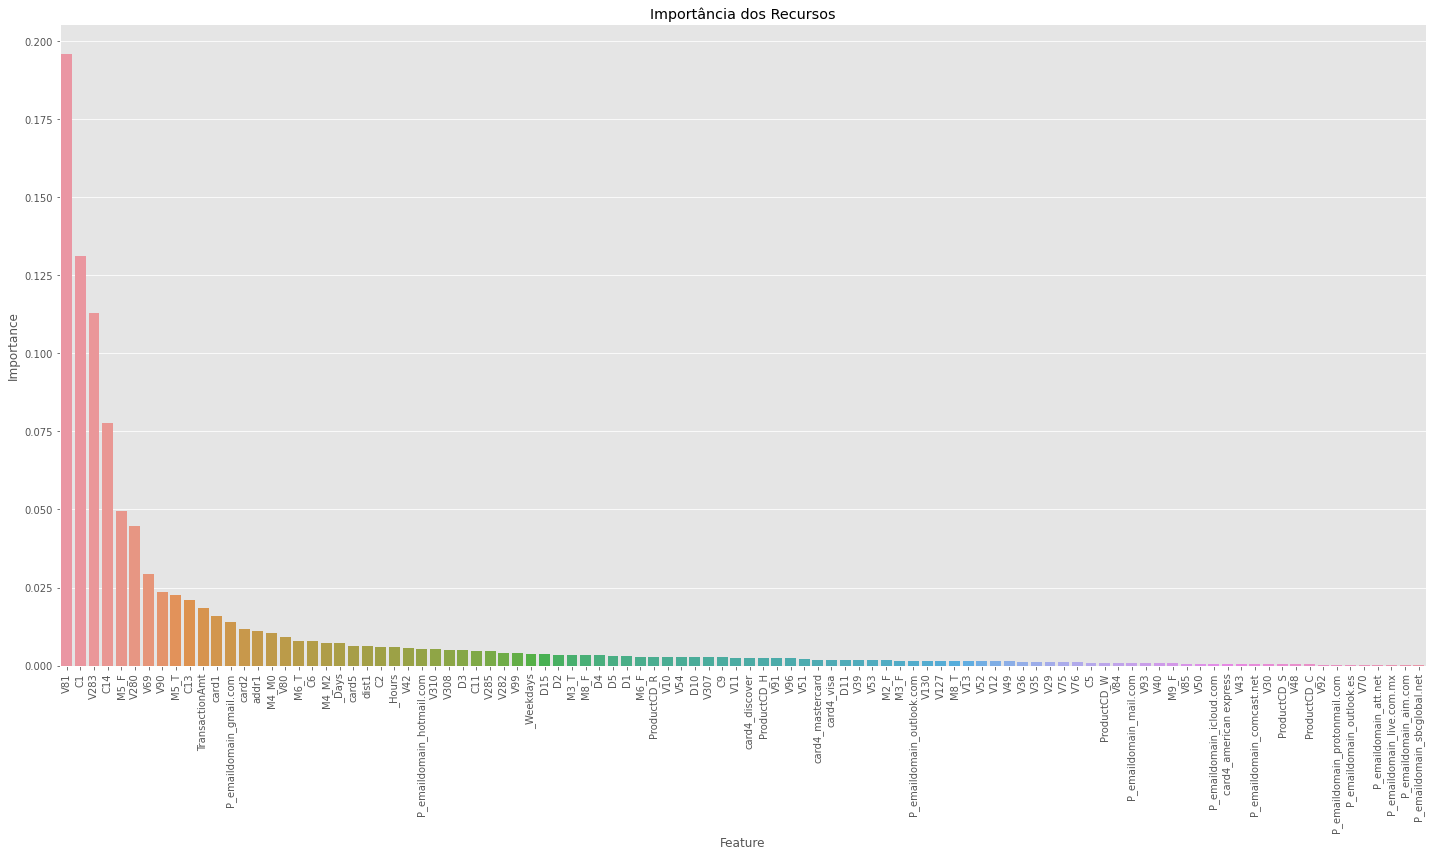

In [262]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

0:	learn: 0.6045560	total: 74.7ms	remaining: 299ms
1:	learn: 0.5372958	total: 141ms	remaining: 211ms
2:	learn: 0.4914232	total: 211ms	remaining: 141ms
3:	learn: 0.4561740	total: 277ms	remaining: 69.2ms
4:	learn: 0.4150805	total: 344ms	remaining: 0us
0:	learn: 0.5383385	total: 12.7ms	remaining: 50.8ms
1:	learn: 0.4309601	total: 22.9ms	remaining: 34.4ms
2:	learn: 0.3539234	total: 30.9ms	remaining: 20.6ms
3:	learn: 0.2917101	total: 38.5ms	remaining: 9.61ms
4:	learn: 0.2531801	total: 45.6ms	remaining: 0us
0:	learn: 0.5387421	total: 7.74ms	remaining: 31ms
1:	learn: 0.4309962	total: 16.8ms	remaining: 25.2ms
2:	learn: 0.3540277	total: 25ms	remaining: 16.7ms
3:	learn: 0.2953996	total: 32.9ms	remaining: 8.21ms
4:	learn: 0.2451221	total: 41ms	remaining: 0us
0:	learn: 0.5385422	total: 7.57ms	remaining: 30.3ms
1:	learn: 0.4308737	total: 15.9ms	remaining: 23.8ms
2:	learn: 0.3534565	total: 23.1ms	remaining: 15.4ms
3:	learn: 0.2949700	total: 30.6ms	remaining: 7.64ms
4:	learn: 0.2448694	total: 38.2ms	

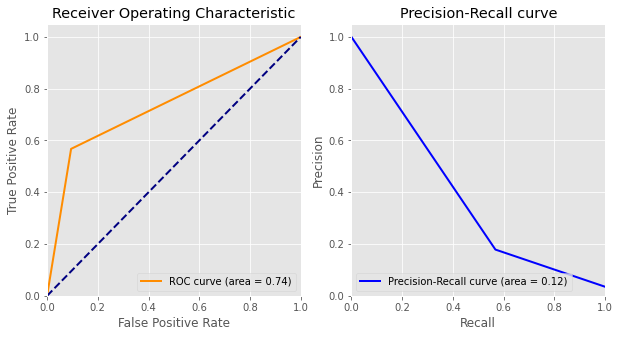

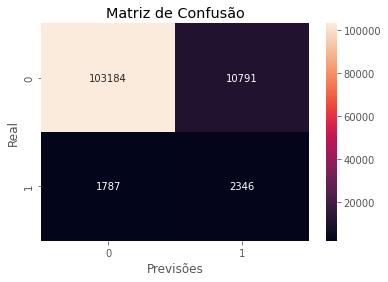

              precision    recall  f1-score   support

           0       0.98      0.91      0.94    113975
           1       0.18      0.57      0.27      4133

    accuracy                           0.89    118108
   macro avg       0.58      0.74      0.61    118108
weighted avg       0.95      0.89      0.92    118108

CPU times: user 55.9 s, sys: 620 ms, total: 56.6 s
Wall time: 37.5 s


In [263]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [264]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_cb.predict_proba(X_test[oversample_with_adasyn_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 15.9 s, sys: 44 ms, total: 16 s
Wall time: 15.5 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.271685002895194  0.942552044796434
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067684195011709  0.002015952318345
Threshold: 0.25  0.072996085355305  0.162130358740419
Threshold: 0.3   0.088597505528924  0.448242818015618
Threshold: 0.35  0.122230503421641  0.707529066486059
Threshold: 0.4   0.170481411238991  0.838518143886711
Threshold: 0.45  0.230747325169847   0.91065277482458
Threshold: 0.5   0.271685002895194  0.942552044796434
Threshold: 0.55  0.306836616454229  0.959811171177627
Threshold: 0.6   0.365982273084259  0.975138911496989
Threshold: 0.65   0.33348844423763  0.981298608602553
Threshold: 0.7   0.315160042208934  0.983108489133735
Threshold: 0.75  0.179053330477618  0.983446125408664

In [265]:
feature_importances = clf_cb.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_adasyn_cols_100_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature          Importance
22                           V10  25.333900003914483
6                             C1  24.167837794034774
62                          V308  10.719959941008435
13                           C14   9.328738469225501
57                          V280   8.511906386139223
34                           V48   4.141023094940175
24                           V12   4.080781211997460
38                           V52   2.473280365070885
11                           C11   2.302410207634069
48                           V85   2.078850257524134
41                           V69   1.627035040772749
9                             C6   1.580863557404225
79       P_emaildomain_gmail.com   1.290644556234334
26                           V29   1.108353385769280
58                          V282   0.778161510971058
59                          V283   0.476254217359223
70                   ProductCD_S   0.000000000000000
72        card4_american express   0.000000000000000
71                   ProductCD_W   0.000000000000000
73                card4_discover   0.000000000000000
66                         _Days   0.000000000000000
69                   ProductCD_R   0.000000000000000
68                   ProductCD_H   0.000000000000000
67                   ProductCD_C   0.000000000000000
75                    card4_visa   0.000000000000000
65                        _Hours   0.000000000000000
64                     _Weekdays   0.000000000000000
63                          V310   0.000000000000000
61                          V307   0.000000000000000
60                          V285   0.000000000000000
74              card4_mastercard   0.000000000000000
0                 TransactionAmt   0.000000000000000
76         P_emaildomain_aim.com   0.000000000000000
89                          M3_F   0.000000000000000
98                          M8_T   0.000000000000000
97                          M8_F   0.000000000000000
96                          M6_T   0.000000000000000
95                          M6_F   0.000000000000000
94                          M5_T   0.000000000000000
93                          M5_F   0.000000000000000
92                         M4_M2   0.000000000000000
91                         M4_M0   0.000000000000000
90                          M3_T   0.000000000000000
88                          M2_F   0.000000000000000
77         P_emaildomain_att.net   0.000000000000000
87   P_emaildomain_sbcglobal.net   0.000000000000000
86  P_emaildomain_protonmail.com   0.000000000000000
85      P_emaildomain_outlook.es   0.000000000000000
84     P_emaildomain_outlook.com   0.000000000000000
83        P_emaildomain_mail.com   0.000000000000000
82     P_emaildomain_live.com.mx   0.000000000000000
81      P_emaildomain_icloud.com   0.000000000000000
56                          V130   0.000000000000000
78     P_emaildomain_comcast.net   0.000000000000000
80     P_emaildomain_hotmail.com   0.000000000000000
50                           V91   0.000000000000000
55                          V127   0.000000000000000
54                           V99   0.000000000000000
27                           V30   0.000000000000000
25                           V13   0.000000000000000
23                           V11   0.000000000000000
21                           D15   0.000000000000000
20                           D11   0.000000000000000
19                           D10   0.000000000000000
18                            D5   0.000000000000000
17                            D4   0.000000000000000
16                            D3   0.000000000000000
15                            D2   0.000000000000000
14                            D1   0.000000000000000
12                           C13   0.000000000000000
10                            C9   0.000000000000000
8                             C5   0.000000000000000
7                             C2   0.000000000000000
5                          dist1   0.000000000000000
4                          addr1   0.0000000000000

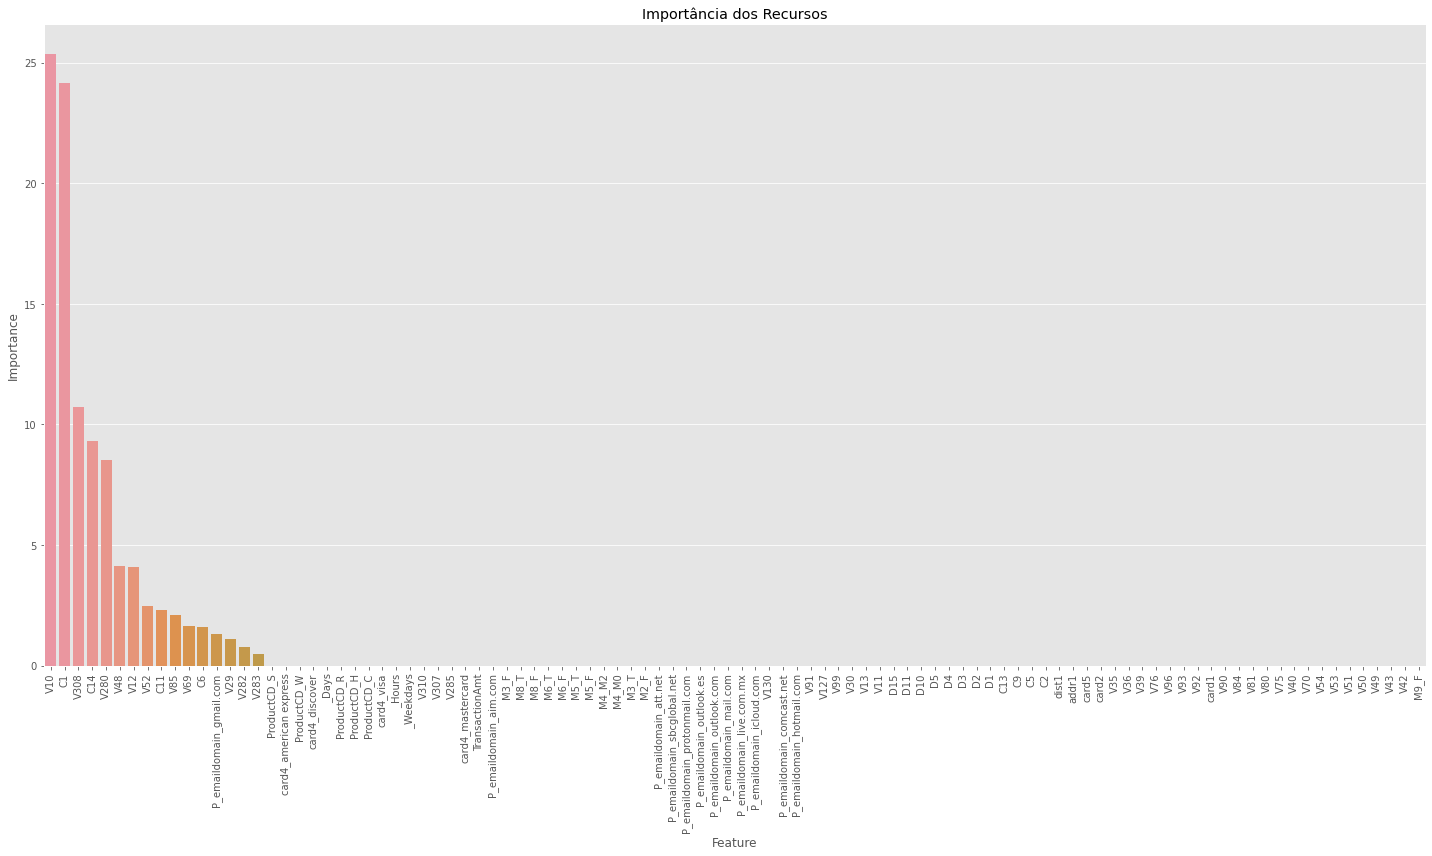

In [266]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.3487208008898776
F1-Score Negativo (Teste): 0.968832620615008
F1-Score Positivo Médio (Validação Cruzada): 0.2849038761018639
F1-Score Positivo Fold 1: 0.3660377358490566
F1-Score Positivo Fold 2: 0.3230769230769231
F1-Score Positivo Fold 3: 0.4037037037037037
F1-Score Positivo Fold 4: 0.381651376146789
F1-Score Positivo Fold 5: 0.3365200764818356
F1-Score Positivo Fold 6: 0.34651600753295664
F1-Score Positivo Fold 7: 0.09746588693957114
F1-Score Positivo Fold 8: 0.2613861386138614
F1-Score Positivo Fold 9: 0.22672064777327935
F1-Score Positivo Fold 10: 0.10596026490066224
F1-Score Negativo Médio (Validação Cruzada): 0.9841438622969265
F1-Score Negativo Fold 1: 0.985449506322536
F1-Score Negativo Fold 2: 0.9847632239632932
F1-Score Negativo Fold 3: 0.9860497357248073
F1-Score Negativo Fold 4: 0.9853967153442821
F1-Score Negativo Fold 5: 0.9849777046625394
F1-Score Negativo Fold 6: 0.9849725001082673
F1-Score Negativo Fold 7: 0.9799645159894415
F1-Score Nega

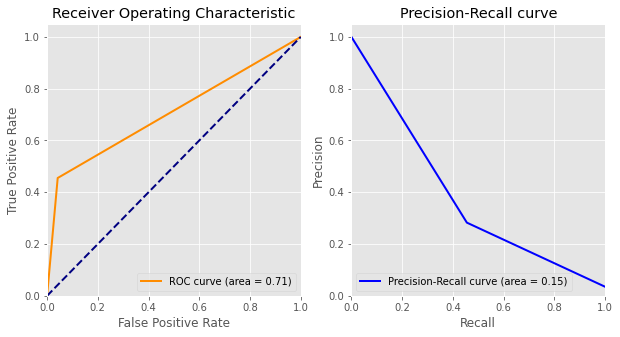

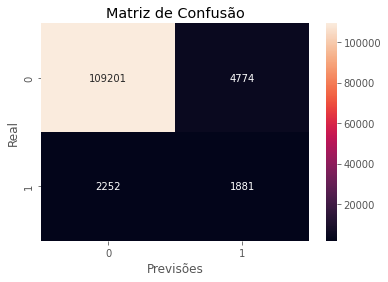

              precision    recall  f1-score   support

           0       0.98      0.96      0.97    113975
           1       0.28      0.46      0.35      4133

    accuracy                           0.94    118108
   macro avg       0.63      0.71      0.66    118108
weighted avg       0.96      0.94      0.95    118108

CPU times: user 7min 21s, sys: 340 ms, total: 7min 21s
Wall time: 7min 21s


In [267]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [268]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_gbc.predict_proba(X_test[oversample_with_adasyn_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2.69 s, sys: 0 ns, total: 2.69 s
Wall time: 2.69 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.348720800889878  0.968832620615008
Threshold: 0.05  0.099561345208029  0.579218068651932
Threshold: 0.1   0.132314036725801  0.758635989783992
Threshold: 0.15   0.16054428807947  0.835746102449889
Threshold: 0.2    0.19151955122917  0.881011699229279
Threshold: 0.25  0.222986810846236  0.910435217797755
Threshold: 0.3   0.248612762584225  0.929797437416679
Threshold: 0.35  0.278928209106642  0.944941879804428
Threshold: 0.4   0.303326810176125  0.955080483804099
Threshold: 0.45  0.327532932184095  0.963066836967104
Threshold: 0.5   0.348720800889878  0.968832620615008
Threshold: 0.55  0.366817750606093  0.973505815312554
Threshold: 0.6   0.378320935175345  0.976882242137108
Threshold: 0.65  0.380990099009901  0.979491867162932
Threshold: 0.7   0.377541998231653  0.981589155733775
Threshold: 0.75  0.358907672301691   0.98285694415467

In [269]:
feature_importances = clf_gbc.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_adasyn_cols_100_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
46                           V81  0.268252469809425
13                           C14  0.109770919308462
62                          V308  0.103236550413177
34                           V48  0.066187240561068
79       P_emaildomain_gmail.com  0.063643442742274
11                           C11  0.052626721076585
58                          V282  0.037073519366090
94                          M5_T  0.029592196317559
0                 TransactionAmt  0.024213346402442
57                          V280  0.022604911779104
93                          M5_F  0.021910902130403
6                             C1  0.020956618258703
16                            D3  0.020337911520350
9                             C6  0.016550875679948
22                           V10  0.014767852831768
53                           V96  0.013044019150378
64                     _Weekdays  0.011736045032156
65                        _Hours  0.011346997936764
97                          M8_F  0.010447107470144
20                           D11  0.010079310889338
95                          M6_F  0.009566759716680
98                          M8_T  0.008411768770474
38                           V52  0.008021559943916
96                          M6_T  0.006510534661309
12                           C13  0.005614745972607
80     P_emaildomain_hotmail.com  0.004054654213697
90                          M3_T  0.002468781244107
75                    card4_visa  0.002463212112259
56                          V130  0.002292982453881
18                            D5  0.002061478204260
39                           V53  0.002002221609796
31                           V40  0.001998237551990
84     P_emaildomain_outlook.com  0.001806789189138
89                          M3_F  0.001548379900342
74              card4_mastercard  0.001519242275215
92                         M4_M2  0.001452757518316
54                           V99  0.001356083786076
73                card4_discover  0.001033320118732
40                           V54  0.000917831259231
60                          V285  0.000912929926985
66                         _Days  0.000864465380416
91                         M4_M0  0.000853971219064
15                            D2  0.000804533703954
28                           V35  0.000719041484865
2                          card2  0.000646903953967
1                          card1  0.000589335846503
55                          V127  0.000583538981626
19                           D10  0.000544980324457
69                   ProductCD_R  0.000000000000000
67                   ProductCD_C  0.000000000000000
68                   ProductCD_H  0.000000000000000
77         P_emaildomain_att.net  0.000000000000000
70                   ProductCD_S  0.000000000000000
71                   ProductCD_W  0.000000000000000
72        card4_american express  0.000000000000000
76         P_emaildomain_aim.com  0.000000000000000
78     P_emaildomain_comcast.net  0.000000000000000
81      P_emaildomain_icloud.com  0.000000000000000
83        P_emaildomain_mail.com  0.000000000000000
85      P_emaildomain_outlook.es  0.000000000000000
86  P_emaildomain_protonmail.com  0.000000000000000
87   P_emaildomain_sbcglobal.net  0.000000000000000
88                          M2_F  0.000000000000000
82     P_emaildomain_live.com.mx  0.000000000000000
50                           V91  0.000000000000000
63                          V310  0.000000000000000
17                            D4  0.000000000000000
27                           V30  0.000000000000000
26                           V29  0.000000000000000
25                           V13  0.000000000000000
24                           V12  0.000000000000000
23                           V11  0.000000000000000
21                           D15  0.000000000000000
14                            D1  0.000000000000000
30                           V39  0.000000000000000
10                            C9  0.000000000000000
8                    

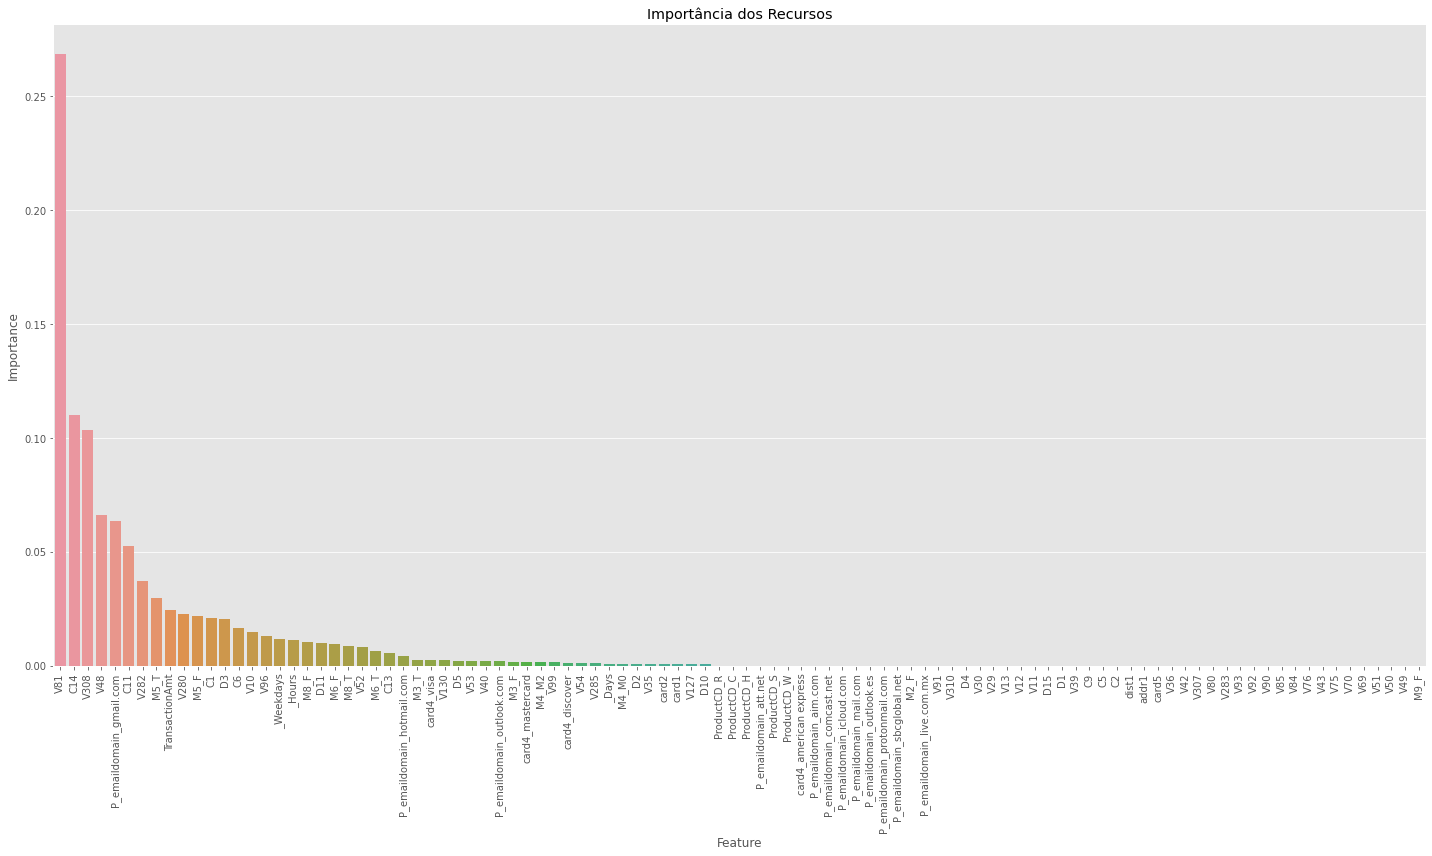

In [270]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.34297022887626916
F1-Score Negativo (Teste): 0.9660008726858241
F1-Score Positivo Médio (Validação Cruzada): 0.33763844778730545
F1-Score Positivo Fold 1: 0.40733944954128437
F1-Score Positivo Fold 2: 0.349146110056926
F1-Score Positivo Fold 3: 0.34980988593155893
F1-Score Positivo Fold 4: 0.30115830115830117
F1-Score Positivo Fold 5: 0.36432637571157495
F1-Score Positivo Fold 6: 0.3551401869158879
F1-Score Positivo Fold 7: 0.34615384615384615
F1-Score Positivo Fold 8: 0.27519379844961245
F1-Score Positivo Fold 9: 0.30174081237911027
F1-Score Positivo Fold 10: 0.32637571157495254
F1-Score Negativo Médio (Validação Cruzada): 0.9849324947645911
F1-Score Negativo Fold 1: 0.9860033799887334
F1-Score Negativo Fold 2: 0.9851483004979432
F1-Score Negativo Fold 3: 0.9851922410807067
F1-Score Negativo Fold 4: 0.9843317174515235
F1-Score Negativo Fold 5: 0.9854946958216065
F1-Score Negativo Fold 6: 0.985056525317278
F1-Score Negativo Fold 7: 0.985282659509999
F1-Scor

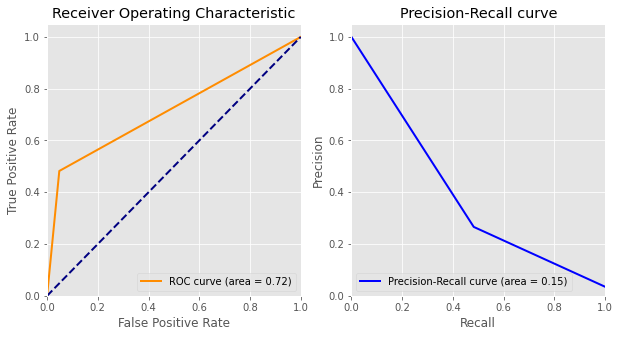

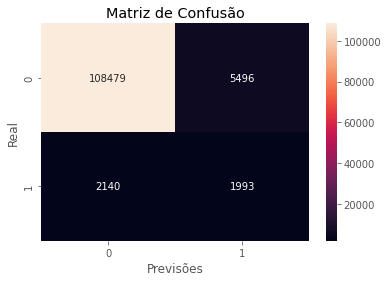

              precision    recall  f1-score   support

           0       0.98      0.95      0.97    113975
           1       0.27      0.48      0.34      4133

    accuracy                           0.94    118108
   macro avg       0.62      0.72      0.65    118108
weighted avg       0.96      0.94      0.94    118108

CPU times: user 8min 52s, sys: 4.86 s, total: 8min 57s
Wall time: 8min 56s


In [271]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [272]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_ada.predict_proba(X_test[oversample_with_adasyn_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 24.4 s, sys: 1e+03 ns, total: 24.4 s
Wall time: 24.4 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.342970228876269  0.966000872685824
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.067620520120091                0.0
Threshold: 0.3   0.067620520120091                0.0
Threshold: 0.35  0.067620520120091                0.0
Threshold: 0.4   0.067620520120091                0.0
Threshold: 0.45  0.067620520120091                0.0
Threshold: 0.5   0.342970228876269  0.966000872685824
Threshold: 0.55                0.0  0.982191715894745
Threshold: 0.6                 0.0  0.982191715894745
Threshold: 0.65                0.0  0.982191715894745
Threshold: 0.7                 0.0  0.982191715894745
Threshold: 0.75                0.0  0.982191715894745

In [273]:
feature_importances = clf_ada.feature_importances_

df = pd.DataFrame({'Feature': oversample_with_adasyn_cols_100_chi2, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature  Importance
57                          V280        0.09
13                           C14        0.08
53                           V96        0.06
6                             C1        0.06
9                             C6        0.03
59                          V283        0.03
75                    card4_visa        0.03
0                 TransactionAmt        0.03
65                        _Hours        0.03
94                          M5_T        0.03
16                            D3        0.02
62                          V308        0.02
23                           V11        0.02
74              card4_mastercard        0.02
39                           V53        0.02
96                          M6_T        0.02
93                          M5_F        0.02
89                          M3_F        0.02
95                          M6_F        0.02
11                           C11        0.02
92                         M4_M2        0.02
54                           V99        0.01
64                     _Weekdays        0.01
1                          card1        0.01
58                          V282        0.01
47                           V84        0.01
55                          V127        0.01
79       P_emaildomain_gmail.com        0.01
66                         _Days        0.01
68                   ProductCD_H        0.01
73                card4_discover        0.01
80     P_emaildomain_hotmail.com        0.01
84     P_emaildomain_outlook.com        0.01
90                          M3_T        0.01
91                         M4_M0        0.01
97                          M8_F        0.01
98                          M8_T        0.01
46                           V81        0.01
50                           V91        0.01
38                           V52        0.01
31                           V40        0.01
2                          card2        0.01
5                          dist1        0.01
10                            C9        0.01
12                           C13        0.01
17                            D4        0.01
18                            D5        0.01
19                           D10        0.01
22                           V10        0.01
24                           V12        0.01
28                           V35        0.01
99                          M9_F        0.01
52                           V93        0.00
34                           V48        0.00
78     P_emaildomain_comcast.net        0.00
36                           V50        0.00
37                           V51        0.00
81      P_emaildomain_icloud.com        0.00
82     P_emaildomain_live.com.mx        0.00
83        P_emaildomain_mail.com        0.00
45                           V80        0.00
85      P_emaildomain_outlook.es        0.00
86  P_emaildomain_protonmail.com        0.00
87   P_emaildomain_sbcglobal.net        0.00
88                          M2_F        0.00
15                            D2        0.00
14                            D1        0.00
44                           V76        0.00
43                           V75        0.00
8                             C5        0.00
7                             C2        0.00
42                           V70        0.00
4                          addr1        0.00
3                          card5        0.00
41                           V69        0.00
77         P_emaildomain_att.net        0.00
76         P_emaildomain_aim.com        0.00
20                           D11        0.00
63                          V310        0.00
33                           V43        0.00
32                           V42        0.00
56                          V130        0.00
51                           V92        0.00
30                           V39        0.00
29                           V36        0.00
60                          V285        0.00
61                          V307        0.00
35                           V49        0.00
27                  

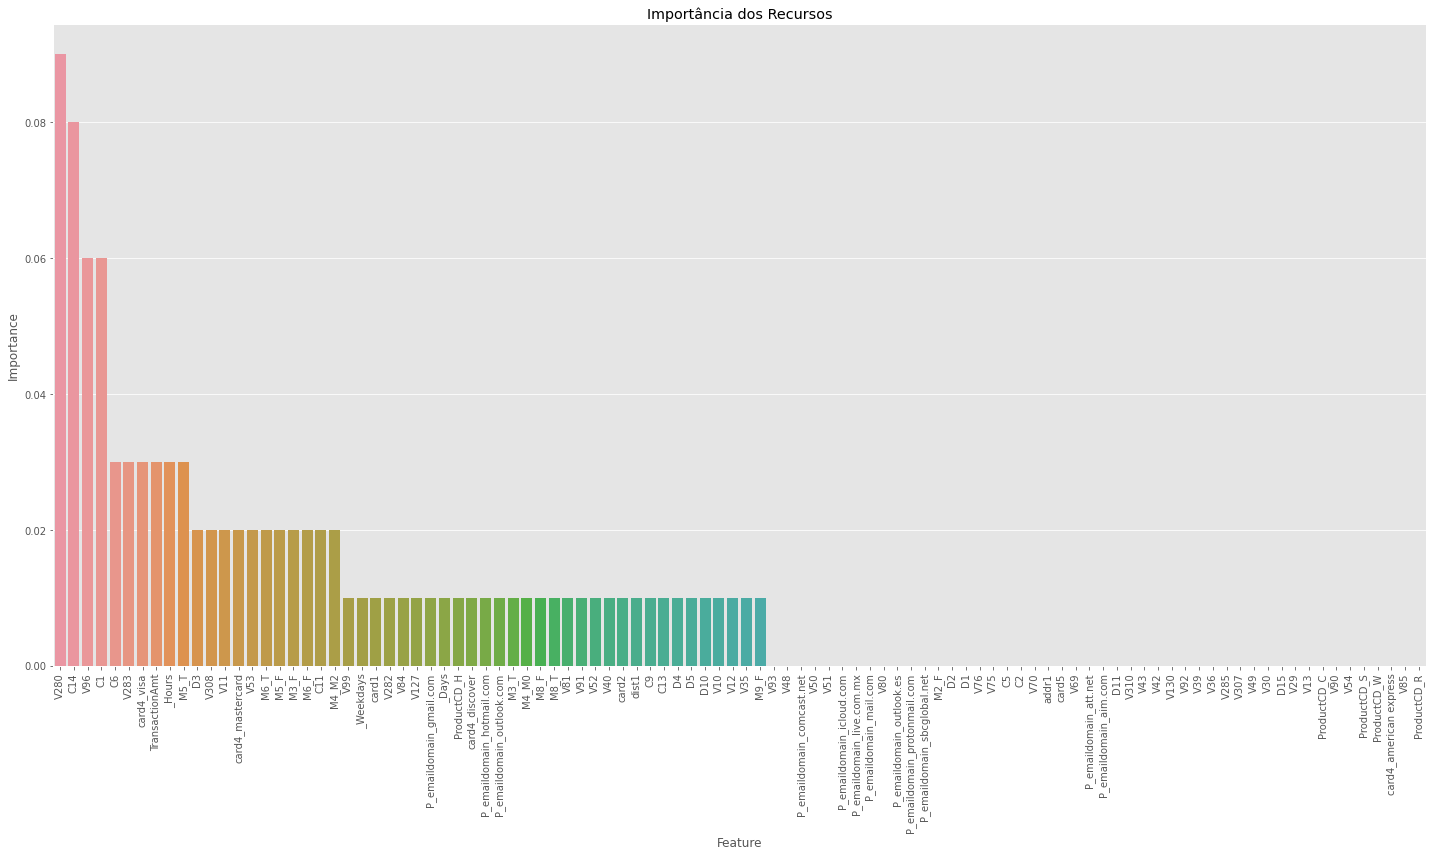

In [274]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.31638706385150217
F1-Score Negativo (Teste): 0.9514054203564903
F1-Score Positivo Médio (Validação Cruzada): 0.26579247404413464
F1-Score Positivo Fold 1: 0.2636203866432338
F1-Score Positivo Fold 2: 0.2491349480968858
F1-Score Positivo Fold 3: 0.2539130434782609
F1-Score Positivo Fold 4: 0.23633156966490299
F1-Score Positivo Fold 5: 0.2901554404145078
F1-Score Positivo Fold 6: 0.24834437086092717
F1-Score Positivo Fold 7: 0.2694300518134715
F1-Score Positivo Fold 8: 0.25874125874125875
F1-Score Positivo Fold 9: 0.2852233676975945
F1-Score Positivo Fold 10: 0.30303030303030304
F1-Score Negativo Médio (Validação Cruzada): 0.9815247153164739
F1-Score Negativo Fold 1: 0.9818244913894071
F1-Score Negativo Fold 2: 0.9811664641555284
F1-Score Negativo Fold 3: 0.981385863669892
F1-Score Negativo Fold 4: 0.9812188245499891
F1-Score Negativo Fold 5: 0.9821637807577138
F1-Score Negativo Fold 6: 0.9802763055000434
F1-Score Negativo Fold 7: 0.9816430152323916
F1-Score 

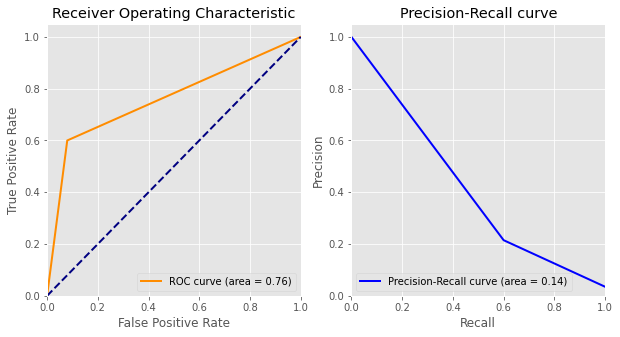

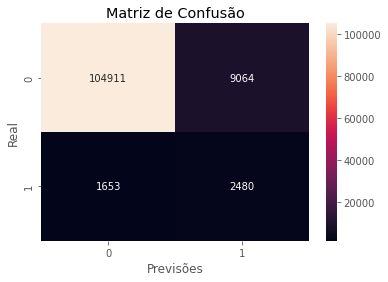

              precision    recall  f1-score   support

           0       0.98      0.92      0.95    113975
           1       0.21      0.60      0.32      4133

    accuracy                           0.91    118108
   macro avg       0.60      0.76      0.63    118108
weighted avg       0.96      0.91      0.93    118108

CPU times: user 27min 9s, sys: 732 ms, total: 27min 10s
Wall time: 2min 24s


In [275]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_adasyn[oversample_with_adasyn_cols_100_chi2], y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test[oversample_with_adasyn_cols_100_chi2])

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test[oversample_with_adasyn_cols_100_chi2], \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [276]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_knn.predict_proba(X_test[oversample_with_adasyn_cols_100_chi2])[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 5h 38min 24s, sys: 1.12 s, total: 5h 38min 25s
Wall time: 28min 35s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.316387063851502   0.95140542035649
Threshold: 0.05  0.264703042008691  0.929338394290646
Threshold: 0.1   0.264703042008691  0.929338394290646
Threshold: 0.15  0.264703042008691  0.929338394290646
Threshold: 0.2   0.264703042008691  0.929338394290646
Threshold: 0.25  0.264703042008691  0.929338394290646
Threshold: 0.3   0.264703042008691  0.929338394290646
Threshold: 0.35  0.316387063851502   0.95140542035649
Threshold: 0.4   0.316387063851502   0.95140542035649
Threshold: 0.45  0.316387063851502   0.95140542035649
Threshold: 0.5   0.316387063851502   0.95140542035649
Threshold: 0.55  0.316387063851502   0.95140542035649
Threshold: 0.6   0.316387063851502   0.95140542035649
Threshold: 0.65  0.316387063851502   0.95140542035649
Threshold: 0.7   0.390873951164325  0.971361958077914
Threshold: 0.75  0.390873951164325  0.971361958077914

### Todas as colunas

In [277]:
#reinicializando os classificadores

clf_et = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf_dt = DecisionTreeClassifier(random_state=0)
clf_cb = CatBoostClassifier(iterations=5, learning_rate=0.1) # loss_function='CrossEntropy')
clf_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=3)

F1-Score Positivo (Teste): 0.6752778612195856
F1-Score Negativo (Teste): 0.9905819008703683
F1-Score Positivo Médio (Validação Cruzada): 0.4930525441182958
F1-Score Positivo Fold 1: 0.5147826086956522
F1-Score Positivo Fold 2: 0.4676258992805755
F1-Score Positivo Fold 3: 0.493006993006993
F1-Score Positivo Fold 4: 0.5165794066317627
F1-Score Positivo Fold 5: 0.5395189003436427
F1-Score Positivo Fold 6: 0.49391304347826087
F1-Score Positivo Fold 7: 0.48865619546247824
F1-Score Positivo Fold 8: 0.4593128390596745
F1-Score Positivo Fold 9: 0.4767025089605734
F1-Score Positivo Fold 10: 0.48042704626334526
F1-Score Negativo Médio (Validação Cruzada): 0.9875205622016846
F1-Score Negativo Fold 1: 0.9878943029461535
F1-Score Negativo Fold 2: 0.9871672591693402
F1-Score Negativo Fold 3: 0.9874186550976138
F1-Score Negativo Fold 4: 0.9879821250379627
F1-Score Negativo Fold 5: 0.9883680555555555
F1-Score Negativo Fold 6: 0.9873736278040526
F1-Score Negativo Fold 7: 0.987287951754957
F1-Score Nega

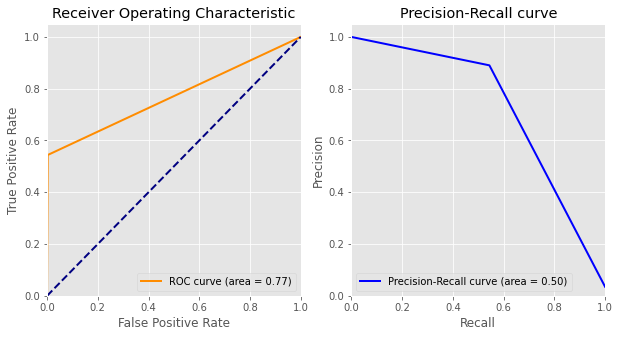

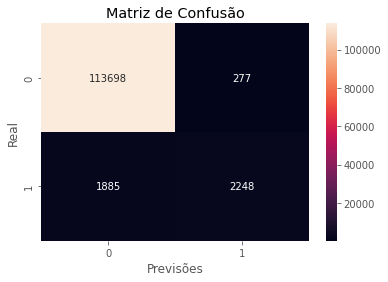

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.89      0.54      0.68      4133

    accuracy                           0.98    118108
   macro avg       0.94      0.77      0.83    118108
weighted avg       0.98      0.98      0.98    118108

CPU times: user 8min 8s, sys: 308 ms, total: 8min 9s
Wall time: 8min 8s


In [278]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_et.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_et.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_et, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [279]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_et.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 53.6 s, sys: 0 ns, total: 53.6 s
Wall time: 53.6 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.675277861219586  0.990581900870368
Threshold: 0.05  0.273720999405116  0.906678769348366
Threshold: 0.1   0.443788121990369   0.96073712501303
Threshold: 0.15   0.56411140812279  0.977495225248087
Threshold: 0.2   0.639122411318434   0.98445655341735
Threshold: 0.25  0.683488881207512  0.987927238207412
Threshold: 0.3   0.705487956295009  0.989603877946371
Threshold: 0.35  0.713930022277552  0.990449942034692
Threshold: 0.4   0.707029104887425  0.990678454737651
Threshold: 0.45  0.698571428571429  0.990794708920843
Threshold: 0.5   0.681263032469467  0.990675462523202
Threshold: 0.55  0.654714064914992  0.990276218084319
Threshold: 0.6   0.627720870678617  0.989885549293815
Threshold: 0.65  0.596153846153846  0.989417161922636
Threshold: 0.7   0.565336062777209  0.988938763815692
Threshold: 0.75  0.522924411400248  0.988311423577528

In [280]:
feature_importances = clf_et.feature_importances_

df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
101         P_emaildomain_gmail.com  0.061373466013409
155                            M6_F  0.033780610407601
154                            M5_T  0.027954321150912
152                           M4_M2  0.027032489054489
76                      ProductCD_C  0.025270907322449
156                            M6_T  0.023545813549987
138         P_emaildomain_yahoo.com  0.022081462922752
153                            M5_F  0.019474963684690
77                      ProductCD_H  0.018057021972004
159                            M8_F  0.015919417356963
104       P_emaildomain_hotmail.com  0.015059314799080
0                    TransactionAmt  0.014670269526090
78                      ProductCD_R  0.014640104331348
80                      ProductCD_W  0.013927998521011
150                           M4_M0  0.013843241389660
13                              C14  0.013354424894597
83                 card4_mastercard  0.013299862687833
73                        _Weekdays  0.013036312659679
2                             card2  0.012474544009480
84                       card4_visa  0.012263391764626
6                                C1  0.012258937451480
1                             card1  0.012122069681198
148                            M3_F  0.011915144046101
45                              V50  0.011832299519039
74                           _Hours  0.011781240402330
160                            M8_T  0.011744303959437
15                               D2  0.011457285289213
68                             V283  0.011396633735065
7                                C2  0.011113699543205
12                              C13  0.011039868271762
149                            M3_T  0.010779402482428
50                              V69  0.010775405998877
75                            _Days  0.010673649061207
67                             V282  0.010340482818872
46                              V51  0.010217982468513
11                              C11  0.009629657055588
48                              V53  0.009589164623307
14                               D1  0.009420320549629
43                              V48  0.009391508016108
3                             card5  0.009195577863708
35                              V29  0.008753245110339
59                              V91  0.008695317125240
58                              V90  0.008247183307817
86      P_emaildomain_anonymous.com  0.008225648794025
51                              V70  0.008203432088793
44                              V49  0.008105593636487
9                                C6  0.007940928832027
4                             addr1  0.007711722906425
60                              V92  0.007456690883064
61                              V93  0.007135849666916
49                              V54  0.007068212646277
22                               V1  0.007044381833059
151                           M4_M1  0.007002945166726
52                              V75  0.006950236760273
146                            M2_F  0.006857547299999
41                              V42  0.006831867068574
33                              V12  0.006751083596848
47                              V52  0.006721055492591
19                              D10  0.006672936146259
66                             V280  0.006669976450936
37                              V35  0.006267668024965
39                              V39  0.006216194302593
71                             V308  0.006179947571833
42                              V43  0.006162986793062
31                              V10  0.006035377145191
34                              V13  0.006021531454597
36                              V30  0.005935864165969
158                            M7_T  0.005808235786004
40                              V40  0.005796589949142
62                              V96  0.005681875650474
53                              V76  0.005679764858327
17                               D4  0.005663791104045
56           

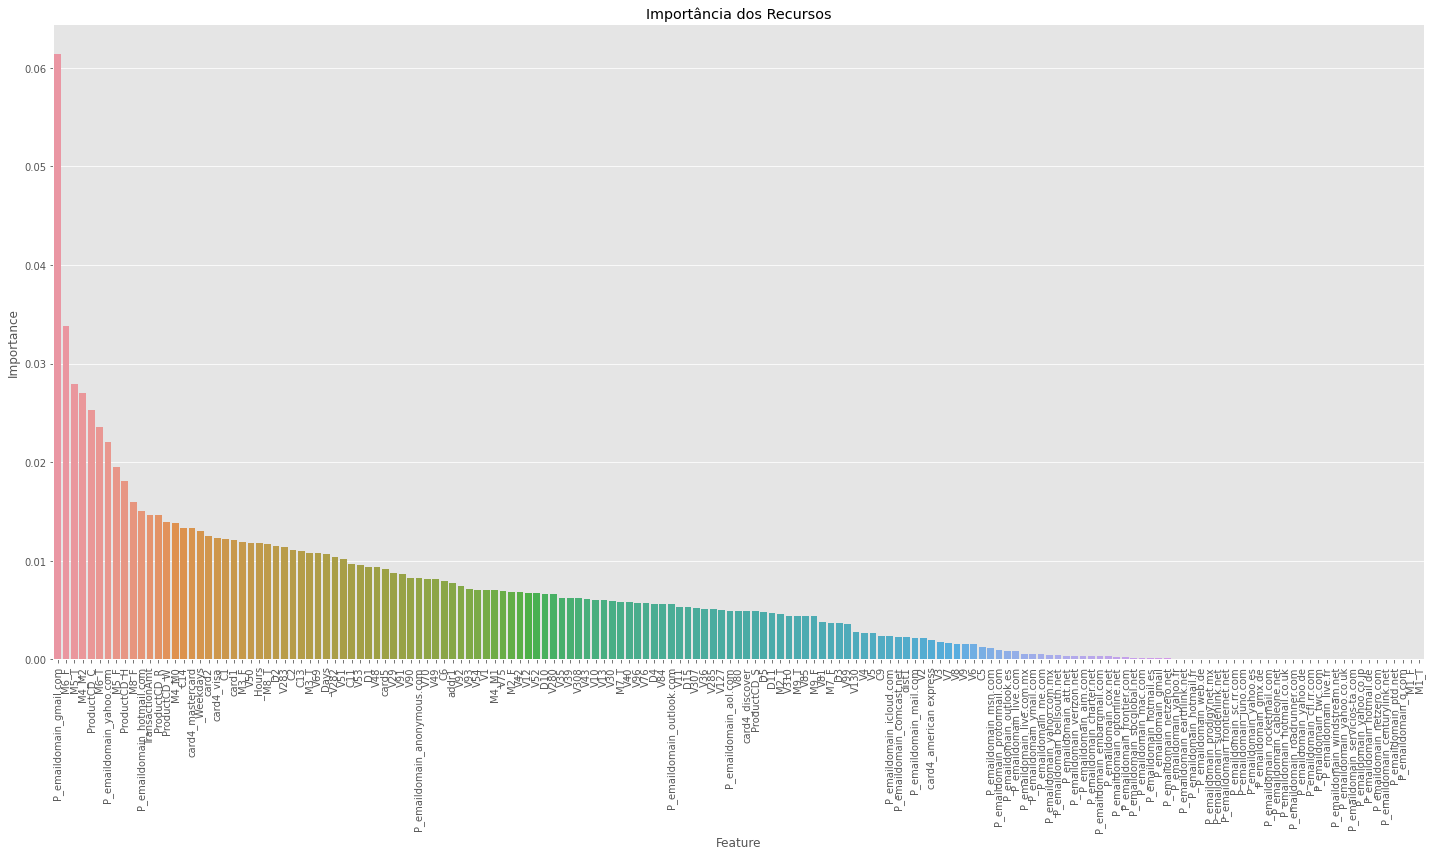

In [281]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.4993472584856396
F1-Score Negativo (Teste): 0.9797290154344915
F1-Score Positivo Médio (Validação Cruzada): 0.42615237466461686
F1-Score Positivo Fold 1: 0.4409799554565702
F1-Score Positivo Fold 2: 0.4363636363636364
F1-Score Positivo Fold 3: 0.4668192219679634
F1-Score Positivo Fold 4: 0.43001119820828665
F1-Score Positivo Fold 5: 0.45339470655926356
F1-Score Positivo Fold 6: 0.39823008849557523
F1-Score Positivo Fold 7: 0.41291810841983856
F1-Score Positivo Fold 8: 0.3735498839907193
F1-Score Positivo Fold 9: 0.4097452934662237
F1-Score Positivo Fold 10: 0.43951165371809103
F1-Score Negativo Médio (Validação Cruzada): 0.9776611957320274
F1-Score Negativo Fold 1: 0.9779088188699173
F1-Score Negativo Fold 2: 0.9781901327939496
F1-Score Negativo Fold 3: 0.9795146826094601
F1-Score Negativo Fold 4: 0.9776057019666505
F1-Score Negativo Fold 5: 0.979123632048521
F1-Score Negativo Fold 6: 0.9760542301258913
F1-Score Negativo Fold 7: 0.9776312898264118
F1-Score 

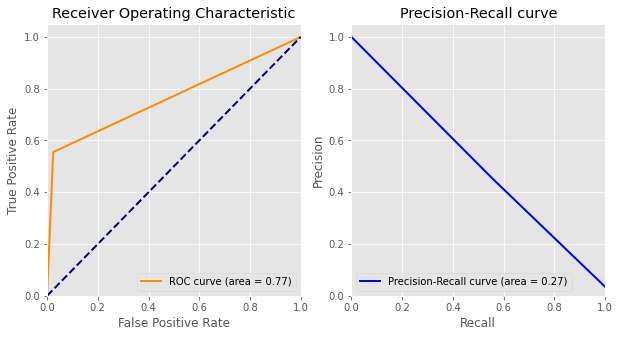

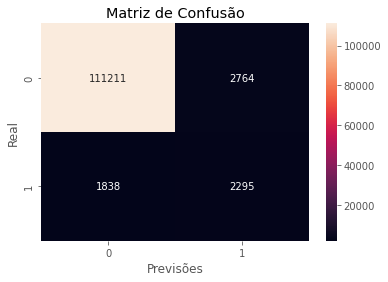

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    113975
           1       0.45      0.56      0.50      4133

    accuracy                           0.96    118108
   macro avg       0.72      0.77      0.74    118108
weighted avg       0.97      0.96      0.96    118108

CPU times: user 1min 49s, sys: 356 ms, total: 1min 49s
Wall time: 1min 49s


In [282]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_dt.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_dt.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_dt, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [283]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_dt.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 1.22 s, sys: 0 ns, total: 1.22 s
Wall time: 1.22 s


Metrics          F1_score Positivo  F1_score Negativo
Original          0.49934725848564  0.979729015434492
Threshold: 0.05  0.499292940280648  0.979724521304009
Threshold: 0.1   0.499292940280648  0.979724521304009
Threshold: 0.15  0.499292940280648  0.979724521304009
Threshold: 0.2   0.499292940280648  0.979724521304009
Threshold: 0.25  0.499292940280648  0.979724521304009
Threshold: 0.3   0.499292940280648  0.979724521304009
Threshold: 0.35  0.499292940280648  0.979724521304009
Threshold: 0.4   0.499292940280648  0.979724521304009
Threshold: 0.45  0.499292940280648  0.979724521304009
Threshold: 0.5   0.499292940280648  0.979724521304009
Threshold: 0.55   0.49934725848564  0.979729015434492
Threshold: 0.6    0.49934725848564  0.979729015434492
Threshold: 0.65   0.49934725848564  0.979729015434492
Threshold: 0.7    0.49934725848564  0.979729015434492
Threshold: 0.75   0.49934725848564  0.979729015434492

In [284]:
feature_importances = clf_dt.feature_importances_

df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
55                              V81  0.195750715762792
6                                C1  0.131220157265995
68                             V283  0.112024372033176
13                              C14  0.079667161426486
153                            M5_F  0.048809978968156
66                             V280  0.046447850447222
50                              V69  0.029747369906790
58                              V90  0.023539650725647
154                            M5_T  0.022673997467155
12                              C13  0.016948630571422
0                    TransactionAmt  0.016873887103150
101         P_emaildomain_gmail.com  0.015700956019431
150                           M4_M0  0.015552578026563
1                             card1  0.015374631645688
4                             addr1  0.010630069789978
2                             card2  0.010245779566491
54                              V80  0.008988795610400
152                           M4_M2  0.007593826322933
3                             card5  0.006211991654791
47                              V52  0.005841024438230
75                            _Days  0.005821919341789
104       P_emaildomain_hotmail.com  0.005726586747069
69                             V285  0.005467118676791
74                           _Hours  0.004897223612412
7                                C2  0.004803225537383
5                             dist1  0.004799635834159
11                              C11  0.004656989117684
159                            M8_F  0.004515280280662
9                                C6  0.004393862634308
71                             V308  0.004304375103616
138         P_emaildomain_yahoo.com  0.004220046169644
16                               D3  0.004160870371448
63                              V99  0.003930673844746
67                             V282  0.003895521075231
15                               D2  0.003832430051912
21                              D15  0.003807199846260
156                            M6_T  0.003763196689240
73                        _Weekdays  0.003380780719685
72                             V310  0.003245031053769
48                              V53  0.003107390543509
19                              D10  0.002962050195065
10                               C9  0.002947737083233
17                               D4  0.002896010135301
162                            M9_T  0.002838006188513
18                               D5  0.002795418053269
14                               D1  0.002722963363050
70                             V307  0.002596955060261
78                      ProductCD_R  0.002554393045217
82                   card4_discover  0.002403498971325
77                      ProductCD_H  0.002400141356364
59                              V91  0.002286894480026
46                              V51  0.002274464194612
86      P_emaildomain_anonymous.com  0.002256239835475
24                               V3  0.002175150660763
160                            M8_T  0.001978562476366
83                 card4_mastercard  0.001777886171472
33                              V12  0.001754333782859
49                              V54  0.001711038938463
62                              V96  0.001707146162855
148                            M3_F  0.001612253893279
147                            M2_T  0.001598791171325
120       P_emaildomain_outlook.com  0.001565835223561
84                       card4_visa  0.001541941888890
20                              D11  0.001516801560082
65                             V130  0.001425652220394
146                            M2_F  0.001401622823938
64                             V127  0.001396388611509
34                              V13  0.001345128088418
38                              V36  0.001284110424122
151                           M4_M1  0.001264621428180
26                               V5  0.001228305247422
45                              V50  0.001201014198528
114          

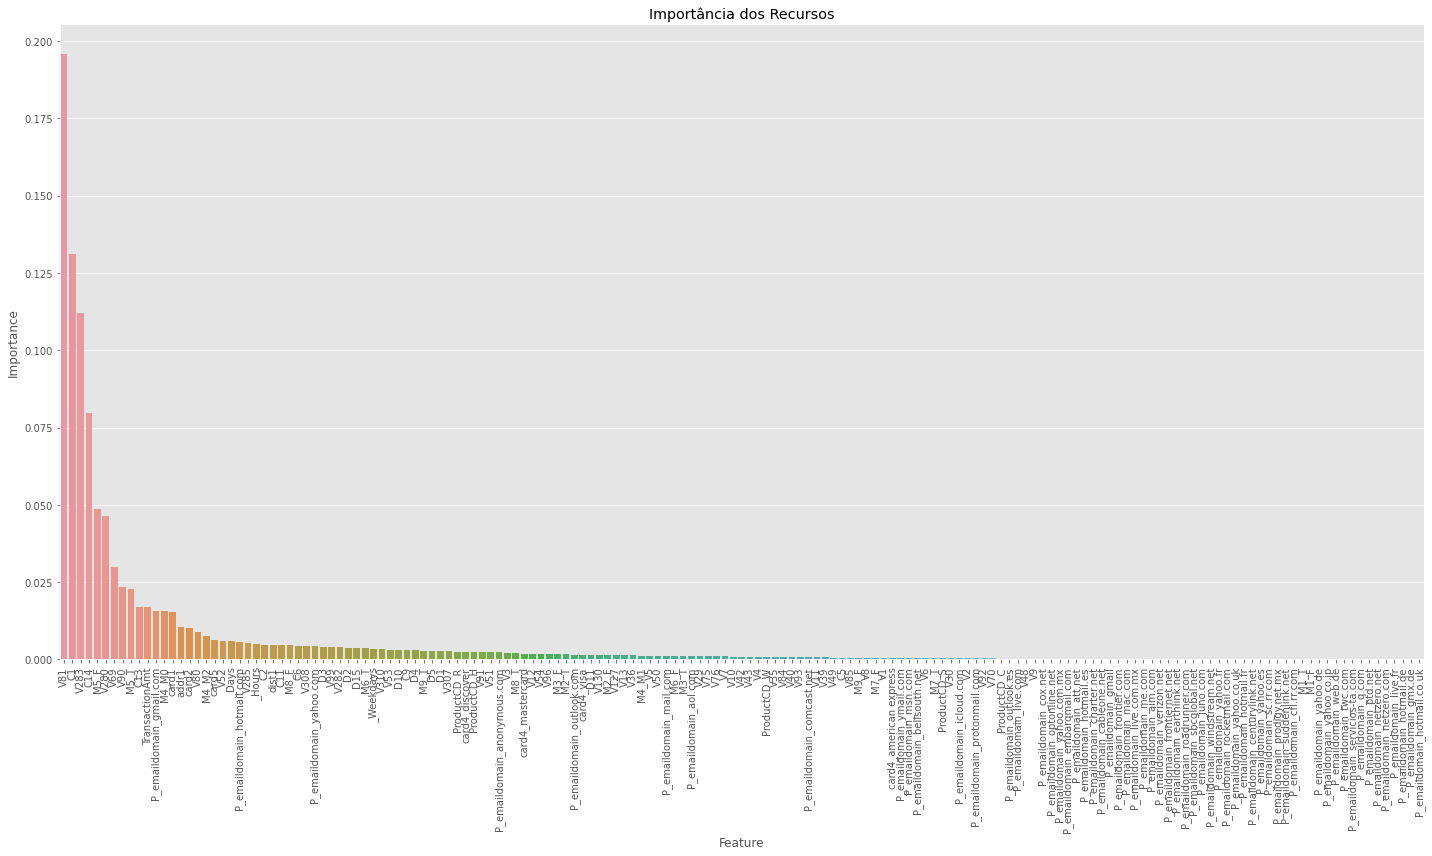

In [285]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

0:	learn: 0.6025149	total: 77.9ms	remaining: 312ms
1:	learn: 0.5482334	total: 154ms	remaining: 231ms
2:	learn: 0.4968516	total: 234ms	remaining: 156ms
3:	learn: 0.4575837	total: 313ms	remaining: 78.3ms
4:	learn: 0.4239796	total: 391ms	remaining: 0us
0:	learn: 0.5336608	total: 13.2ms	remaining: 52.6ms
1:	learn: 0.4271318	total: 23.3ms	remaining: 35ms
2:	learn: 0.3416706	total: 32ms	remaining: 21.3ms
3:	learn: 0.2888256	total: 39.8ms	remaining: 9.95ms
4:	learn: 0.2438958	total: 48.6ms	remaining: 0us
0:	learn: 0.5331992	total: 7.91ms	remaining: 31.6ms
1:	learn: 0.4266171	total: 16.2ms	remaining: 24.3ms
2:	learn: 0.3413103	total: 24.5ms	remaining: 16.3ms
3:	learn: 0.2883925	total: 32.4ms	remaining: 8.09ms
4:	learn: 0.2434156	total: 41ms	remaining: 0us
0:	learn: 0.5334749	total: 8.76ms	remaining: 35ms
1:	learn: 0.4268605	total: 18ms	remaining: 27ms
2:	learn: 0.3408881	total: 26.3ms	remaining: 17.6ms
3:	learn: 0.2880311	total: 34.1ms	remaining: 8.54ms
4:	learn: 0.2431527	total: 42.7ms	remain

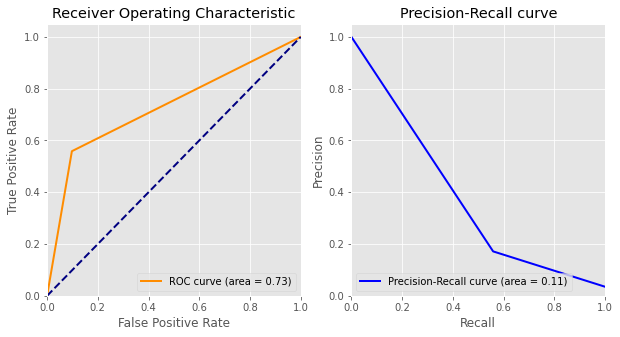

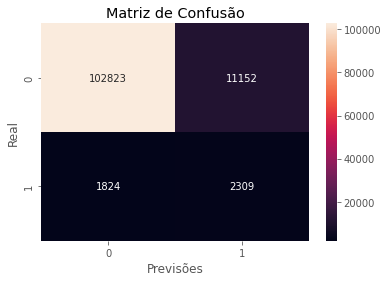

              precision    recall  f1-score   support

           0       0.98      0.90      0.94    113975
           1       0.17      0.56      0.26      4133

    accuracy                           0.89    118108
   macro avg       0.58      0.73      0.60    118108
weighted avg       0.95      0.89      0.92    118108

CPU times: user 1min 46s, sys: 824 ms, total: 1min 47s
Wall time: 1min 22s


In [286]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_cb.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_cb.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_cb, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [287]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_cb.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 39.6 s, sys: 20 ms, total: 39.6 s
Wall time: 39.1 s


Metrics          F1_score Positivo  F1_score Negativo
Original          0.26247584403774  0.940646412529389
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.070031492041876  0.079712952512508
Threshold: 0.3   0.085700757575758  0.407040366255374
Threshold: 0.35  0.120854384473013  0.700839182265395
Threshold: 0.4   0.174770321818084  0.845620382933816
Threshold: 0.45  0.223176661264182  0.909367672642009
Threshold: 0.5    0.26247584403774  0.940646412529389
Threshold: 0.55  0.313802595359811  0.960962143346115
Threshold: 0.6   0.357247132429614  0.972801002532807
Threshold: 0.65  0.348618281202551   0.98131777206811
Threshold: 0.7   0.249951484572094  0.983272960188347
Threshold: 0.75  0.195830701200253  0.983500887815542

In [288]:
feature_importances = clf_cb.feature_importances_

df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature          Importance
154                            M5_T  16.975071622690329
66                             V280  13.322627464227899
153                            M5_F  10.374930653604338
138         P_emaildomain_yahoo.com   8.627837413945434
13                              C14   7.608008160123626
52                              V75   7.151955197464452
101         P_emaildomain_gmail.com   6.812638217827763
6                                C1   5.986469582910053
43                              V48   5.489122220360383
50                              V69   4.196593558691774
57                              V85   4.081197078687019
47                              V52   2.813283307380719
9                                C6   1.794550191870690
68                             V283   1.665416680211216
55                              V81   1.281651016551745
44                              V49   0.969895694735794
7                                C2   0.848751938716753
98       P_emaildomain_frontier.com   0.000000000000000
99    P_emaildomain_frontiernet.net   0.000000000000000
90       P_emaildomain_cableone.net   0.000000000000000
120       P_emaildomain_outlook.com   0.000000000000000
91    P_emaildomain_centurylink.net   0.000000000000000
92         P_emaildomain_cfl.rr.com   0.000000000000000
119     P_emaildomain_optonline.net   0.000000000000000
118       P_emaildomain_netzero.net   0.000000000000000
93        P_emaildomain_charter.net   0.000000000000000
117       P_emaildomain_netzero.com   0.000000000000000
116           P_emaildomain_msn.com   0.000000000000000
115            P_emaildomain_me.com   0.000000000000000
114          P_emaildomain_mail.com   0.000000000000000
113           P_emaildomain_mac.com   0.000000000000000
112           P_emaildomain_live.fr   0.000000000000000
111       P_emaildomain_live.com.mx   0.000000000000000
110          P_emaildomain_live.com   0.000000000000000
109          P_emaildomain_juno.com   0.000000000000000
94        P_emaildomain_comcast.net   0.000000000000000
95            P_emaildomain_cox.net   0.000000000000000
108        P_emaildomain_icloud.com   0.000000000000000
96      P_emaildomain_earthlink.net   0.000000000000000
107        P_emaildomain_hotmail.fr   0.000000000000000
121        P_emaildomain_outlook.es   0.000000000000000
105        P_emaildomain_hotmail.de   0.000000000000000
104       P_emaildomain_hotmail.com   0.000000000000000
103     P_emaildomain_hotmail.co.uk   0.000000000000000
102            P_emaildomain_gmx.de   0.000000000000000
97     P_emaildomain_embarqmail.com   0.000000000000000
100             P_emaildomain_gmail   0.000000000000000
106        P_emaildomain_hotmail.es   0.000000000000000
0                    TransactionAmt   0.000000000000000
122    P_emaildomain_prodigy.net.mx   0.000000000000000
151                           M4_M1   0.000000000000000
144                            M1_F   0.000000000000000
145                            M1_T   0.000000000000000
146                            M2_F   0.000000000000000
147                            M2_T   0.000000000000000
148                            M3_F   0.000000000000000
149                            M3_T   0.000000000000000
150                           M4_M0   0.000000000000000
152                           M4_M2   0.000000000000000
142          P_emaildomain_yahoo.fr   0.000000000000000
155                            M6_F   0.000000000000000
156                            M6_T   0.000000000000000
157                            M7_F   0.000000000000000
158                            M7_T   0.000000000000000
159                            M8_F   0.000000000000000
160                            M8_T   0.000000000000000
161                            M9_F   0.000000000000000
143         P_emaildomain_ymail.com   0.000000000000000
141          P_emaildomain_yahoo.es   0.000000000000000
123    P_emaildomain_protonmail.com   0.000000000000000
130  P_emaildomain_servicios-ta.com   0.000000000000

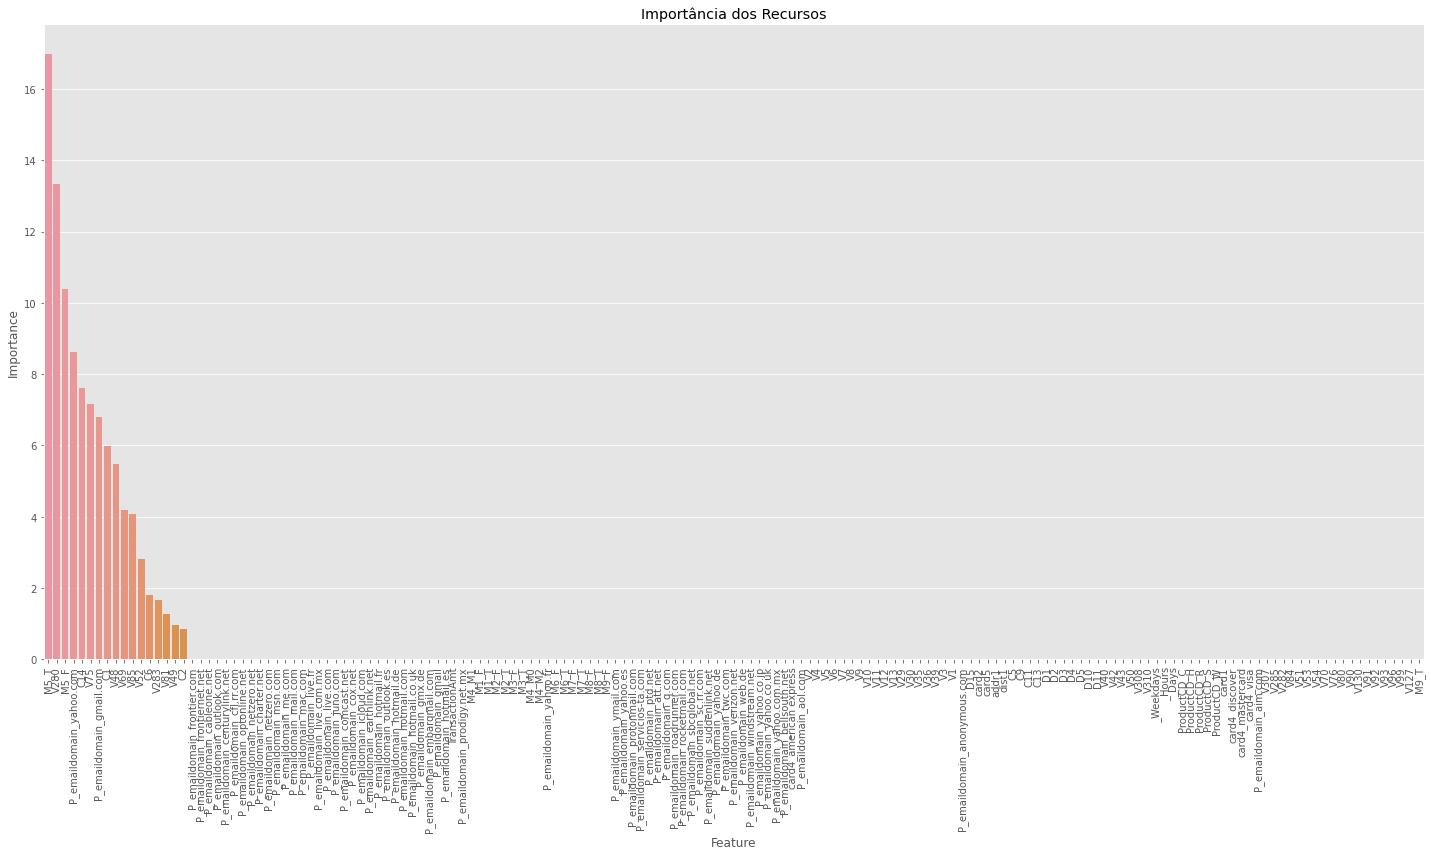

In [289]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.3673193787981094
F1-Score Negativo (Teste): 0.9709584722535853
F1-Score Positivo Médio (Validação Cruzada): 0.2673423877441872
F1-Score Positivo Fold 1: 0.400735294117647
F1-Score Positivo Fold 2: 0.3230769230769231
F1-Score Positivo Fold 3: 0.3843283582089552
F1-Score Positivo Fold 4: 0.26799999999999996
F1-Score Positivo Fold 5: 0.3365200764818356
F1-Score Positivo Fold 6: 0.34651600753295664
F1-Score Positivo Fold 7: 0.09746588693957114
F1-Score Positivo Fold 8: 0.18410041841004185
F1-Score Positivo Fold 9: 0.22672064777327935
F1-Score Positivo Fold 10: 0.10596026490066224
F1-Score Negativo Médio (Validação Cruzada): 0.9839577492023116
F1-Score Negativo Fold 1: 0.9858739925470146
F1-Score Negativo Fold 2: 0.9847632239632932
F1-Score Negativo Fold 3: 0.9857056224551676
F1-Score Negativo Fold 4: 0.984170919470634
F1-Score Negativo Fold 5: 0.9849777046625394
F1-Score Negativo Fold 6: 0.9849725001082673
F1-Score Negativo Fold 7: 0.9799645159894415
F1-Score N

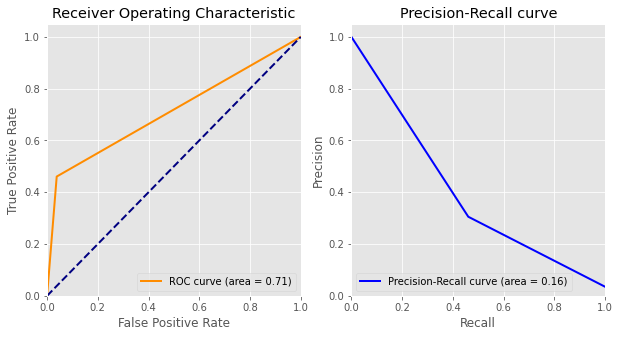

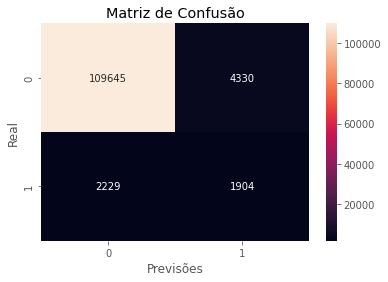

              precision    recall  f1-score   support

           0       0.98      0.96      0.97    113975
           1       0.31      0.46      0.37      4133

    accuracy                           0.94    118108
   macro avg       0.64      0.71      0.67    118108
weighted avg       0.96      0.94      0.95    118108

CPU times: user 8min 43s, sys: 332 ms, total: 8min 43s
Wall time: 8min 43s


In [290]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_gbc.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_gbc.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_gbc, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [291]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_gbc.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 2.74 s, sys: 4 ms, total: 2.75 s
Wall time: 2.75 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.367319378798109  0.970958472253585
Threshold: 0.05  0.100378363413444  0.574471667404576
Threshold: 0.1   0.135615023291169  0.760157699192576
Threshold: 0.15  0.169397744200894  0.842798453359111
Threshold: 0.2   0.202463326875173  0.888805278999768
Threshold: 0.25  0.234704891844048  0.916805519701485
Threshold: 0.3   0.268355494823146  0.935903752031641
Threshold: 0.35  0.295133046675391  0.948625828340956
Threshold: 0.4   0.322136845956824  0.958378079631186
Threshold: 0.45  0.346248410343366  0.965640470365964
Threshold: 0.5   0.367319378798109  0.970958472253585
Threshold: 0.55  0.385004397537379  0.975369848538218
Threshold: 0.6   0.394843462246777  0.978388308903806
Threshold: 0.65  0.394967177242888  0.980673120609513
Threshold: 0.7   0.386569872958258  0.982334802529573
Threshold: 0.75  0.366881507188894  0.983355418938588

In [292]:
feature_importances = clf_gbc.feature_importances_

df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature         Importance
55                              V81  0.266204858429120
13                              C14  0.109992599833290
71                             V308  0.100762958700911
101         P_emaildomain_gmail.com  0.067409151146798
43                              V48  0.065155217666319
11                              C11  0.050059709308730
67                             V282  0.035165337781440
138         P_emaildomain_yahoo.com  0.023827511185462
154                            M5_T  0.023489386529633
66                             V280  0.022990459136168
9                                C6  0.021700428069935
16                               D3  0.021574442007487
153                            M5_F  0.020133505002800
6                                C1  0.019291261710176
0                    TransactionAmt  0.018456007898977
73                        _Weekdays  0.012150428286096
149                            M3_T  0.011704294412024
74                           _Hours  0.010081233061512
62                              V96  0.009887442439890
104       P_emaildomain_hotmail.com  0.008882917974945
148                            M3_F  0.008398438618831
29                               V8  0.007728008947211
24                               V3  0.007335640470419
12                              C13  0.006559373743675
159                            M8_F  0.005236502522641
47                              V52  0.004468635755685
120       P_emaildomain_outlook.com  0.004222152091665
87            P_emaildomain_aol.com  0.004039516844716
160                            M8_T  0.003923920099909
94        P_emaildomain_comcast.net  0.003588737849356
64                             V127  0.002671761904901
84                       card4_visa  0.002280444254873
19                              D10  0.001903191547572
86      P_emaildomain_anonymous.com  0.001861753830469
152                           M4_M2  0.001834086731895
65                             V130  0.001442917382433
83                 card4_mastercard  0.001412485334637
35                              V29  0.001250790570508
150                           M4_M0  0.001132857324314
30                               V9  0.001094016108507
82                   card4_discover  0.001018359712146
114          P_emaildomain_mail.com  0.000891985299043
49                              V54  0.000872930350009
56                              V84  0.000862197947981
75                            _Days  0.000815429964044
48                              V53  0.000790767914106
108        P_emaildomain_icloud.com  0.000763516181047
18                               D5  0.000753004851036
2                             card2  0.000733854661307
37                              V35  0.000602967999292
1                             card1  0.000590602604059
161                            M9_F  0.000000000000000
117       P_emaildomain_netzero.com  0.000000000000000
109          P_emaildomain_juno.com  0.000000000000000
102            P_emaildomain_gmx.de  0.000000000000000
110          P_emaildomain_live.com  0.000000000000000
119     P_emaildomain_optonline.net  0.000000000000000
118       P_emaildomain_netzero.net  0.000000000000000
103     P_emaildomain_hotmail.co.uk  0.000000000000000
106        P_emaildomain_hotmail.es  0.000000000000000
105        P_emaildomain_hotmail.de  0.000000000000000
116           P_emaildomain_msn.com  0.000000000000000
115            P_emaildomain_me.com  0.000000000000000
111       P_emaildomain_live.com.mx  0.000000000000000
113           P_emaildomain_mac.com  0.000000000000000
112           P_emaildomain_live.fr  0.000000000000000
107        P_emaildomain_hotmail.fr  0.000000000000000
155                            M6_F  0.000000000000000
121        P_emaildomain_outlook.es  0.000000000000000
136       P_emaildomain_yahoo.co.jp  0.000000000000000
156                            M6_T  0.000000000000000
151                           M4_M1  0.000000000000000
147          

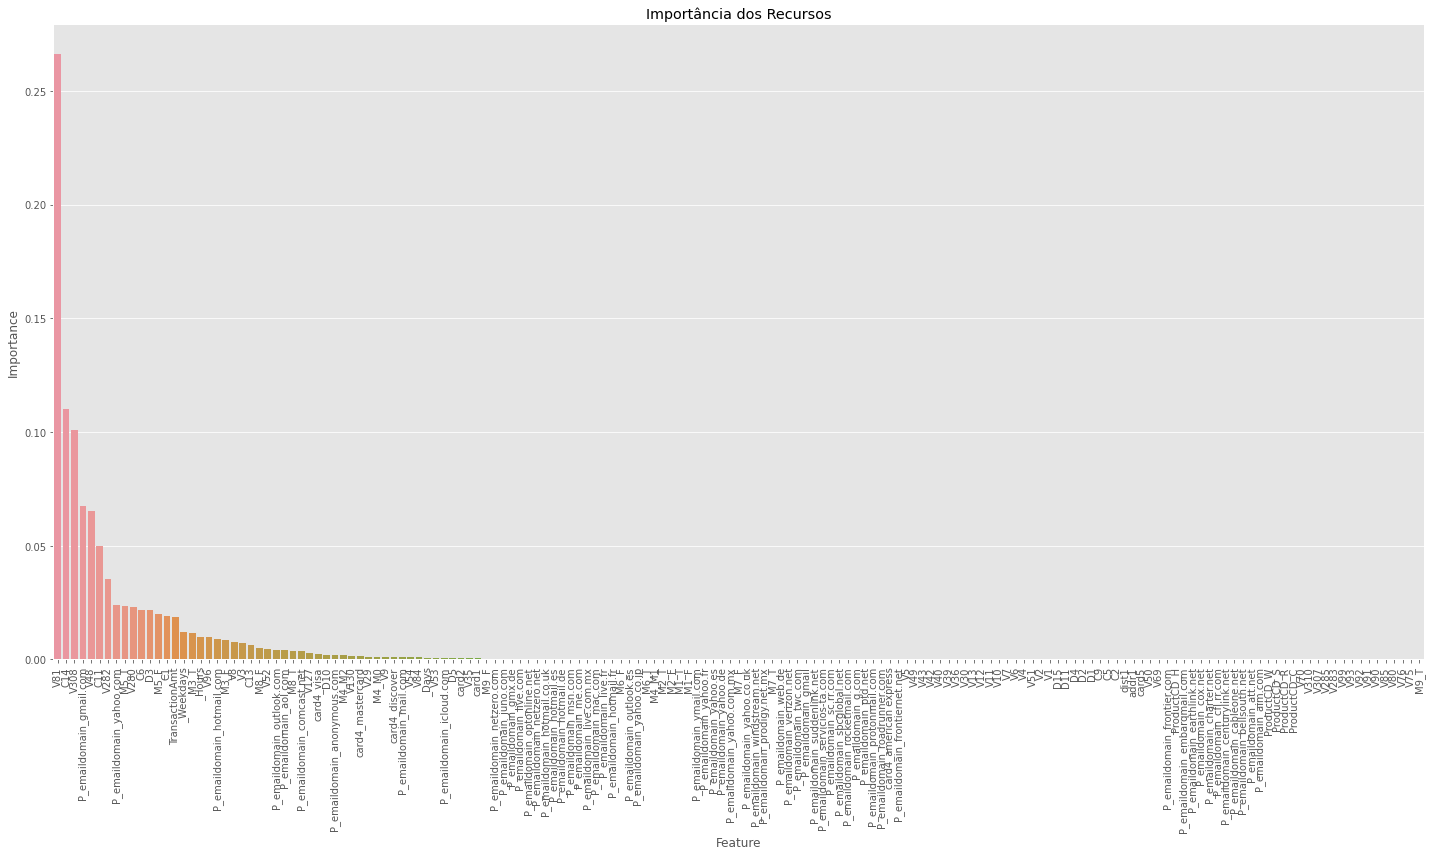

In [293]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.3348318348318348
F1-Score Negativo (Teste): 0.964362812438672
F1-Score Positivo Médio (Validação Cruzada): 0.335181738224934
F1-Score Positivo Fold 1: 0.38817005545286504
F1-Score Positivo Fold 2: 0.35361216730038025
F1-Score Positivo Fold 3: 0.3320610687022901
F1-Score Positivo Fold 4: 0.3161904761904762
F1-Score Positivo Fold 5: 0.3709369024856597
F1-Score Positivo Fold 6: 0.33270321361058597
F1-Score Positivo Fold 7: 0.367112810707457
F1-Score Positivo Fold 8: 0.2795275590551181
F1-Score Positivo Fold 9: 0.30115830115830117
F1-Score Positivo Fold 10: 0.31034482758620685
F1-Score Negativo Médio (Validação Cruzada): 0.9849293419127733
F1-Score Negativo Fold 1: 0.9856592002079633
F1-Score Negativo Fold 2: 0.985278836162106
F1-Score Negativo Fold 3: 0.9848471729154039
F1-Score Negativo Fold 4: 0.9844568558687276
F1-Score Negativo Fold 5: 0.9857569591757219
F1-Score Negativo Fold 6: 0.9847139825921274
F1-Score Negativo Fold 7: 0.9856703753409237
F1-Score Nega

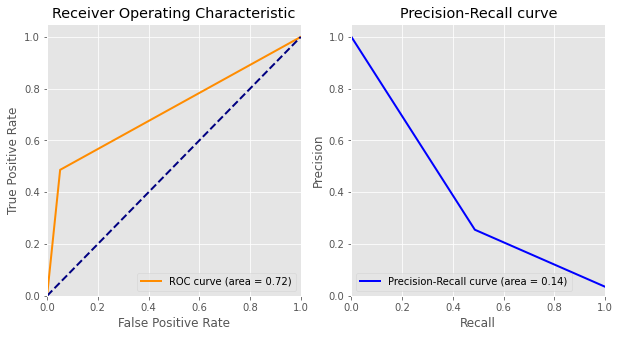

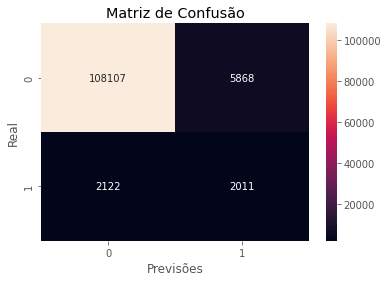

              precision    recall  f1-score   support

           0       0.98      0.95      0.96    113975
           1       0.26      0.49      0.33      4133

    accuracy                           0.93    118108
   macro avg       0.62      0.72      0.65    118108
weighted avg       0.96      0.93      0.94    118108

CPU times: user 10min 47s, sys: 7.95 s, total: 10min 55s
Wall time: 10min 54s


In [294]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_ada.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_ada.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_ada, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [295]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_ada.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 34 s, sys: 144 ms, total: 34.1 s
Wall time: 34.1 s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.334831834831835  0.964362812438672
Threshold: 0.05  0.067620520120091                0.0
Threshold: 0.1   0.067620520120091                0.0
Threshold: 0.15  0.067620520120091                0.0
Threshold: 0.2   0.067620520120091                0.0
Threshold: 0.25  0.067620520120091                0.0
Threshold: 0.3   0.067620520120091                0.0
Threshold: 0.35  0.067620520120091                0.0
Threshold: 0.4   0.067620520120091                0.0
Threshold: 0.45  0.067620520120091                0.0
Threshold: 0.5   0.334831834831835  0.964362812438672
Threshold: 0.55                0.0  0.982191715894745
Threshold: 0.6                 0.0  0.982191715894745
Threshold: 0.65                0.0  0.982191715894745
Threshold: 0.7                 0.0  0.982191715894745
Threshold: 0.75                0.0  0.982191715894745

In [296]:
feature_importances = clf_ada.feature_importances_

df = pd.DataFrame({'Feature': X_test.columns, 'Importance': feature_importances})
df = df.sort_values(by='Importance', ascending=False)
df

Feature  Importance
13                              C14        0.07
6                                C1        0.06
74                           _Hours        0.04
62                              V96        0.04
64                             V127        0.03
101         P_emaildomain_gmail.com        0.03
84                       card4_visa        0.03
68                             V283        0.03
66                             V280        0.03
9                                C6        0.03
43                              V48        0.02
152                           M4_M2        0.02
29                               V8        0.02
148                            M3_F        0.02
0                    TransactionAmt        0.02
138         P_emaildomain_yahoo.com        0.02
48                              V53        0.02
154                            M5_T        0.02
83                 card4_mastercard        0.02
153                            M5_F        0.02
104       P_emaildomain_hotmail.com        0.02
11                              C11        0.02
12                              C13        0.02
2                             card2        0.01
73                        _Weekdays        0.01
49                              V54        0.01
55                              V81        0.01
58                              V90        0.01
59                              V91        0.01
18                               D5        0.01
10                               C9        0.01
67                             V282        0.01
69                             V285        0.01
71                             V308        0.01
75                            _Days        0.01
108        P_emaildomain_icloud.com        0.01
46                              V51        0.01
1                             card1        0.01
82                   card4_discover        0.01
86      P_emaildomain_anonymous.com        0.01
87            P_emaildomain_aol.com        0.01
116           P_emaildomain_msn.com        0.01
114          P_emaildomain_mail.com        0.01
94        P_emaildomain_comcast.net        0.01
110          P_emaildomain_live.com        0.01
120       P_emaildomain_outlook.com        0.01
19                              D10        0.01
150                           M4_M0        0.01
25                               V4        0.01
149                            M3_T        0.01
40                              V40        0.01
27                               V6        0.01
31                              V10        0.01
16                               D3        0.01
17                               D4        0.01
32                              V11        0.01
24                               V3        0.01
151                           M4_M1        0.01
118       P_emaildomain_netzero.net        0.00
160                            M8_T        0.00
161                            M9_F        0.00
119     P_emaildomain_optonline.net        0.00
117       P_emaildomain_netzero.com        0.00
147                            M2_T        0.00
136       P_emaildomain_yahoo.co.jp        0.00
115            P_emaildomain_me.com        0.00
122    P_emaildomain_prodigy.net.mx        0.00
113           P_emaildomain_mac.com        0.00
112           P_emaildomain_live.fr        0.00
111       P_emaildomain_live.com.mx        0.00
109          P_emaildomain_juno.com        0.00
107        P_emaildomain_hotmail.fr        0.00
106        P_emaildomain_hotmail.es        0.00
105        P_emaildomain_hotmail.de        0.00
121        P_emaildomain_outlook.es        0.00
146                            M2_F        0.00
137       P_emaildomain_yahoo.co.uk        0.00
128     P_emaildomain_sbcglobal.net        0.00
156                            M6_T        0.00
135    P_emaildomain_windstream.net        0.00
103     P_emaildomain_hotmail.co.uk        0.00
133       P_emaildomain_verizon.net        0.00
132           P_emaildomain_twc.com        0

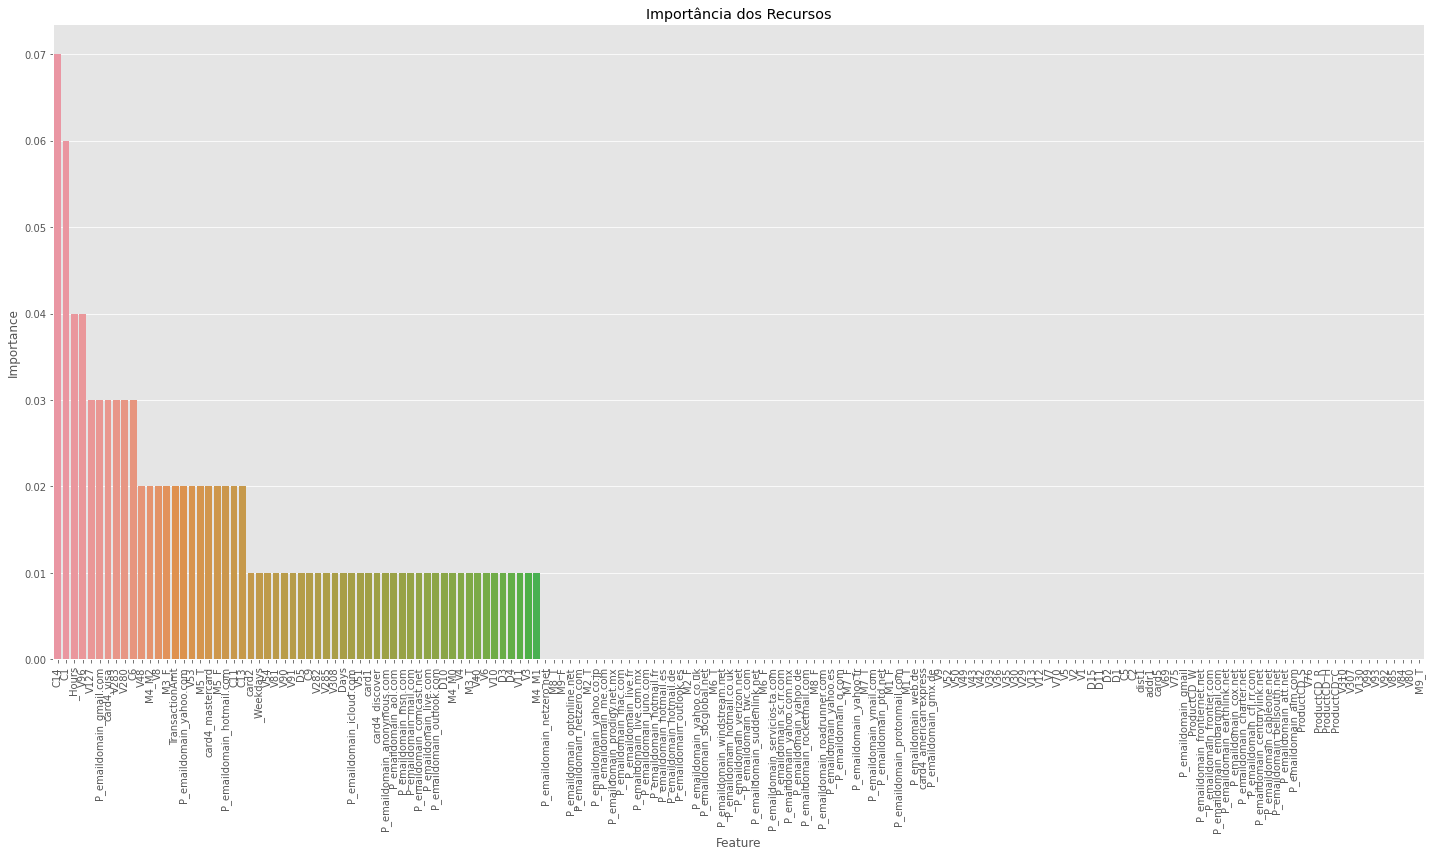

In [297]:
plt.figure(figsize=(20, 12))
sns.barplot(x = df['Feature'], y = df['Importance'])
plt.title('Importância dos Recursos')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

F1-Score Positivo (Teste): 0.3163402028967014
F1-Score Negativo (Teste): 0.9514153702452584
F1-Score Positivo Médio (Validação Cruzada): 0.2657473185015969
F1-Score Positivo Fold 1: 0.2636203866432338
F1-Score Positivo Fold 2: 0.2491349480968858
F1-Score Positivo Fold 3: 0.2539130434782609
F1-Score Positivo Fold 4: 0.23633156966490299
F1-Score Positivo Fold 5: 0.2901554404145078
F1-Score Positivo Fold 6: 0.24834437086092717
F1-Score Positivo Fold 7: 0.2694300518134715
F1-Score Positivo Fold 8: 0.2582897033158813
F1-Score Positivo Fold 9: 0.2852233676975945
F1-Score Positivo Fold 10: 0.30303030303030304
F1-Score Negativo Médio (Validação Cruzada): 0.9815202969261145
F1-Score Negativo Fold 1: 0.9818244913894071
F1-Score Negativo Fold 2: 0.9811664641555284
F1-Score Negativo Fold 3: 0.981385863669892
F1-Score Negativo Fold 4: 0.9812188245499891
F1-Score Negativo Fold 5: 0.9821637807577138
F1-Score Negativo Fold 6: 0.9802763055000434
F1-Score Negativo Fold 7: 0.9816430152323916
F1-Score Neg

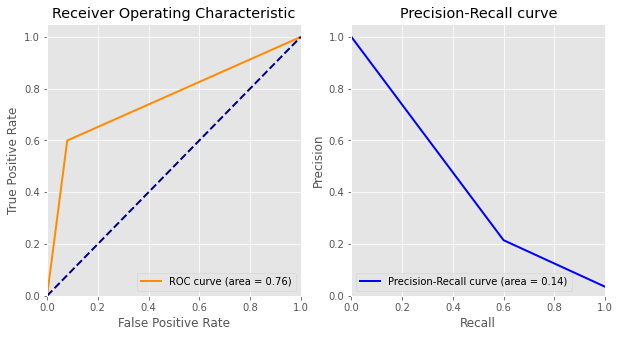

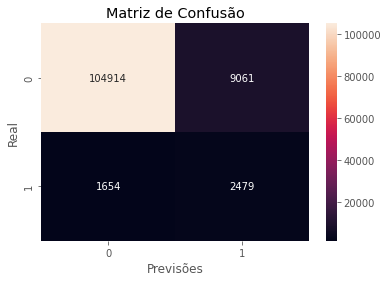

              precision    recall  f1-score   support

           0       0.98      0.92      0.95    113975
           1       0.21      0.60      0.32      4133

    accuracy                           0.91    118108
   macro avg       0.60      0.76      0.63    118108
weighted avg       0.96      0.91      0.93    118108

CPU times: user 39min 47s, sys: 1.04 s, total: 39min 48s
Wall time: 3min 28s


In [298]:
%%time

# Crie e ajuste o classificador ao conjunto de treinamento (substitua pelo classificador desejado)
clf_knn.fit(X_train_oversample_with_adasyn, y_train_oversample_with_adasyn)

# Faça previsões no conjunto de teste
previsoes = clf_knn.predict(X_test)

# Calcule o F1-Score positivo para o conjunto de teste
f1_score_positivo_teste = f1_score(y_test, previsoes, pos_label = 1)

# Calcule o F1-Score negativo para o conjunto de teste
f1_score_negativo_teste = f1_score(y_test, previsoes, pos_label = 0)

# Defina a função de pontuação para o F1-Score positivo
f1_score_positivo = make_scorer(f1_score, pos_label = 1)

# Calcule o F1-Score positivo usando validação cruzada
scores_positivos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_positivo)

# Defina a função de pontuação para o F1-Score negativo
f1_score_negativo = make_scorer(f1_score, pos_label=0)

# Calcule o F1-Score negativo usando validação cruzada
scores_negativos = cross_val_score(clf_knn, X_test, \
                                   y_test, cv = 10, scoring = f1_score_negativo)

print("F1-Score Positivo (Teste):", f1_score_positivo_teste)
print("F1-Score Negativo (Teste):", f1_score_negativo_teste)
print("F1-Score Positivo Médio (Validação Cruzada):", scores_positivos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_positivos):
    print(f"F1-Score Positivo Fold {i + 1}: {result}")
print("F1-Score Negativo Médio (Validação Cruzada):", scores_negativos.mean())
# listar os resultados da validação
for i, result in enumerate(scores_negativos):
    print(f"F1-Score Negativo Fold {i + 1}: {result}")

# Calcular a curva ROC
fpr, tpr, _ = roc_curve(y_test, previsoes)
roc_auc = auc(fpr, tpr)

# Calcular a curva PR
precision, recall, _ = precision_recall_curve(y_test, previsoes)
pr_auc = average_precision_score(y_test, previsoes)

# Plotar as curvas ROC e PR
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='lower left')

plt.show()

from sklearn.metrics import confusion_matrix

# Suponha que você tenha as previsões (y_pred) e os rótulos reais (y_true)
conf_matrix = confusion_matrix(y_test, previsoes)

# Crie um heatmap da matriz de confusão para visualização
#####################################
#                Previsões
#              0            1  
#       0     VN           FP
# Real
#       1     FN           VP
####################################
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Previsões')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# análise de métricas
from sklearn.metrics import classification_report

# Gere um relatório de classificação detalhado
report = classification_report(y_test, previsoes)
print(report)

In [299]:
%%time

metrics_original = [f1_score_positivo_teste, f1_score_negativo_teste]

original = pd.DataFrame(metrics_original)
original.index = ['F1_score Positivo', 'F1_score Negativo']
original.columns = ['Original Dataset']

cols = ['Metrics', 'Original']
adj_threshold = pd.DataFrame()
adj_threshold['Original'] = metrics_original
thresholds = [ j/20 for j in range(1,16)]
for i in thresholds:
    y_pred_new_threshold = (clf_knn.predict_proba(X_test)[:,1]>=i).astype(int) \
    #calculating the threshold with respect to class 1

    f1_score_positivo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 1, average='binary')
    f1_score_negativo_adj_threshold =  f1_score(y_test, y_pred_new_threshold, pos_label = 0, average='binary')
    metrics_adj_threshold = [f1_score_positivo_adj_threshold, f1_score_negativo_adj_threshold]
    name = 'Threshold: ' + str(i) 
    adj_threshold[name] = metrics_adj_threshold
    cols.append(name)

adj_threshold.index = ['F1_score Positivo', 'F1_score Negativo']
adj_threshold = adj_threshold.reset_index()
adj_threshold.columns = cols
adj_threshold.transpose()

adj_threshold1 = adj_threshold.transpose().iloc[1:, :]
adj_threshold1.columns = adj_threshold.iloc[:,0]
adj_threshold1

CPU times: user 8h 8min 24s, sys: 2.32 s, total: 8h 8min 26s
Wall time: 41min 11s


Metrics          F1_score Positivo  F1_score Negativo
Original         0.316340202896701  0.951415370245258
Threshold: 0.05  0.264626375748214  0.929308584686775
Threshold: 0.1   0.264626375748214  0.929308584686775
Threshold: 0.15  0.264626375748214  0.929308584686775
Threshold: 0.2   0.264626375748214  0.929308584686775
Threshold: 0.25  0.264626375748214  0.929308584686775
Threshold: 0.3   0.264626375748214  0.929308584686775
Threshold: 0.35  0.316340202896701  0.951415370245258
Threshold: 0.4   0.316340202896701  0.951415370245258
Threshold: 0.45  0.316340202896701  0.951415370245258
Threshold: 0.5   0.316340202896701  0.951415370245258
Threshold: 0.55  0.316340202896701  0.951415370245258
Threshold: 0.6   0.316340202896701  0.951415370245258
Threshold: 0.65  0.316340202896701  0.951415370245258
Threshold: 0.7   0.390726604467062  0.971343720218967
Threshold: 0.75  0.390726604467062  0.971343720218967

# Cálculo tempo total do script

In [300]:
t1 = time.time()
print("Script took {:.2} s".format(t1 - t0))

Script took 3.2e+04 s
